In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from construct import *
import scipy.signal

import sys
sys.path.append('../Tianwen/') # to import ccsds
import ccsds

import struct
import collections
import pathlib

In [2]:
CE5_AOSInsertZone = Struct(
    'unknown1' / Hex(Int8ub),
    'unknown2' / Int8ub,
    'unknown3' / Hex(Int8ub),
    'unknown4' / Hex(Int8ub),
    'timestamp' / Int32ul, # in units of 1s, epoch 2012-08-01 UTC
)

CE5_AOSFrame = Struct(
    'primary_header' / ccsds.AOSPrimaryHeader,
    'insert_zone' / CE5_AOSInsertZone,
    'm_pdu_header' / ccsds.M_PDU_Header,
    'm_pdu_packet_zone' / GreedyBytes
)

def get_packet(p):
    return p[0] if type(p) is tuple else p

def packets_asarray(packets):
    return np.array([np.frombuffer(get_packet(p)[ccsds.SpacePacketPrimaryHeader.sizeof():], 'uint8')
                     for p in packets])

def plot_apids(apids, sc, vc):
    for apid in sorted(apids.keys()):
        plt.figure(figsize = (16,16), facecolor = 'w')
        ps = packets_asarray(apids[apid])
        plt.imshow(ps, aspect = ps.shape[1]/ps.shape[0])
        plt.title(f"Chang'e 5 Spacecraft {sc} APID {apid} Virtual channel {vc}")

def get_timestamps(x):
    return np.datetime64('2012-08-01') + np.timedelta64(1,'s')*np.array(x)
        
def get_packet_timestamps(packets):
    return get_timestamps([p[1] for p in packets])

Here we look at some Chang'e 5 low data rate telemetry received with Allen Telescope array on 2020-11-29 before and during LOI-2, the lunar orbit circularization burn. The four channels recorded correspond to the following frequencies:

* 8463.7 MHz (lander)
* 8671.2 MHz (orbiter)
* 8478.6 MHz (lander)
* 8486.2 MHz (orbiter)

The frames are CCSDS concatenated frames with a frames size of 220 bytes.

In [3]:
def load_frames(path):
    frame_size = 220
    frames = np.fromfile(path, dtype = 'uint8')
    frames = frames[:frames.size//frame_size*frame_size].reshape((-1, frame_size))
    return frames

In [4]:
frames = [load_frames(f'ATA_2020-11-29/ce5_frames_{chan}.u8') for chan in range(4)]

## AOS frames

AOS frames from the lander use spacecraft ID 91, while AOS frames from the orbiter use spacecraft ID 108.
Both spacecraft use virtual channels 1 and 2. Other combinations, including virtual channel 33 (which has several frames) are most likely to corruted frames despite the fact that the Reed-Solomon decoder was successful. The vast majority of frames from both spacecraft belong to virtual channel 1, which seems to send real-time telemetry.

The frames transmitted in each of the two frequencies of each spacecraft are identical, so we can combine the decoded frames for diversity reception.

In [5]:
aos = [[CE5_AOSFrame.parse(f) for f in fr] for fr in frames]

In [6]:
[collections.Counter([a.primary_header.transfer_frame_version_number for a in aos_]) for aos_ in aos]

[Counter({1: 5194, 2: 1}),
 Counter({1: 9721}),
 Counter({1: 1903}),
 Counter({1: 6930})]

In [7]:
[collections.Counter([a.primary_header.spacecraft_id for a in aos_
                    if a.primary_header.transfer_frame_version_number == 1]) for aos_ in aos]

[Counter({91: 5123, 62: 1, 60: 1, 63: 66, 61: 1, 56: 2}),
 Counter({108: 9721}),
 Counter({91: 1888, 62: 2, 63: 10, 57: 2, 56: 1}),
 Counter({108: 6930})]

In [8]:
[collections.Counter([a.primary_header.virtual_channel_id for a in aos_
                    if a.primary_header.transfer_frame_version_number == 1]) for aos_ in aos]

[Counter({1: 5110,
          52: 3,
          2: 20,
          54: 1,
          55: 1,
          48: 4,
          49: 4,
          33: 47,
          17: 1,
          16: 1,
          19: 1,
          3: 1}),
 Counter({1: 9702, 2: 19}),
 Counter({1: 1880, 52: 1, 2: 8, 54: 1, 55: 1, 48: 4, 49: 4, 0: 1, 3: 3}),
 Counter({1: 6915, 2: 15})]

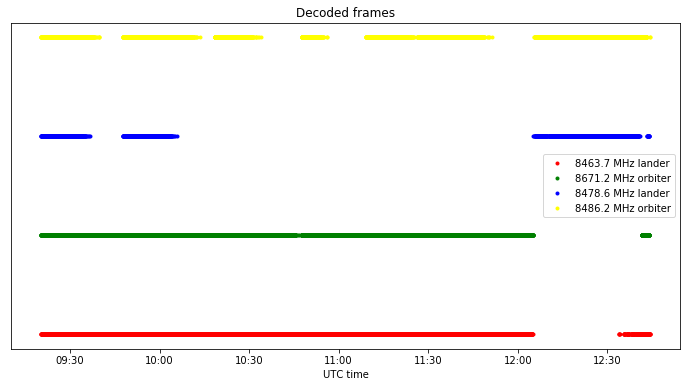

In [9]:
colors = ['red', 'green', 'blue', 'yellow']
freqs = [8463.7, 8671.2, 8478.6, 8486.2]
spacecrafts = ['lander', 'orbiter', 'lander', 'orbiter']
plt.figure(figsize = (12,6), facecolor = 'w')
for chan in range(4):
    t = get_timestamps([a.insert_zone.timestamp for a in aos[chan]])
    sel = (t >= np.datetime64('2020-11-29')) & (t <= np.datetime64('2020-11-30'))
    t = t[sel]
    plt.plot(t, chan*np.ones(len(t)), '.', color = colors[chan])
plt.legend([f'{f:.01f} MHz {s}' for f,s in zip(freqs, spacecrafts)])
plt.yticks([])
plt.title('Decoded frames')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.xlabel('UTC time');

In [10]:
aos_by_seq = [{(a.primary_header.virtual_channel_id, a.primary_header.virtual_channel_frame_count) : a
               for a in aos_} for aos_ in aos]

In [11]:
def check_equality(x, y):
    passes = 0
    for k, v in x.items():
        try:
            w = y[k]
        except KeyError:
            passes += 1
            pass
        else:
            if v != w:
                return False
    return True

In [12]:
check_equality(aos_by_seq[0], aos_by_seq[2])

True

In [13]:
check_equality(aos_by_seq[1], aos_by_seq[3])

True

In [14]:
[a.primary_header for a in aos[0][:5]]

[Container(transfer_frame_version_number=1, spacecraft_id=91, virtual_channel_id=1, virtual_channel_frame_count=264070, replay_flag=False, vc_frame_count_usage_flag=False, rsvd_spare=0, vc_framecount_cycle=0),
 Container(transfer_frame_version_number=1, spacecraft_id=91, virtual_channel_id=1, virtual_channel_frame_count=264071, replay_flag=False, vc_frame_count_usage_flag=False, rsvd_spare=0, vc_framecount_cycle=0),
 Container(transfer_frame_version_number=1, spacecraft_id=91, virtual_channel_id=1, virtual_channel_frame_count=264072, replay_flag=False, vc_frame_count_usage_flag=False, rsvd_spare=0, vc_framecount_cycle=0),
 Container(transfer_frame_version_number=1, spacecraft_id=91, virtual_channel_id=1, virtual_channel_frame_count=264073, replay_flag=False, vc_frame_count_usage_flag=False, rsvd_spare=0, vc_framecount_cycle=0),
 Container(transfer_frame_version_number=1, spacecraft_id=91, virtual_channel_id=1, virtual_channel_frame_count=264074, replay_flag=False, vc_frame_count_usage_

In [15]:
[a.primary_header for a in aos[2][:5]]

[Container(transfer_frame_version_number=1, spacecraft_id=91, virtual_channel_id=1, virtual_channel_frame_count=264070, replay_flag=False, vc_frame_count_usage_flag=False, rsvd_spare=0, vc_framecount_cycle=0),
 Container(transfer_frame_version_number=1, spacecraft_id=91, virtual_channel_id=1, virtual_channel_frame_count=264071, replay_flag=False, vc_frame_count_usage_flag=False, rsvd_spare=0, vc_framecount_cycle=0),
 Container(transfer_frame_version_number=1, spacecraft_id=91, virtual_channel_id=1, virtual_channel_frame_count=264072, replay_flag=False, vc_frame_count_usage_flag=False, rsvd_spare=0, vc_framecount_cycle=0),
 Container(transfer_frame_version_number=1, spacecraft_id=91, virtual_channel_id=1, virtual_channel_frame_count=264073, replay_flag=False, vc_frame_count_usage_flag=False, rsvd_spare=0, vc_framecount_cycle=0),
 Container(transfer_frame_version_number=1, spacecraft_id=91, virtual_channel_id=1, virtual_channel_frame_count=264074, replay_flag=False, vc_frame_count_usage_

In [16]:
[a.primary_header for a in aos[1][:5]]

[Container(transfer_frame_version_number=1, spacecraft_id=108, virtual_channel_id=1, virtual_channel_frame_count=530359, replay_flag=False, vc_frame_count_usage_flag=False, rsvd_spare=0, vc_framecount_cycle=0),
 Container(transfer_frame_version_number=1, spacecraft_id=108, virtual_channel_id=1, virtual_channel_frame_count=530360, replay_flag=False, vc_frame_count_usage_flag=False, rsvd_spare=0, vc_framecount_cycle=0),
 Container(transfer_frame_version_number=1, spacecraft_id=108, virtual_channel_id=1, virtual_channel_frame_count=530361, replay_flag=False, vc_frame_count_usage_flag=False, rsvd_spare=0, vc_framecount_cycle=0),
 Container(transfer_frame_version_number=1, spacecraft_id=108, virtual_channel_id=1, virtual_channel_frame_count=530362, replay_flag=False, vc_frame_count_usage_flag=False, rsvd_spare=0, vc_framecount_cycle=0),
 Container(transfer_frame_version_number=1, spacecraft_id=108, virtual_channel_id=1, virtual_channel_frame_count=530363, replay_flag=False, vc_frame_count_u

In [17]:
[a.primary_header for a in aos[3][:5]]

[Container(transfer_frame_version_number=1, spacecraft_id=108, virtual_channel_id=1, virtual_channel_frame_count=530360, replay_flag=False, vc_frame_count_usage_flag=False, rsvd_spare=0, vc_framecount_cycle=0),
 Container(transfer_frame_version_number=1, spacecraft_id=108, virtual_channel_id=1, virtual_channel_frame_count=530361, replay_flag=False, vc_frame_count_usage_flag=False, rsvd_spare=0, vc_framecount_cycle=0),
 Container(transfer_frame_version_number=1, spacecraft_id=108, virtual_channel_id=1, virtual_channel_frame_count=530362, replay_flag=False, vc_frame_count_usage_flag=False, rsvd_spare=0, vc_framecount_cycle=0),
 Container(transfer_frame_version_number=1, spacecraft_id=108, virtual_channel_id=1, virtual_channel_frame_count=530363, replay_flag=False, vc_frame_count_usage_flag=False, rsvd_spare=0, vc_framecount_cycle=0),
 Container(transfer_frame_version_number=1, spacecraft_id=108, virtual_channel_id=1, virtual_channel_frame_count=530364, replay_flag=False, vc_frame_count_u

## Spacecraft 91 Virtual channel 1

In [18]:
sc91_vc1 = {}
for chan in (0,2):
    sc91_vc1.update({k[1] : v for k,v in aos_by_seq[chan].items() if k[0] == 1})

sc91_vc1 = [x[1] for x in sorted(sc91_vc1.items(), key = lambda x: x[0])]
fc = np.array([a.primary_header.virtual_channel_frame_count for a in sc91_vc1])
t = get_timestamps([a.insert_zone.timestamp for a in sc91_vc1])

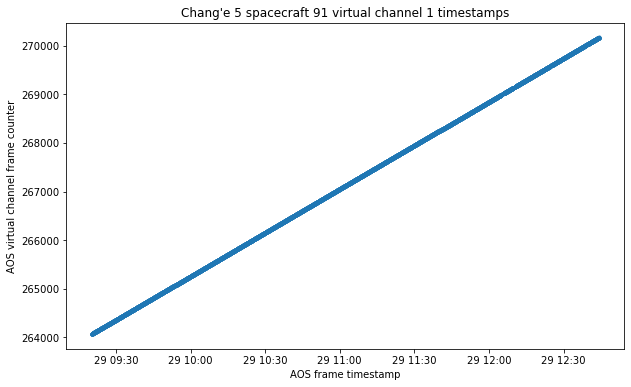

In [19]:
plt.figure(figsize = (10,6), facecolor = 'w')
sel = (t >= np.datetime64('2020-11-29')) & (t <= np.datetime64('2020-11-30'))
plt.plot(t[sel], fc[sel], '.')
plt.title("Chang'e 5 spacecraft 91 virtual channel 1 timestamps")
plt.xlabel('AOS frame timestamp')
plt.ylabel('AOS virtual channel frame counter');

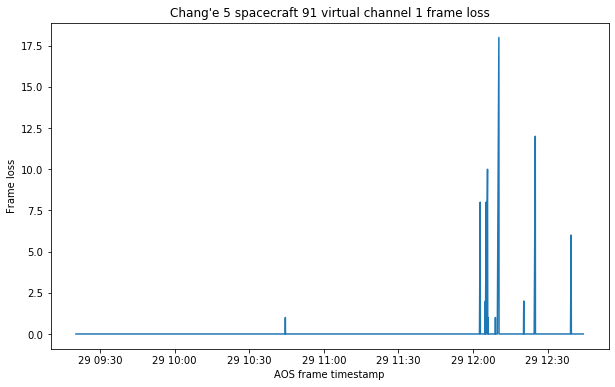

In [20]:
plt.figure(figsize = (10,6), facecolor = 'w')
plt.plot(t[sel][1:], np.diff(fc[sel])-1)
plt.title("Chang'e 5 spacecraft 91 virtual channel 1 frame loss")
plt.xlabel('AOS frame timestamp')
plt.ylabel('Frame loss');

In [21]:
sc91_vc1_packets = list(ccsds.extract_space_packets(sc91_vc1, 91, 1, get_timestamps = True))
sc91_vc1_sp_headers = [ccsds.SpacePacketPrimaryHeader.parse(p[0]) for p in sc91_vc1_packets]
sc91_vc1_apids = collections.Counter([p.APID for p in sc91_vc1_sp_headers])
sc91_vc1_apids

../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 266586, current frame count 266588
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 268917, current frame count 268926
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 91 VC 1] Broken stream. Last frame count 268983, current frame count 268985
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Pa

Counter({532: 2865,
         41: 1508,
         7: 210,
         1034: 109,
         772: 108,
         516: 210,
         537: 774,
         514: 1498,
         43: 1218,
         40: 2962,
         1030: 2876,
         14: 776,
         59: 2523,
         13: 768,
         49: 775,
         33: 775,
         52: 1499,
         777: 1499,
         21: 107,
         517: 211,
         776: 88,
         285: 110,
         281: 1364,
         42: 1216,
         810: 352,
         793: 774,
         5: 774,
         1040: 1021,
         28: 775,
         51: 406,
         34: 406,
         778: 408,
         282: 402,
         518: 212,
         1032: 108,
         25: 107,
         1031: 107,
         798: 112,
         770: 211,
         27: 406,
         37: 211,
         11: 406,
         30: 212,
         512: 109,
         524: 108,
         29: 404,
         61: 354,
         259: 367,
         39: 406,
         515: 408,
         48: 211,
         1033: 107,
         257: 109,
   

There are space packets in may APIDs. The contents of each APID are shown belown in plot form, but it's not easy to guess what any of the values mean.

In [22]:
sc91_vc1_by_apid = {apid : [p for h,p in zip(sc91_vc1_sp_headers, sc91_vc1_packets)
                           if h.APID == apid] for apid in sc91_vc1_apids}

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


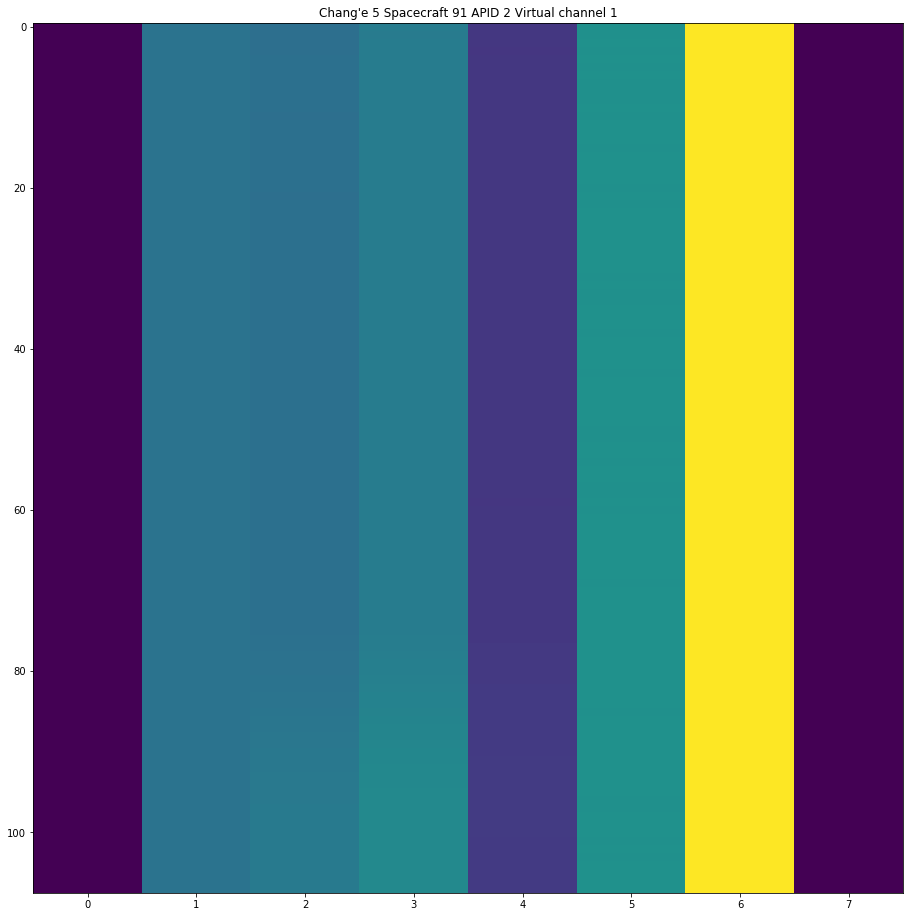

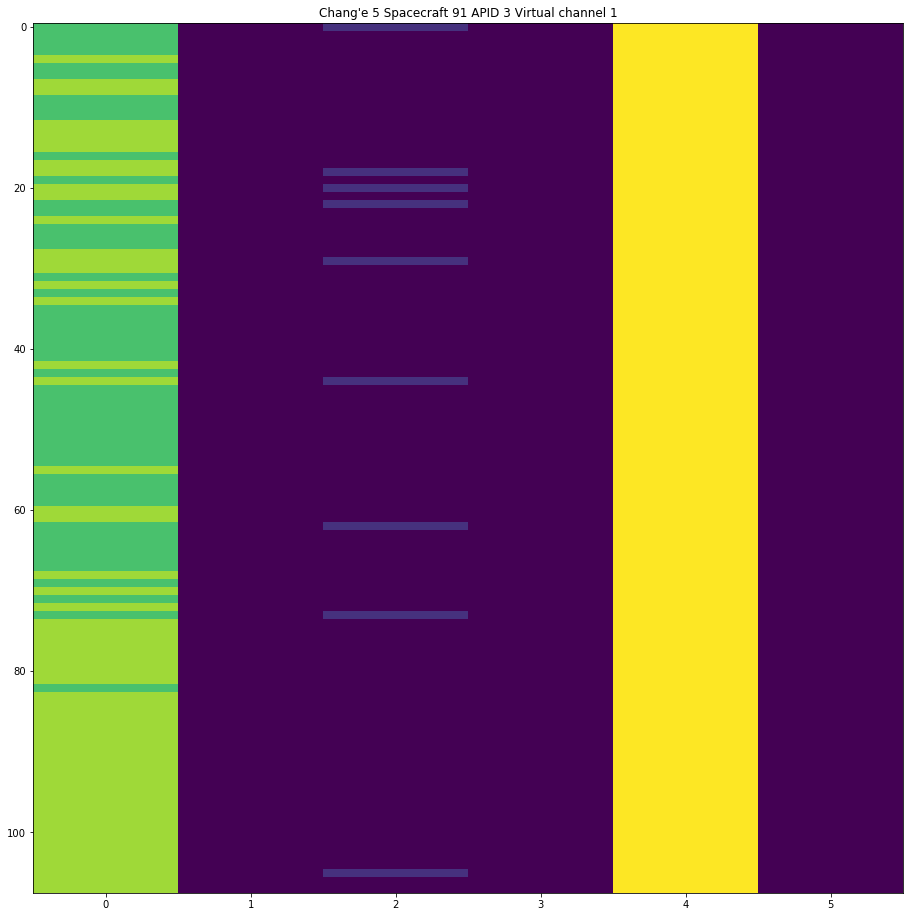

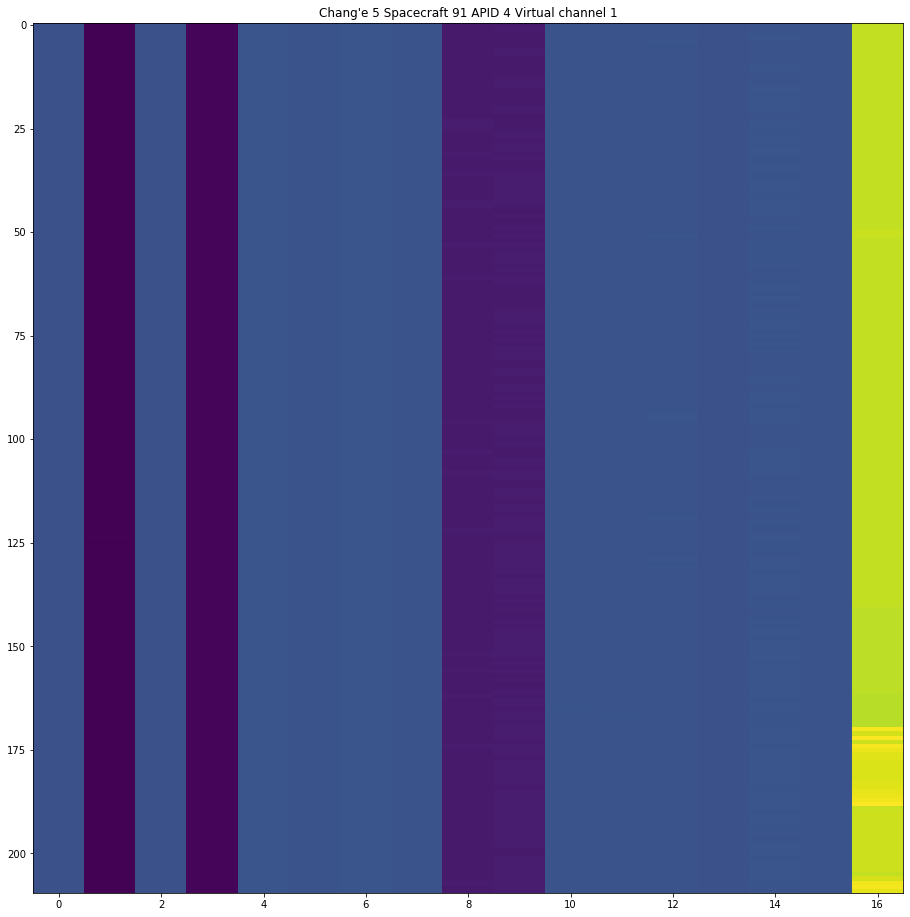

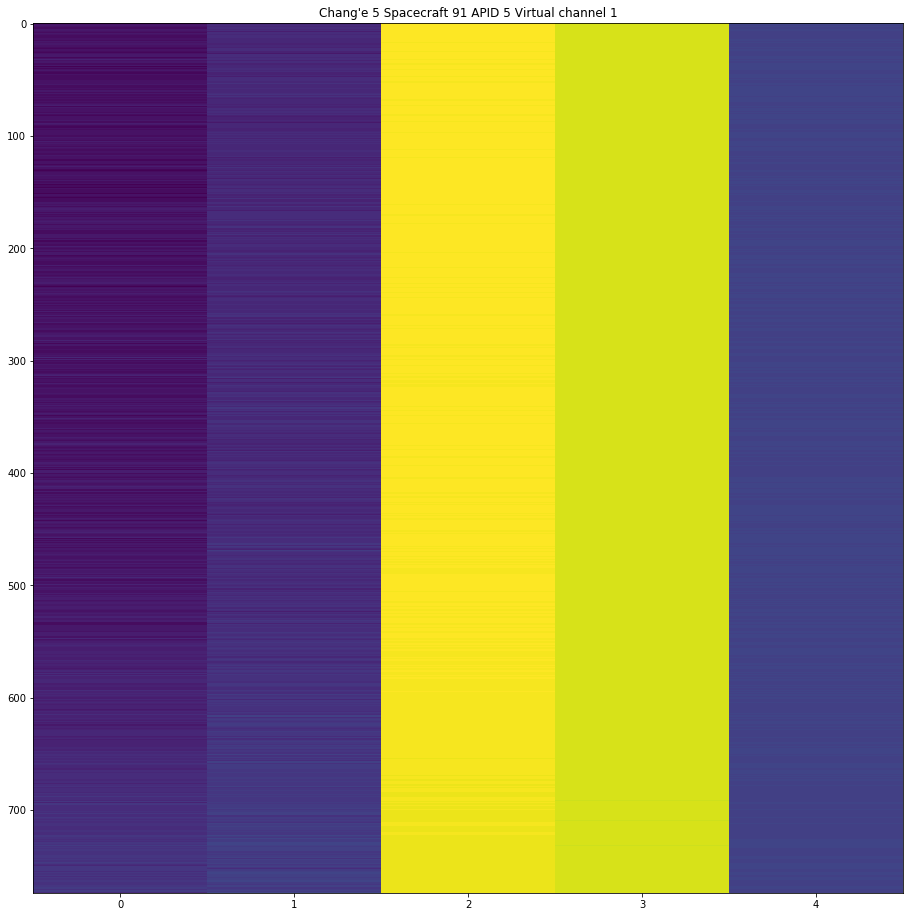

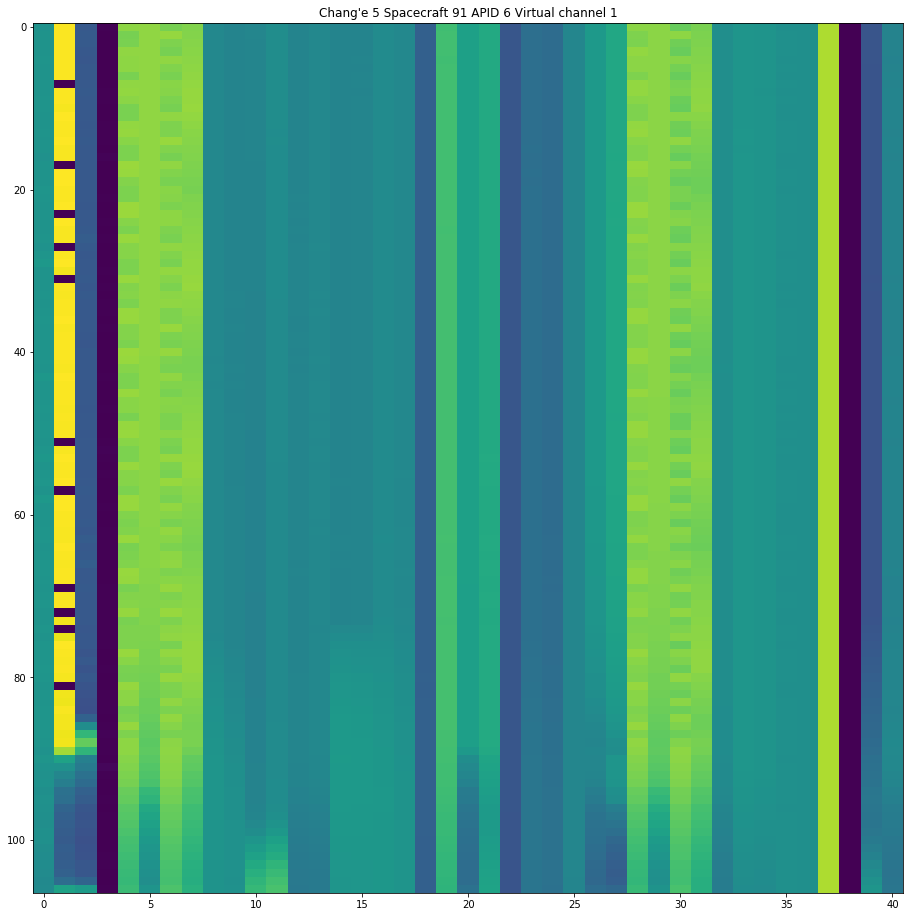

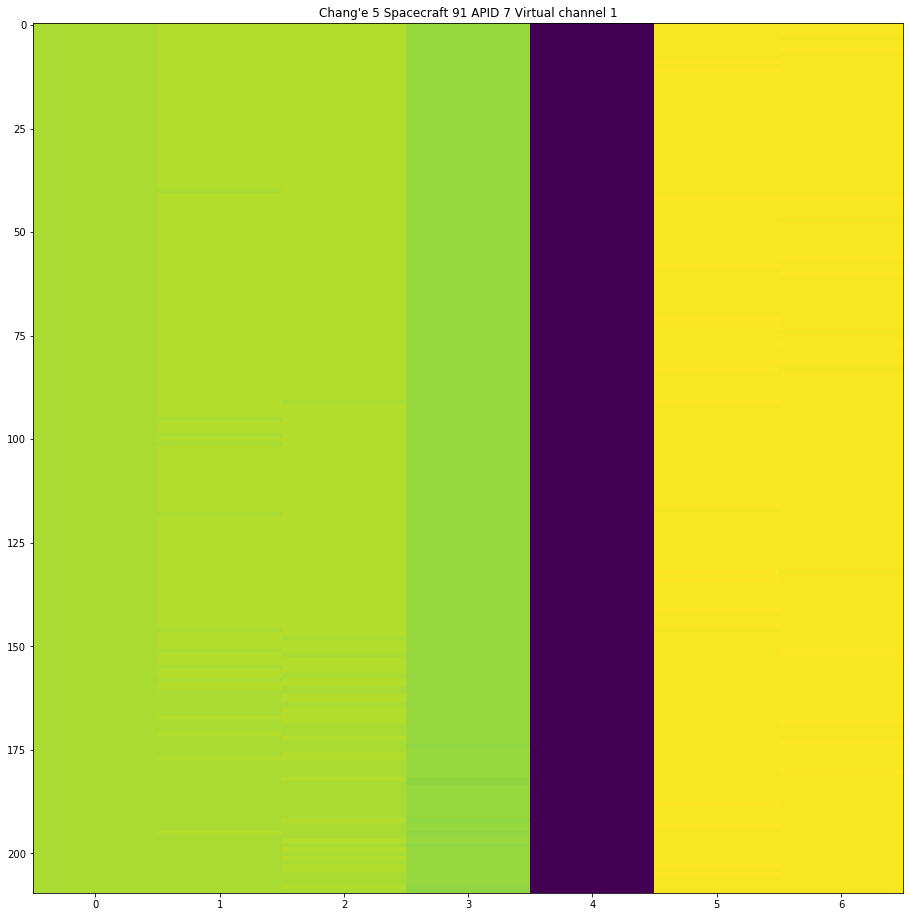

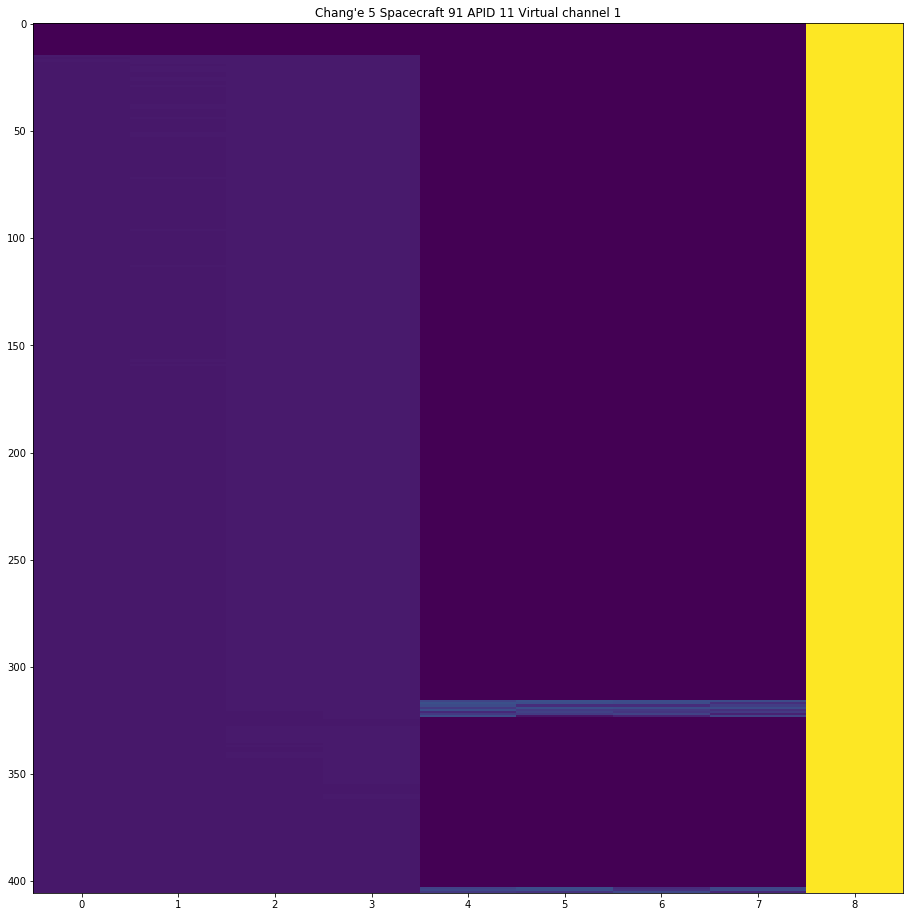

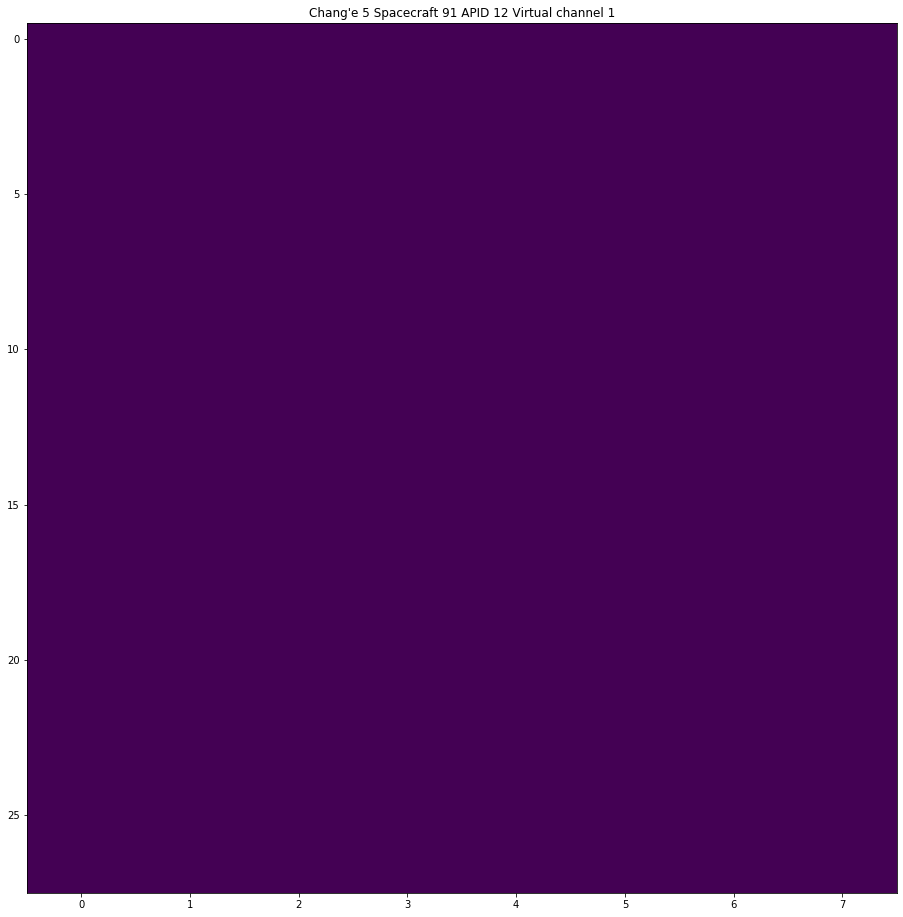

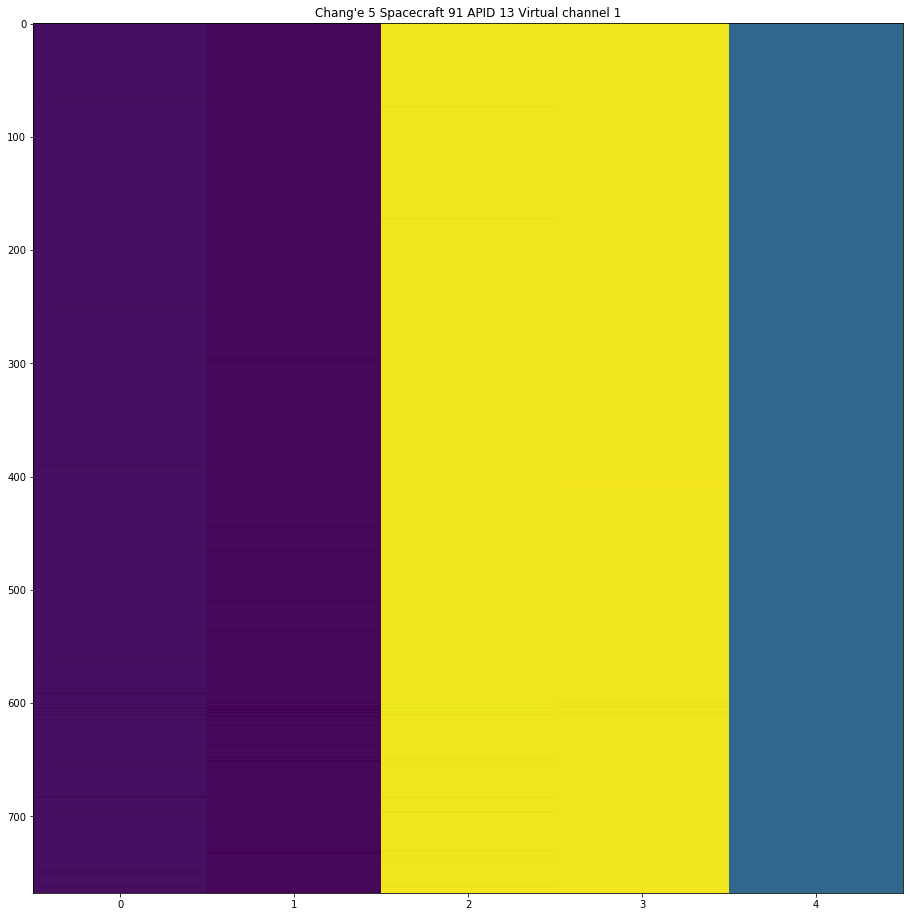

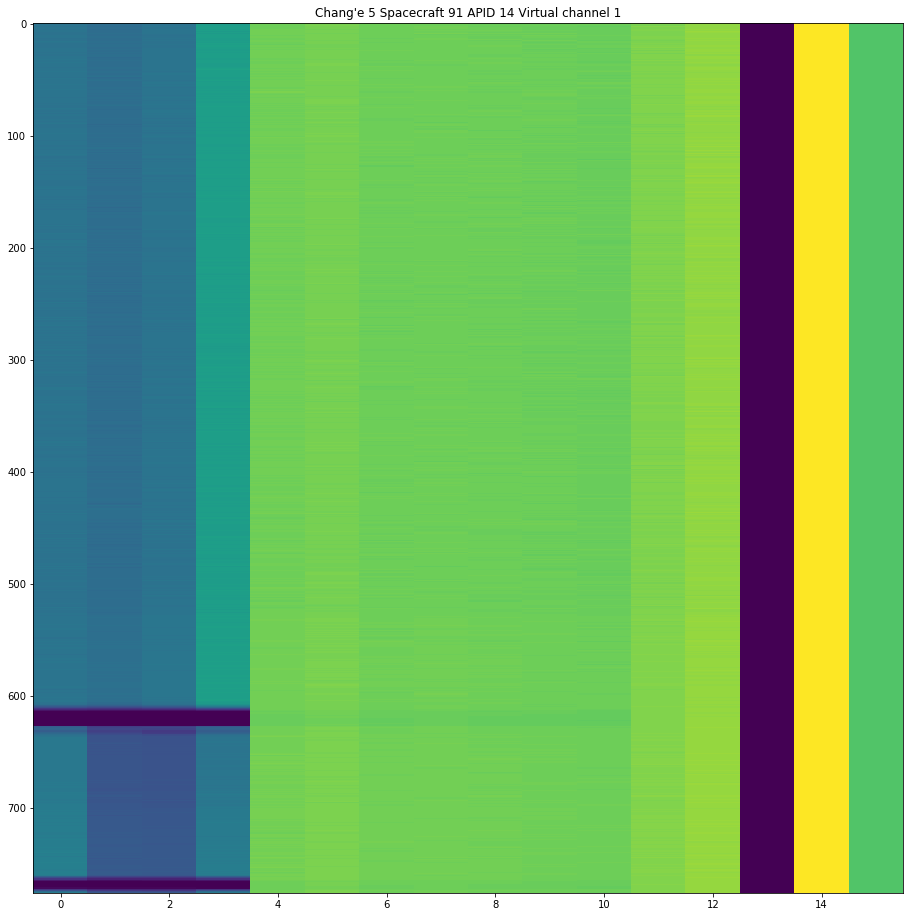

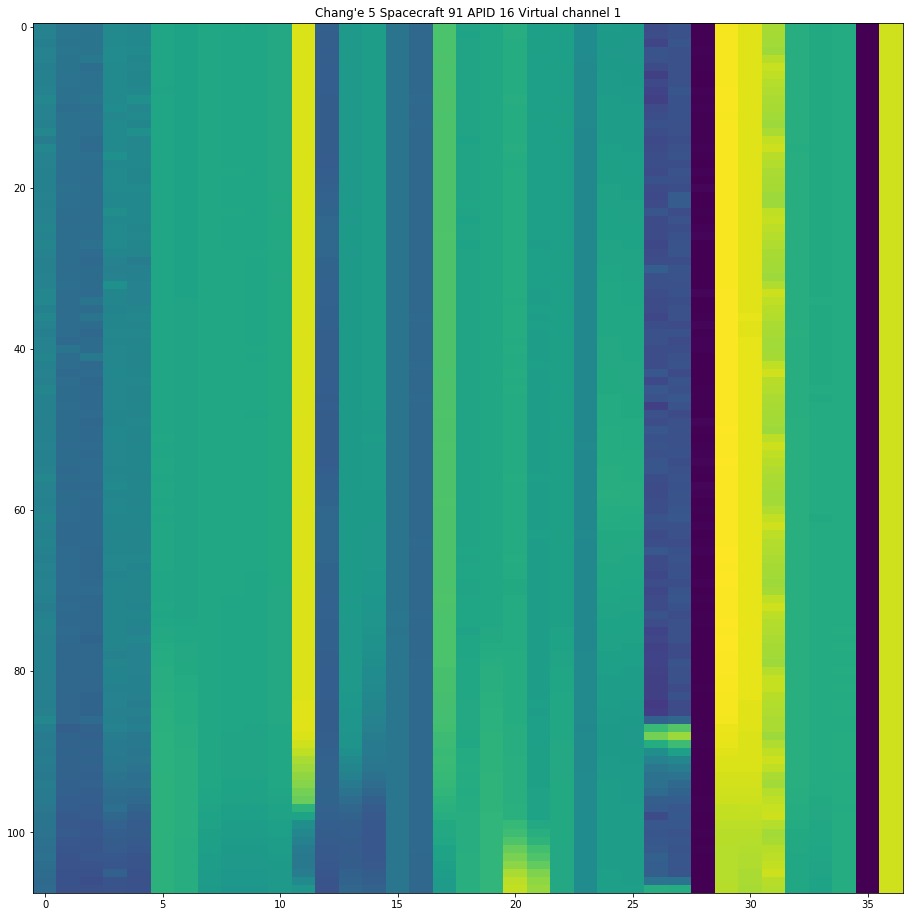

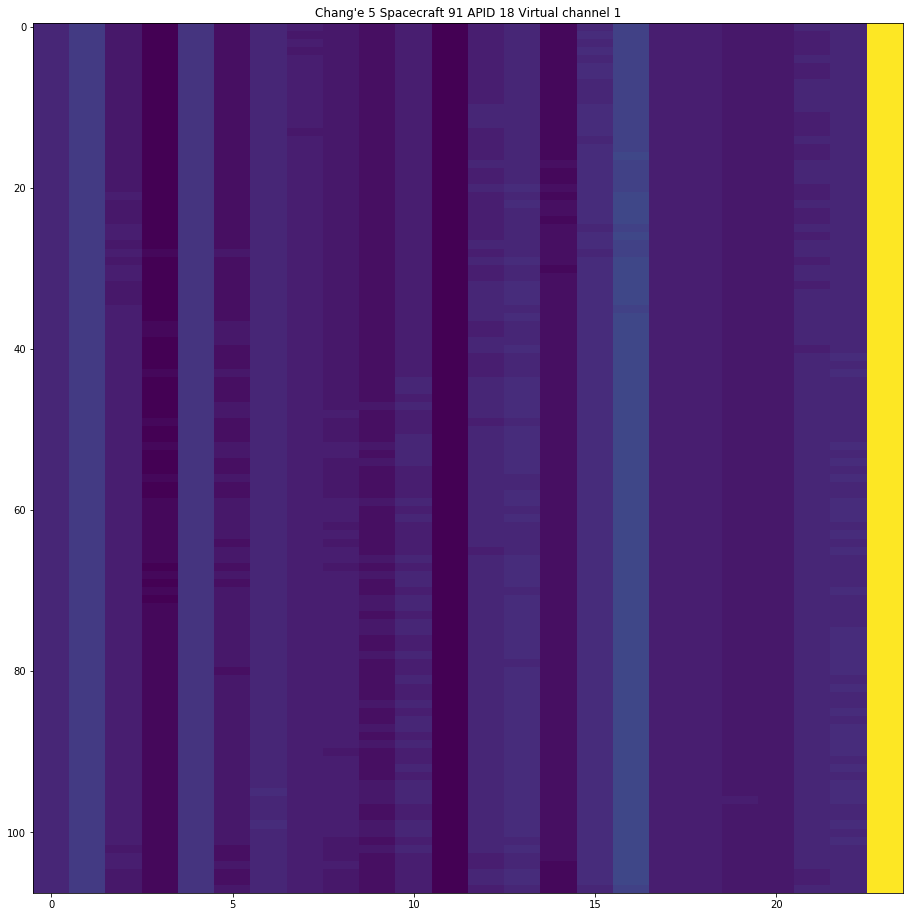

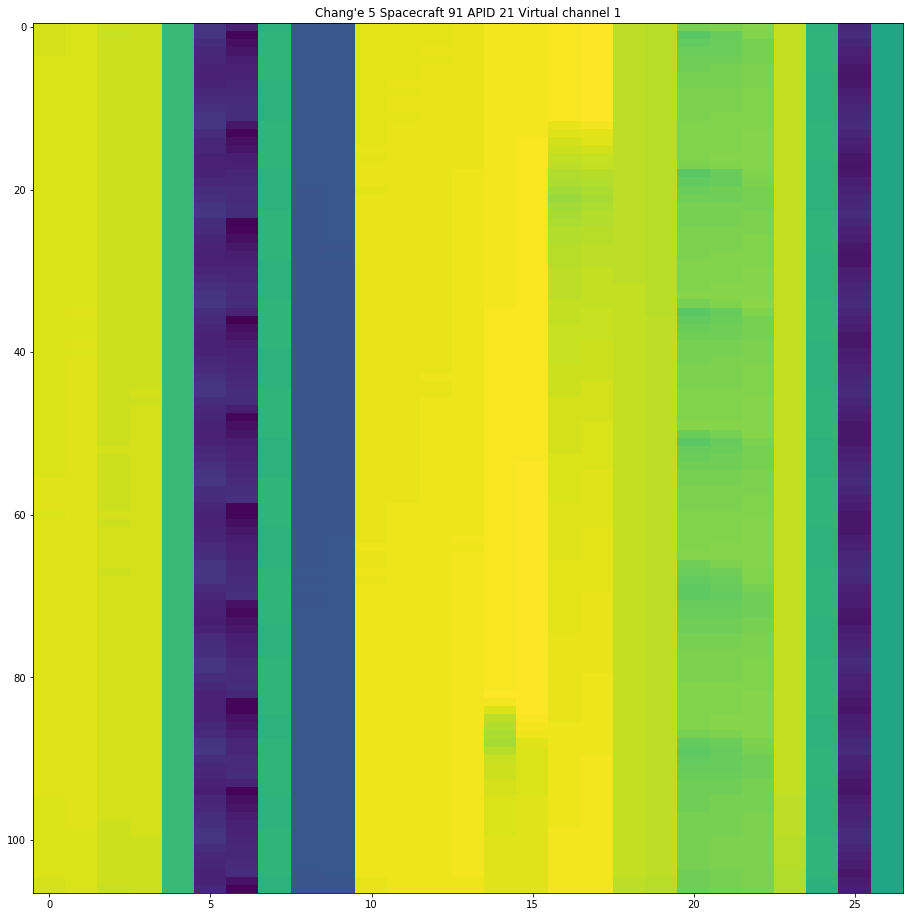

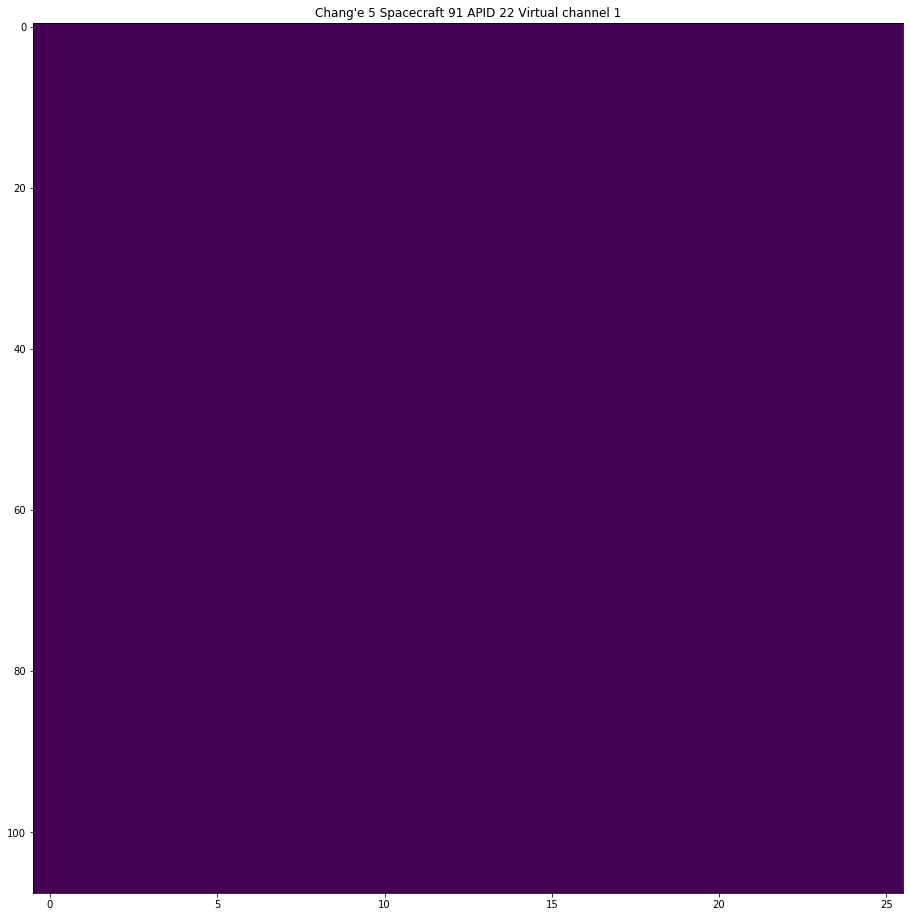

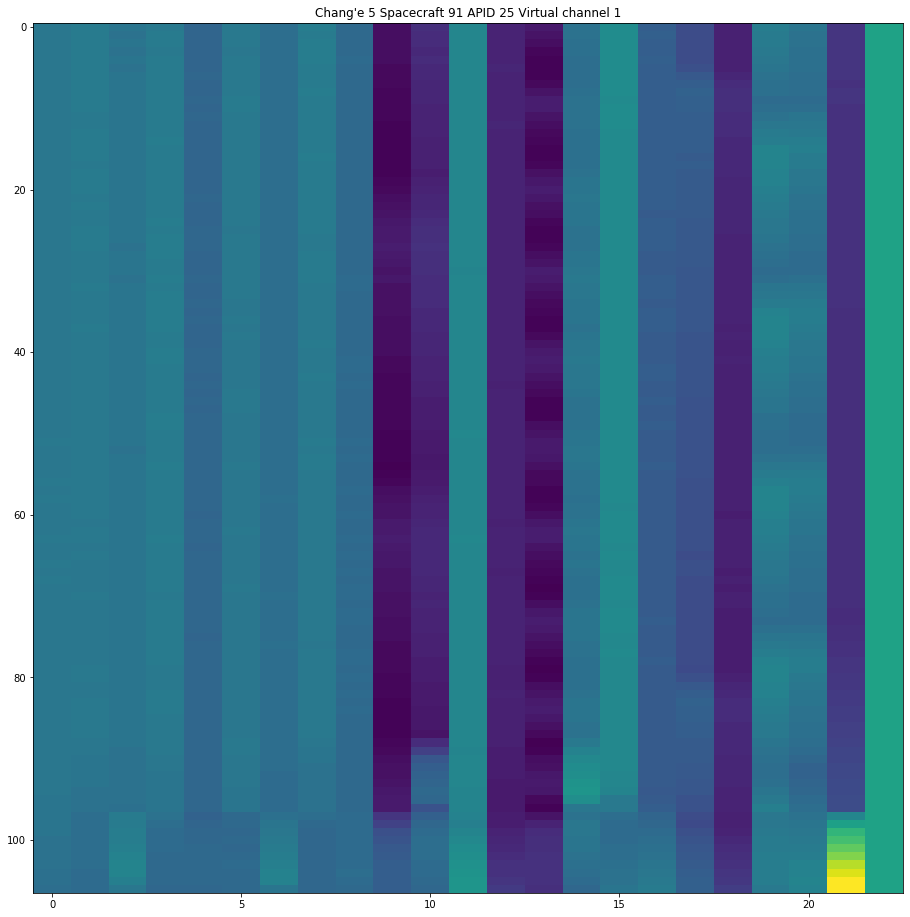

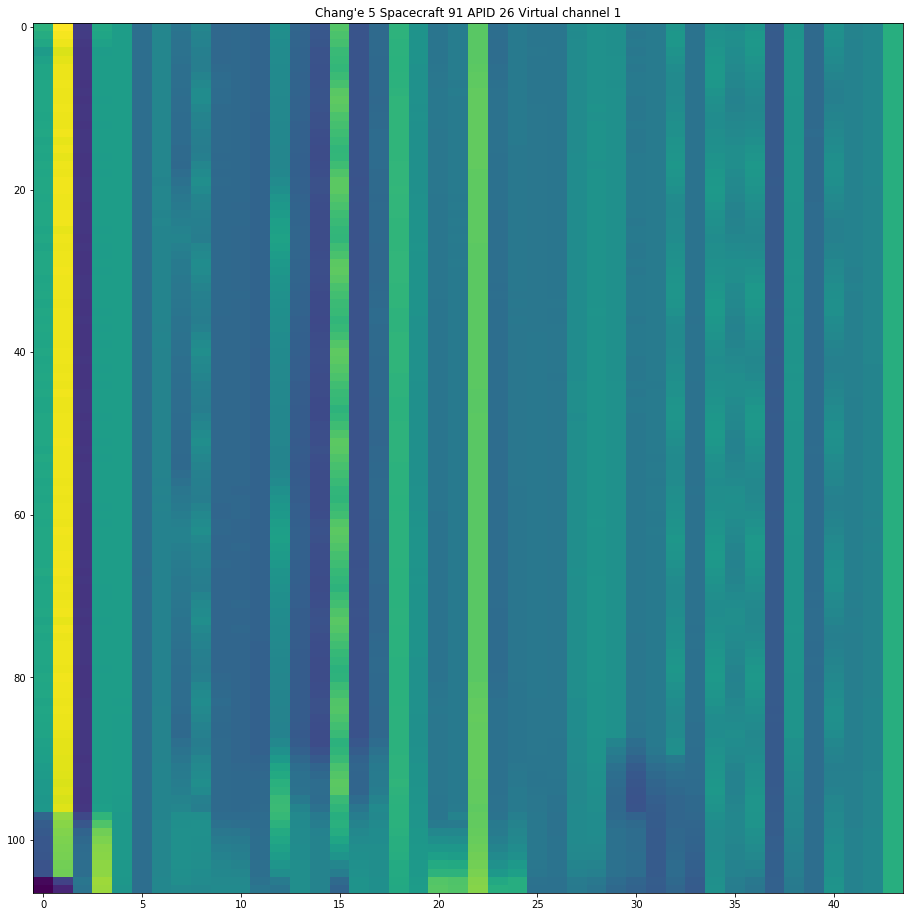

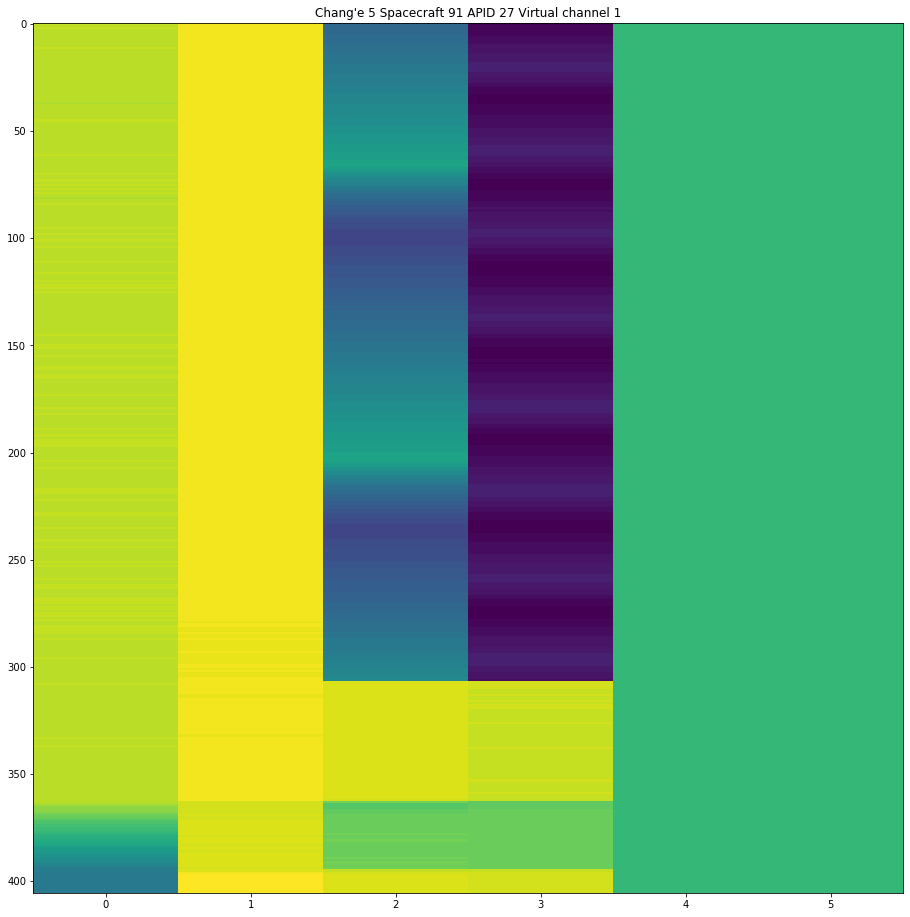

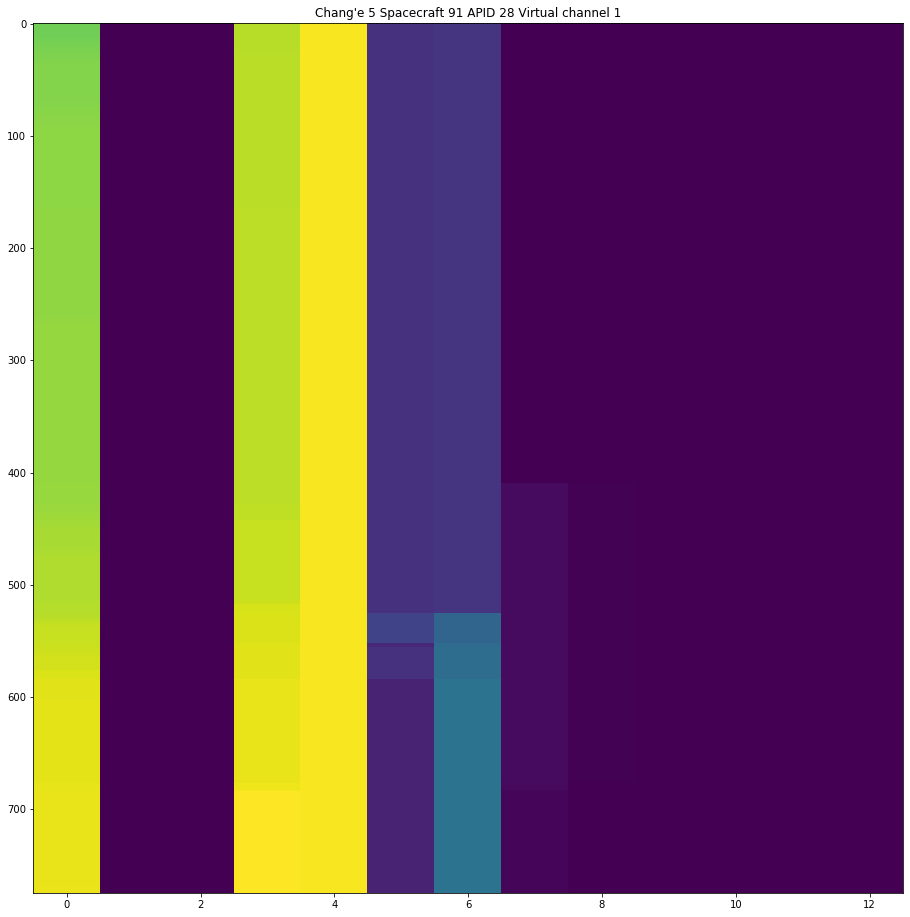

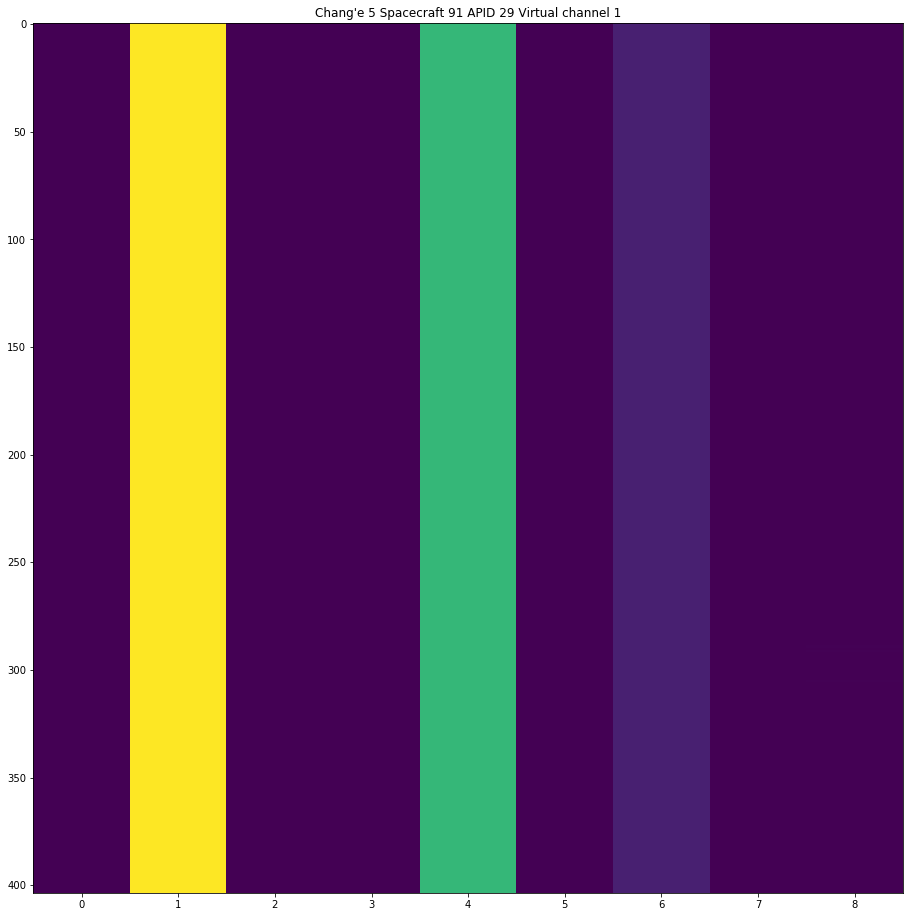

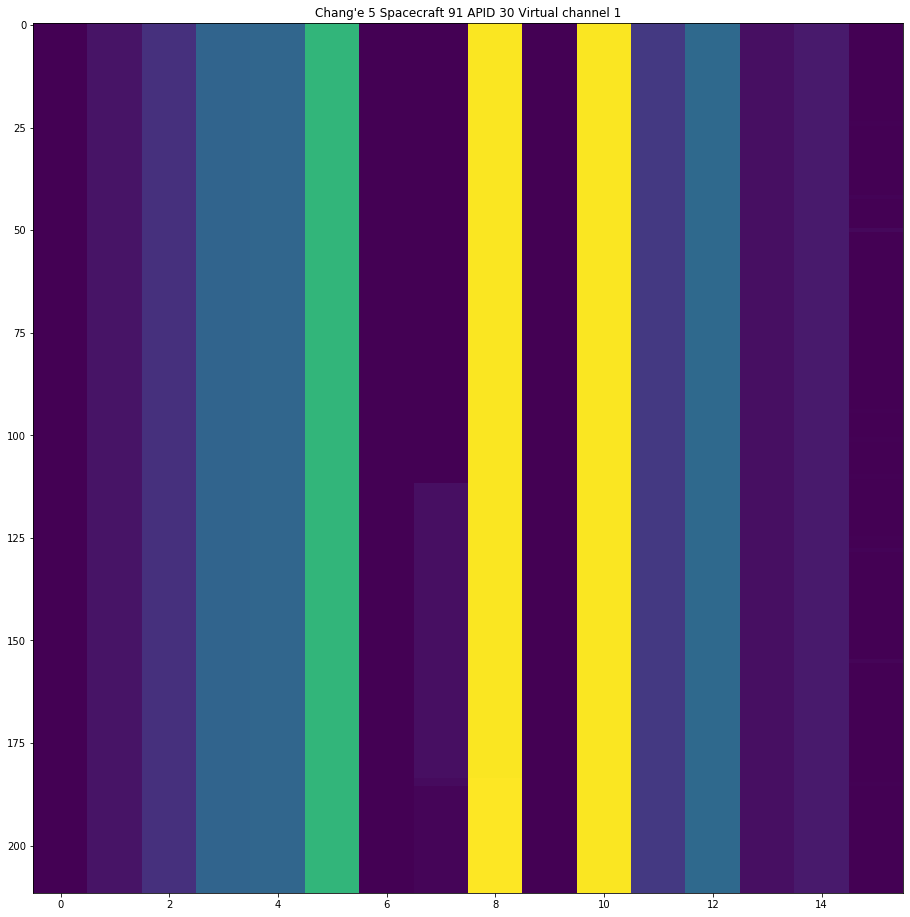

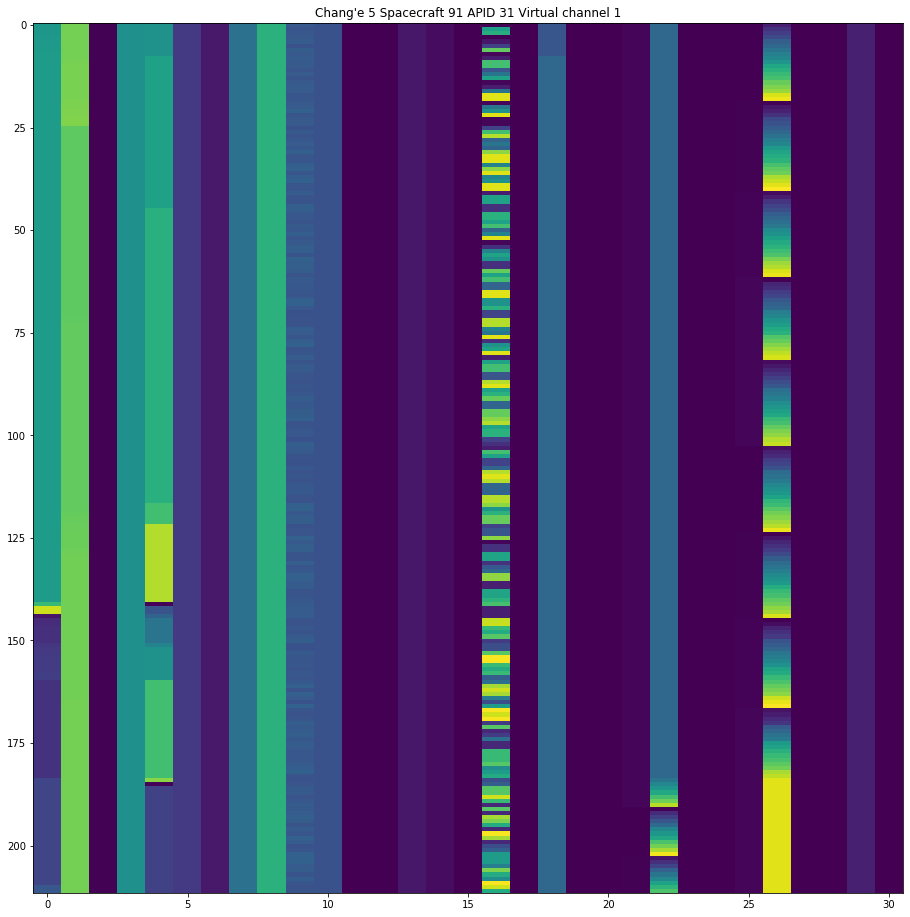

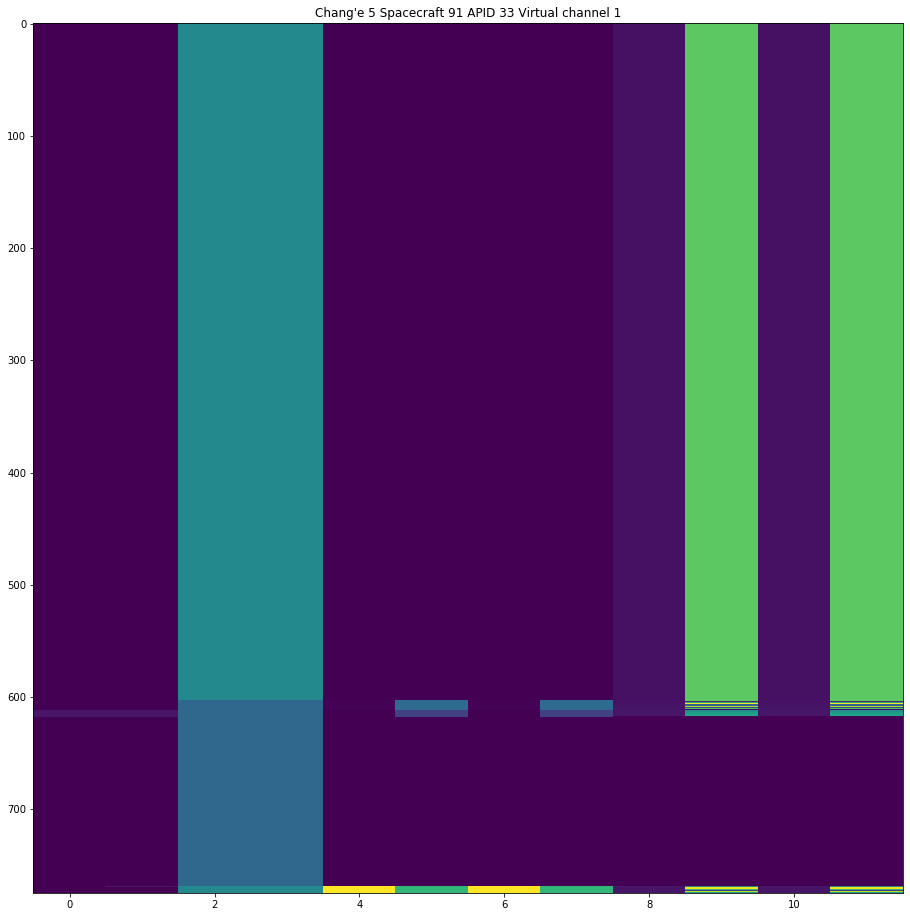

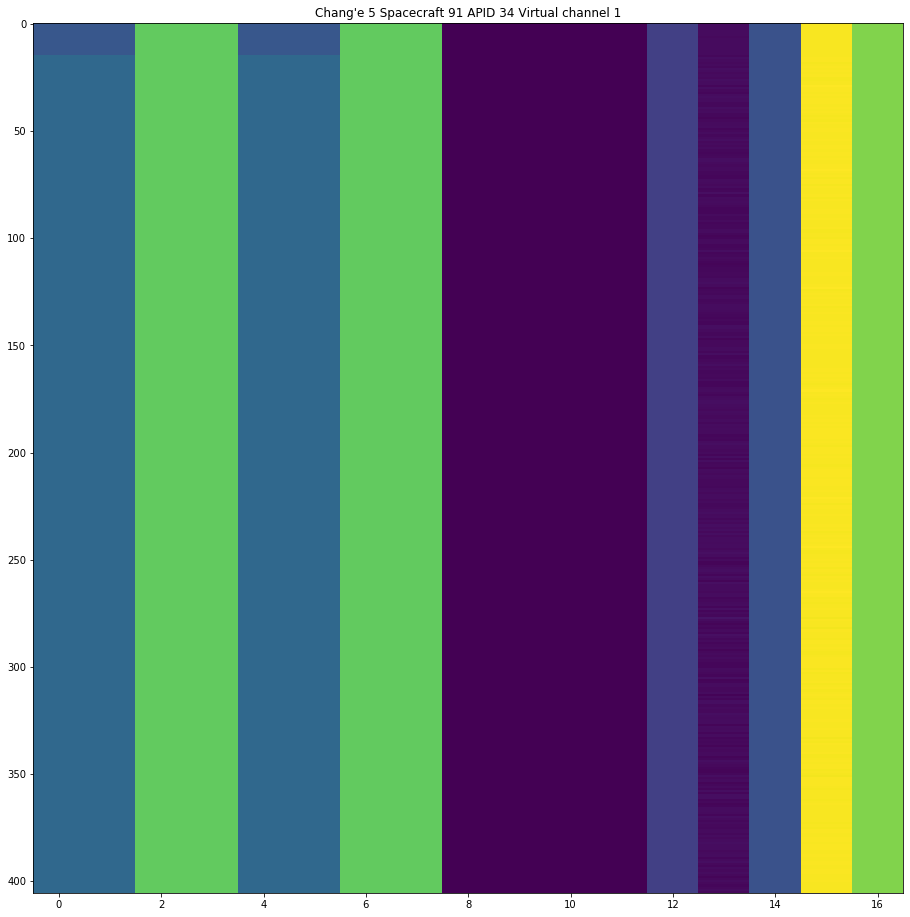

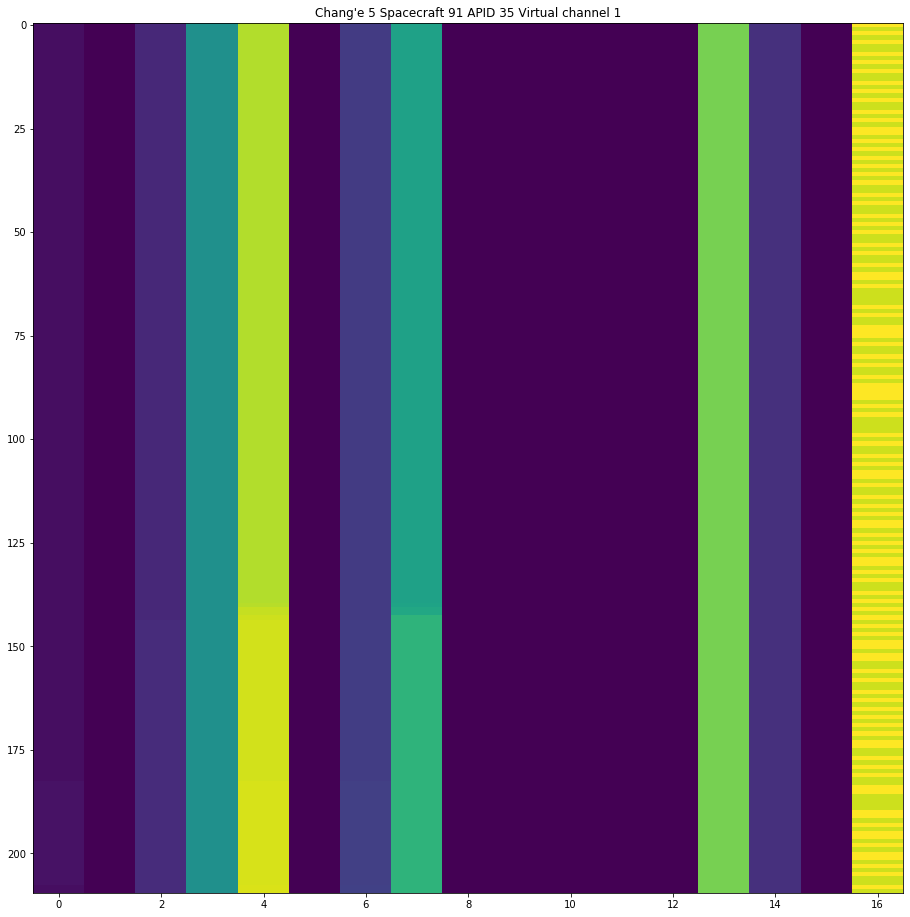

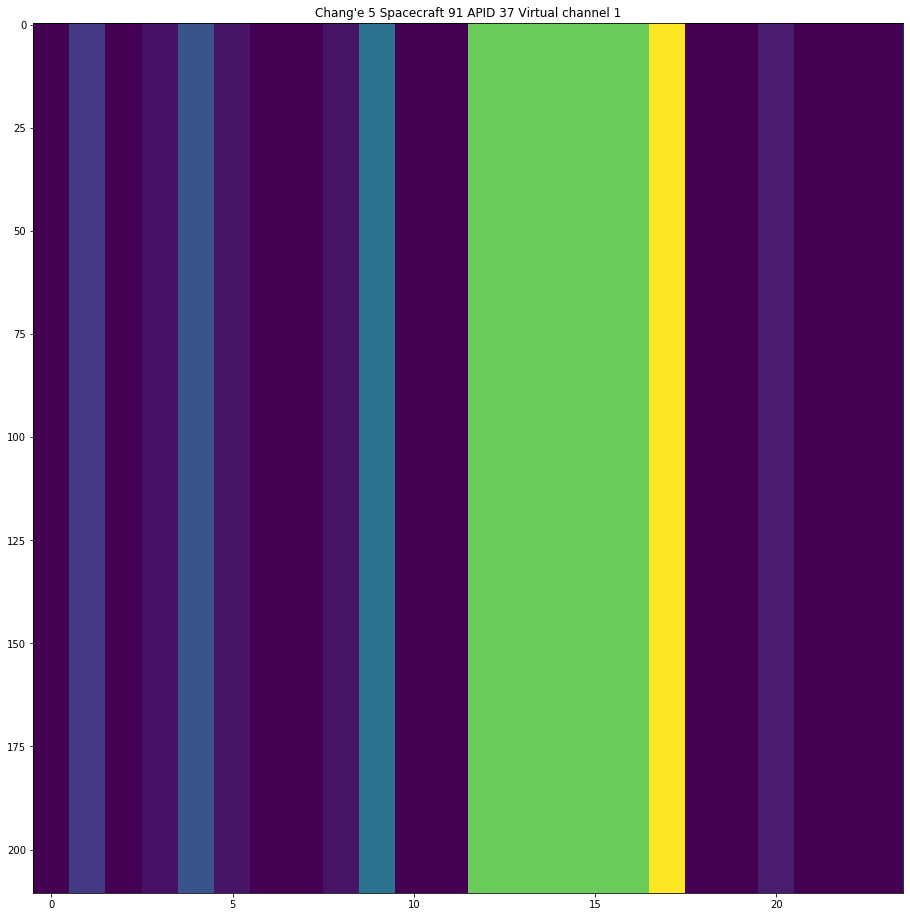

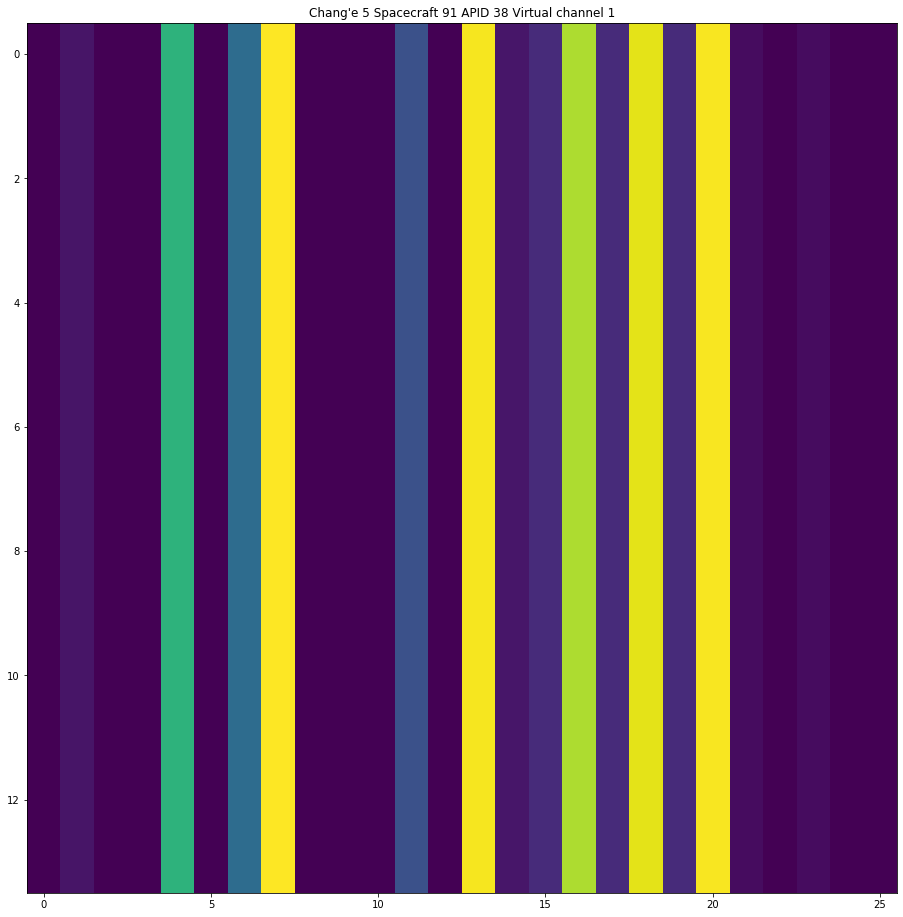

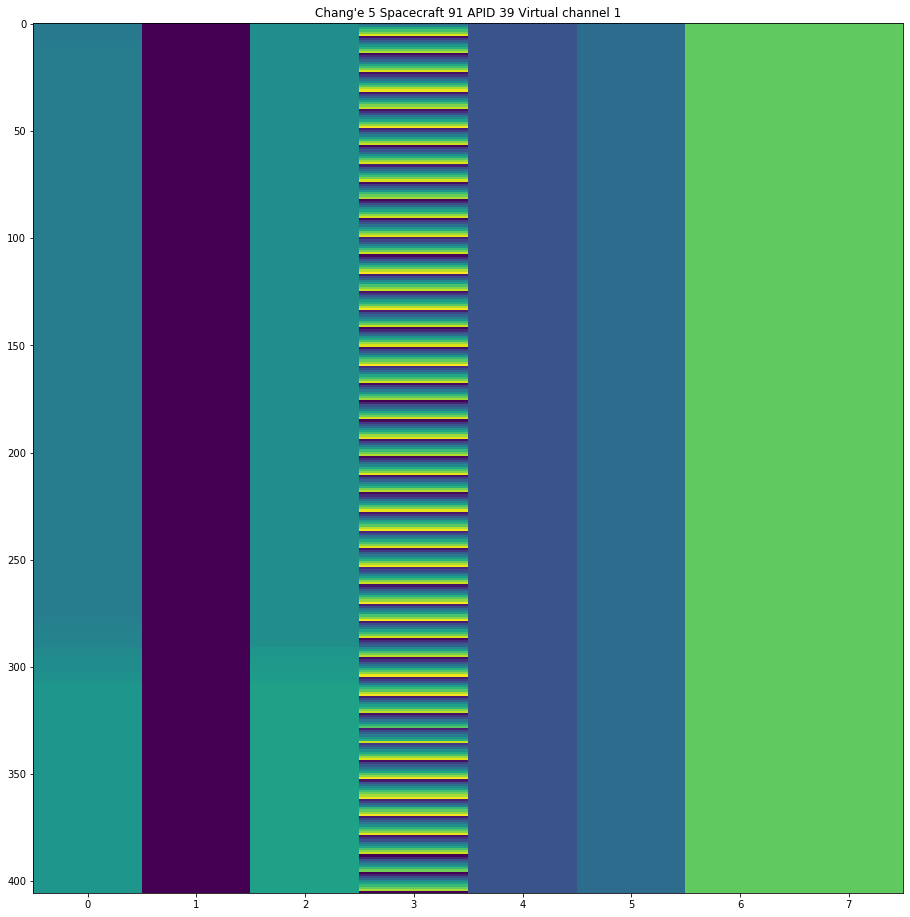

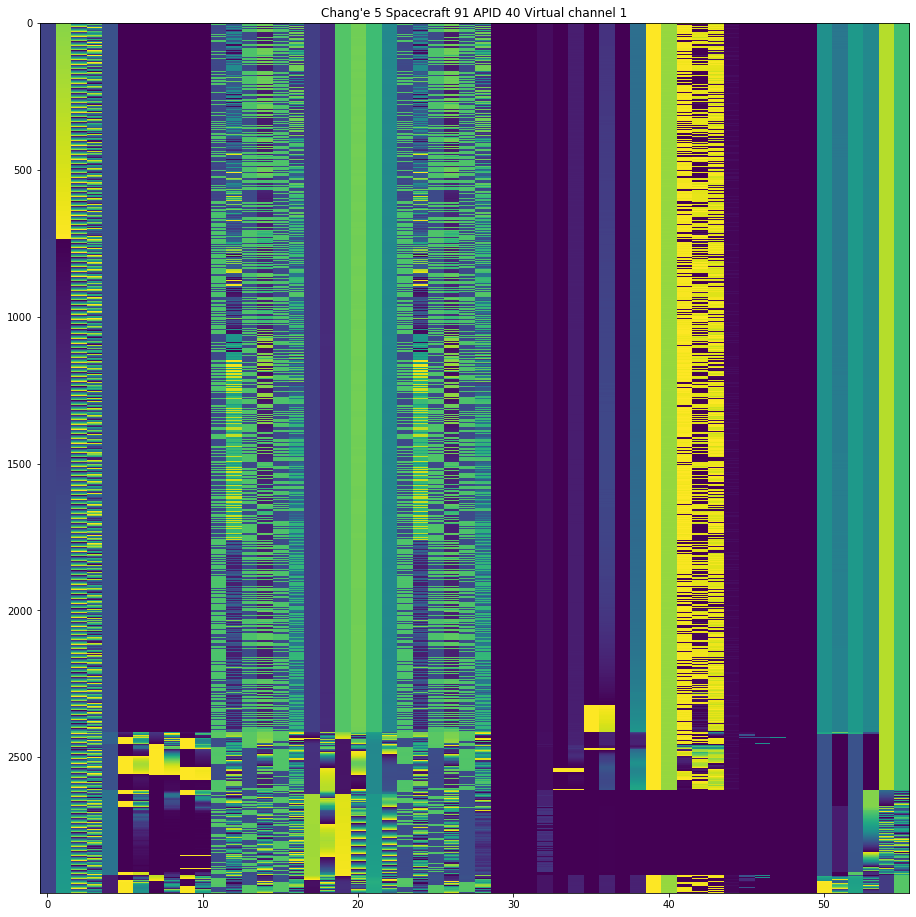

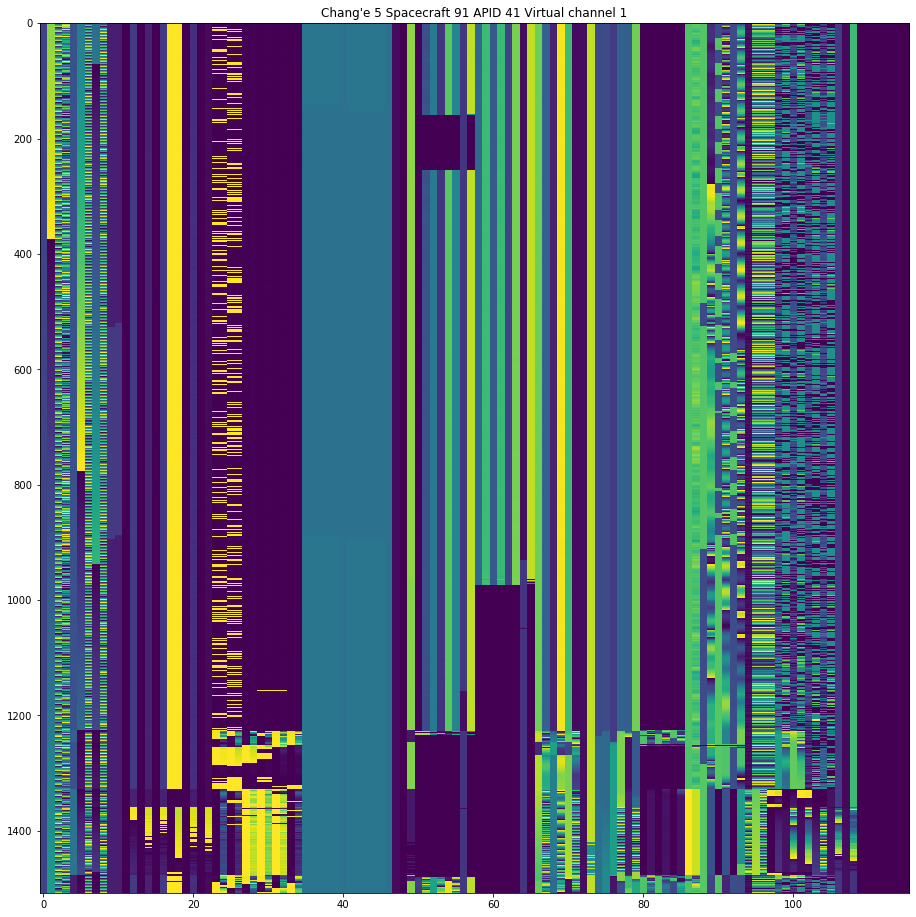

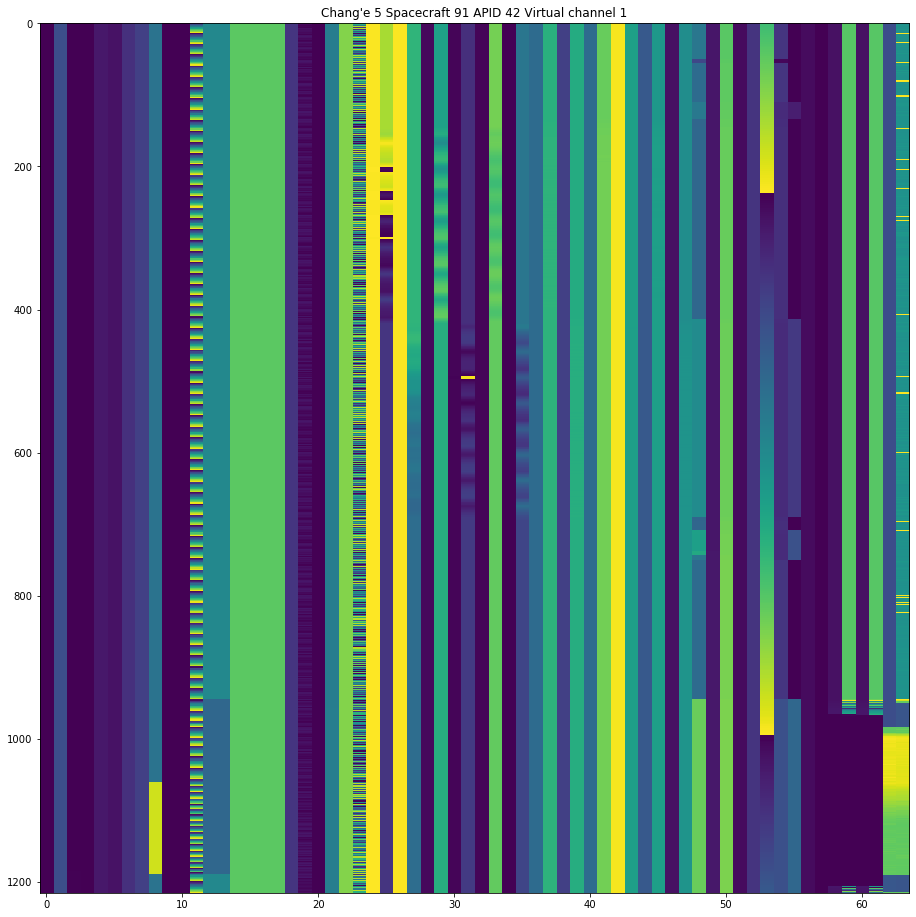

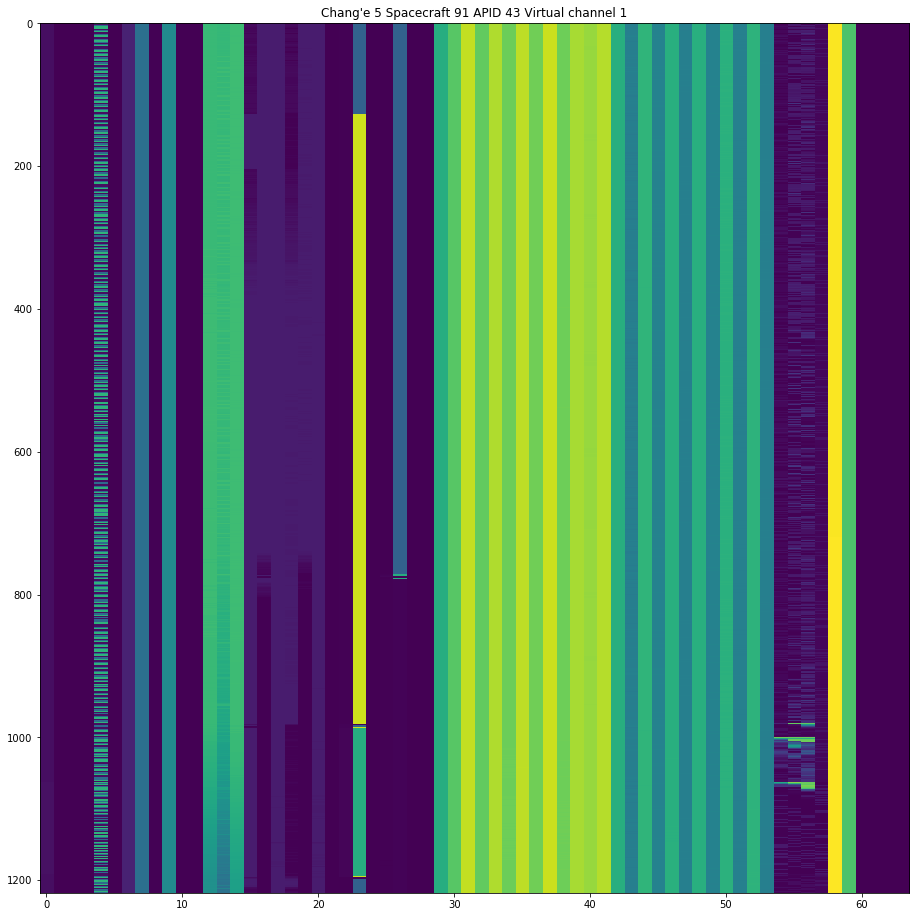

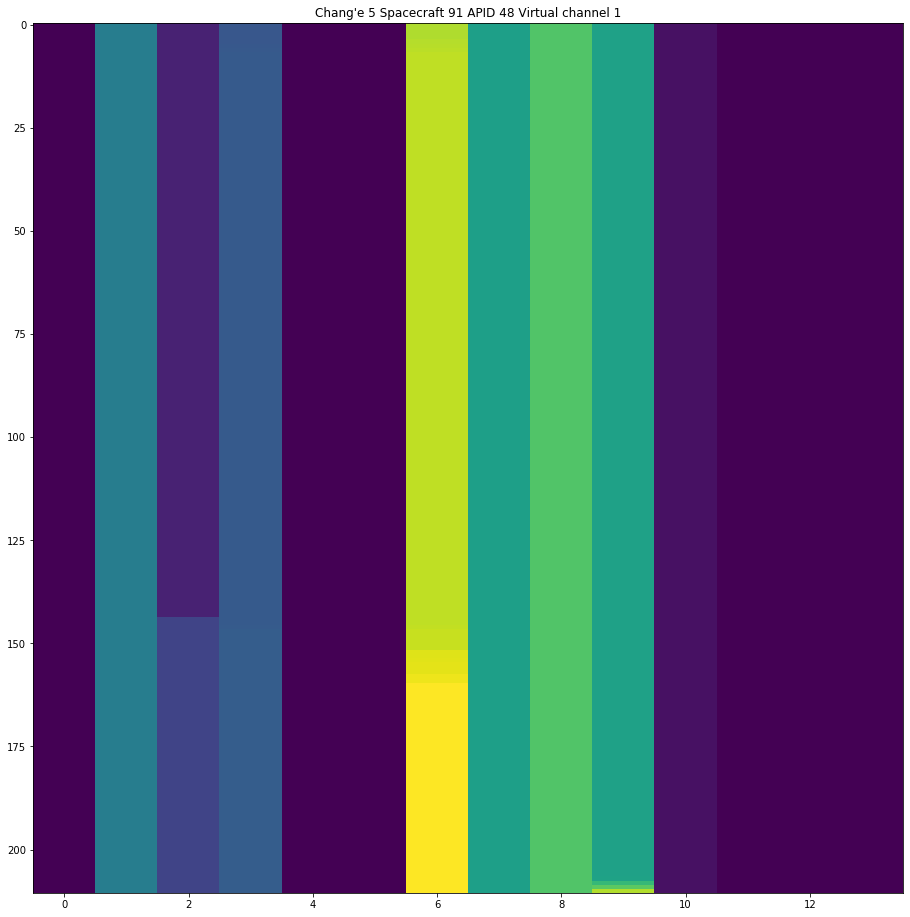

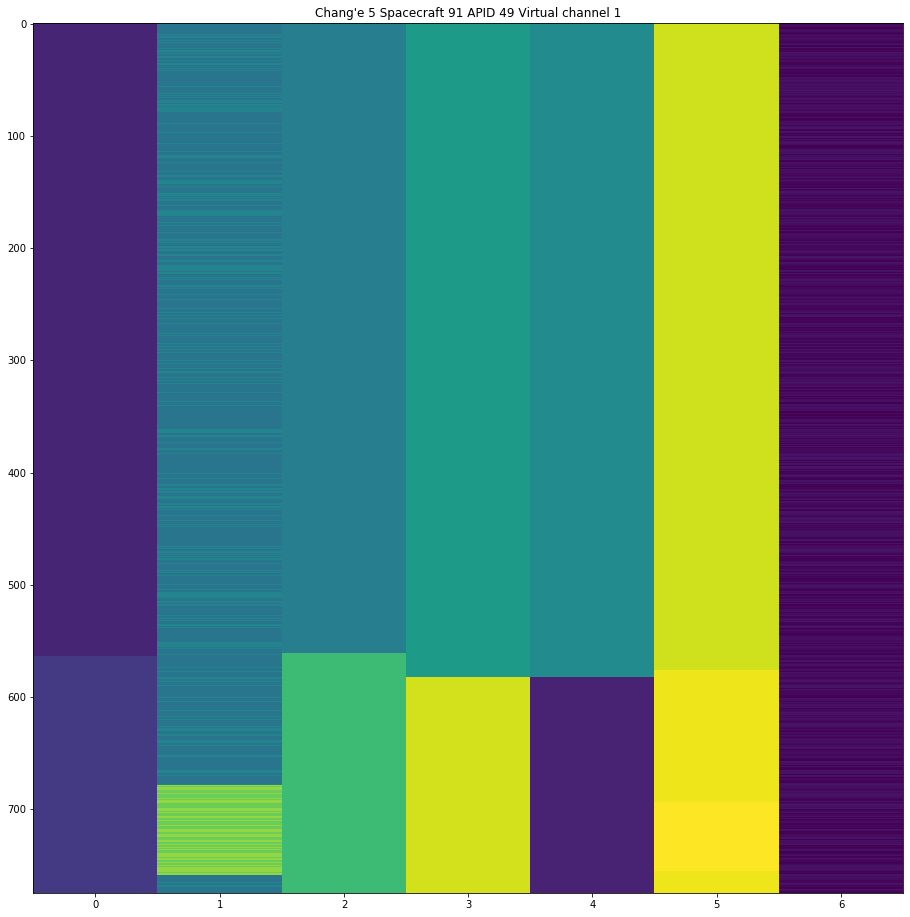

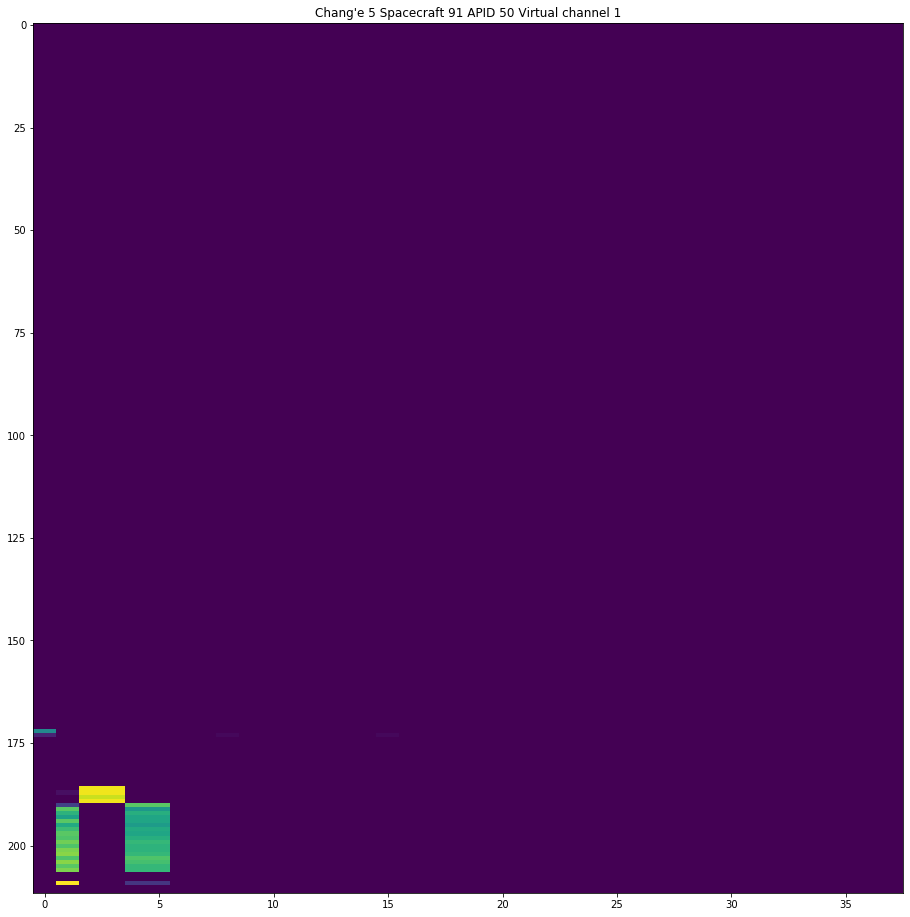

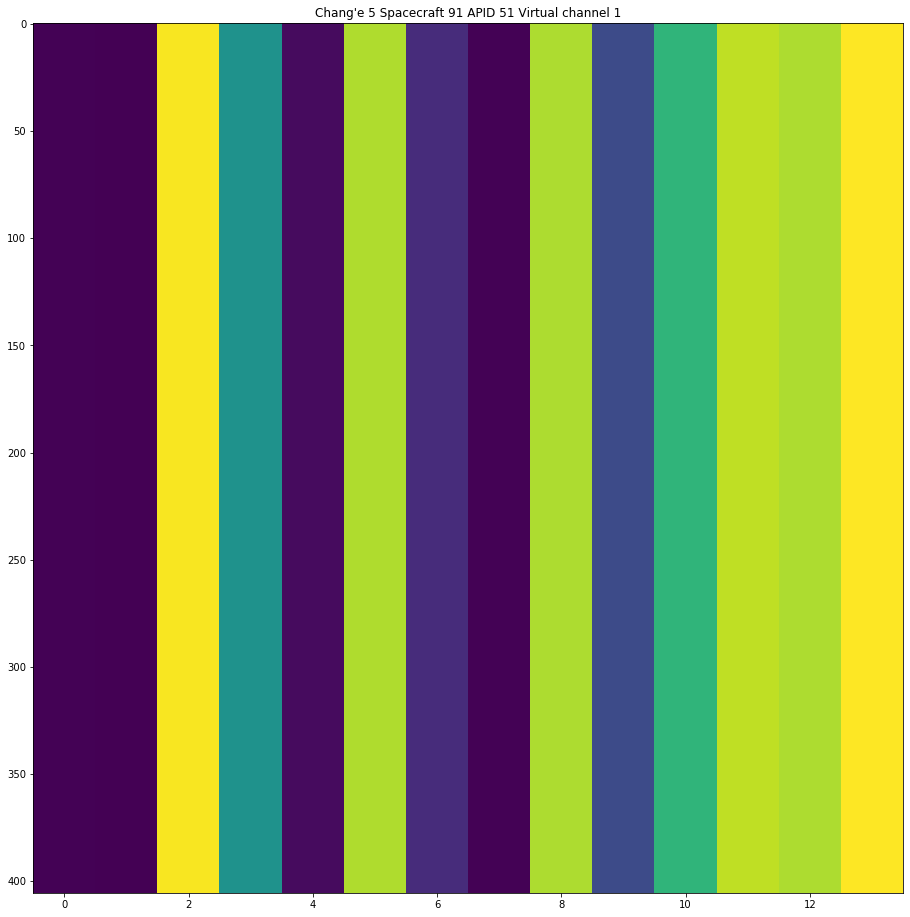

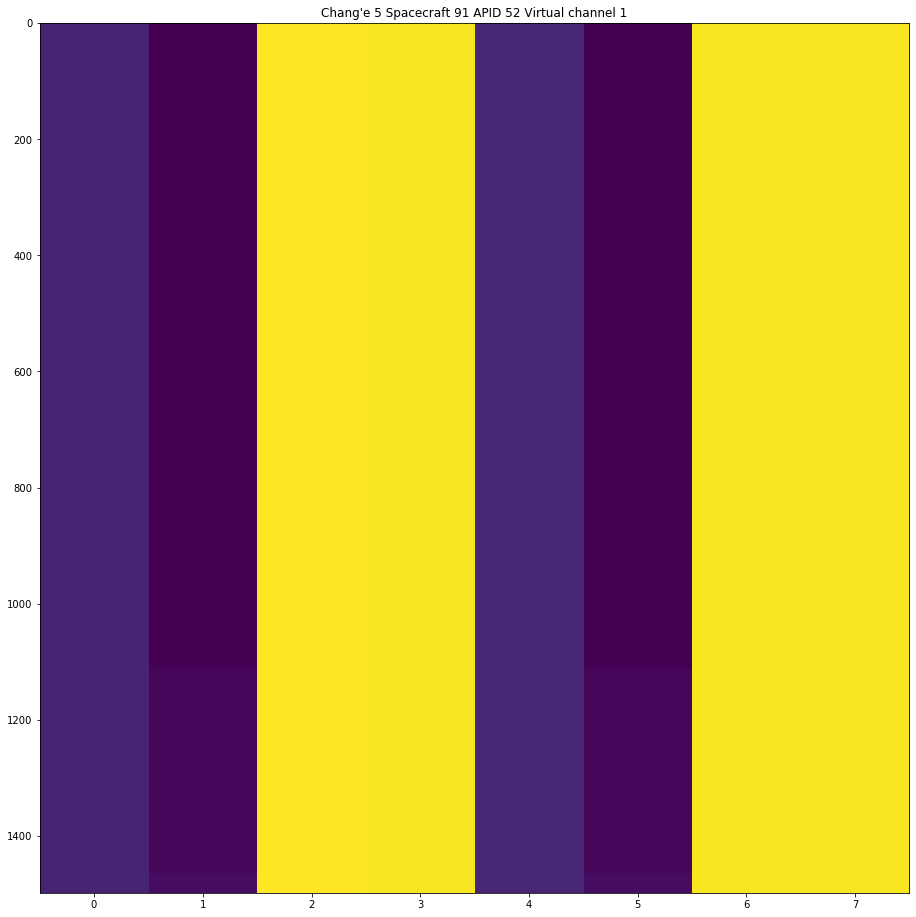

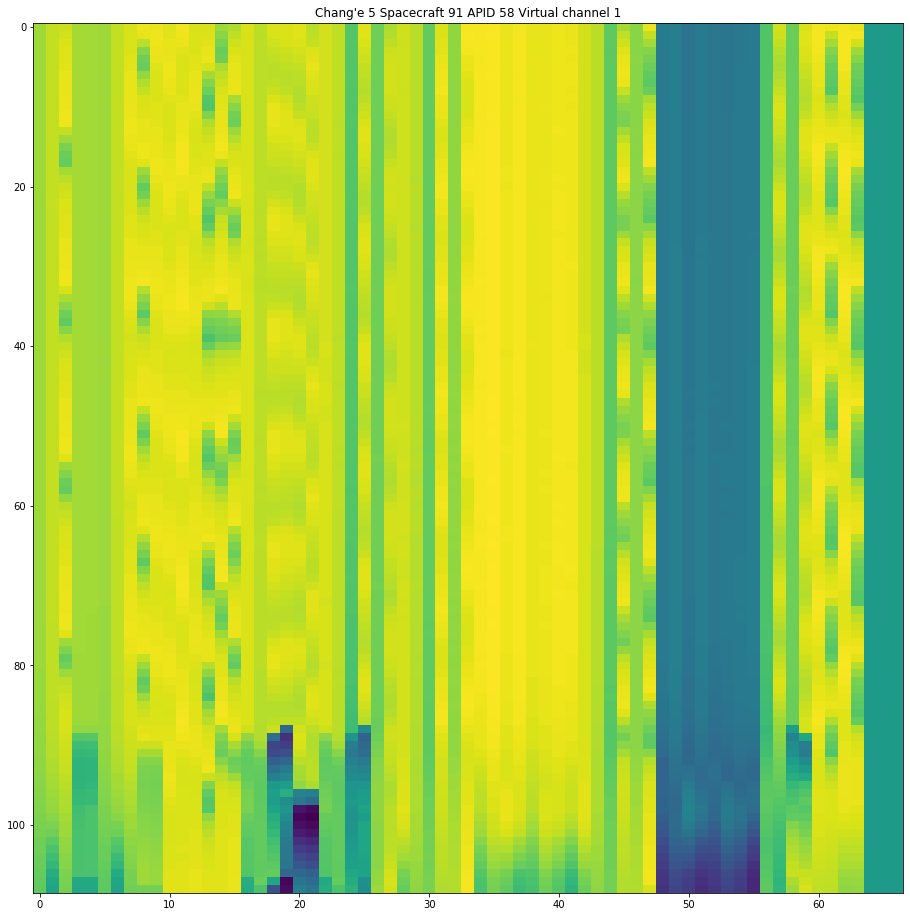

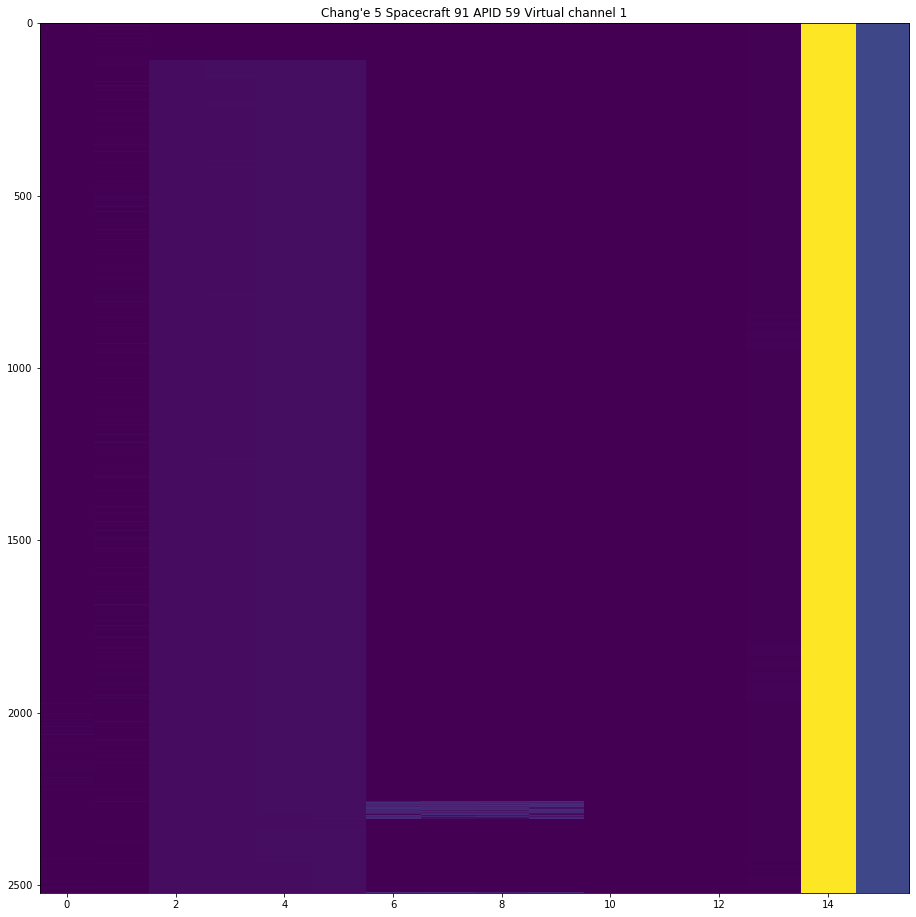

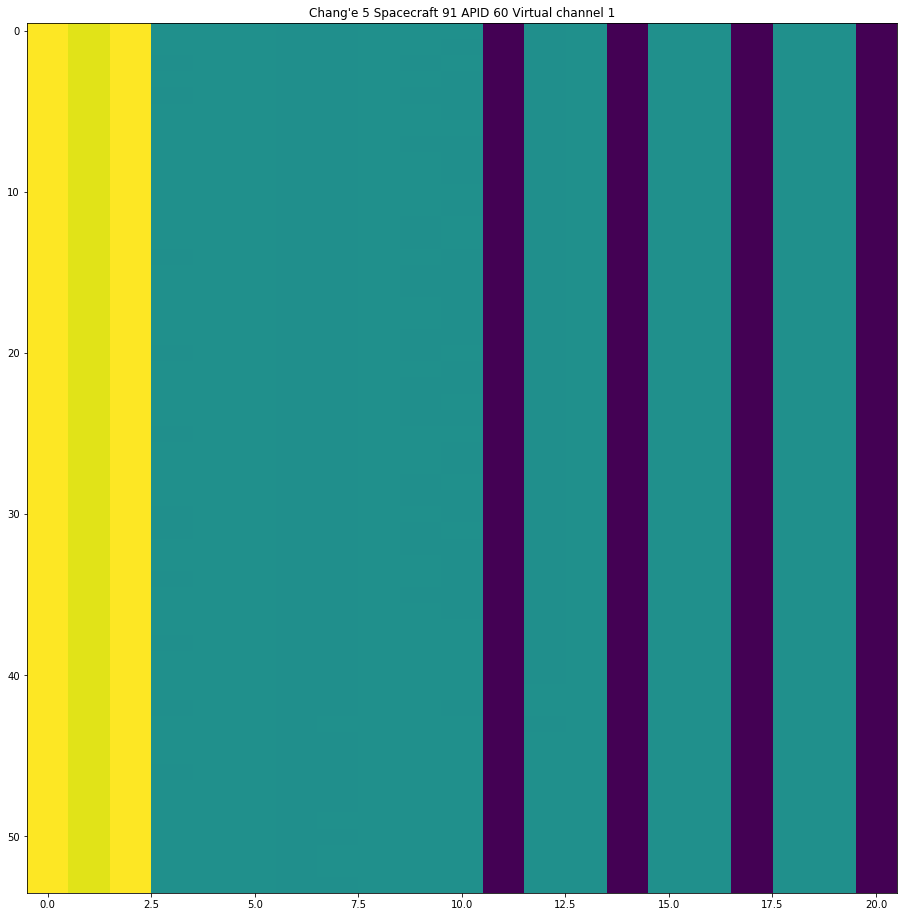

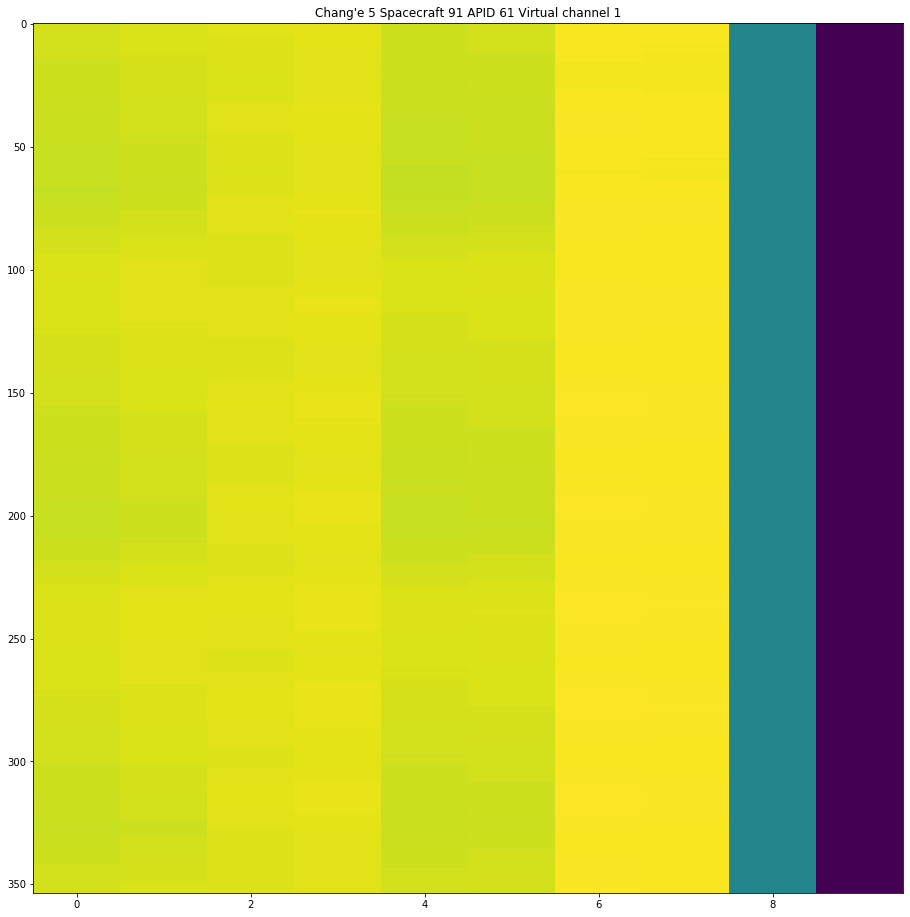

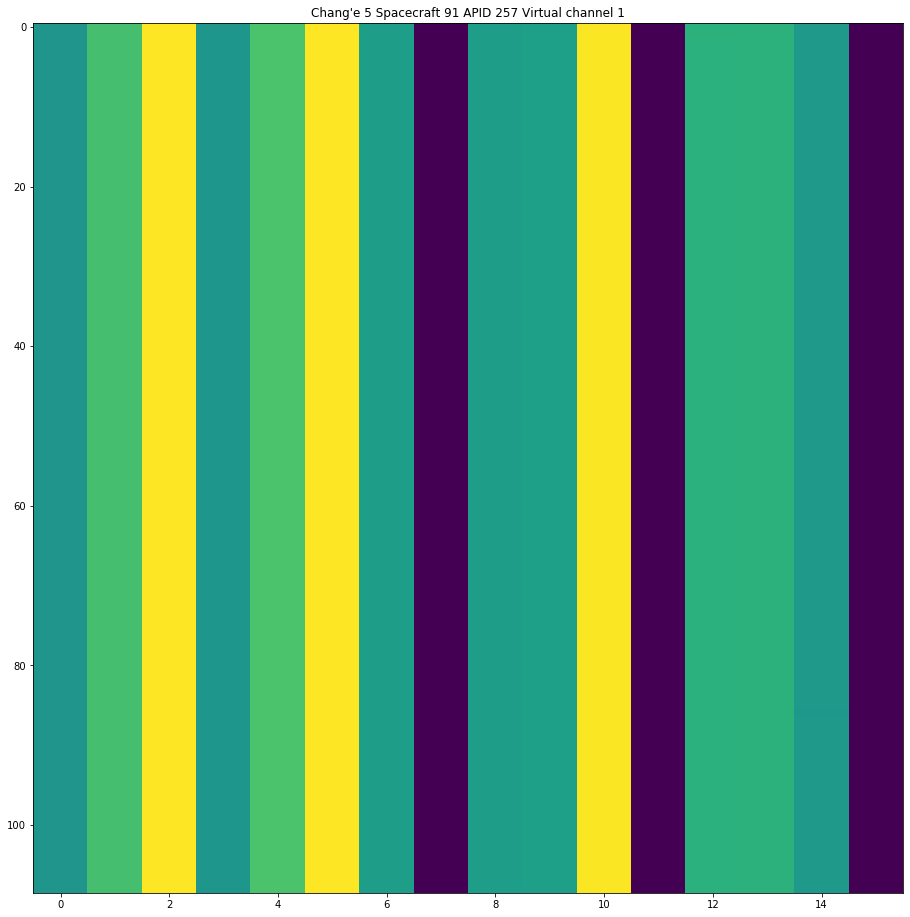

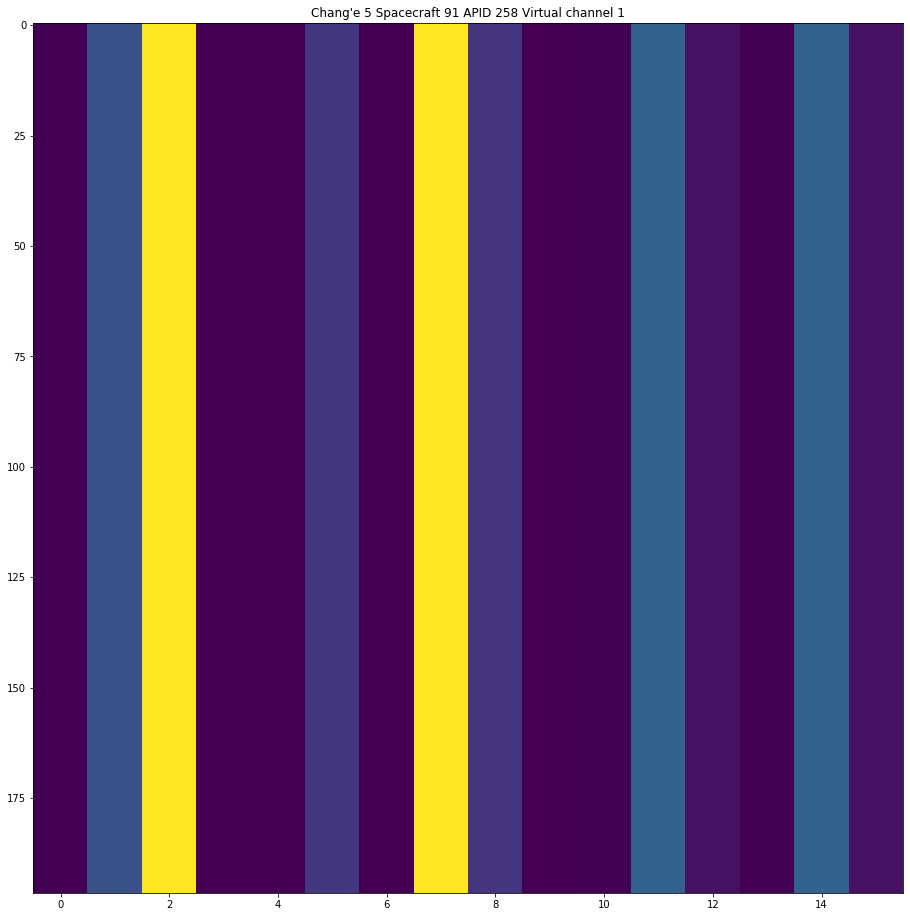

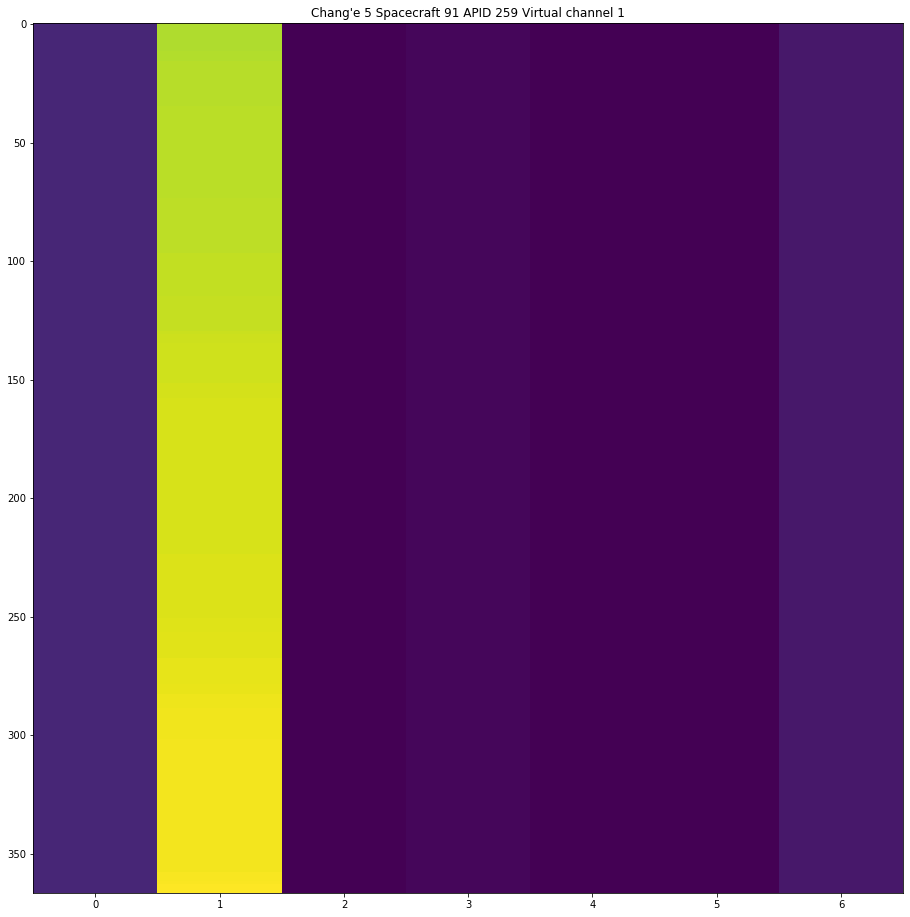

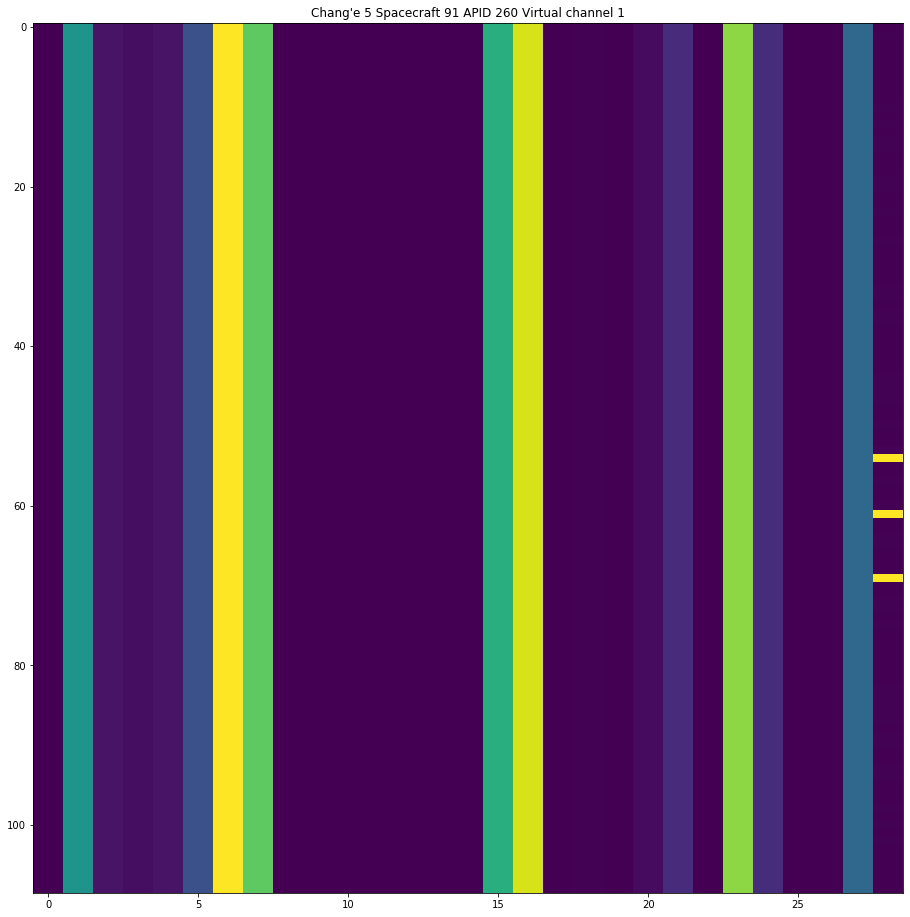

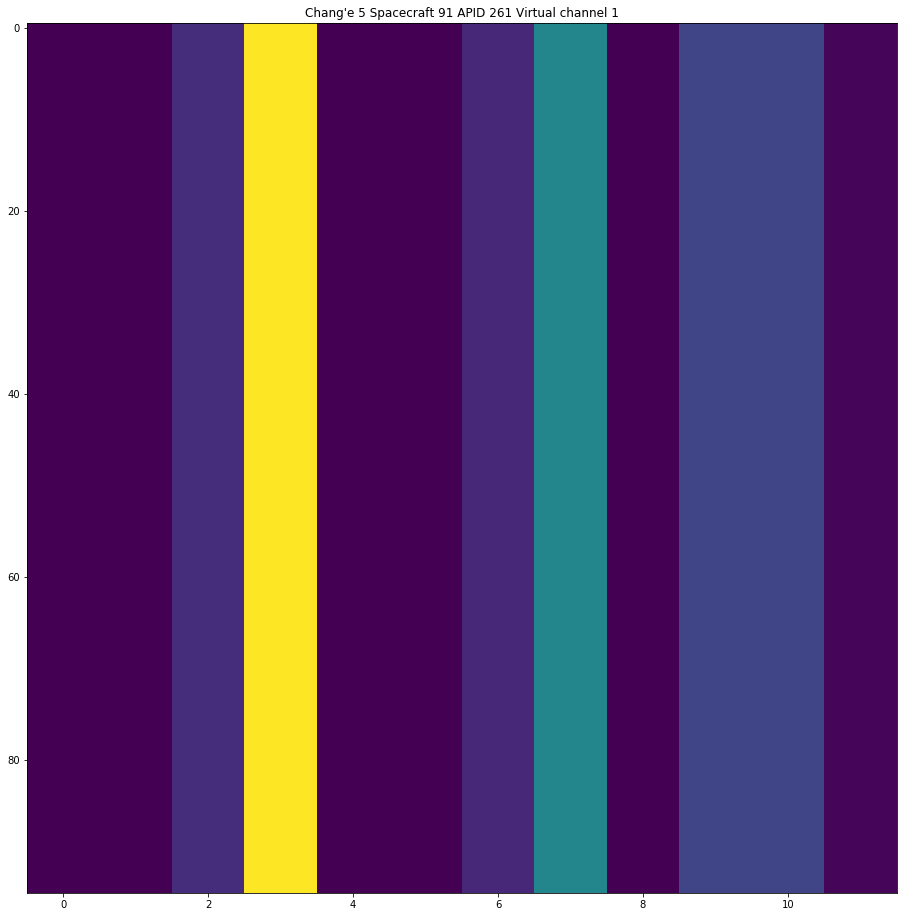

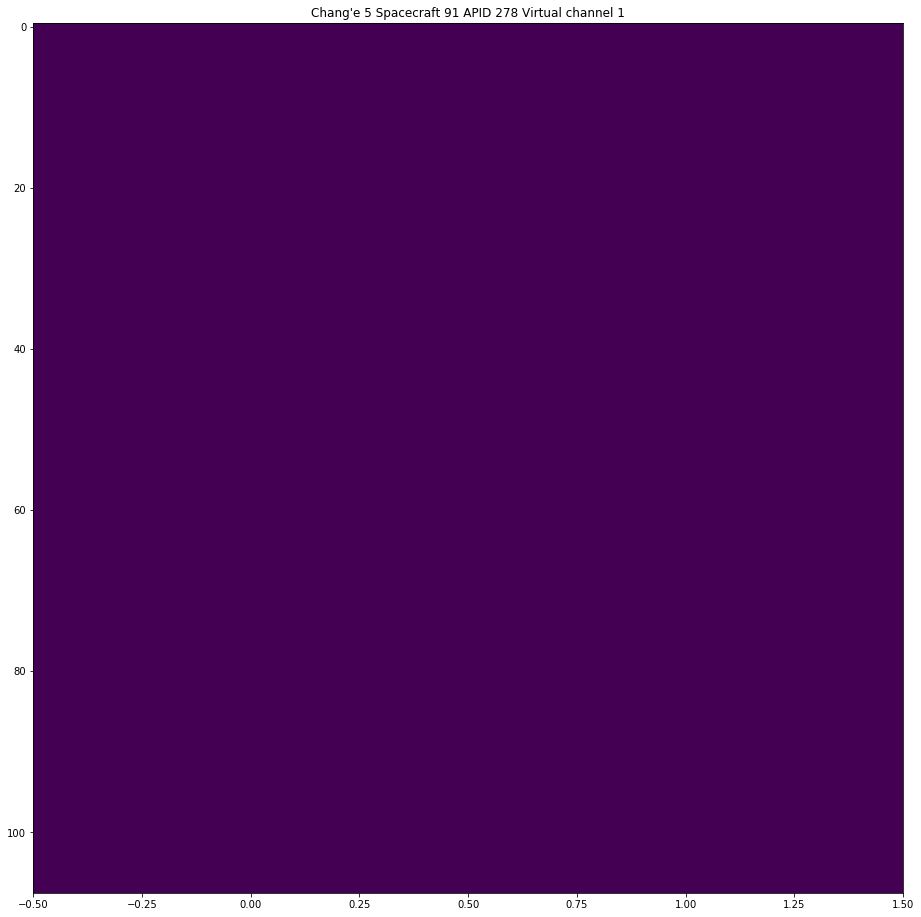

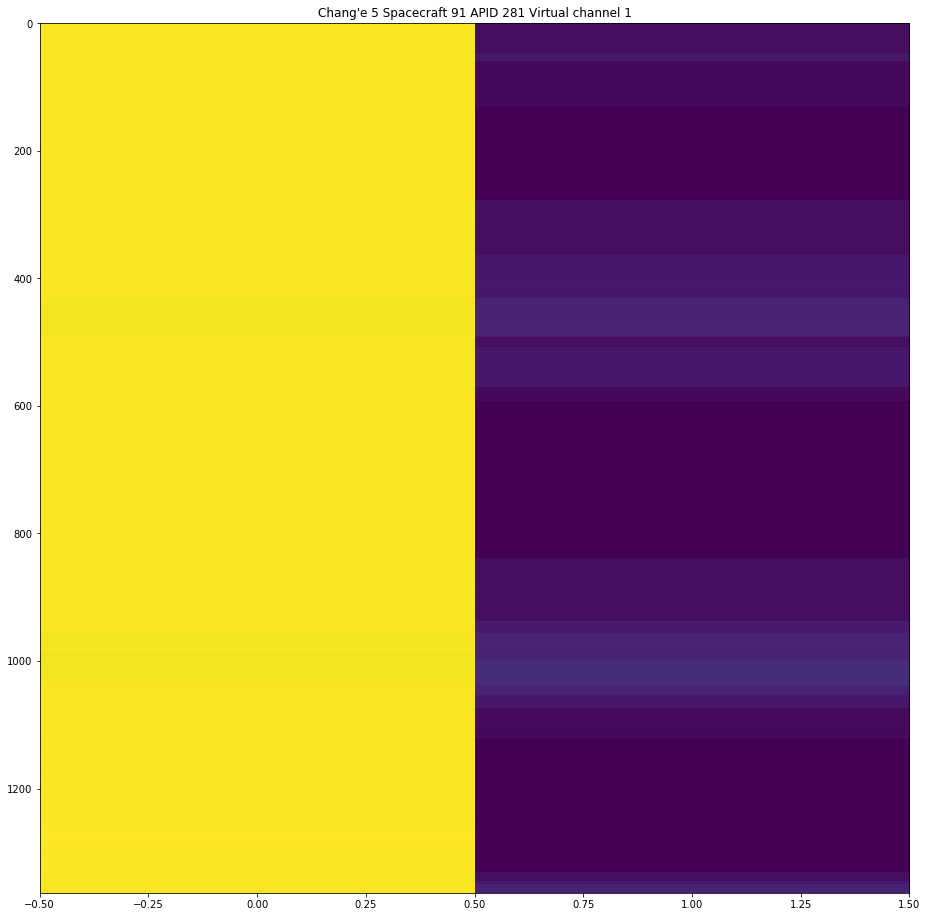

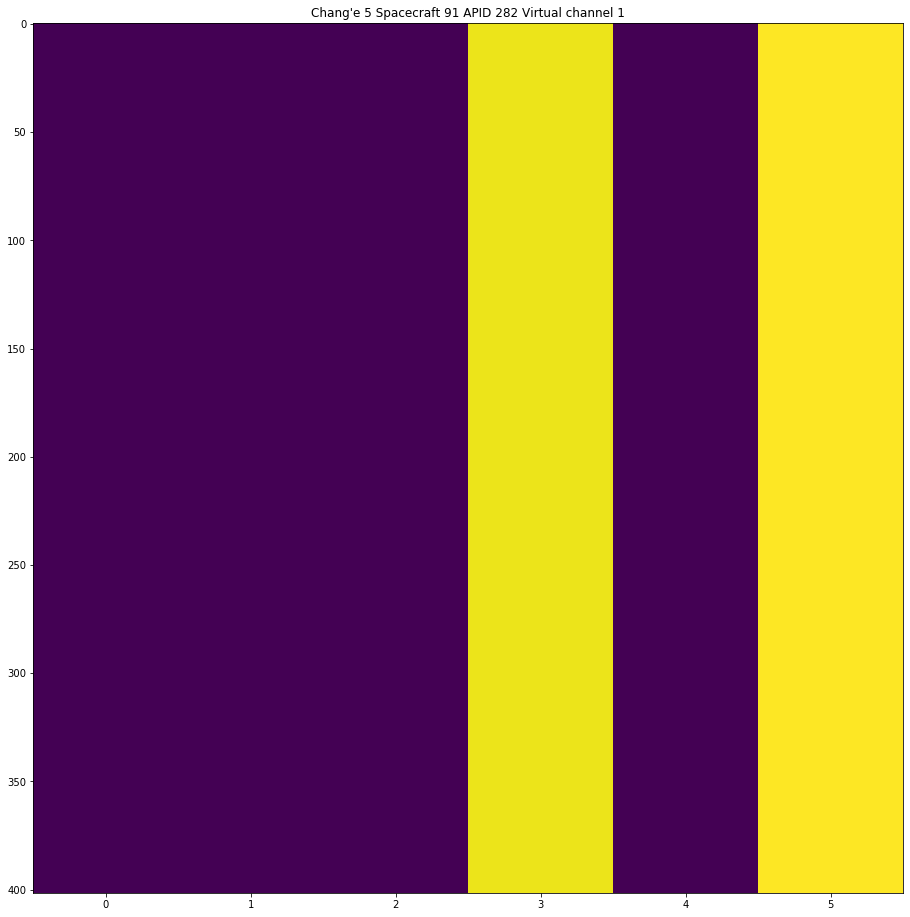

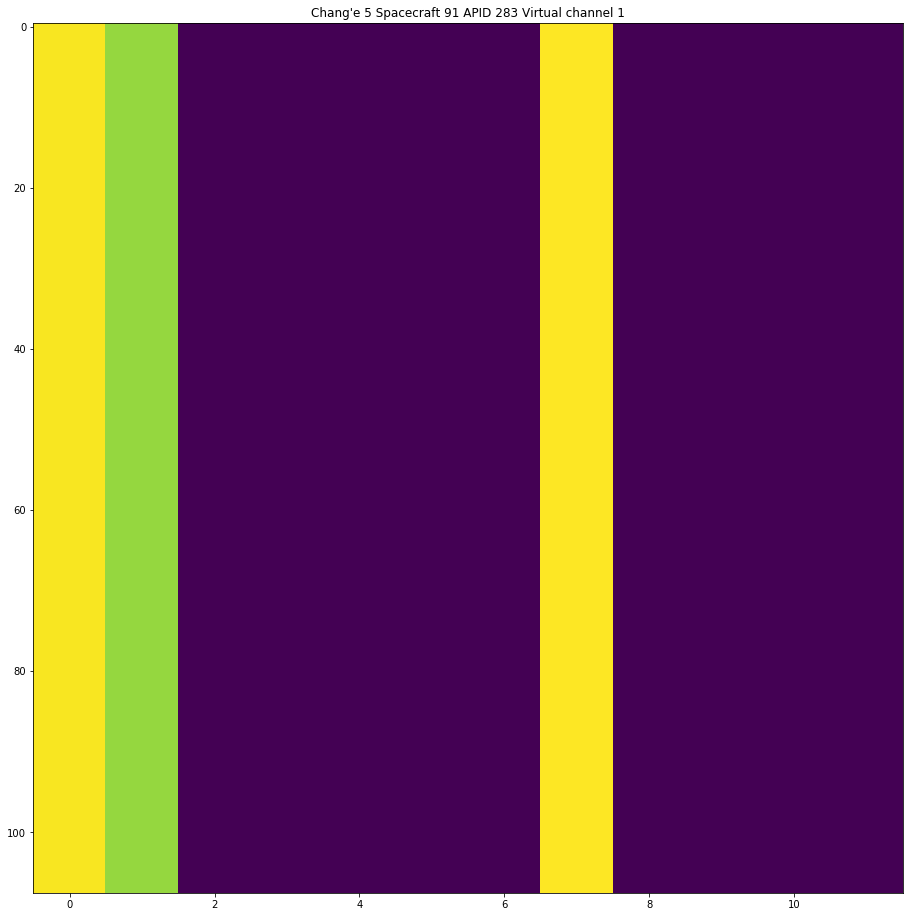

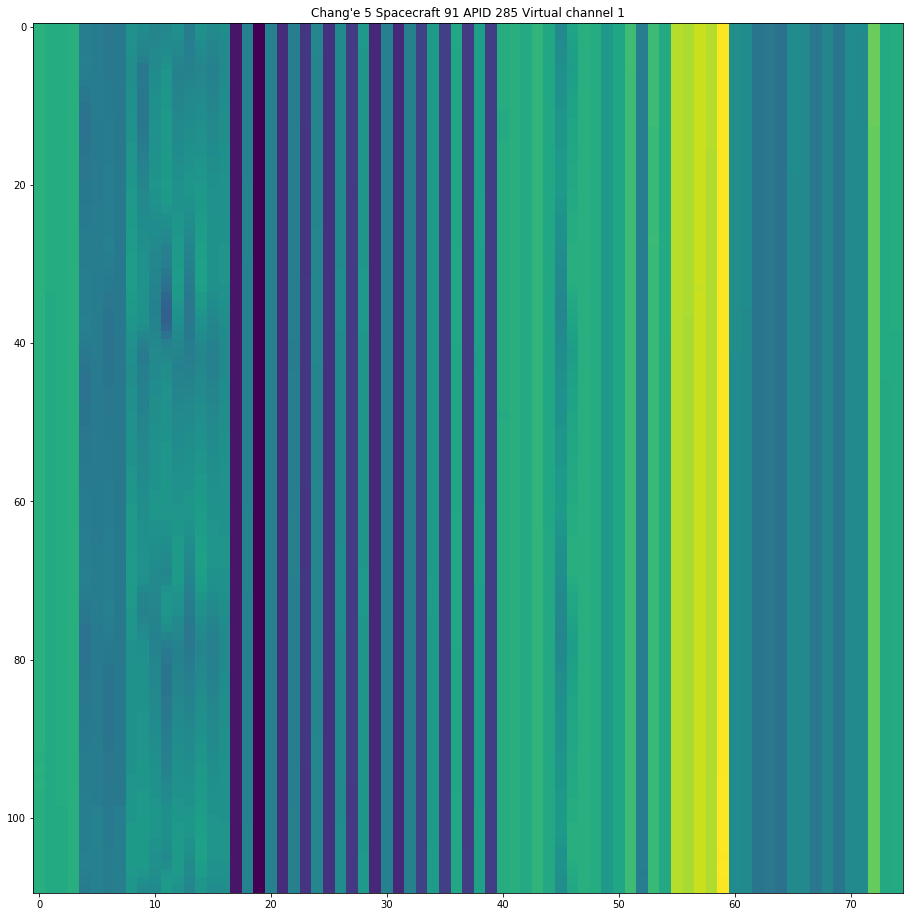

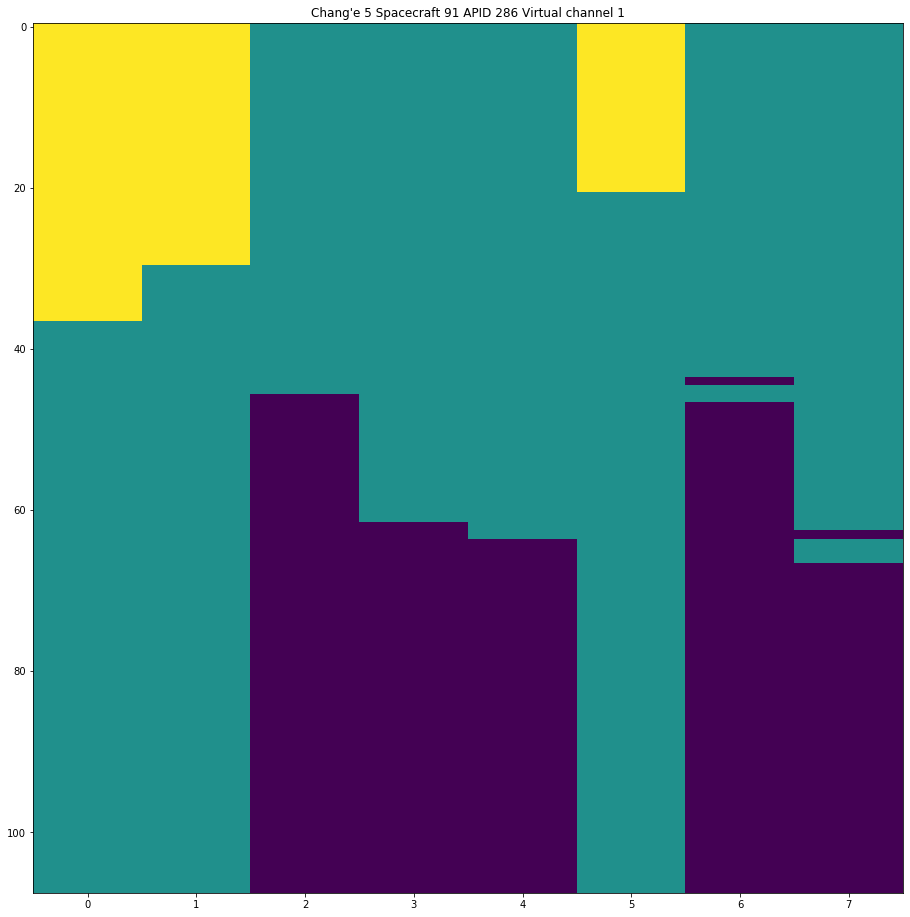

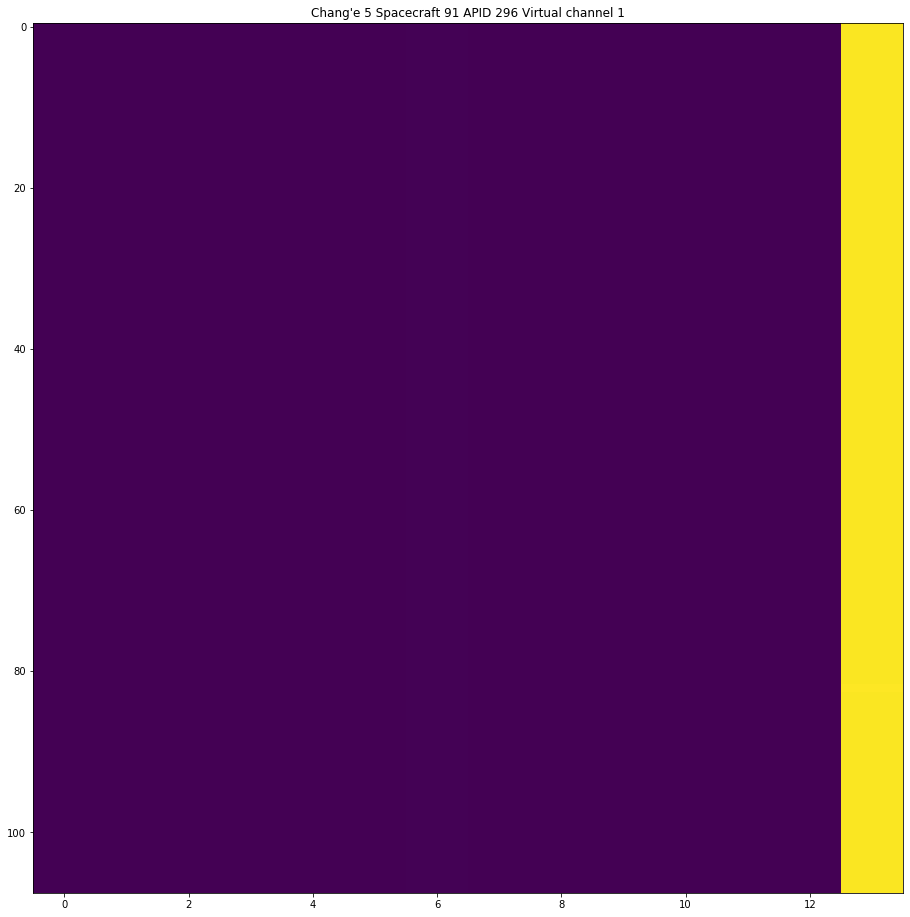

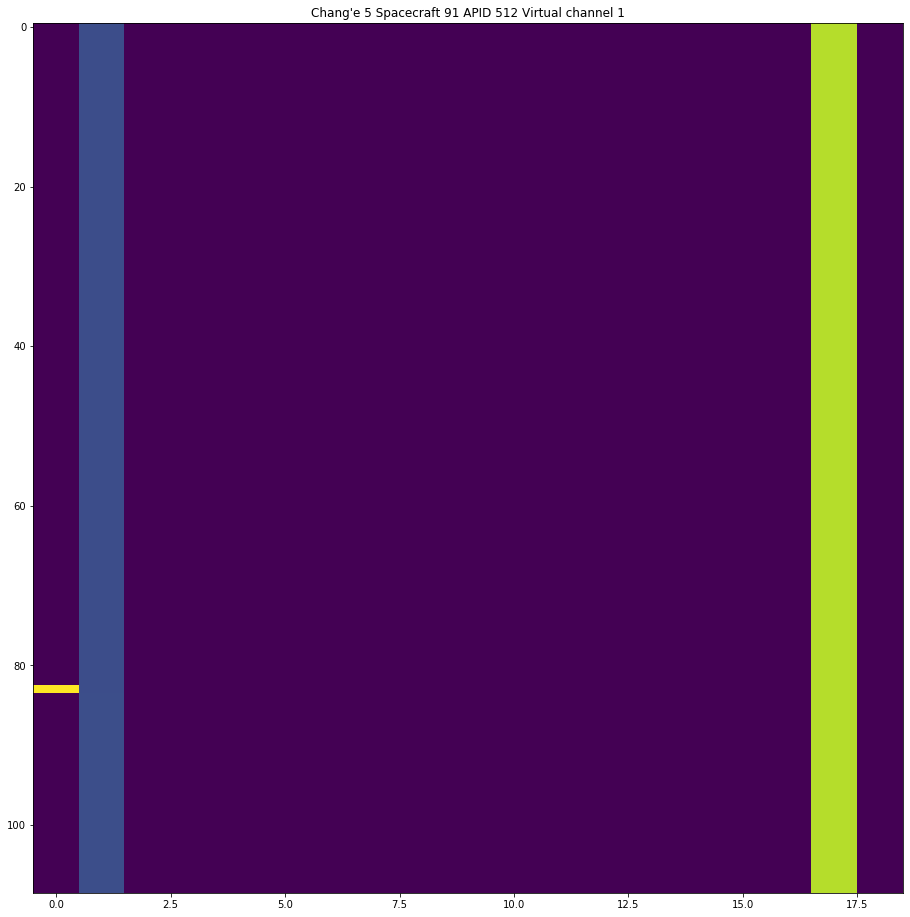

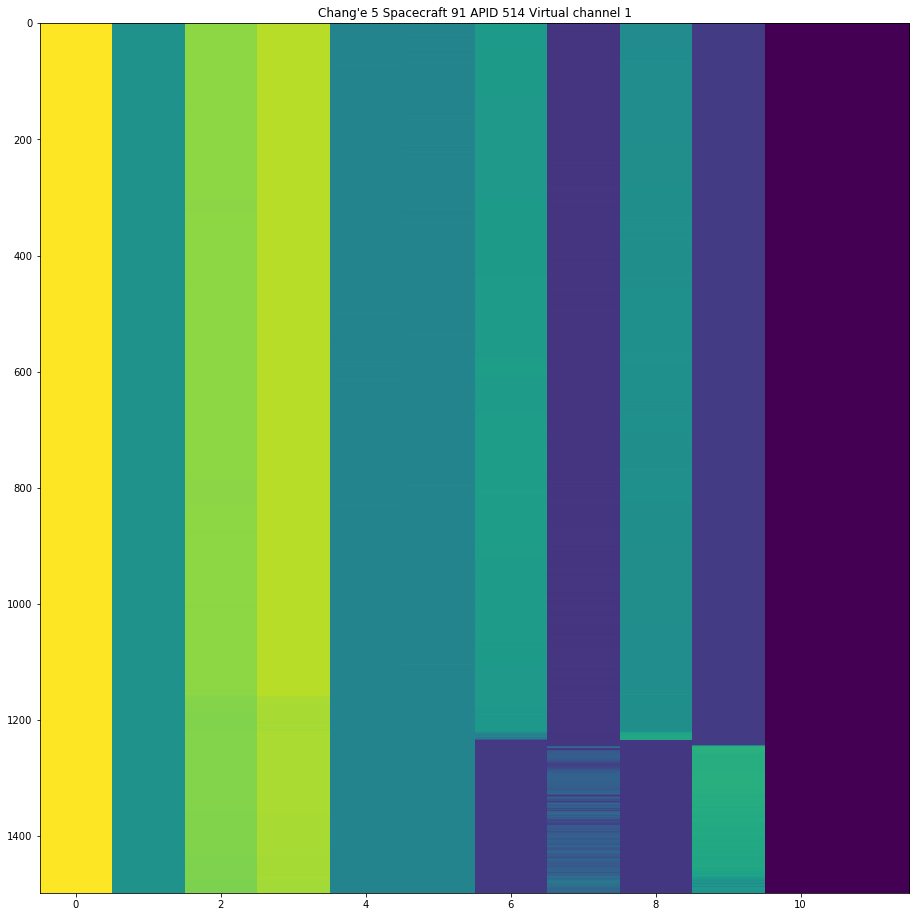

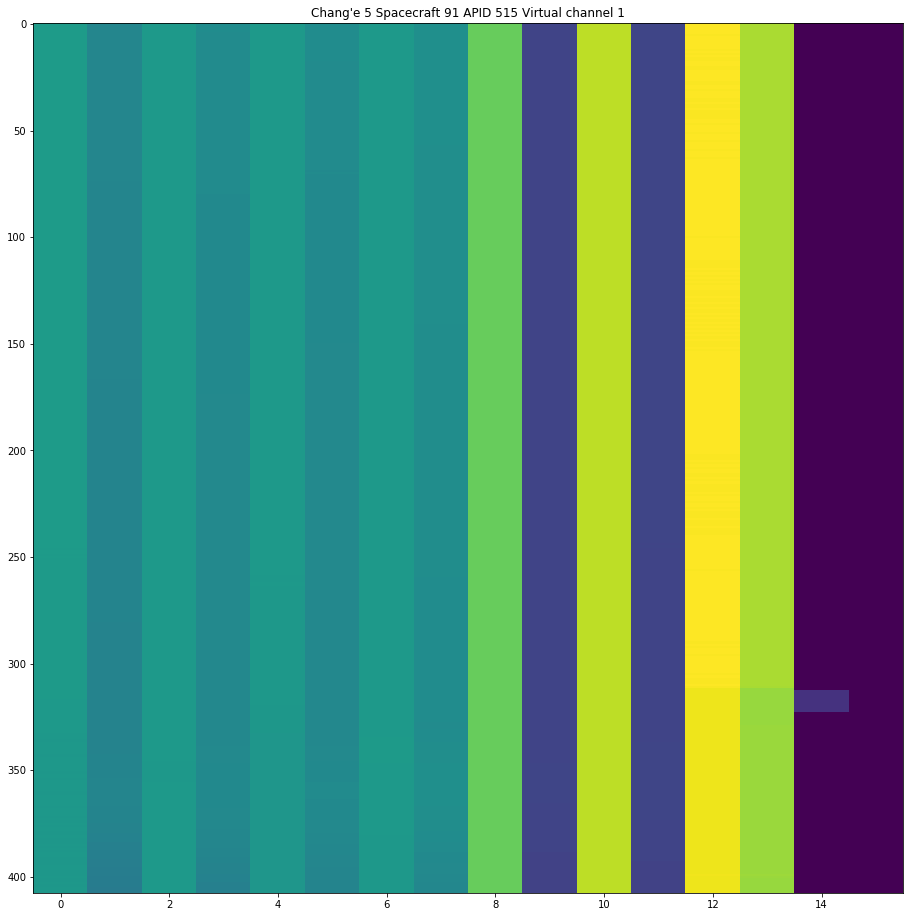

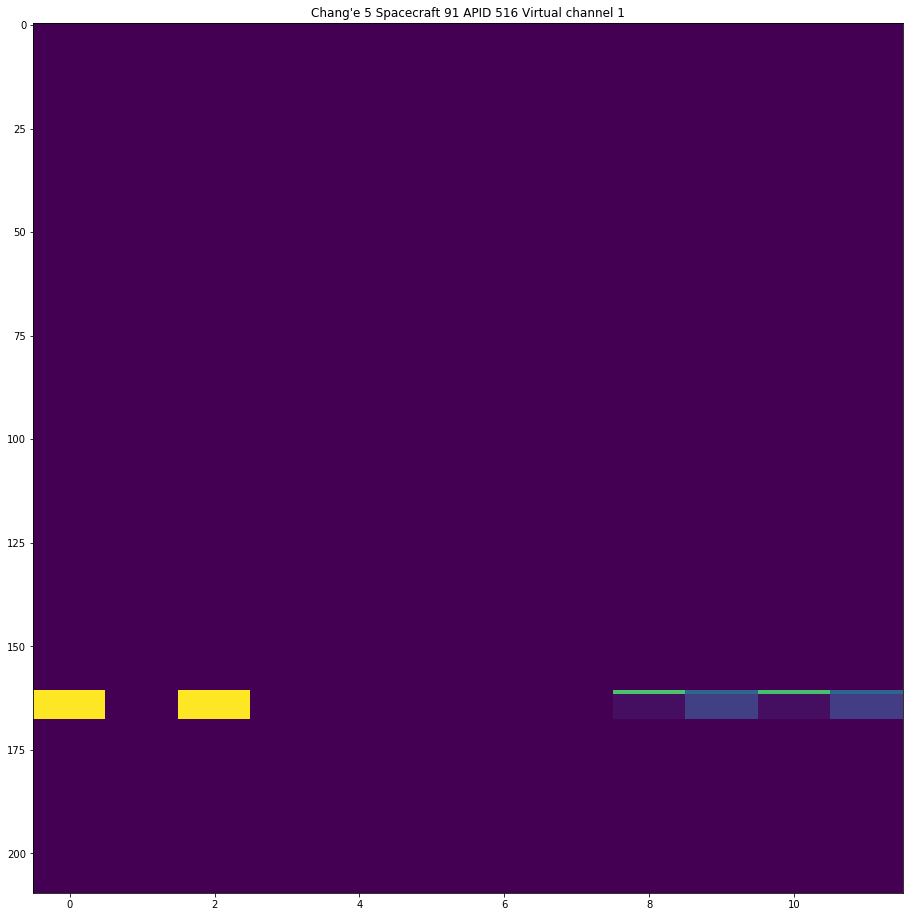

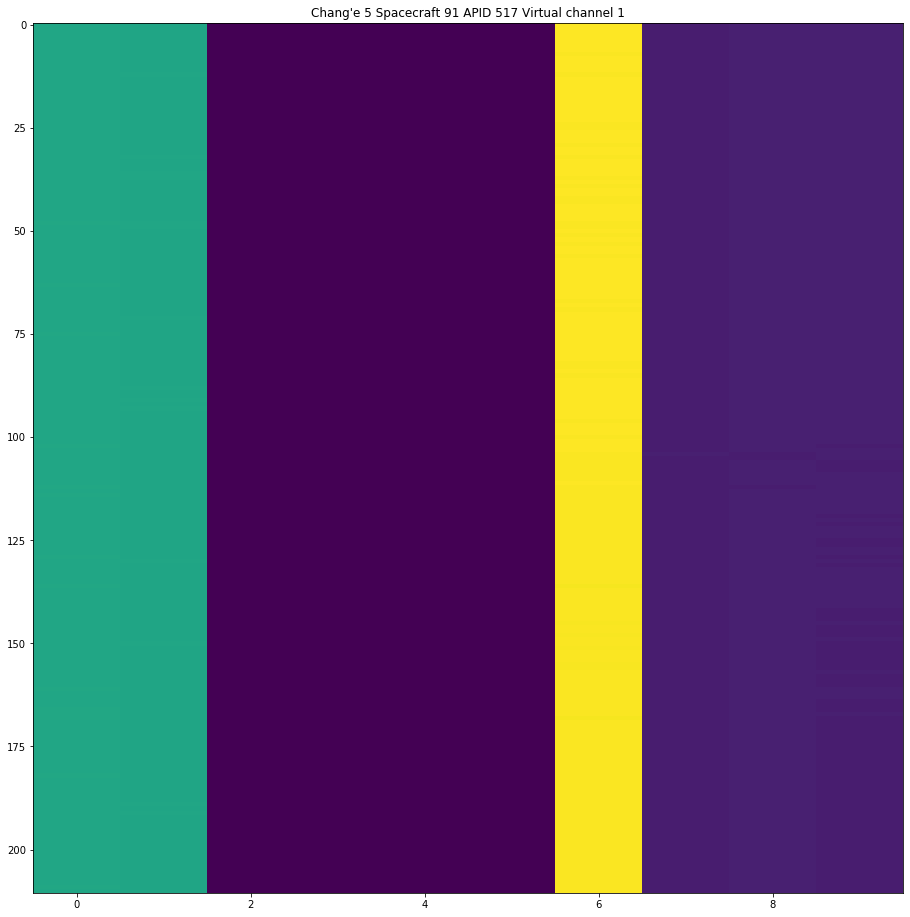

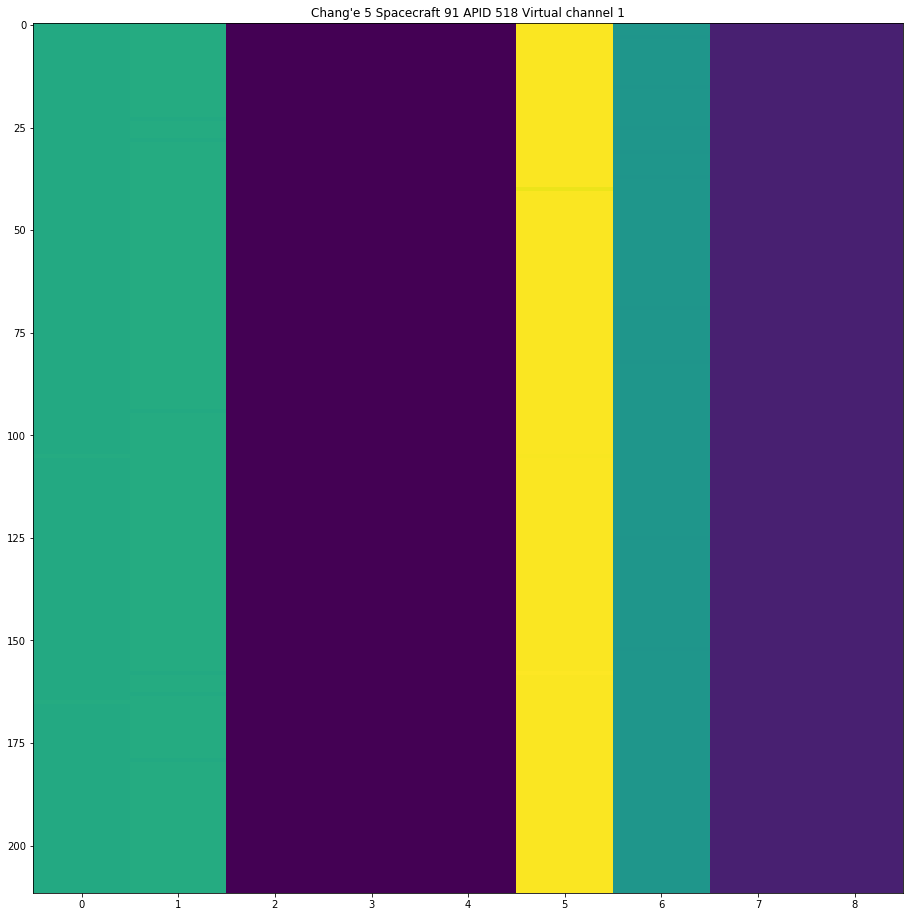

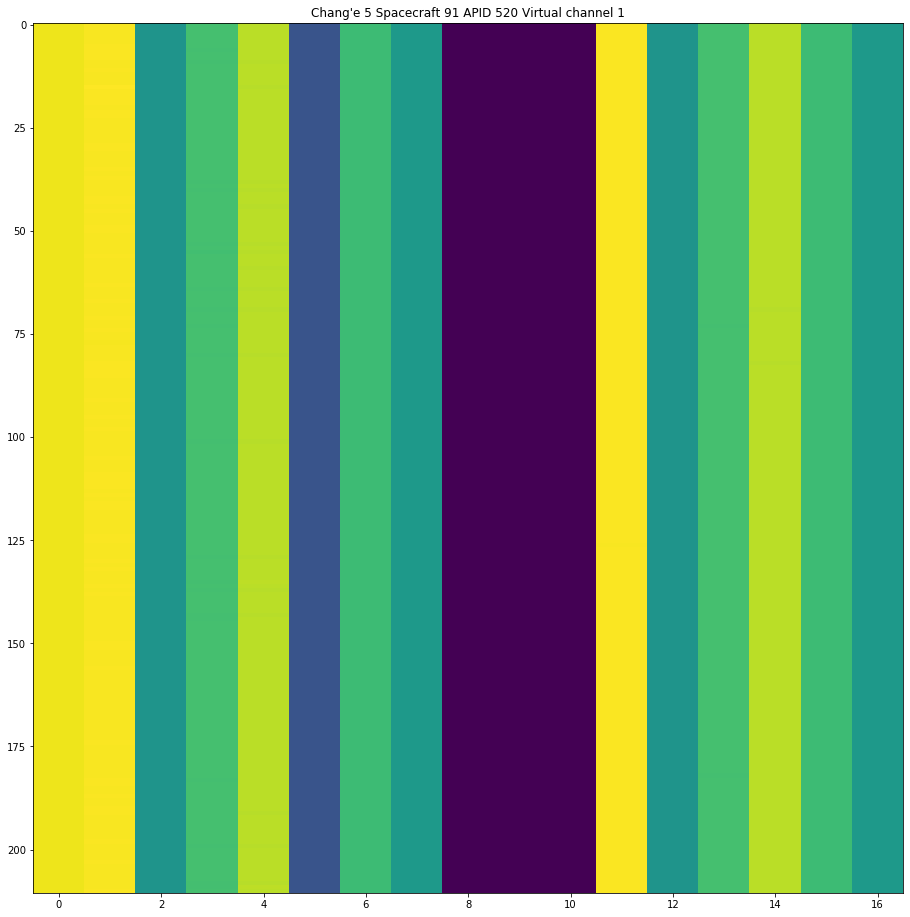

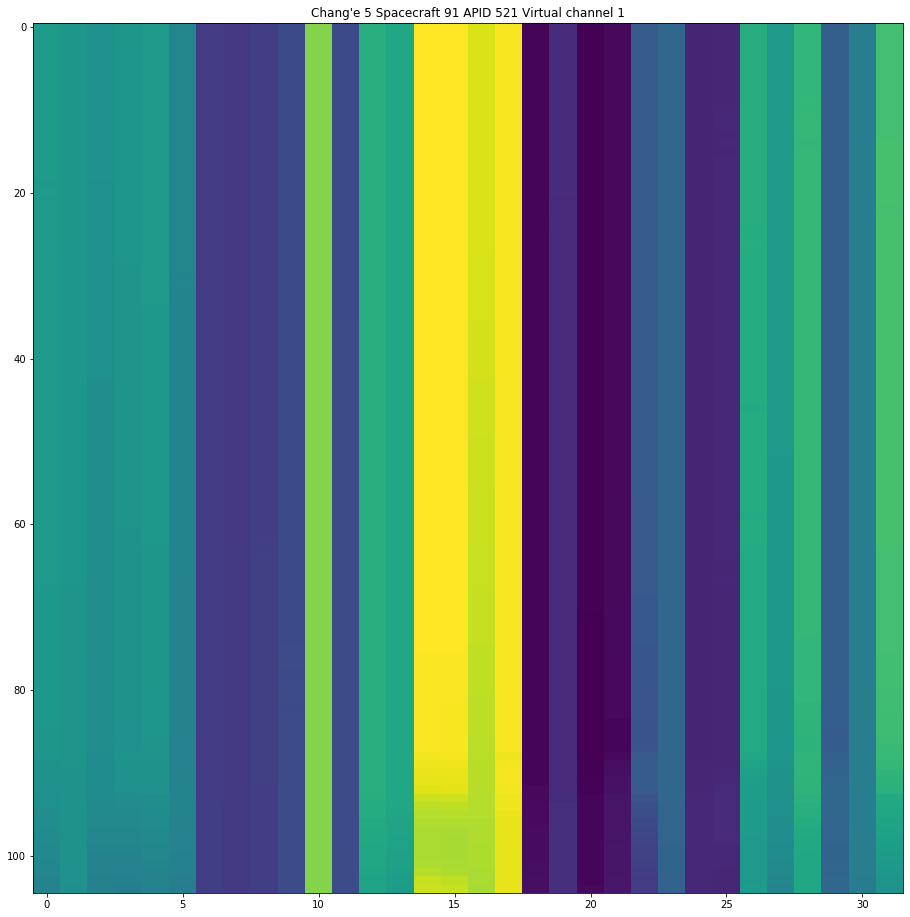

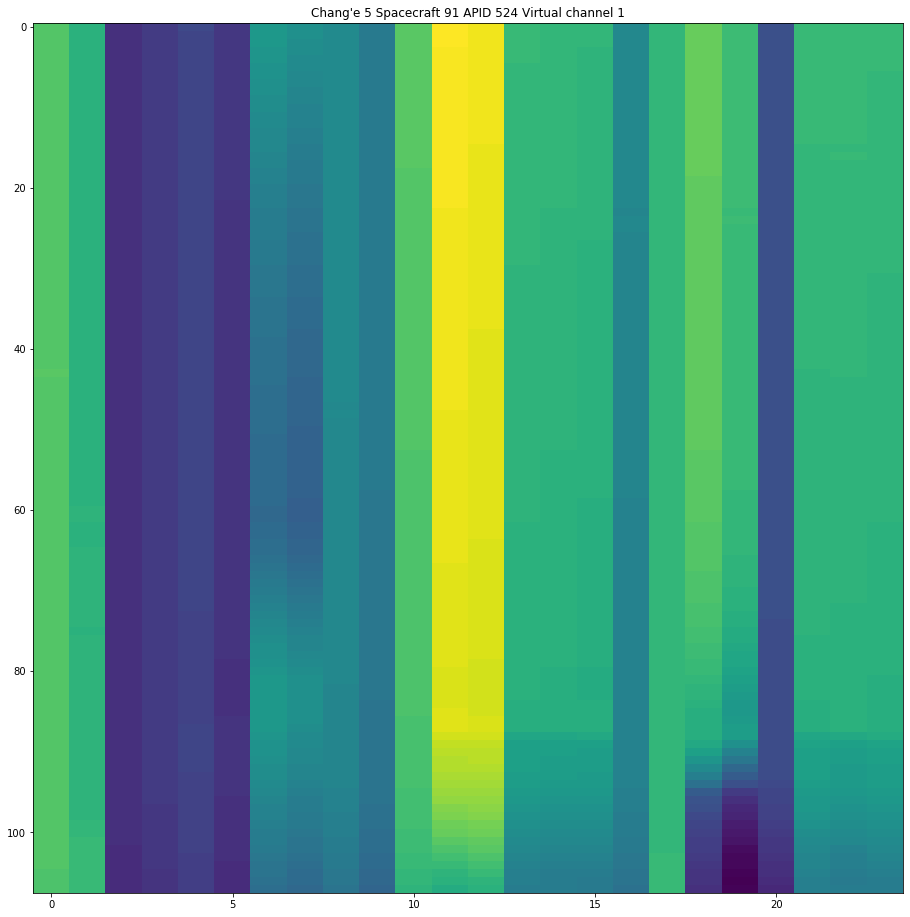

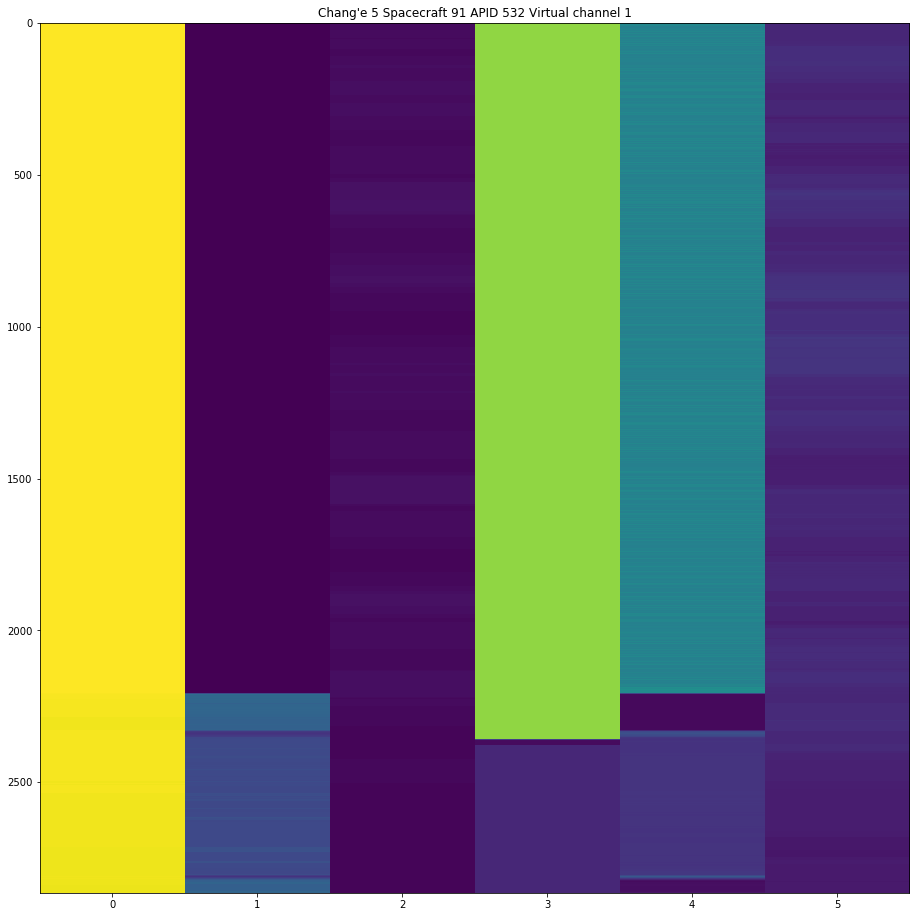

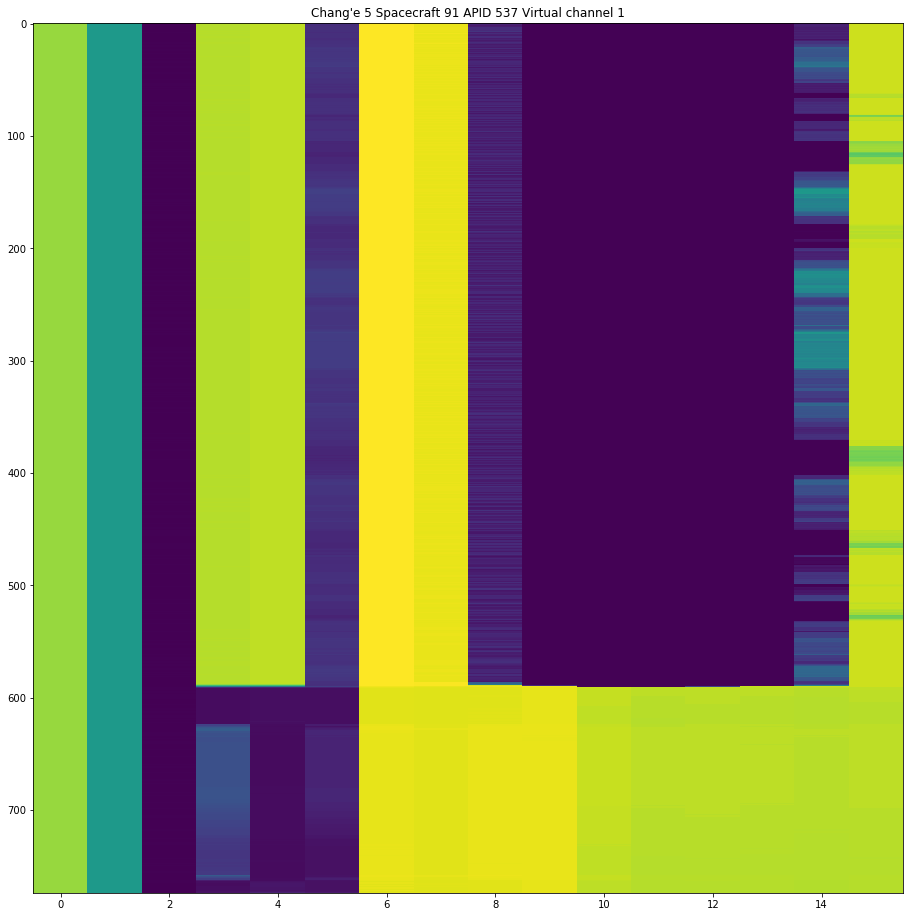

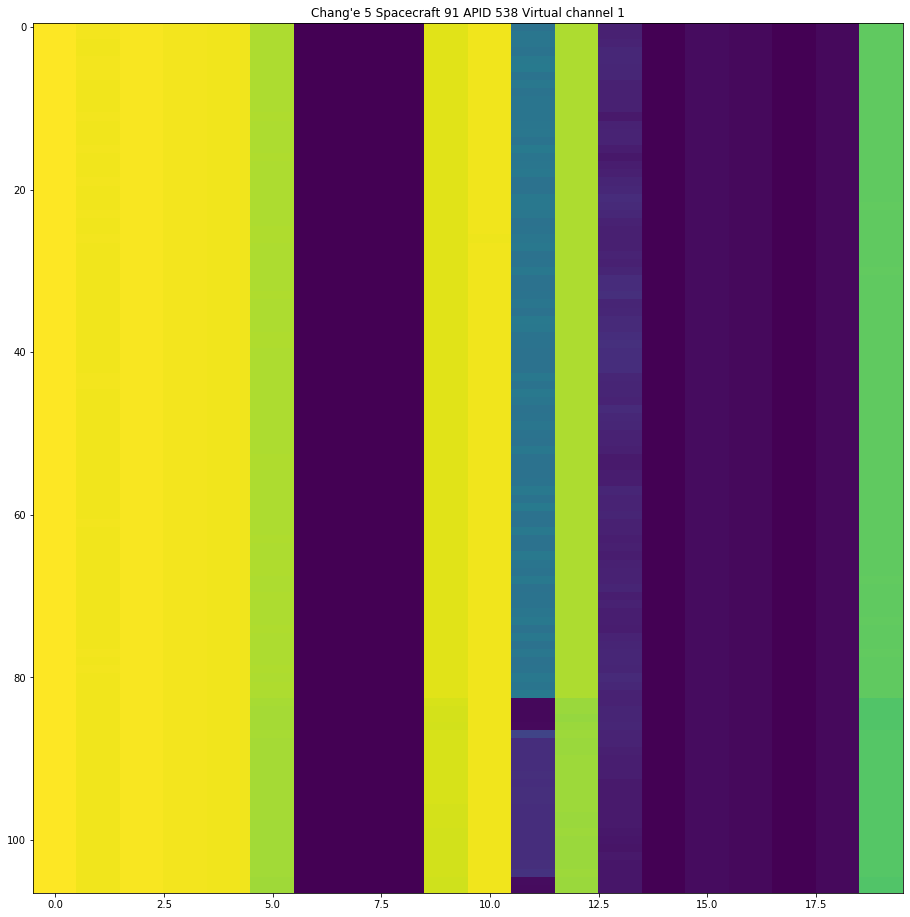

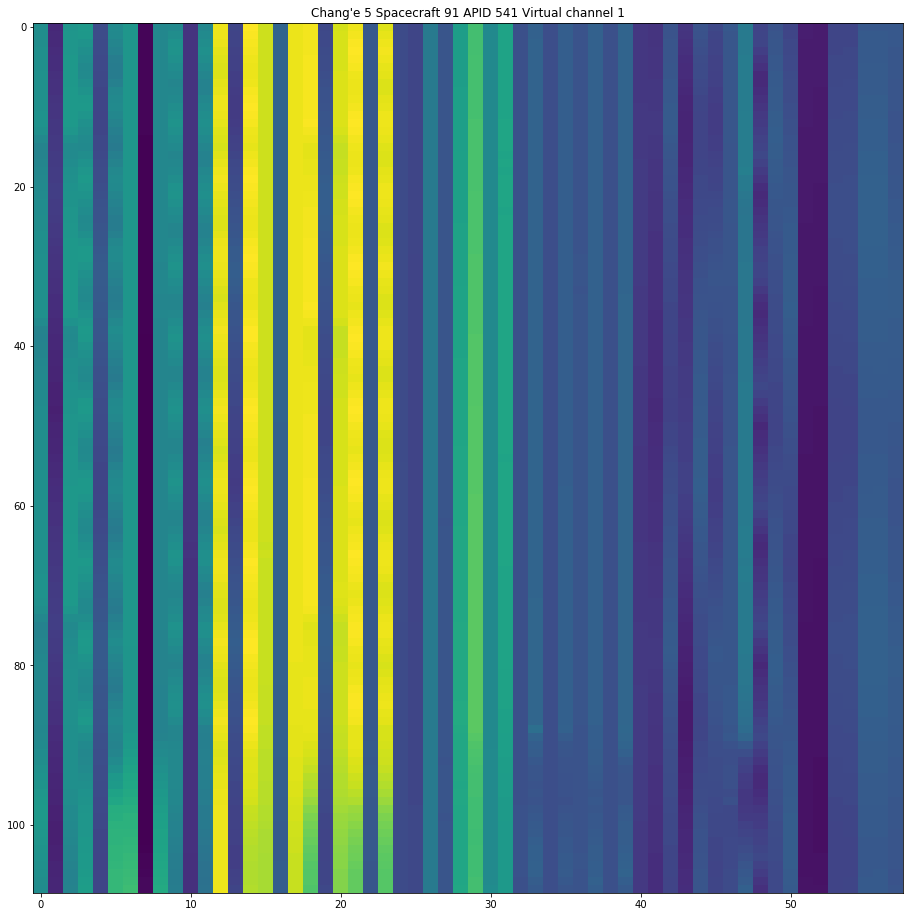

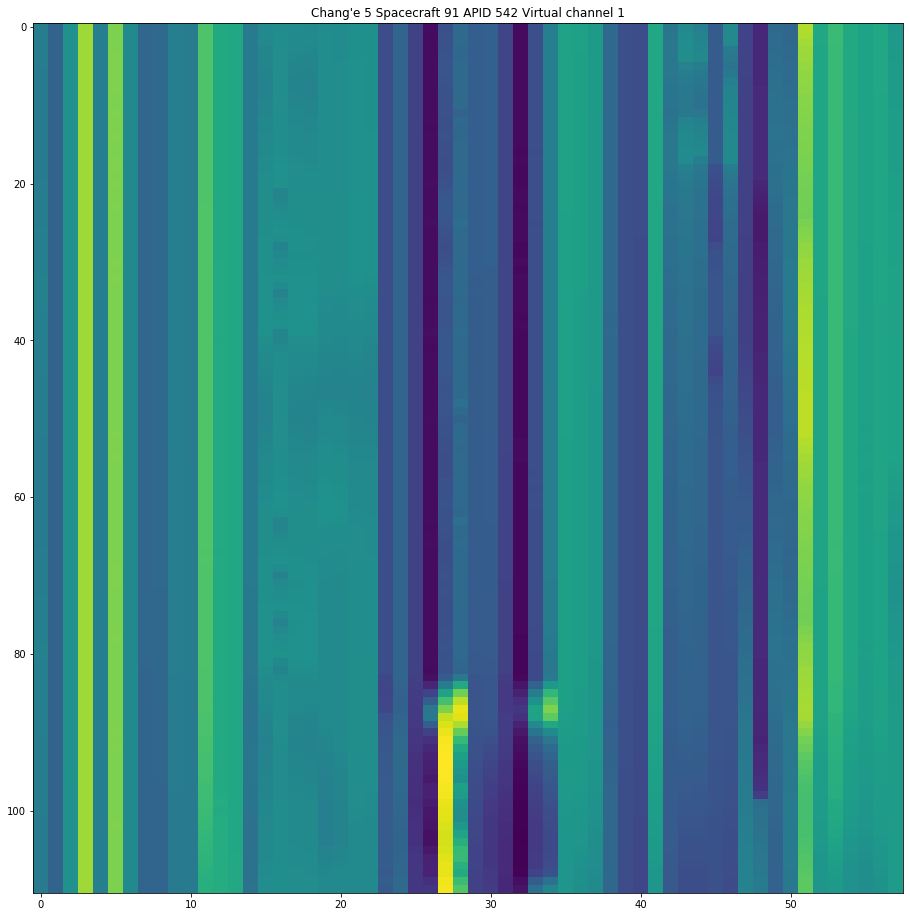

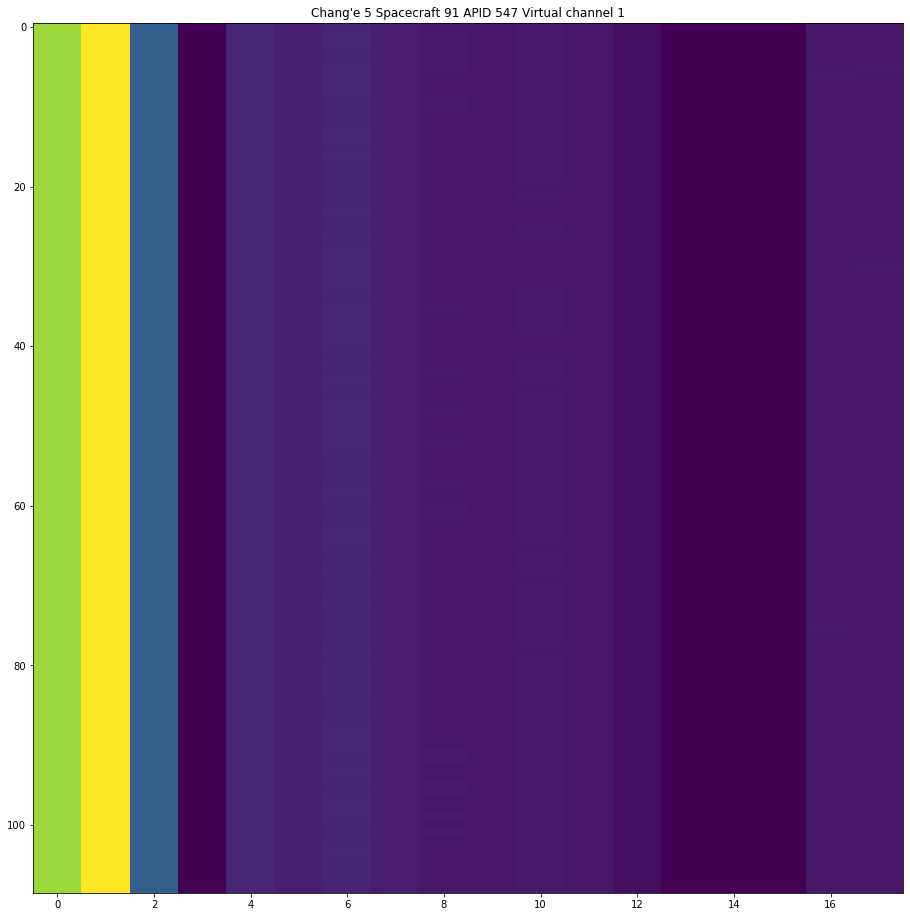

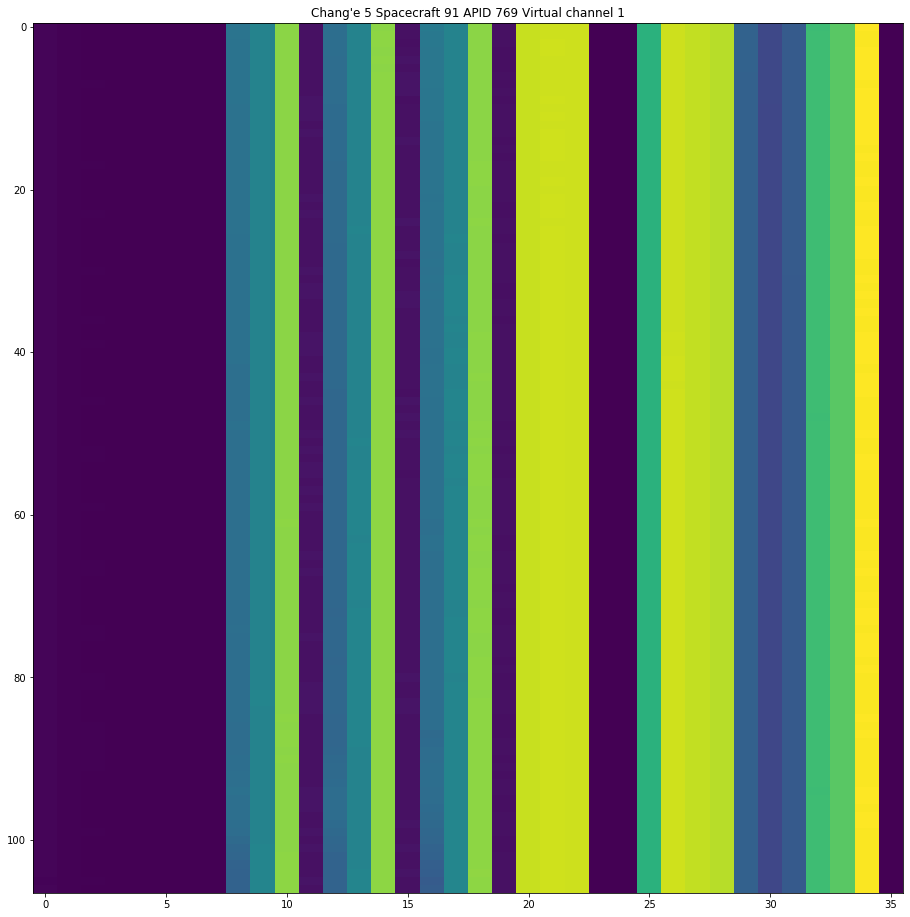

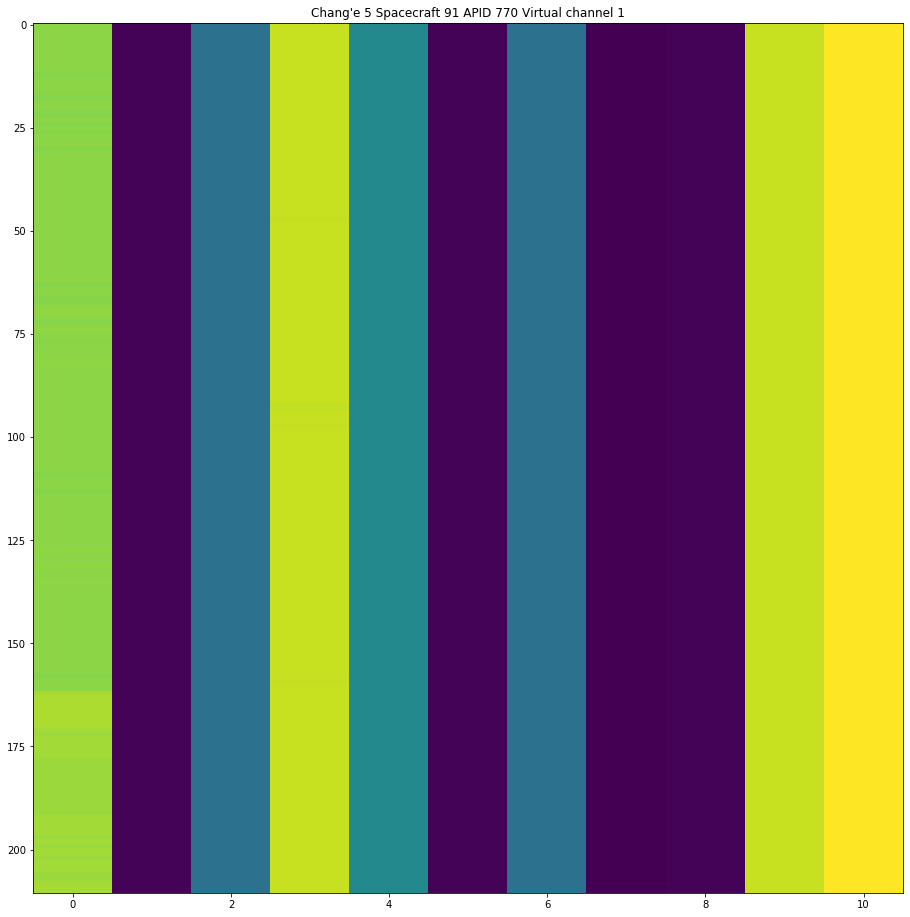

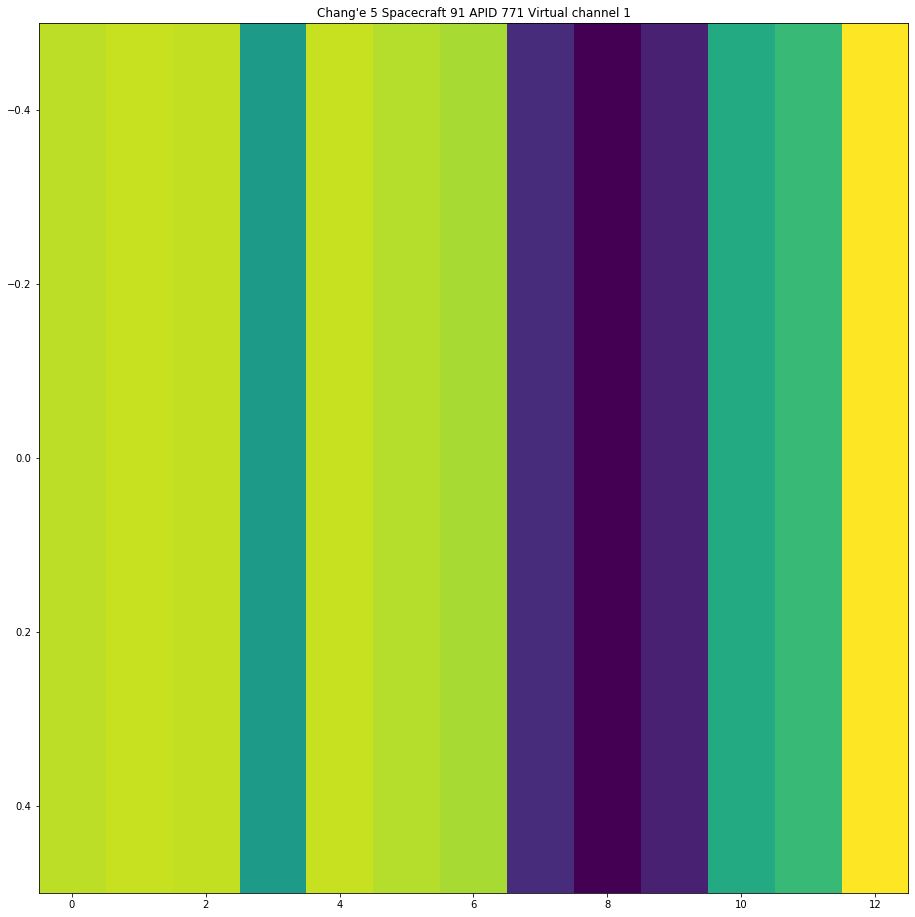

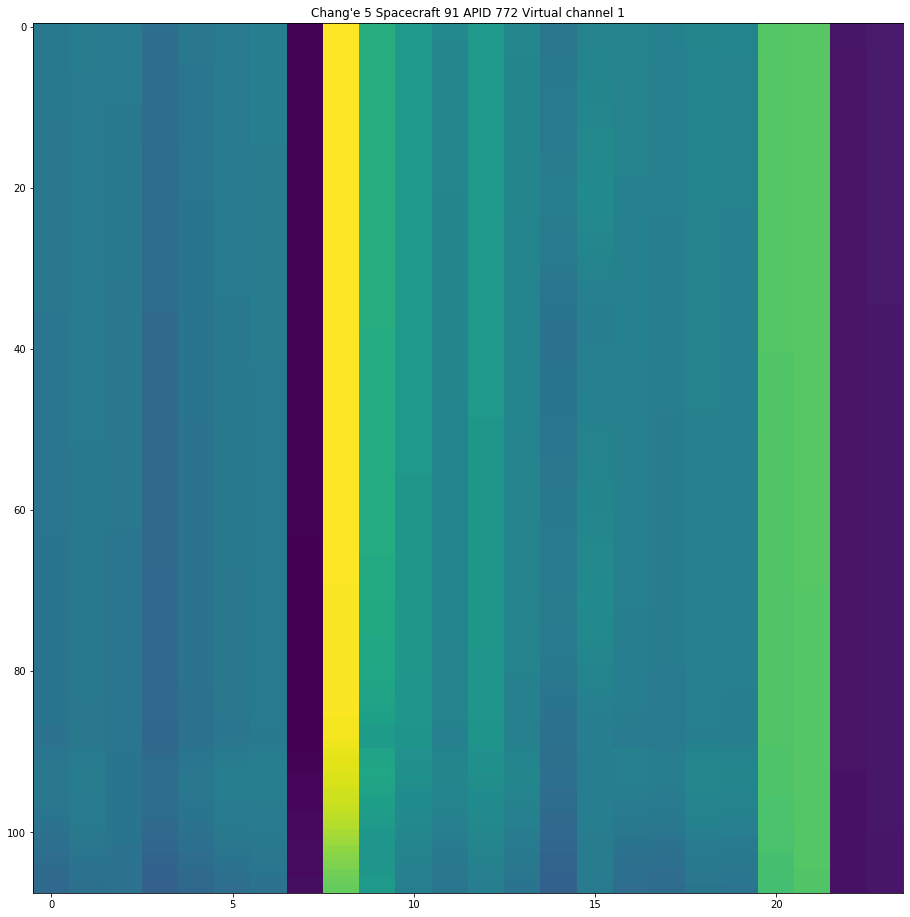

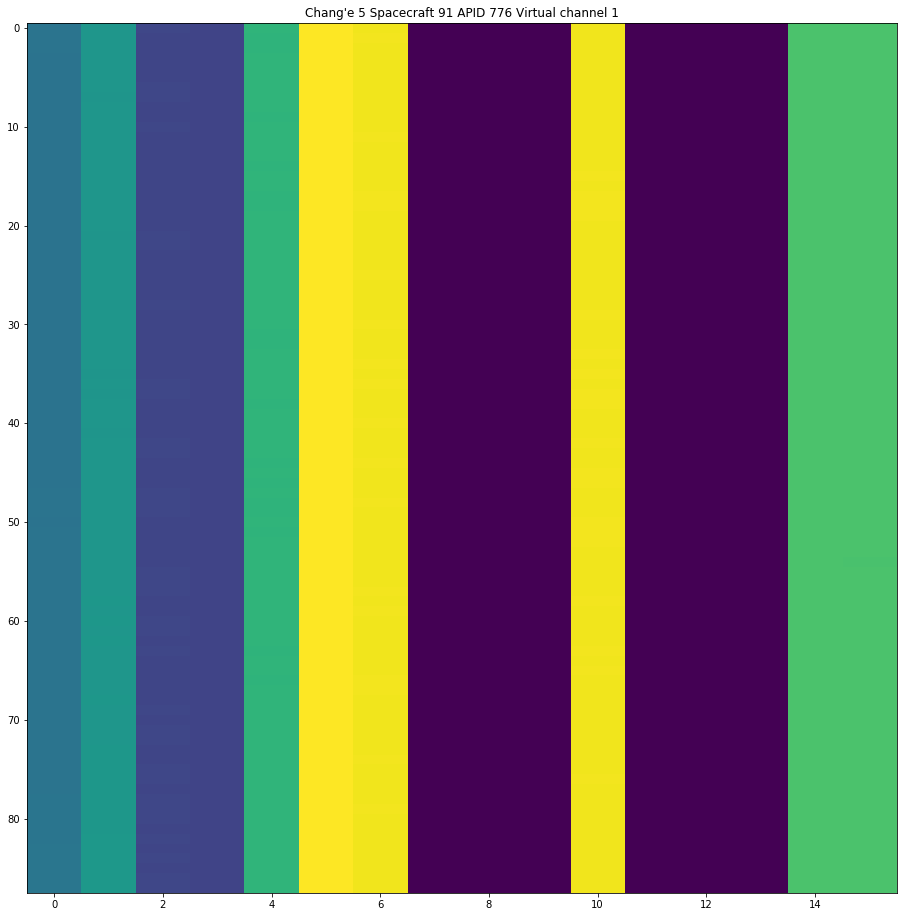

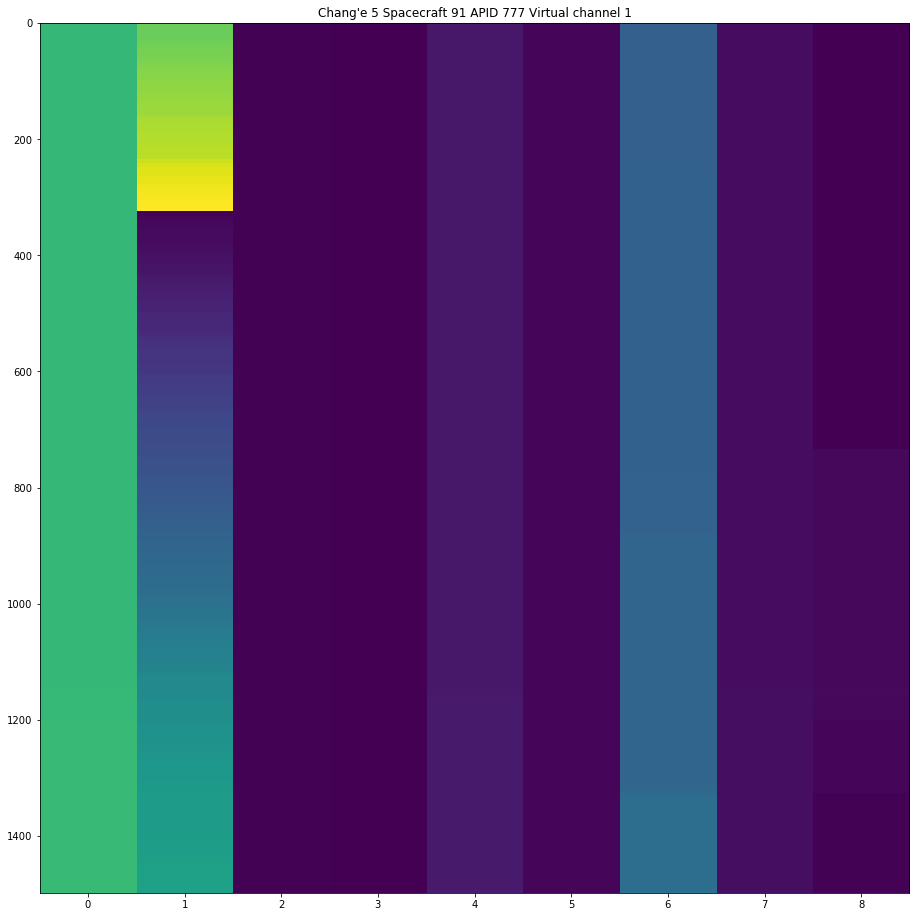

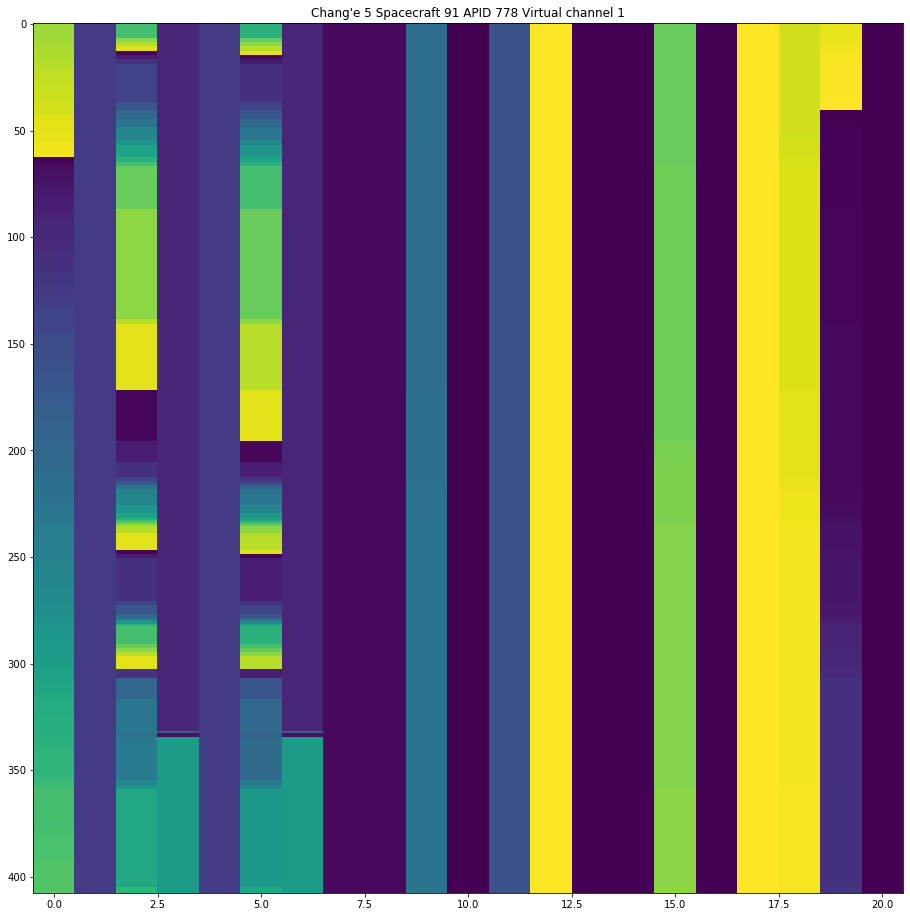

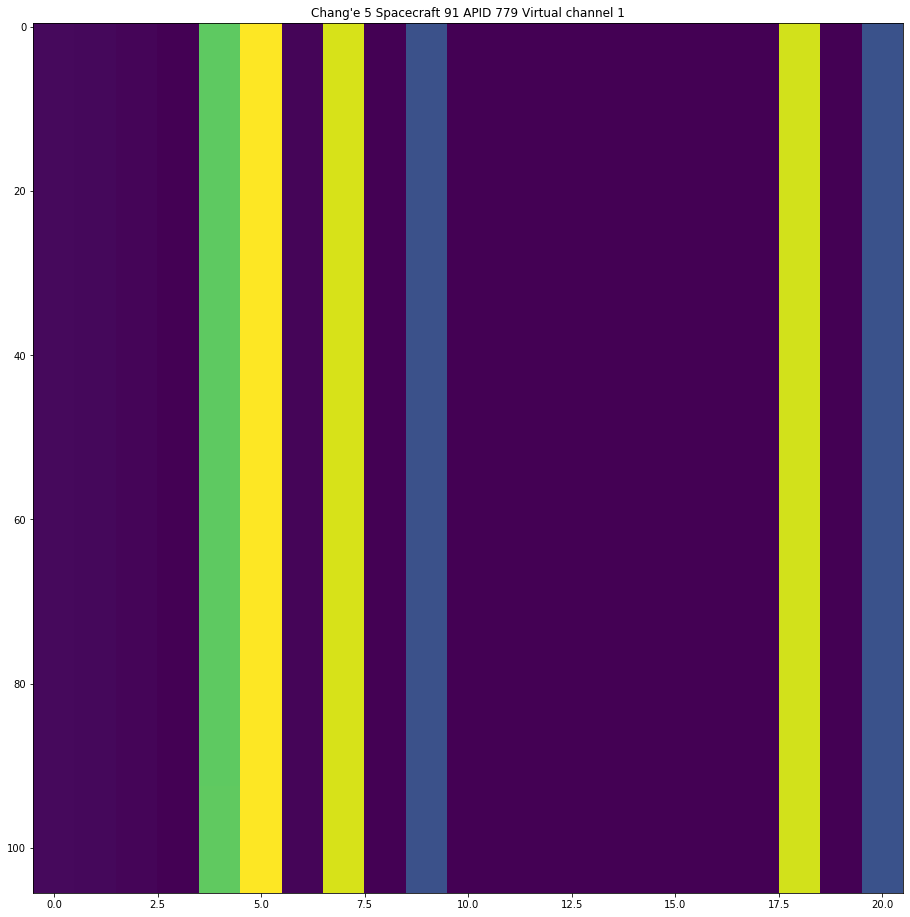

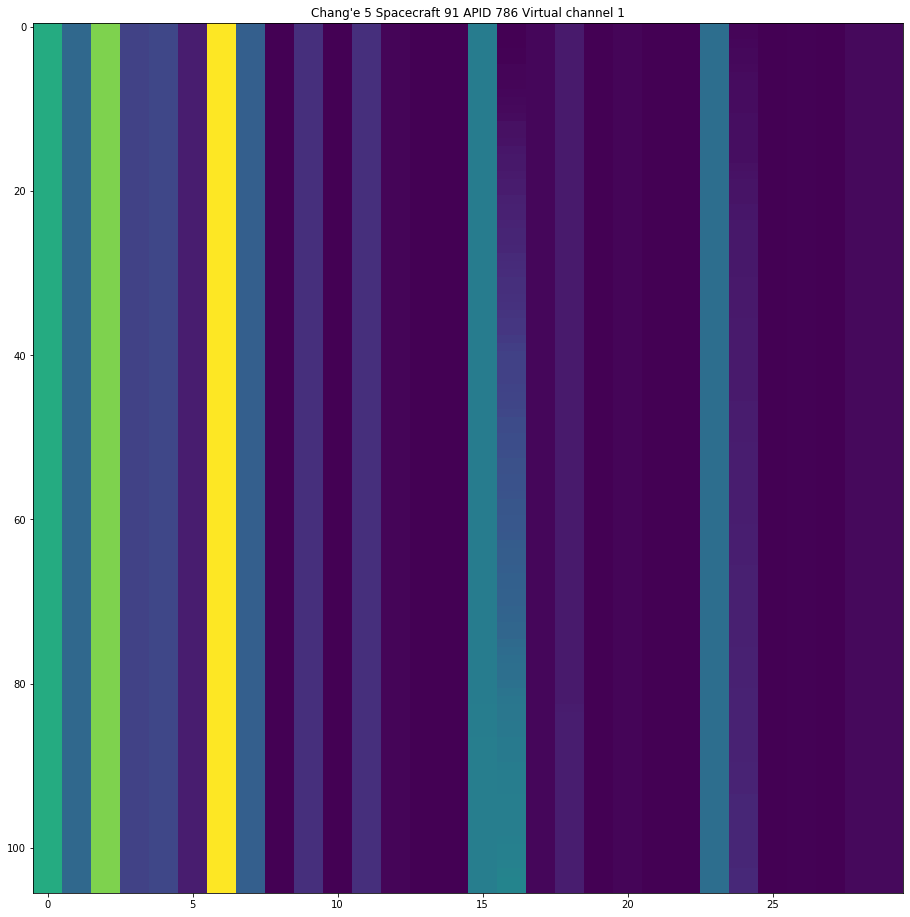

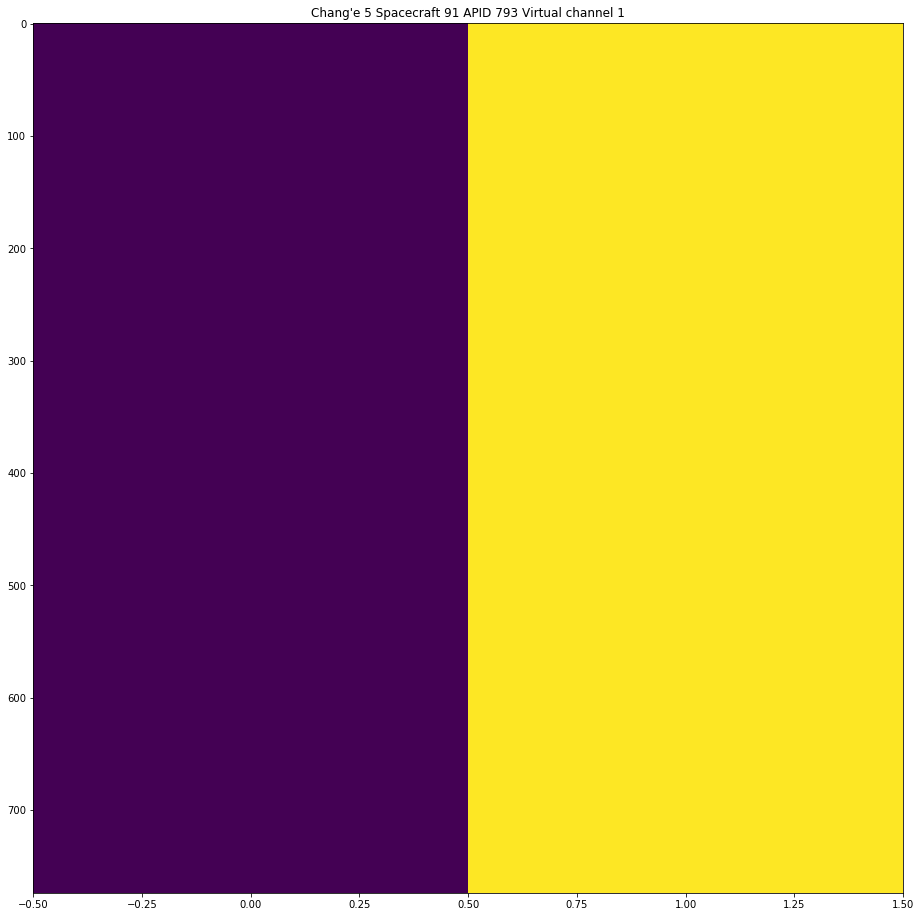

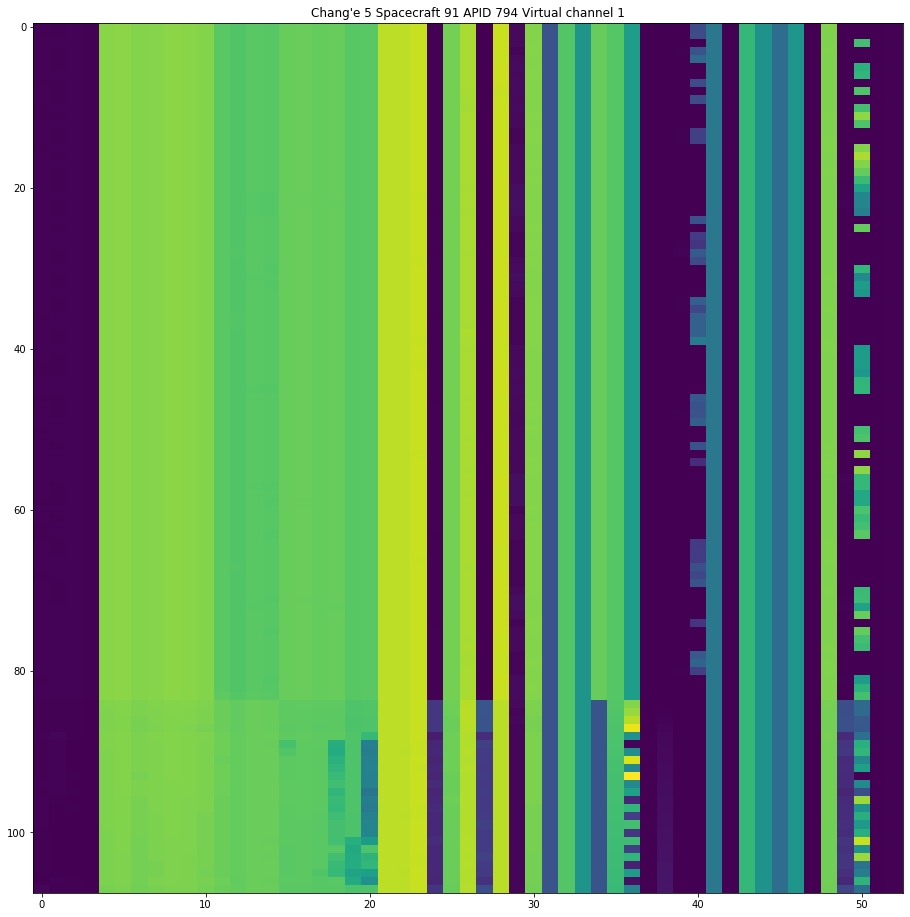

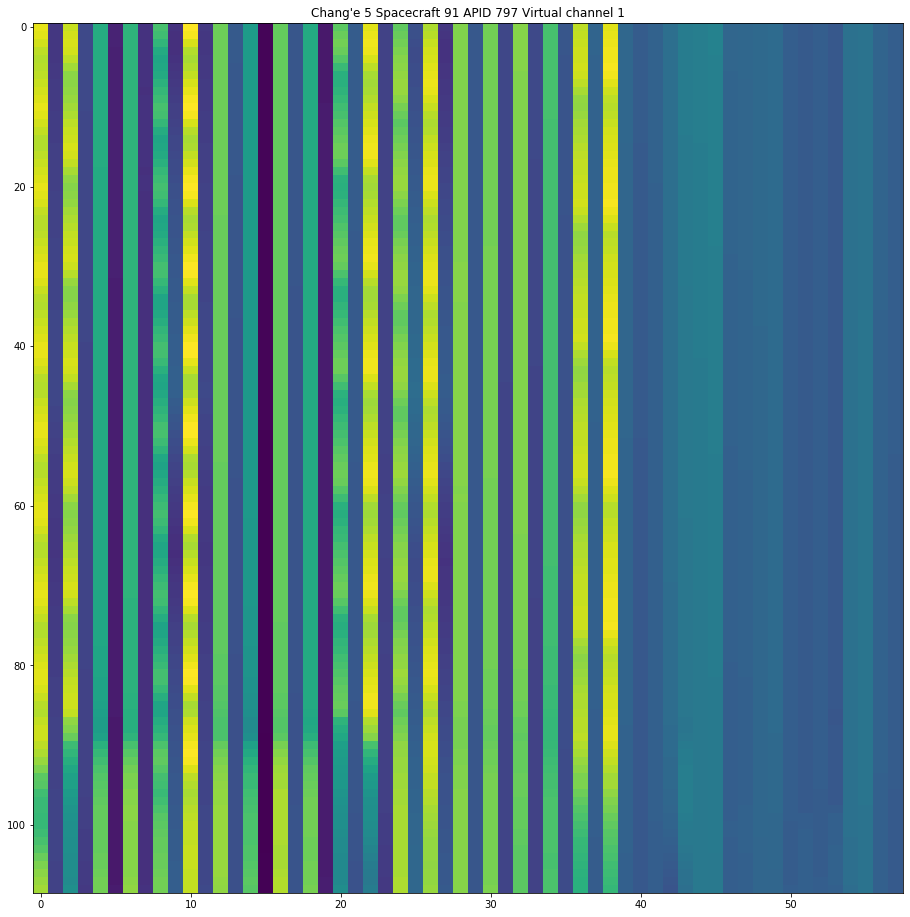

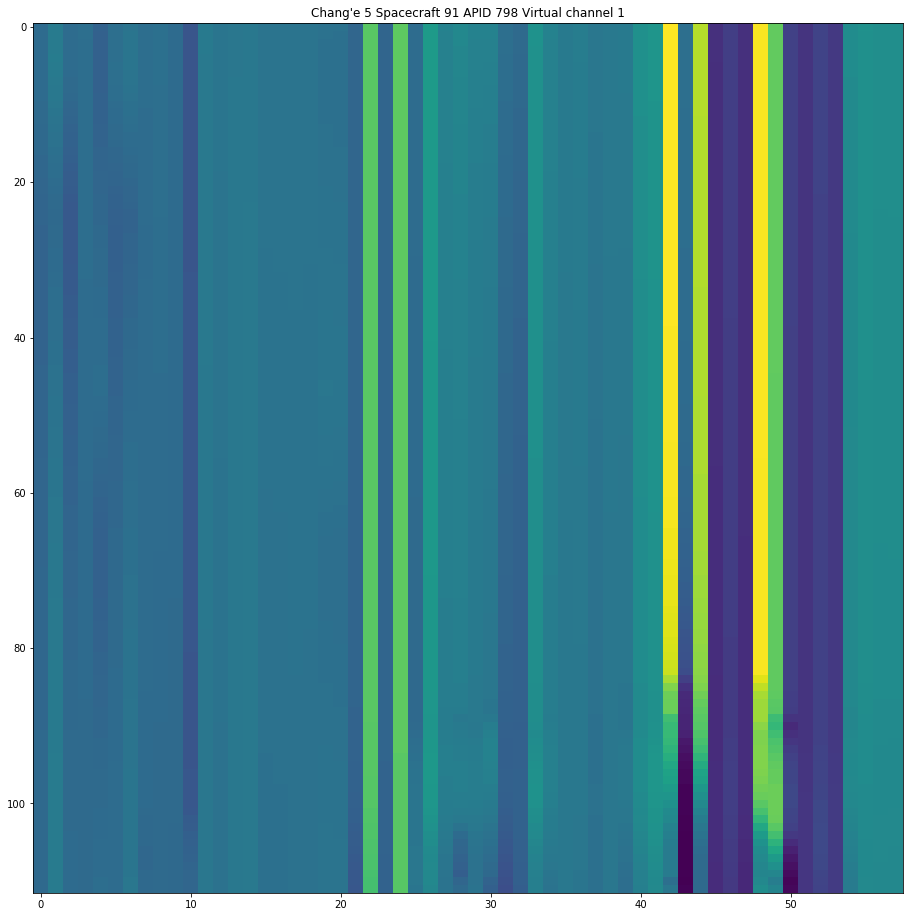

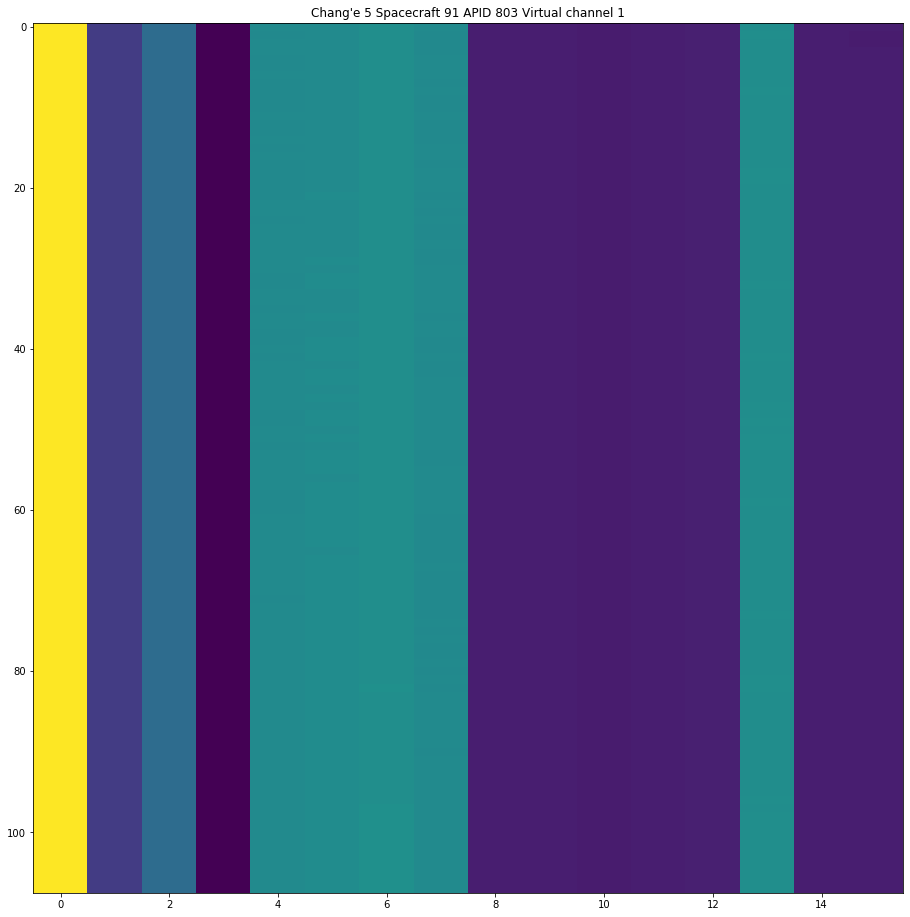

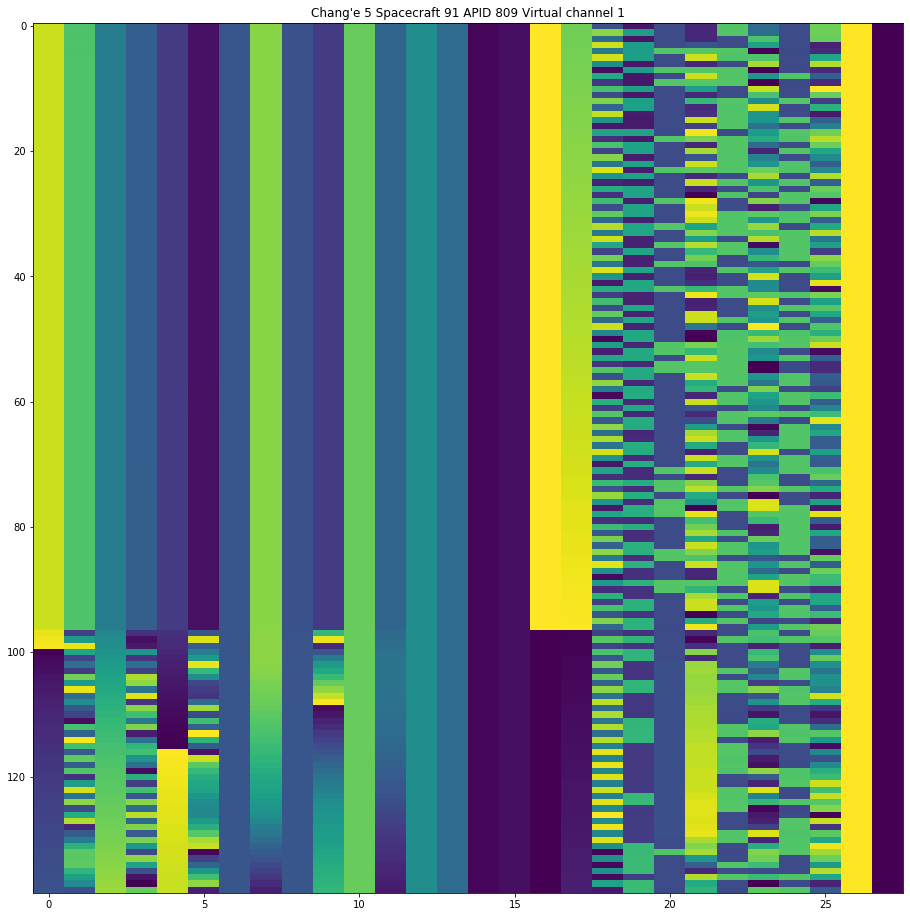

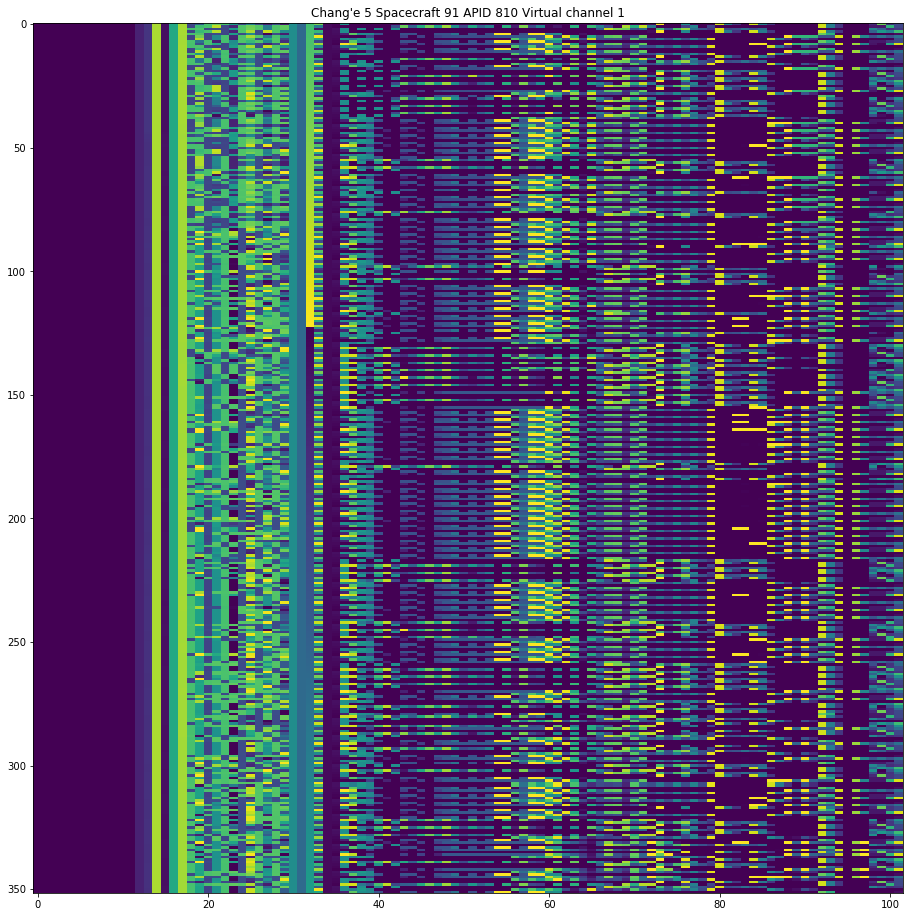

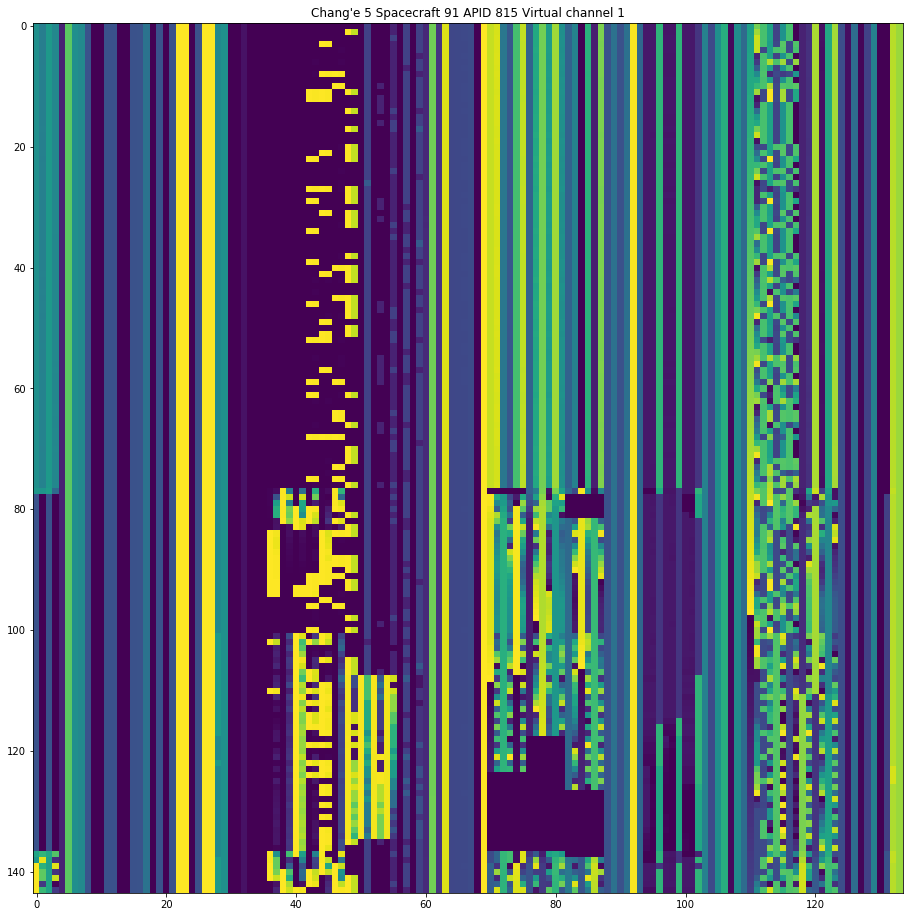

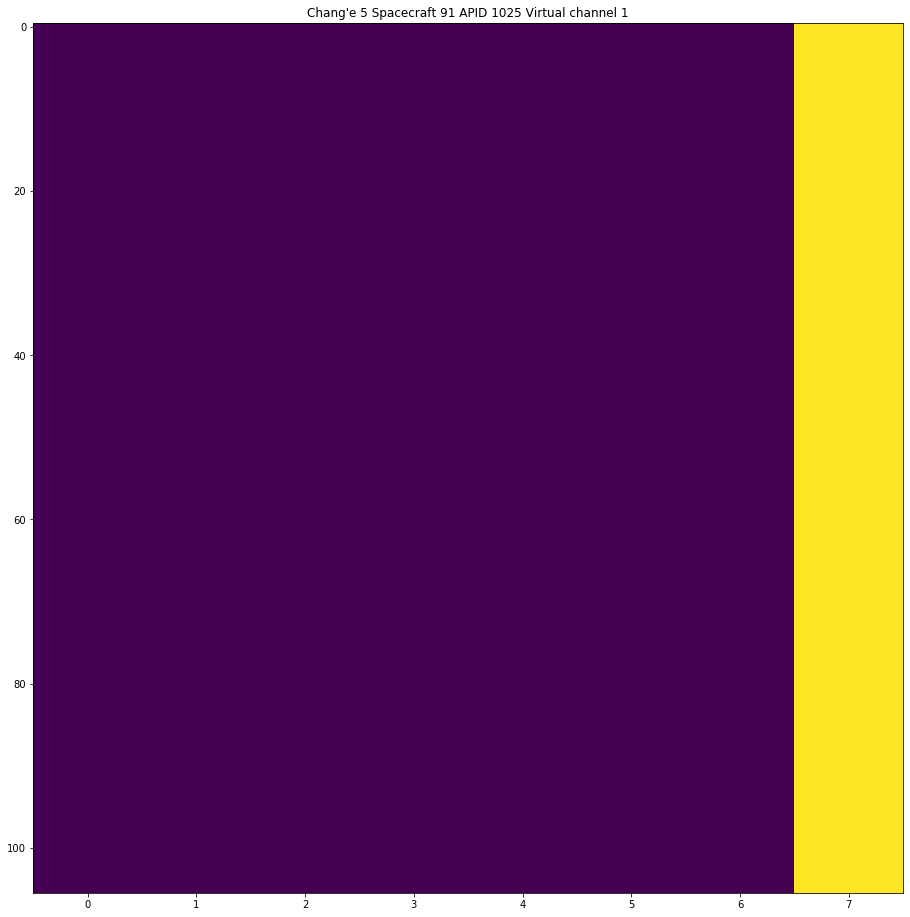

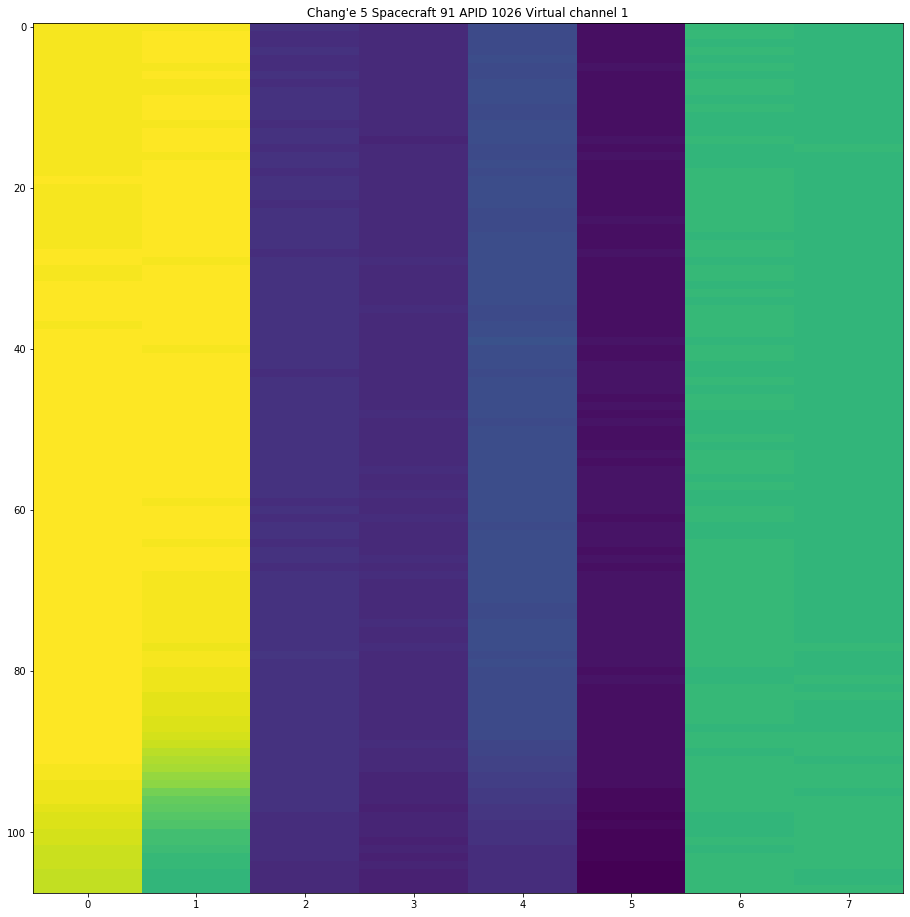

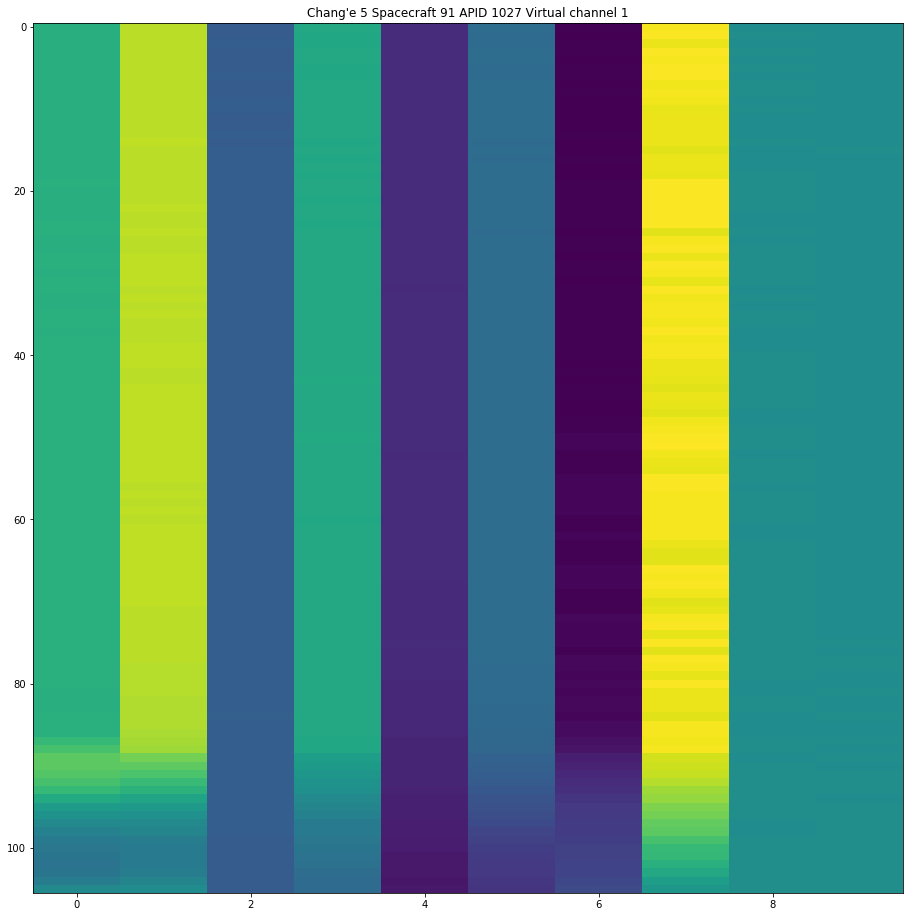

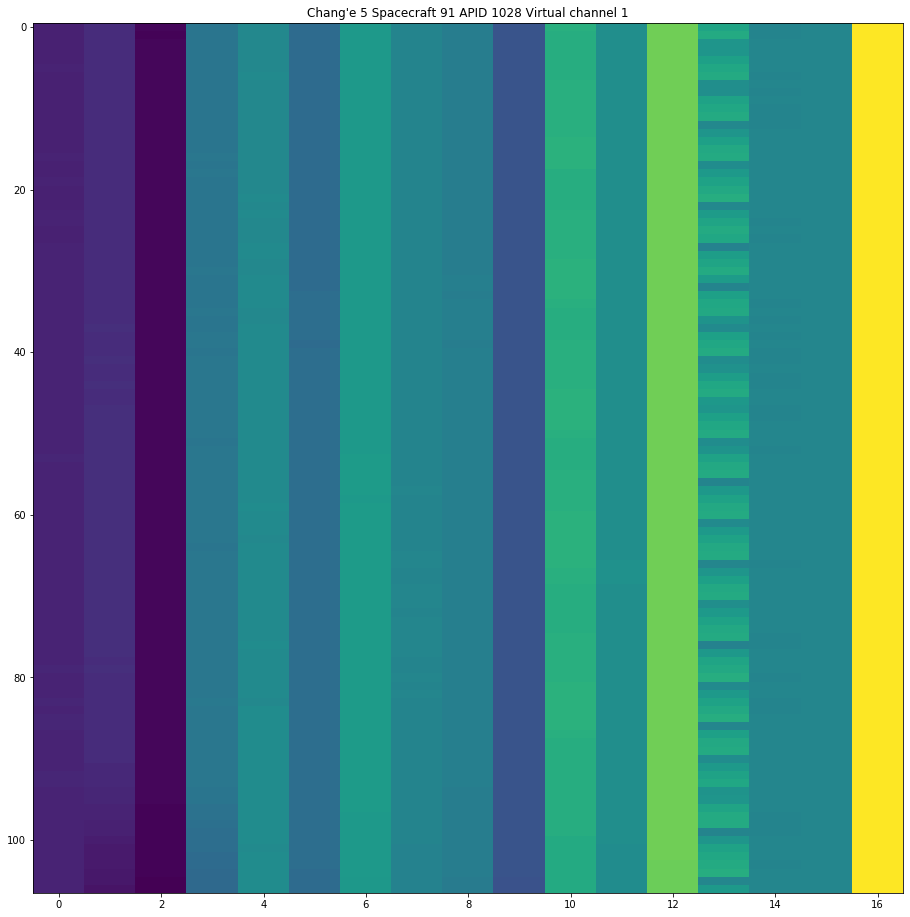

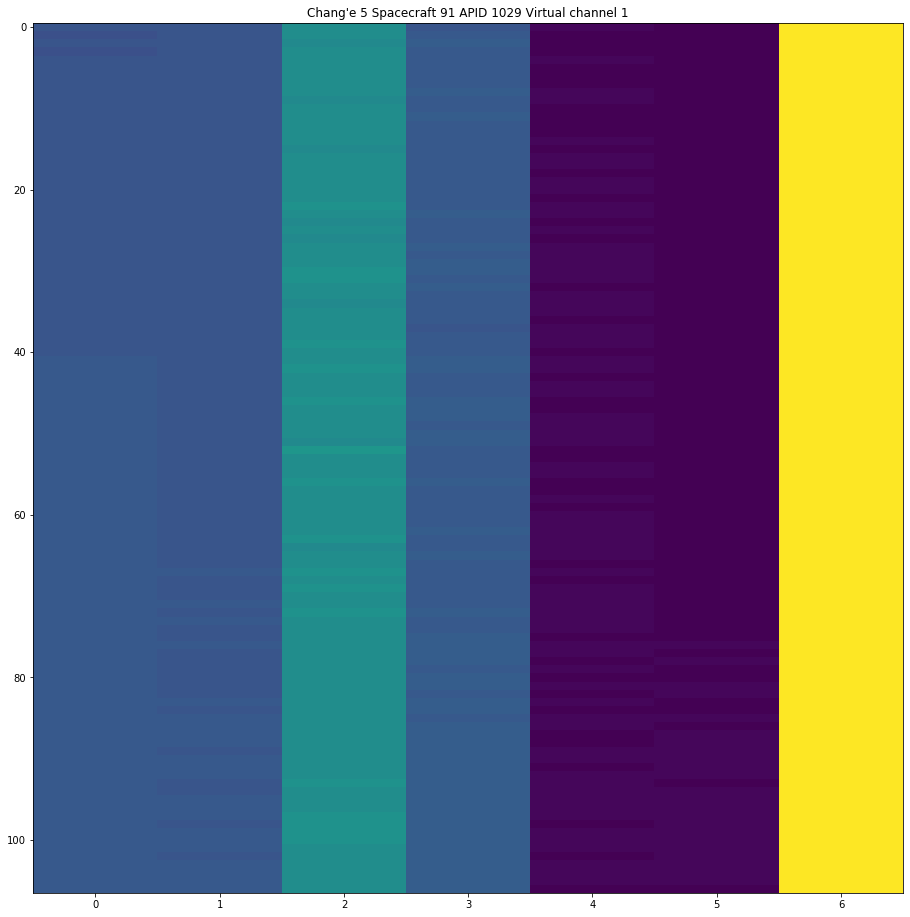

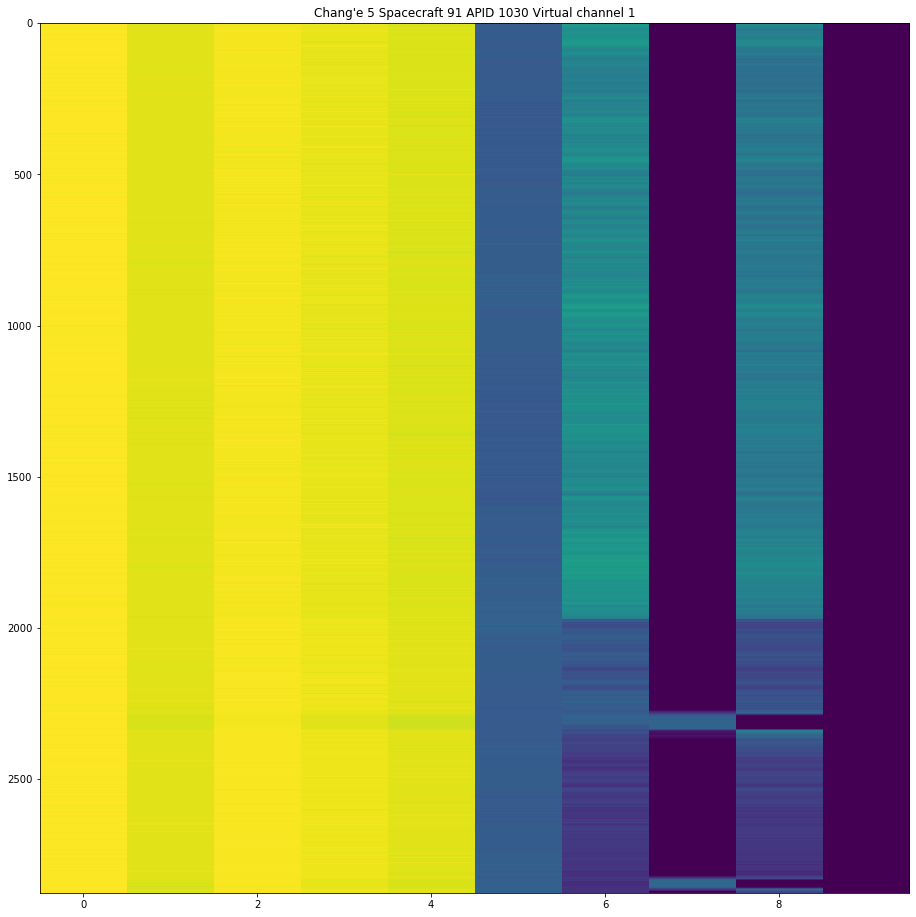

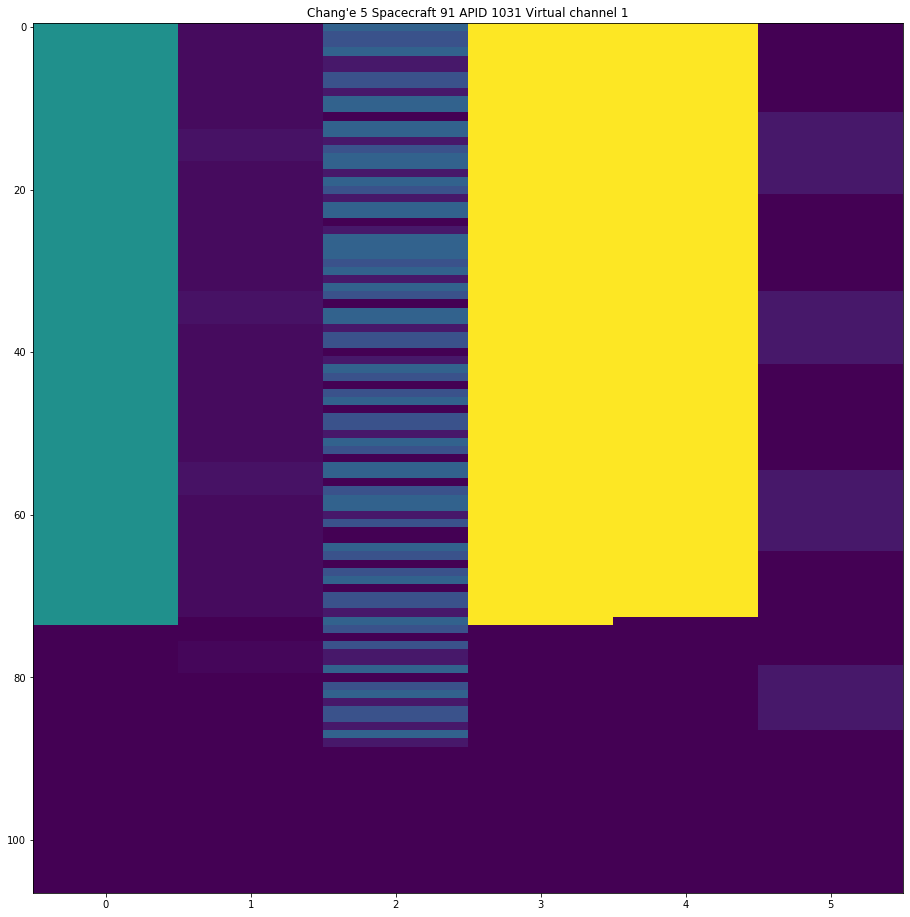

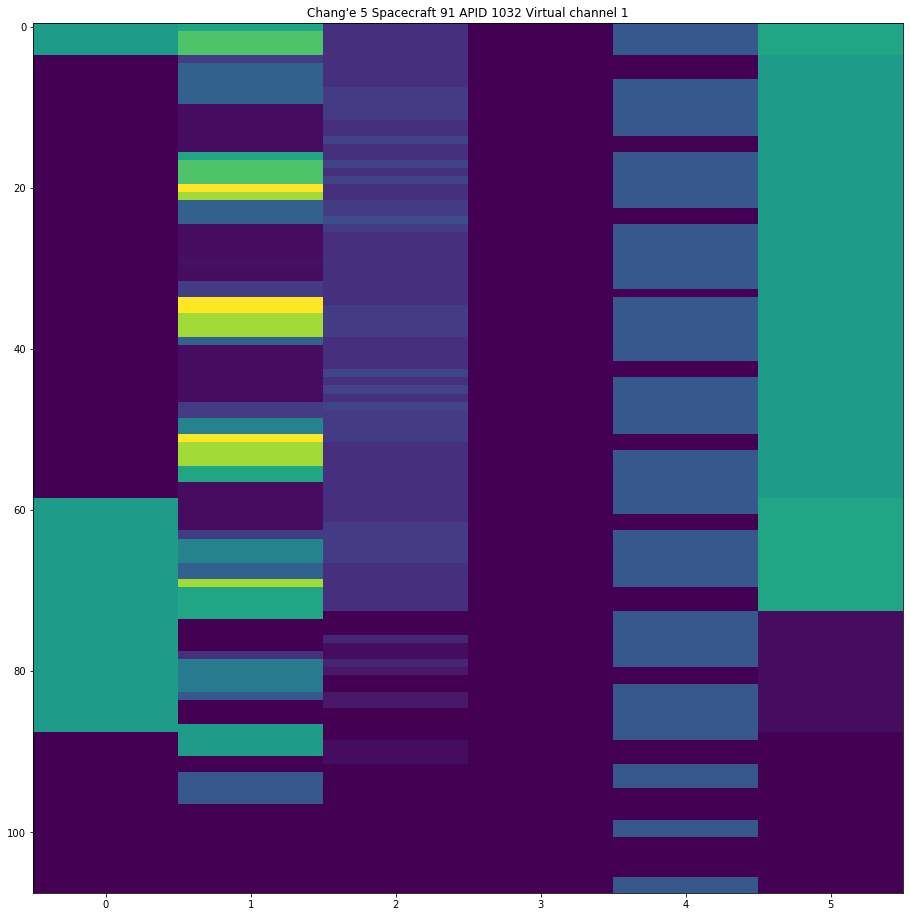

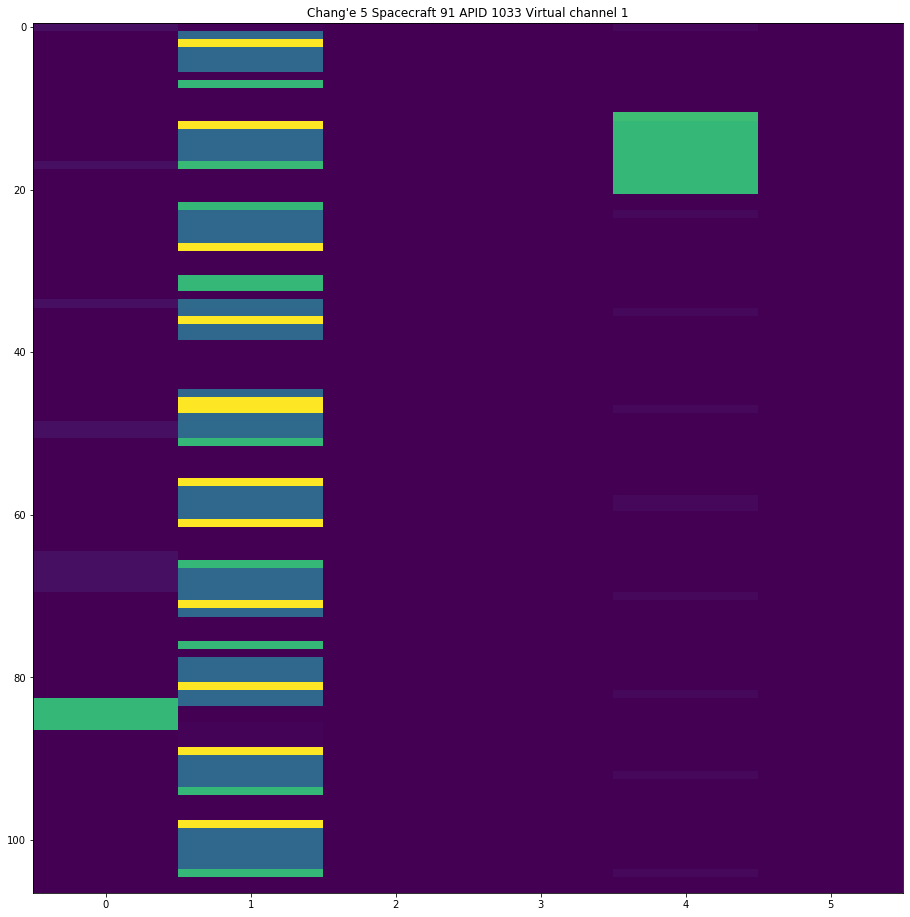

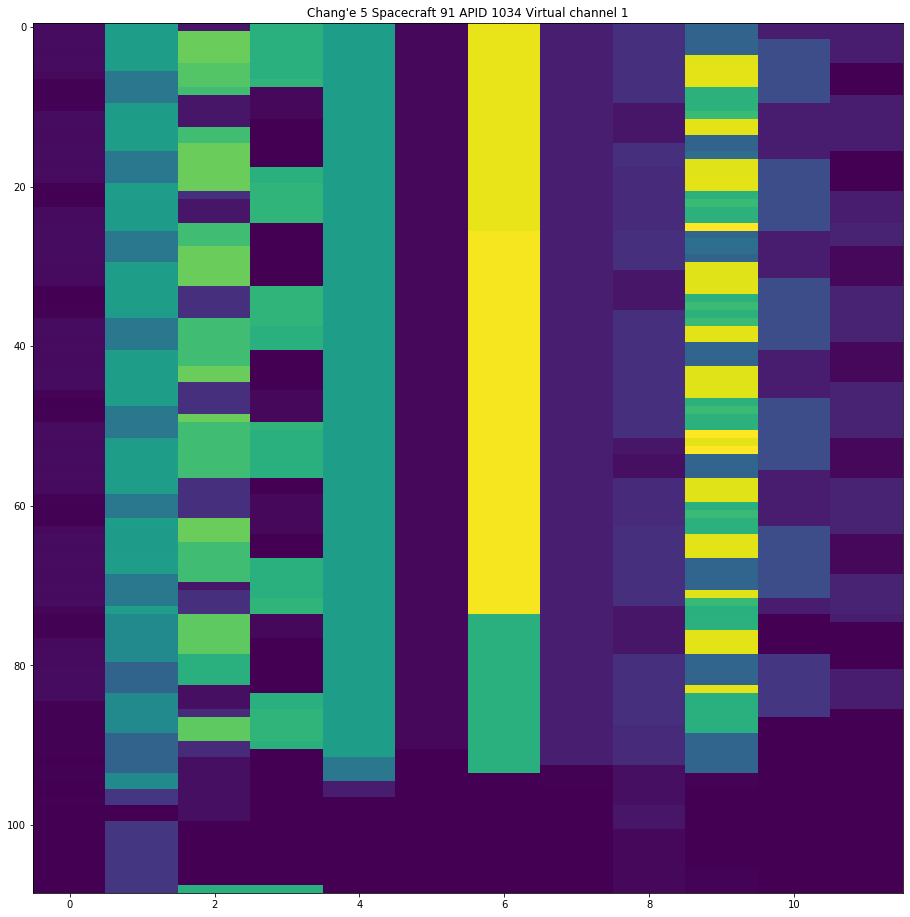

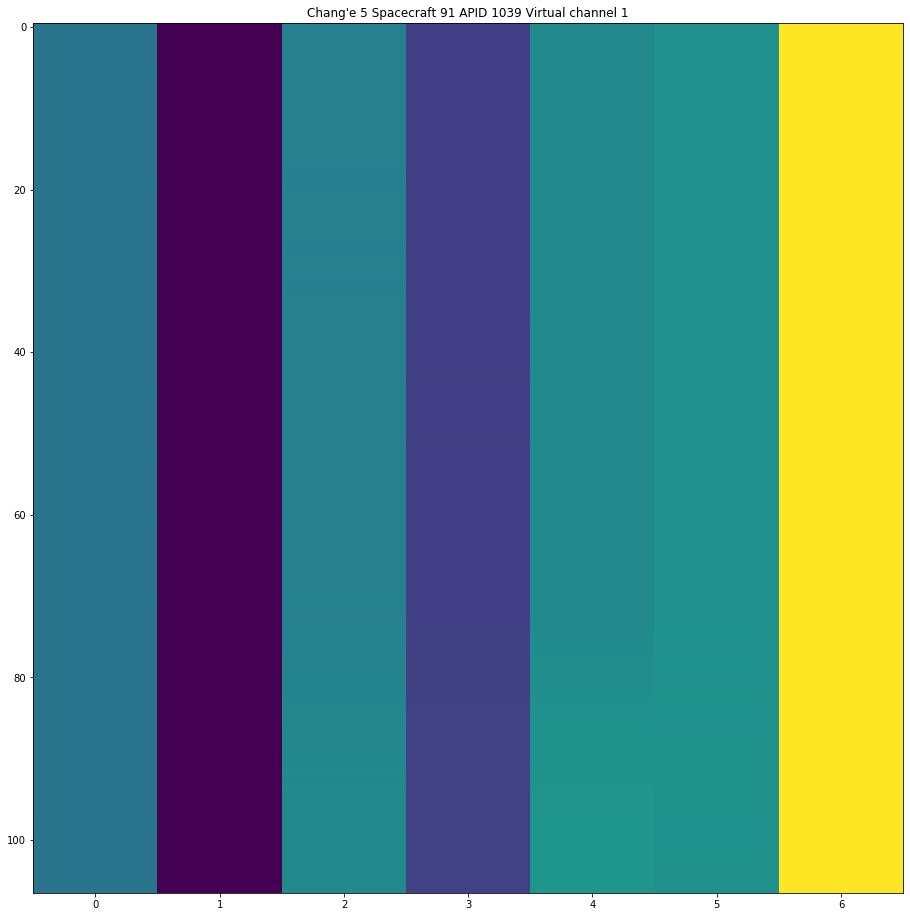

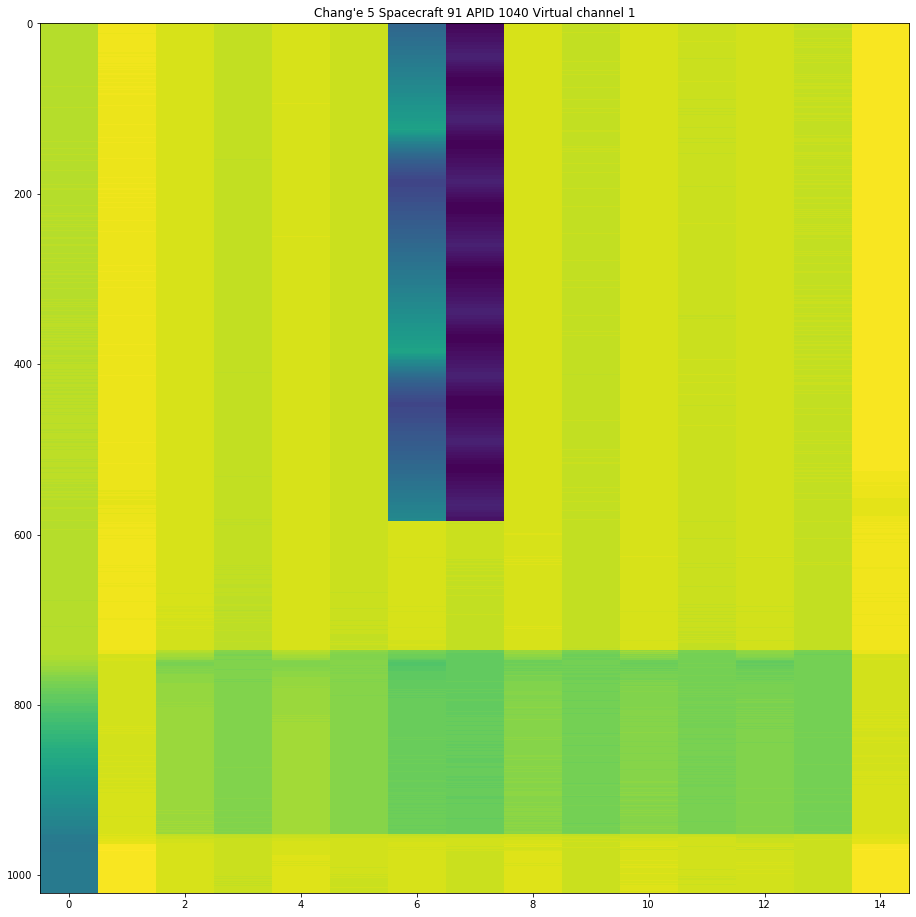

In [23]:
plot_apids(sc91_vc1_by_apid, 91, 1)

## Spacecraft 108 Virtual channel 1

In [24]:
sc108_vc1 = {}
for chan in (1,3):
    sc108_vc1.update({k[1] : v for k,v in aos_by_seq[chan].items() if k[0] == 1})

sc108_vc1 = [x[1] for x in sorted(sc108_vc1.items(), key = lambda x: x[0])]
fc = np.array([a.primary_header.virtual_channel_frame_count for a in sc108_vc1])
t = get_timestamps([a.insert_zone.timestamp for a in sc108_vc1])

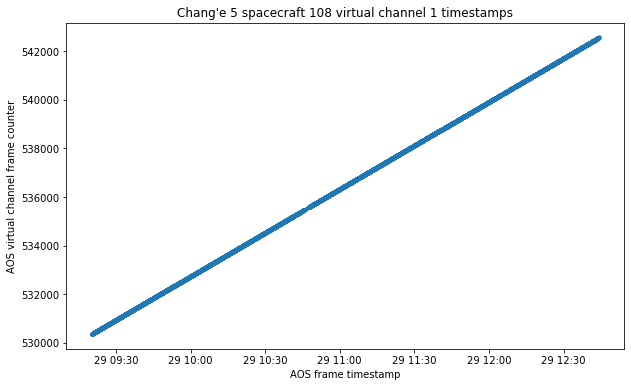

In [25]:
plt.figure(figsize = (10,6), facecolor = 'w')
plt.plot(t, fc, '.')
plt.title("Chang'e 5 spacecraft 108 virtual channel 1 timestamps")
plt.xlabel('AOS frame timestamp')
plt.ylabel('AOS virtual channel frame counter');

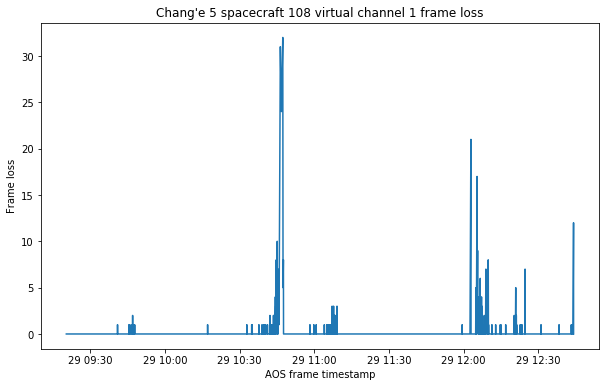

In [26]:
plt.figure(figsize = (10,6), facecolor = 'w')
plt.plot(t[1:], np.diff(fc)-1)
plt.title("Chang'e 5 spacecraft 108 virtual channel 1 frame loss")
plt.xlabel('AOS frame timestamp')
plt.ylabel('Frame loss');

In [27]:
sc108_vc1_packets = list(ccsds.extract_space_packets(sc108_vc1, 108, 1, get_timestamps = True))
sc108_vc1_sp_headers = [ccsds.SpacePacketPrimaryHeader.parse(p[0]) for p in sc108_vc1_packets]
sc108_vc1_apids = collections.Counter([p.APID for p in sc108_vc1_sp_headers])
sc108_vc1_apids

../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 108 VC 1] Broken stream. Last frame count 531590, current frame count 531592
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 108 VC 1] Broken stream. Last frame count 531865, current frame count 531867
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 108 VC 1] Broken stream. Last frame count 531887, current frame count 531889
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space

../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 108 VC 1] Broken stream. Last frame count 535423, current frame count 535427
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 108 VC 1] Broken stream. Last frame count 535427, current frame count 535438
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 108 VC 1] Broken stream. Last frame count 535439, current frame count 535442
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space

../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 108 VC 1] Broken stream. Last frame count 536752, current frame count 536754
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 108 VC 1] Broken stream. Last frame count 536755, current frame count 536759
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 108 VC 1] Broken stream. Last frame count 536759, current frame count 536761
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space

../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 108 VC 1] Broken stream. Last frame count 539883, current frame count 539885
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 108 VC 1] Broken stream. Last frame count 540074, current frame count 540096
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 108 VC 1] Broken stream. Last frame count 540211, current frame count 540217
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space

../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 108 VC 1] Broken stream. Last frame count 540384, current frame count 540386
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 108 VC 1] Broken stream. Last frame count 540392, current frame count 540394
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 108 VC 1] Broken stream. Last frame count 540394, current frame count 540396
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space

../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 108 VC 1] Broken stream. Last frame count 542517, current frame count 542519
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 108 VC 1] Broken stream. Last frame count 542523, current frame count 542525
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 108 VC 1] Broken stream. Last frame count 542558, current frame count 542571
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')


Counter({40: 5894,
         42: 2840,
         41: 3546,
         59: 5134,
         1030: 5850,
         43: 2871,
         14: 1849,
         27: 965,
         29: 960,
         281: 2823,
         49: 1773,
         1040: 2264,
         778: 403,
         810: 329,
         52: 3219,
         514: 1455,
         532: 3305,
         13: 1856,
         28: 1828,
         259: 842,
         282: 926,
         777: 1458,
         33: 1819,
         11: 965,
         4: 494,
         5: 1862,
         793: 755,
         34: 949,
         39: 949,
         2: 249,
         18: 246,
         50: 477,
         794: 103,
         7: 491,
         258: 444,
         520: 208,
         61: 820,
         30: 484,
         21: 245,
         51: 928,
         537: 758,
         515: 393,
         16: 244,
         22: 244,
         25: 245,
         26: 244,
         31: 487,
         542: 103,
         58: 241,
         35: 487,
         37: 483,
         48: 481,
         1025: 247,
         10

In [28]:
sc108_vc1_by_apid = {apid : [p for h,p in zip(sc108_vc1_sp_headers, sc108_vc1_packets)
                           if h.APID == apid] for apid in sc108_vc1_apids}

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


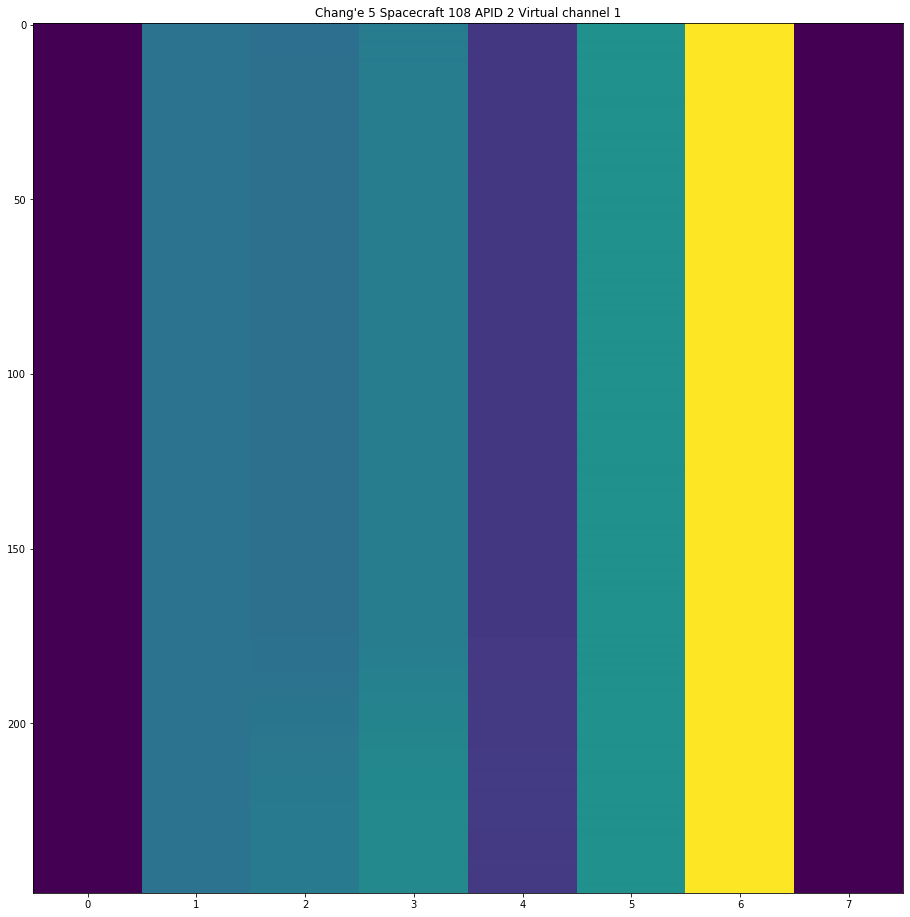

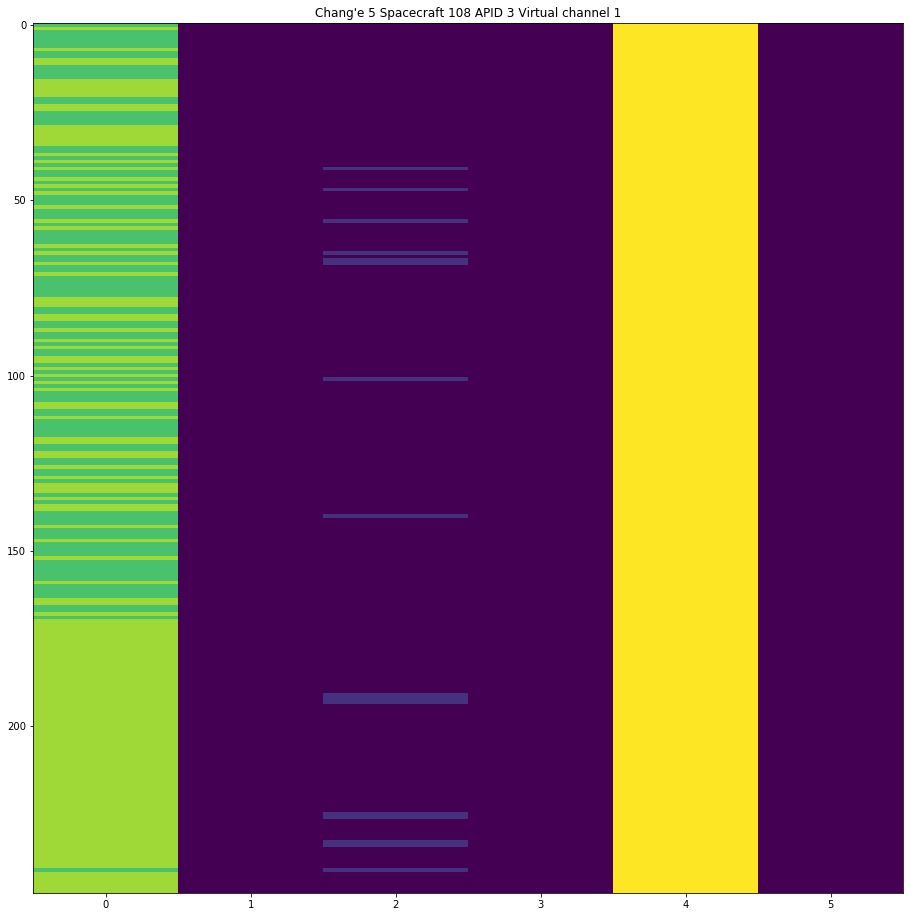

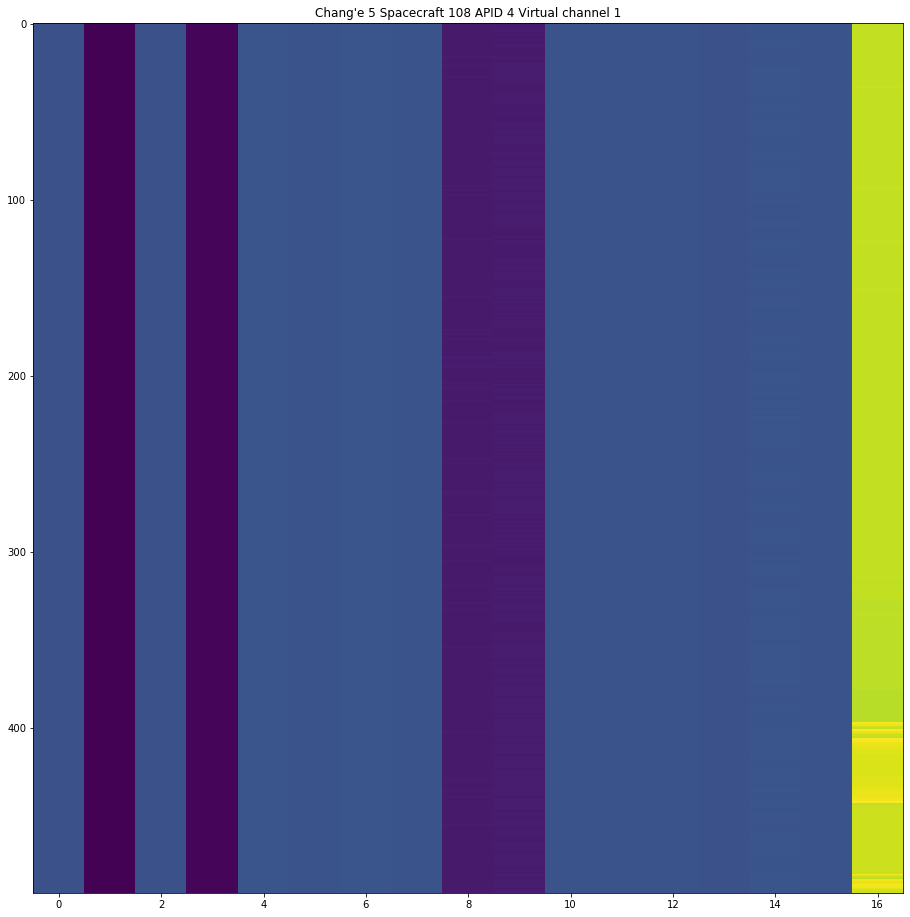

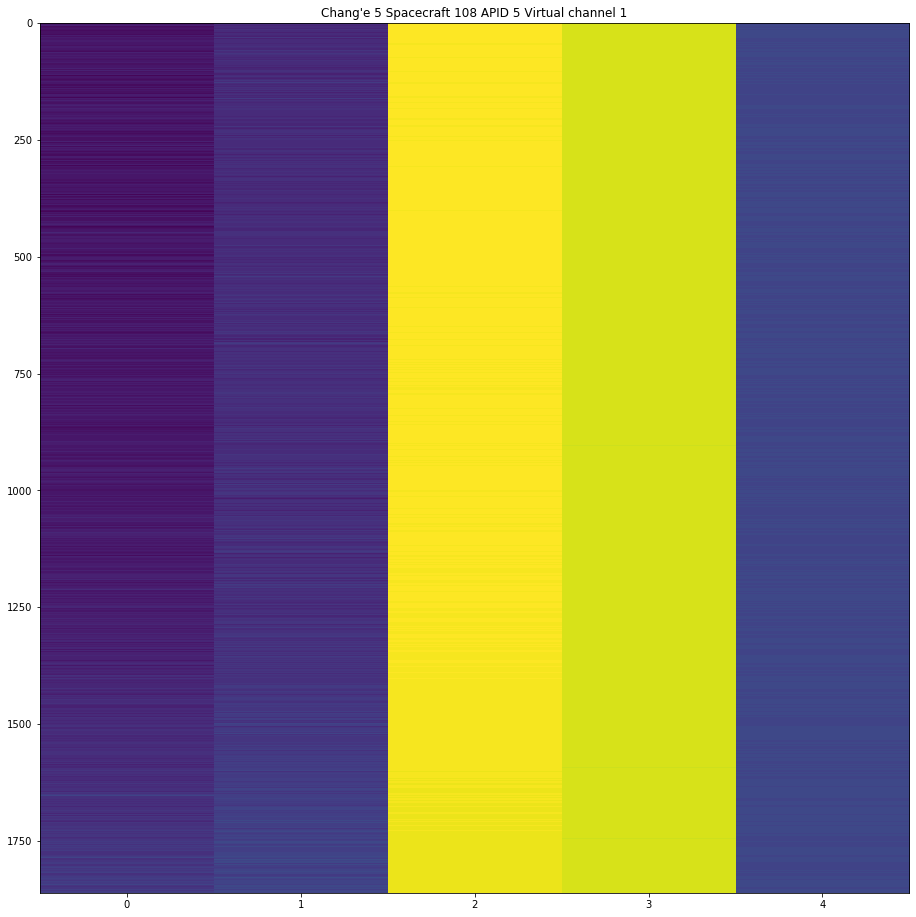

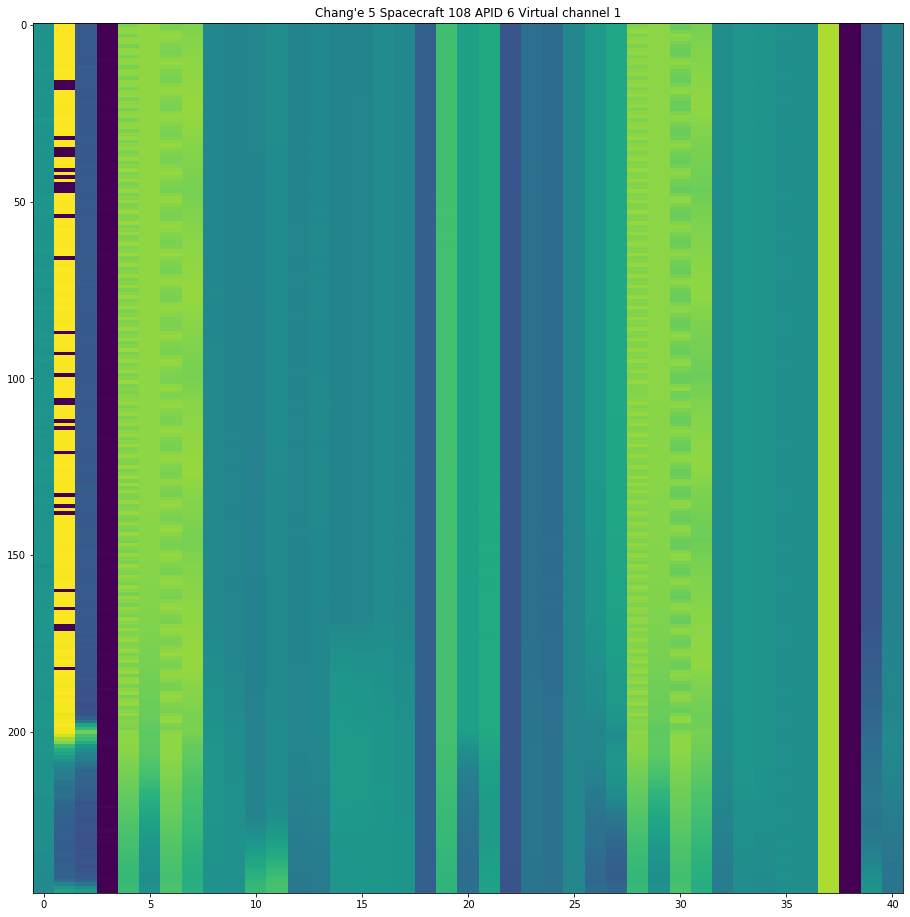

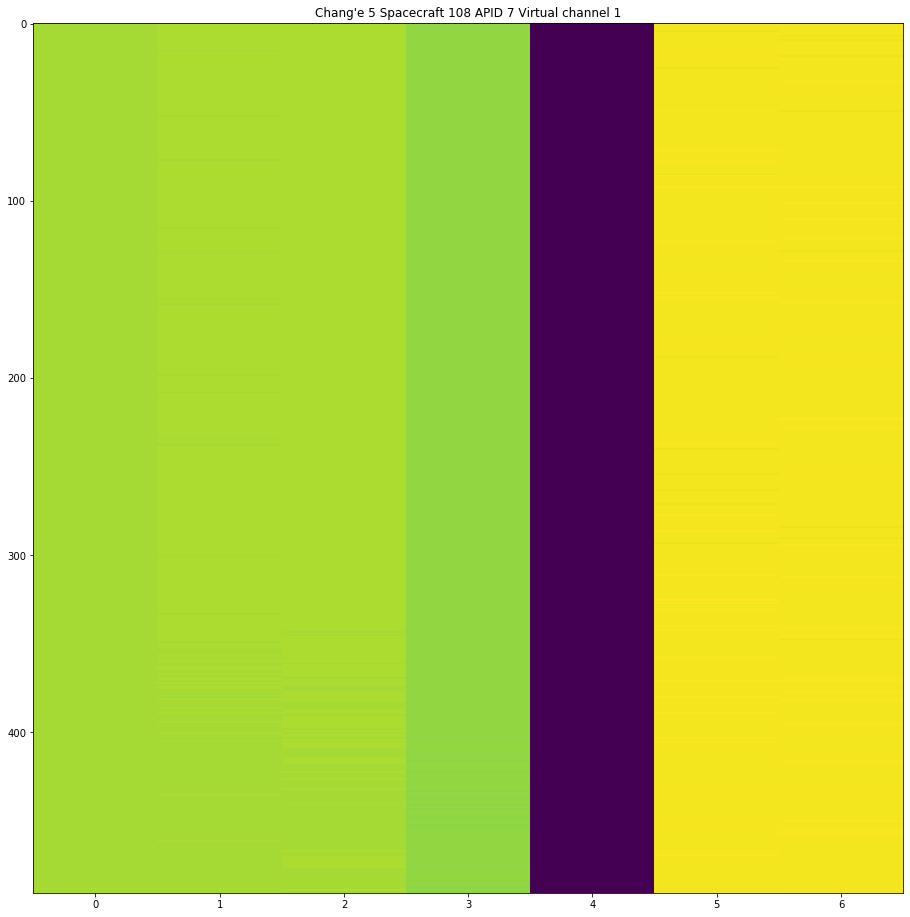

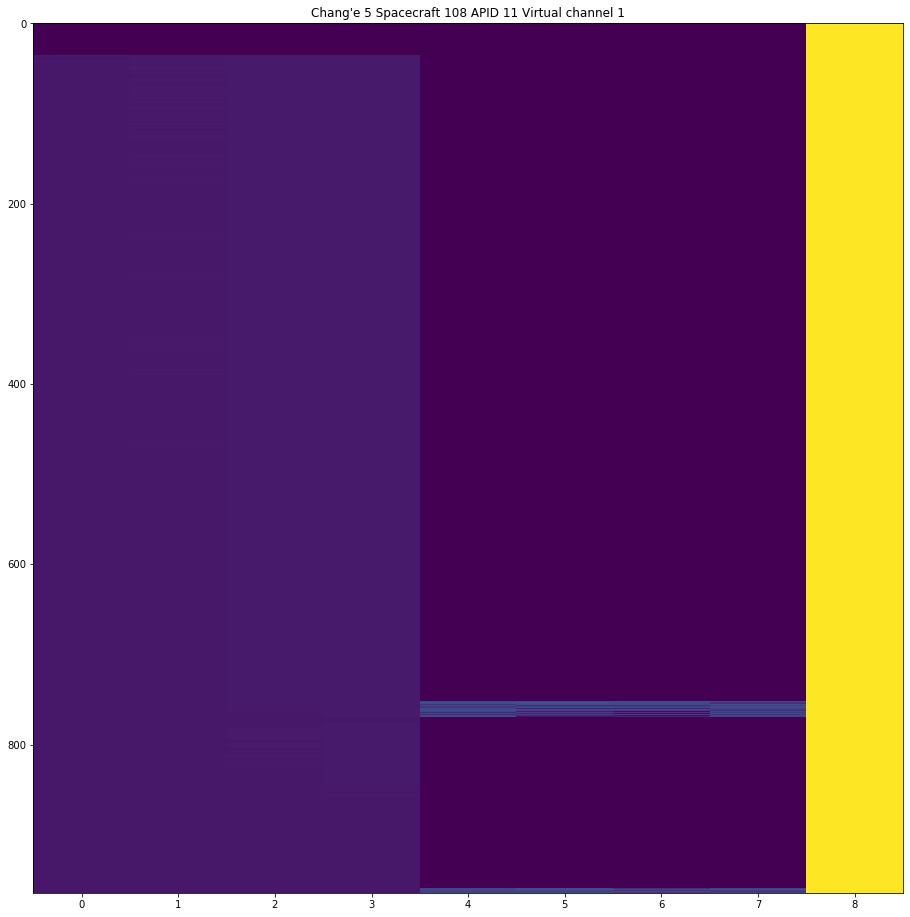

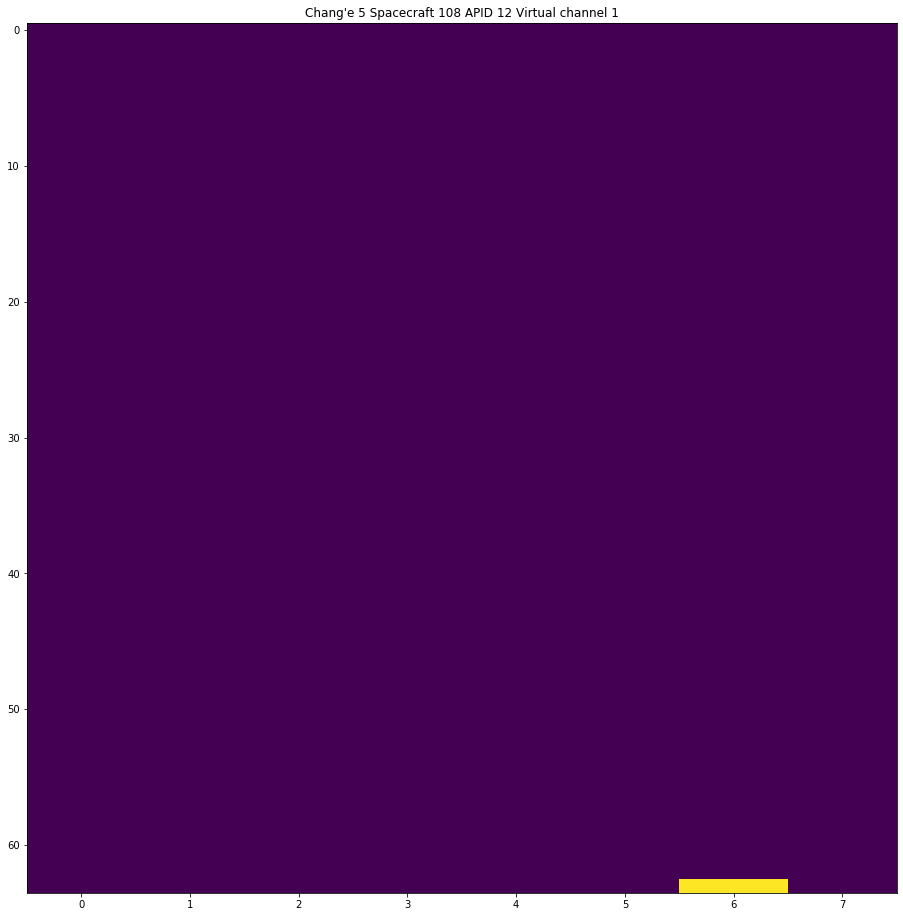

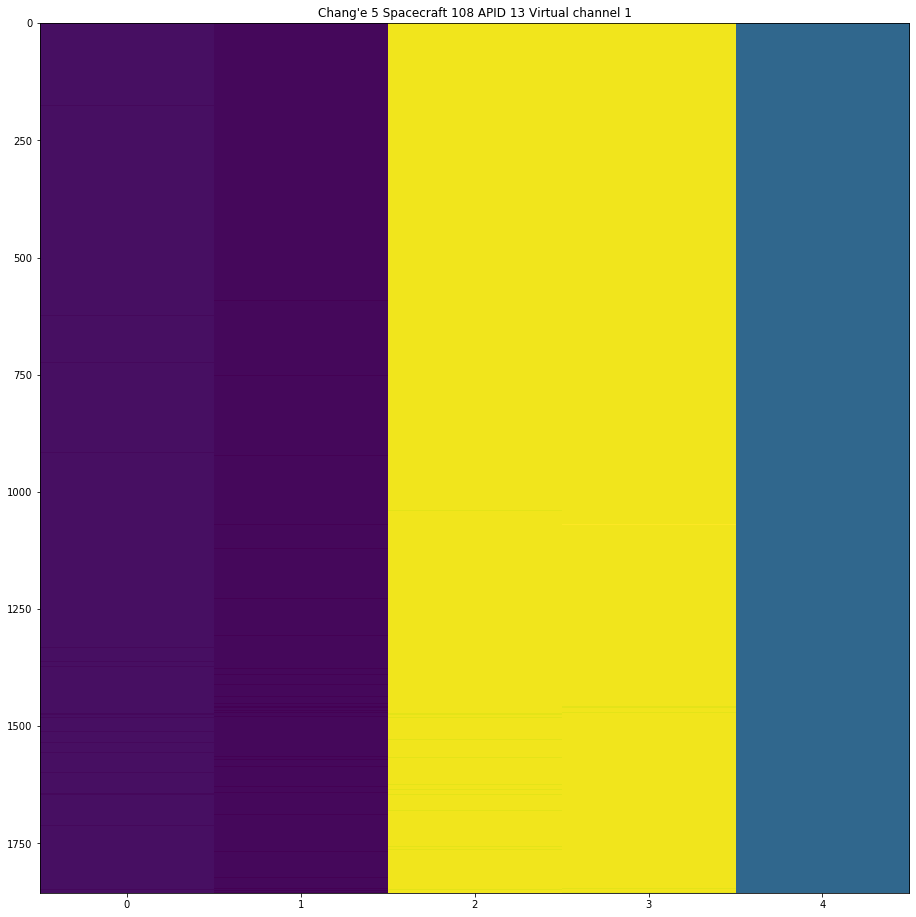

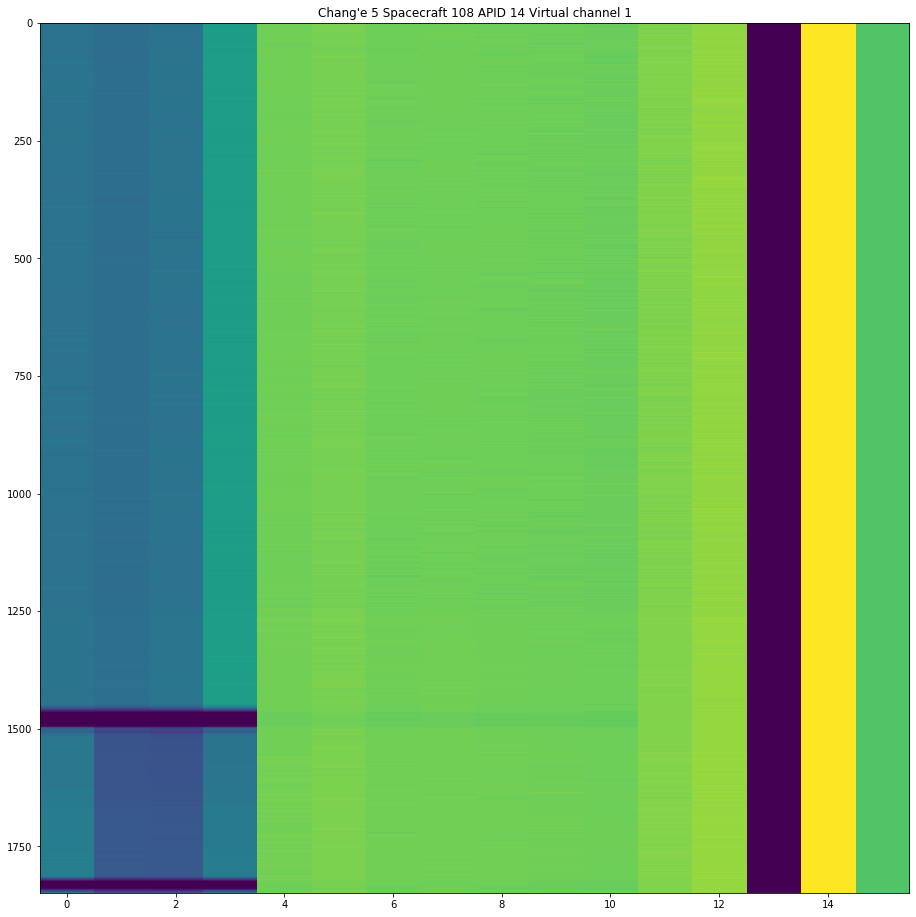

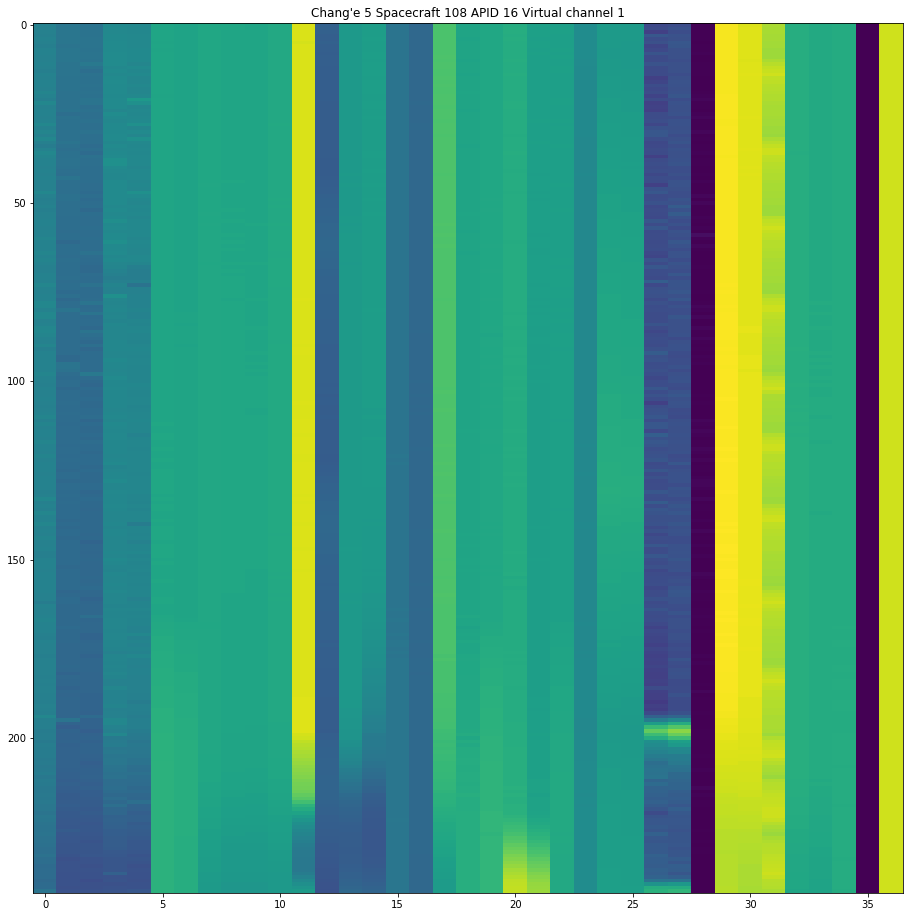

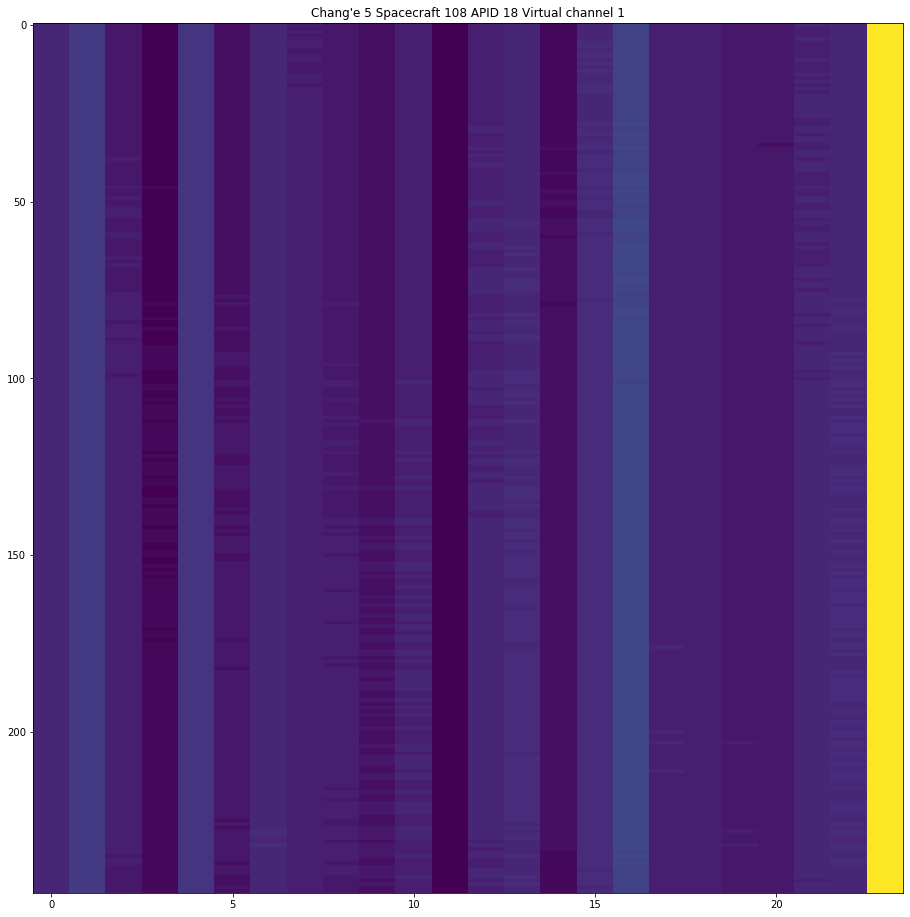

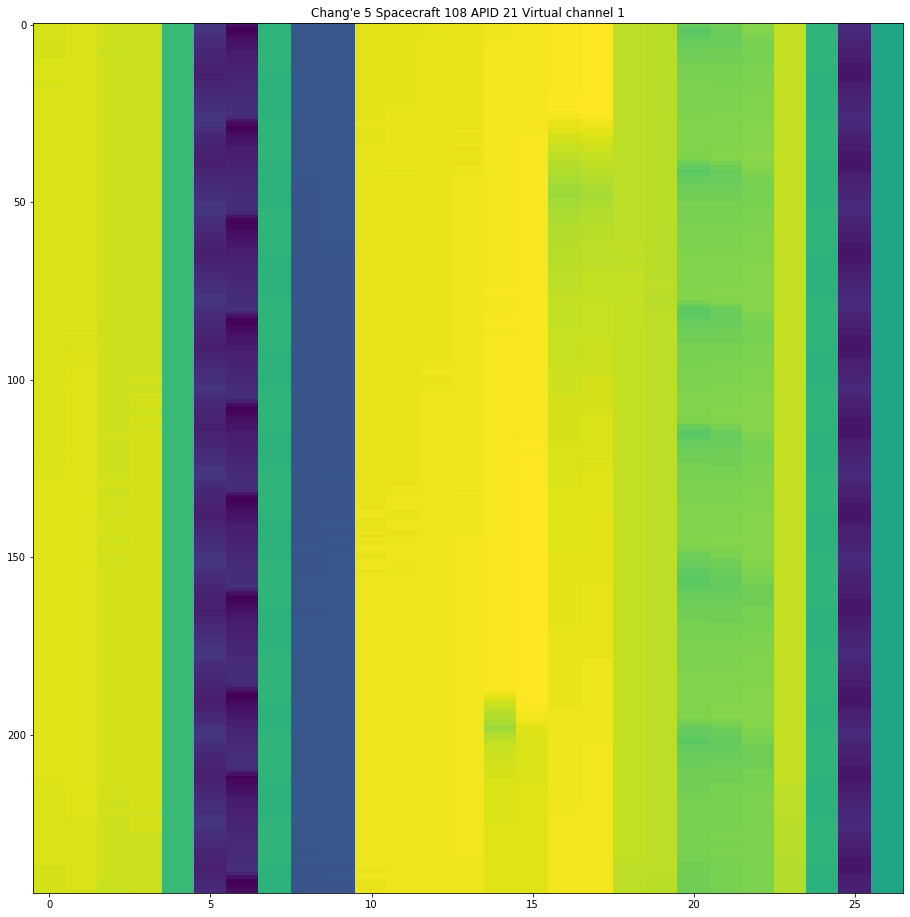

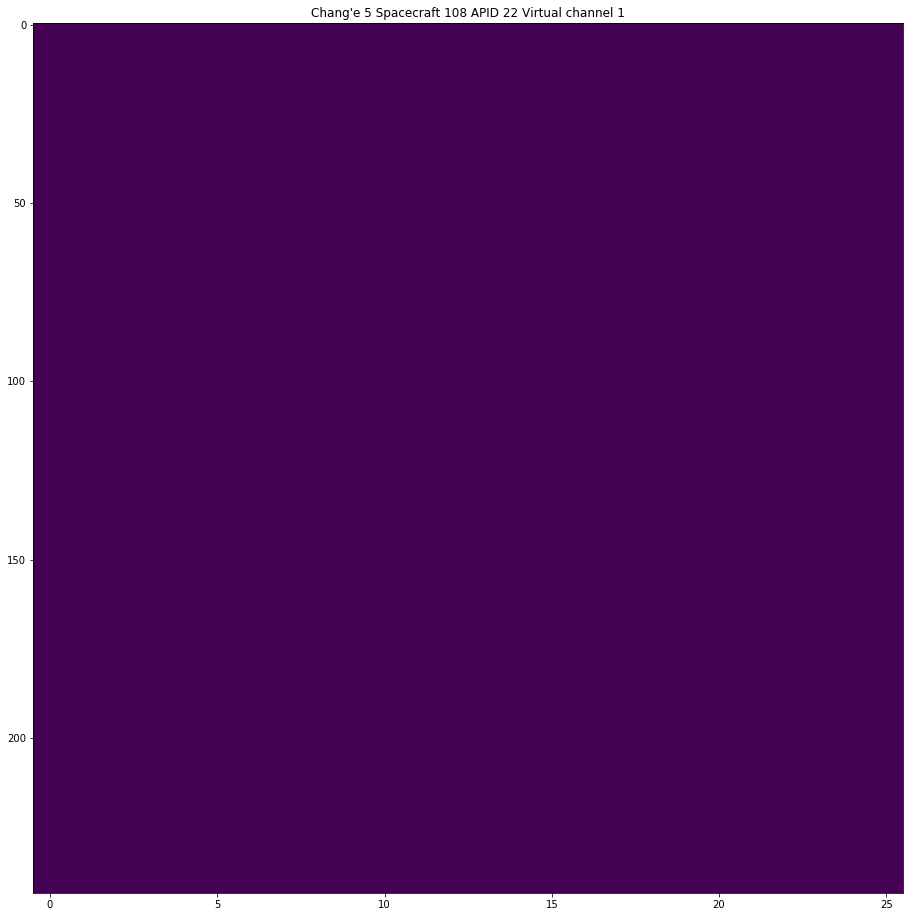

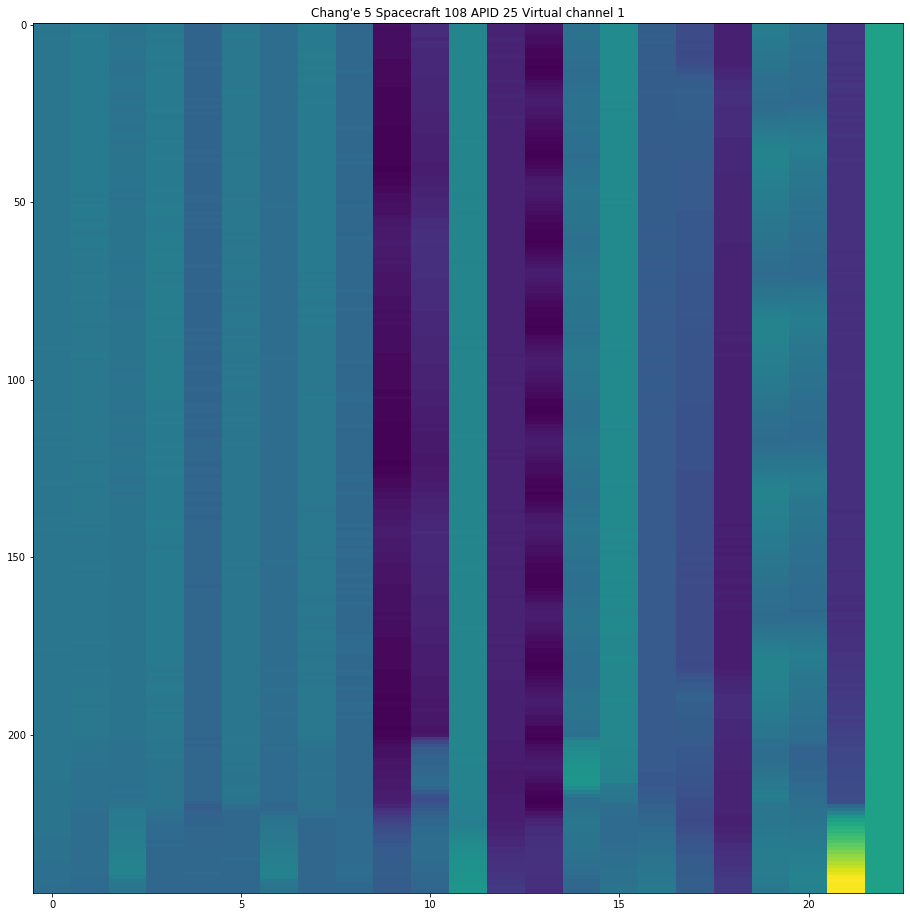

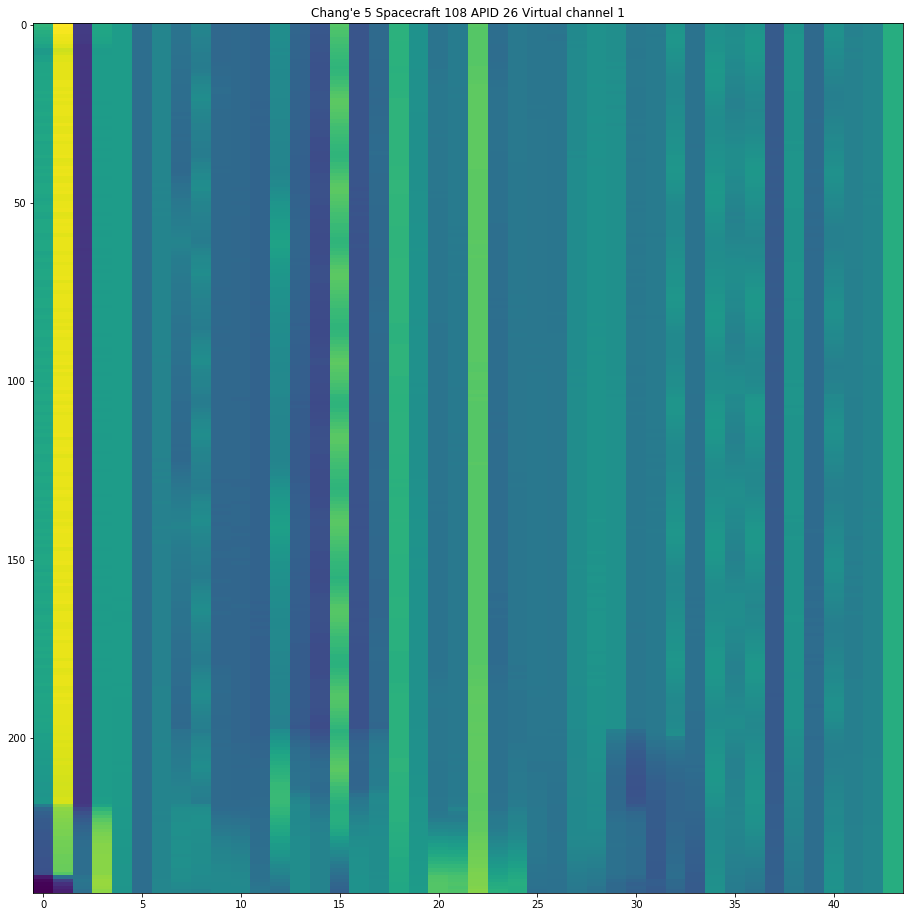

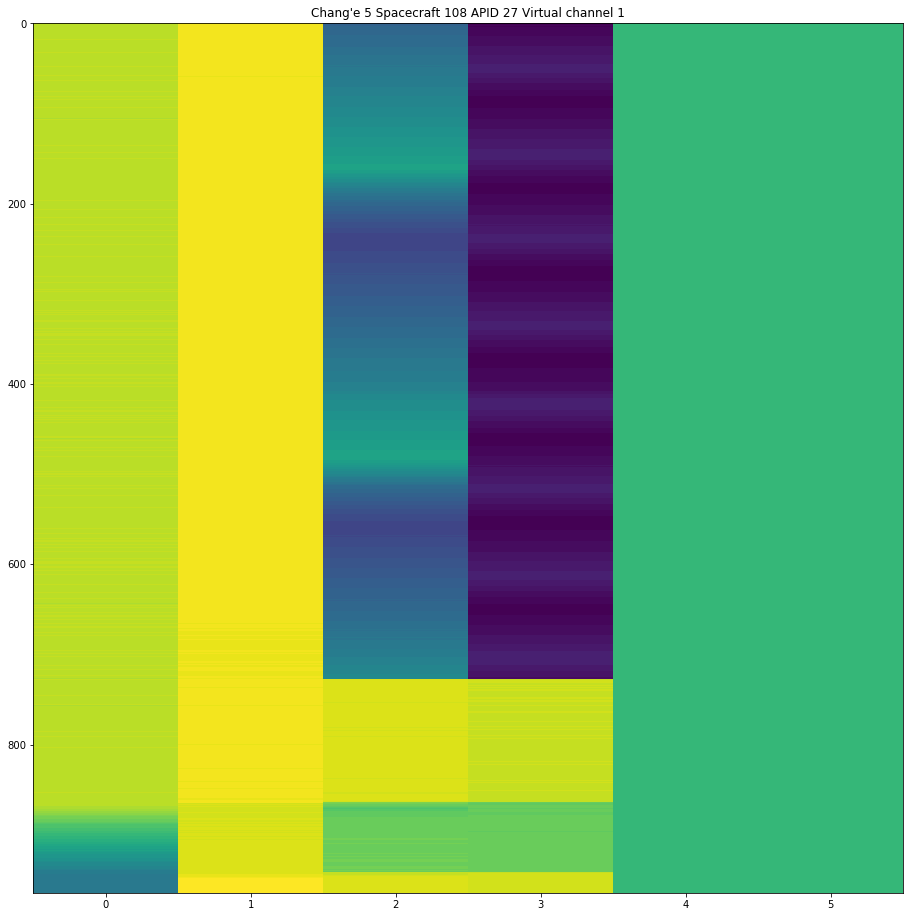

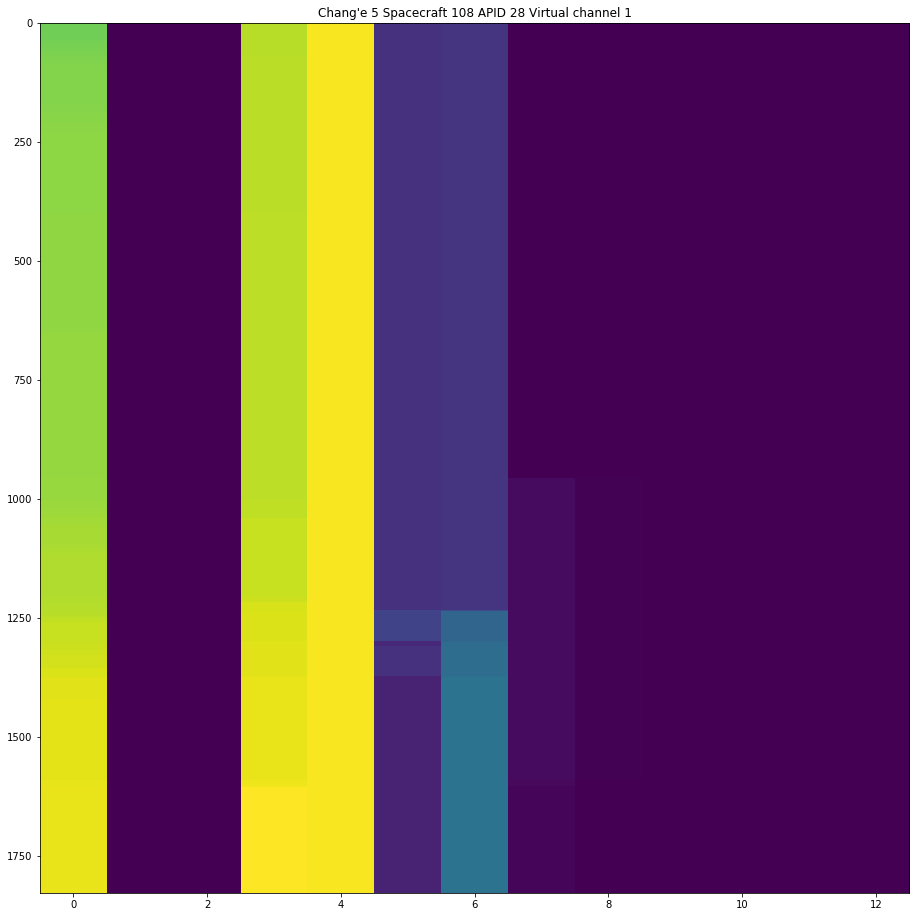

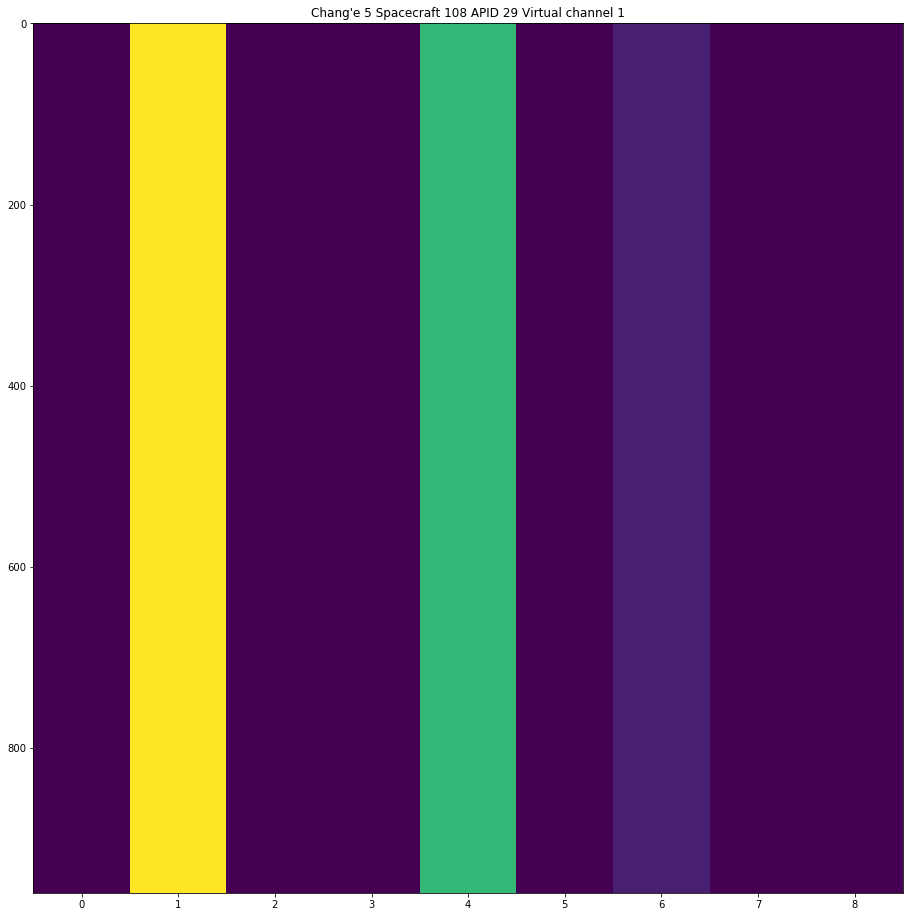

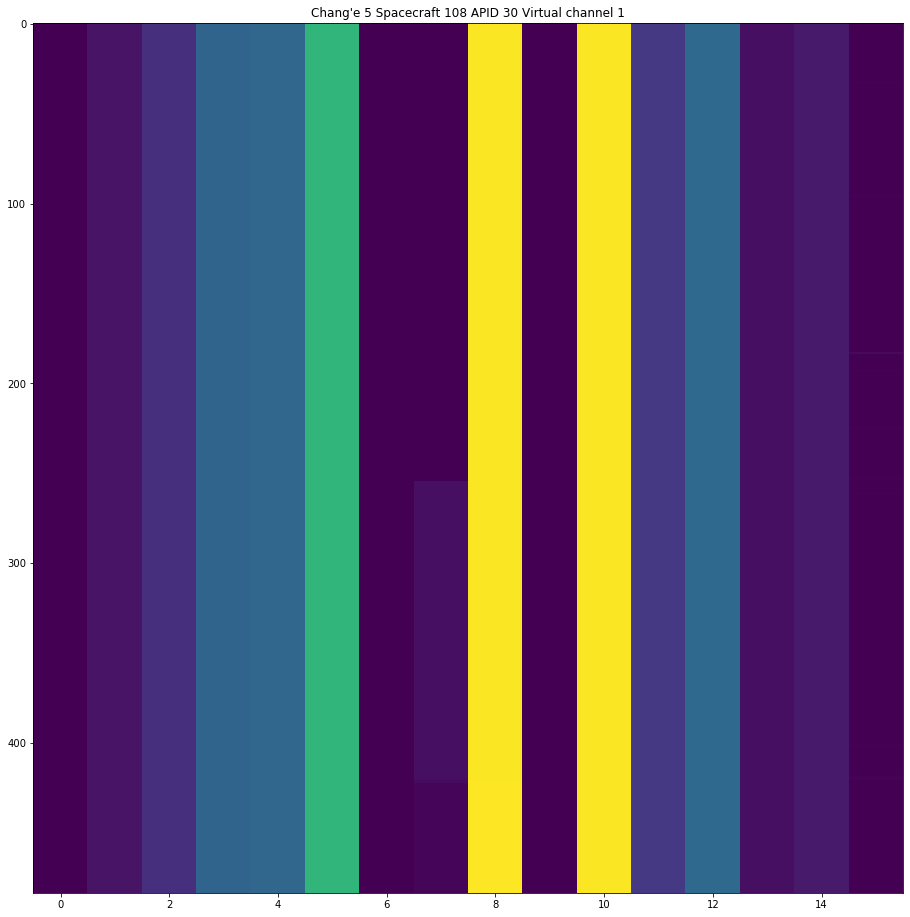

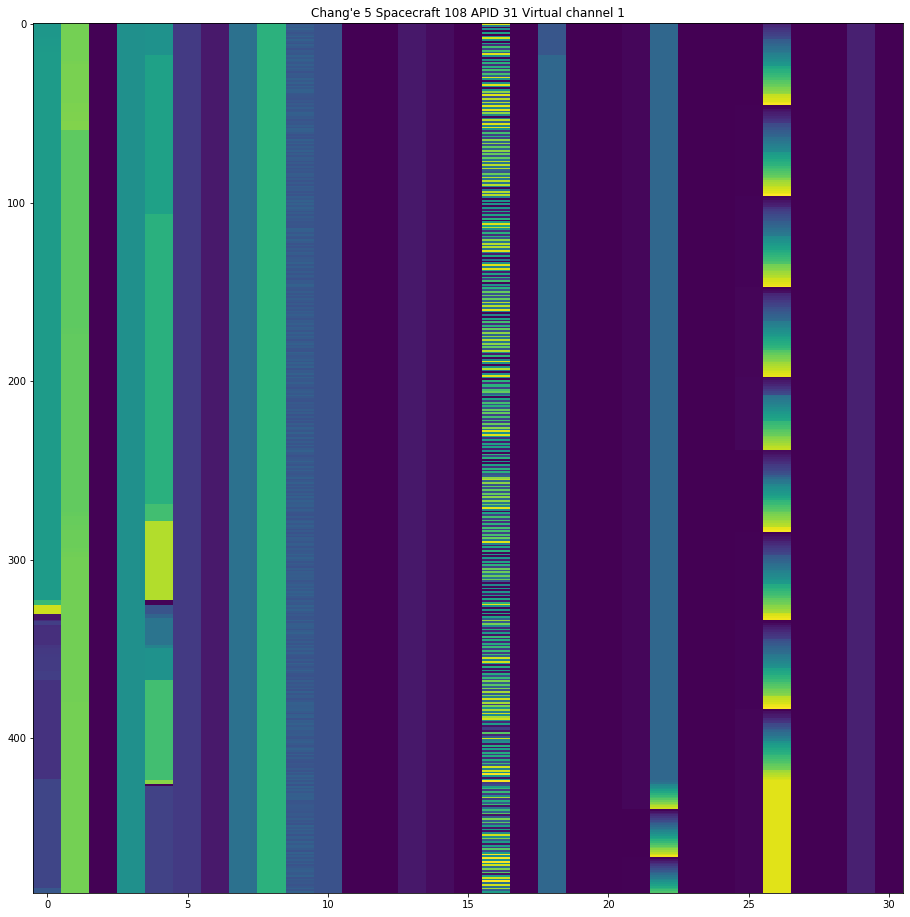

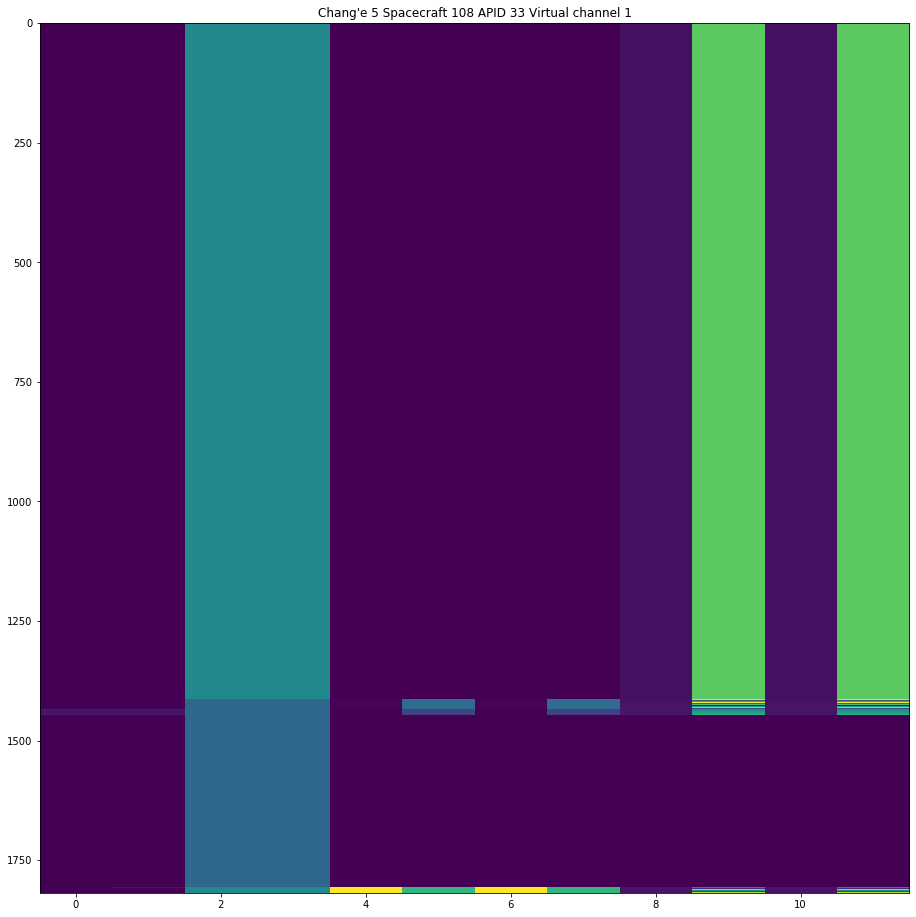

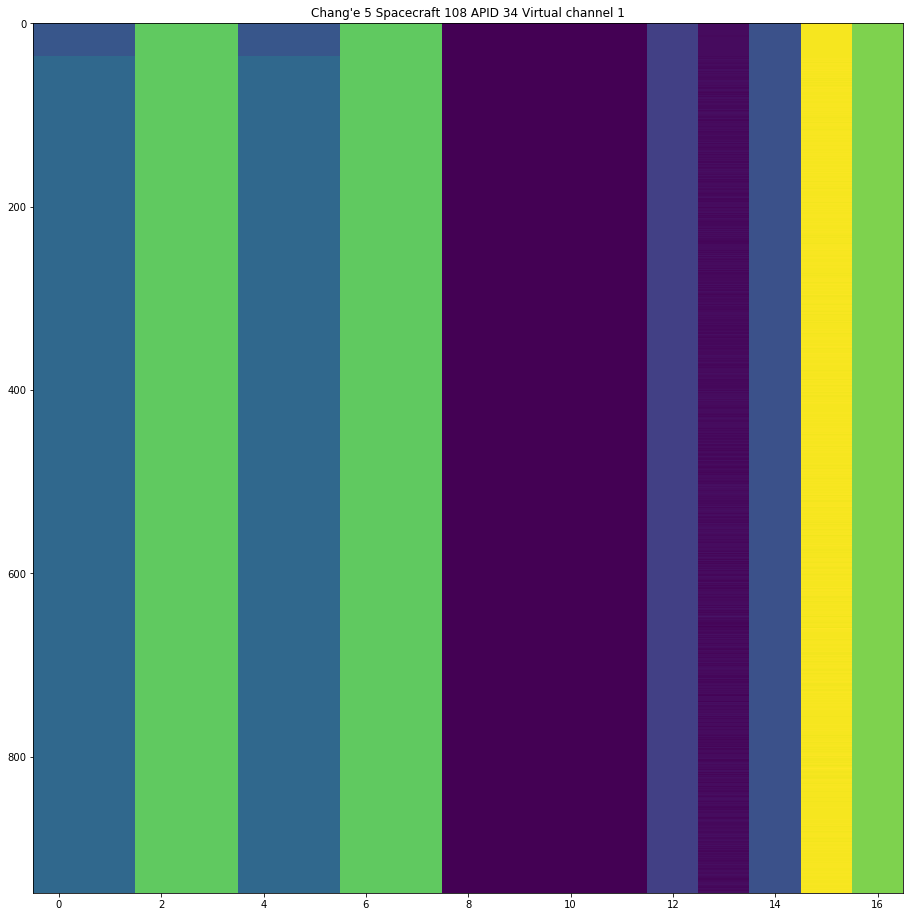

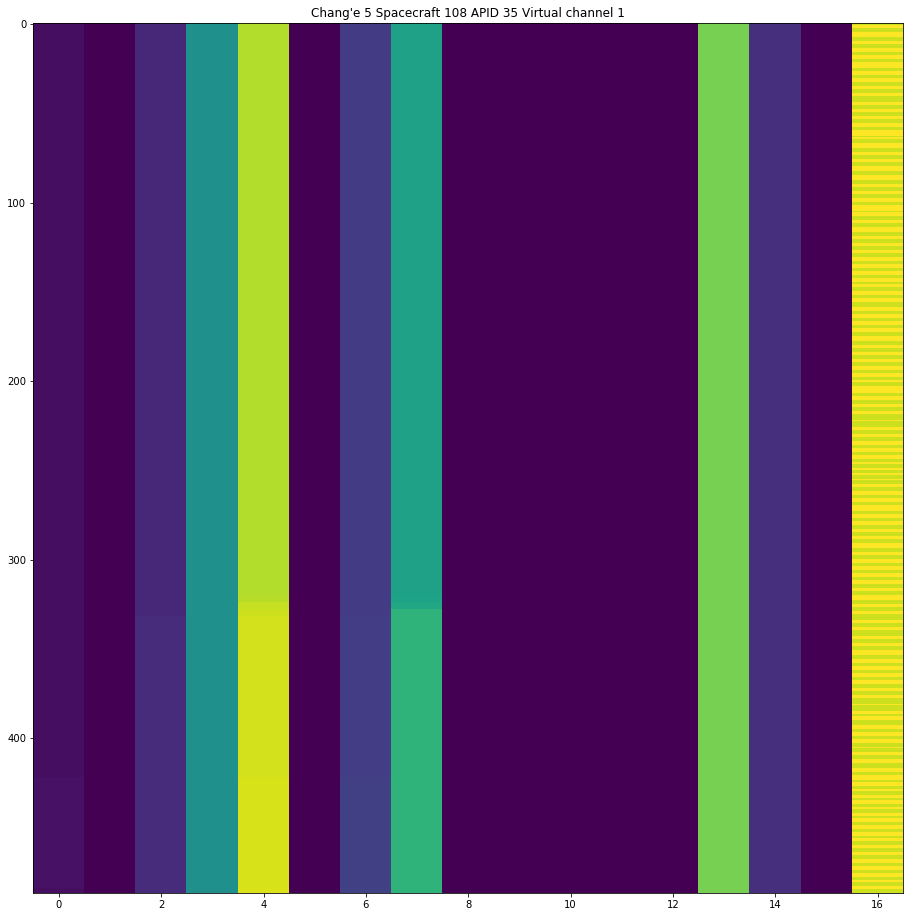

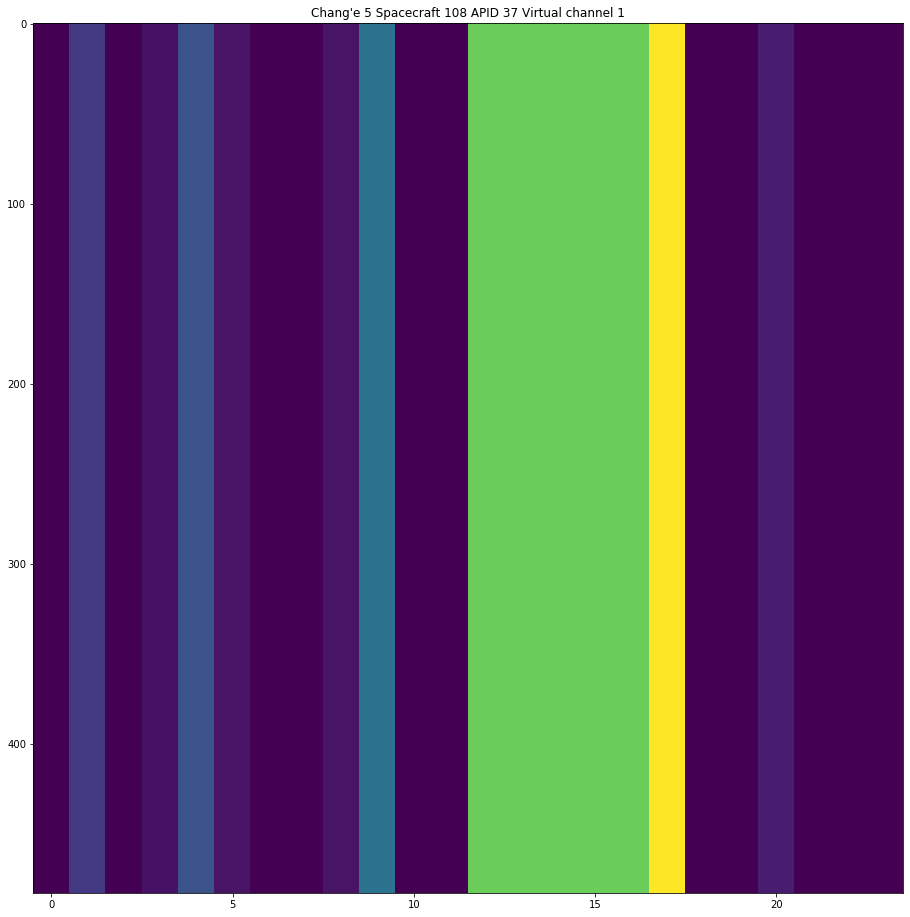

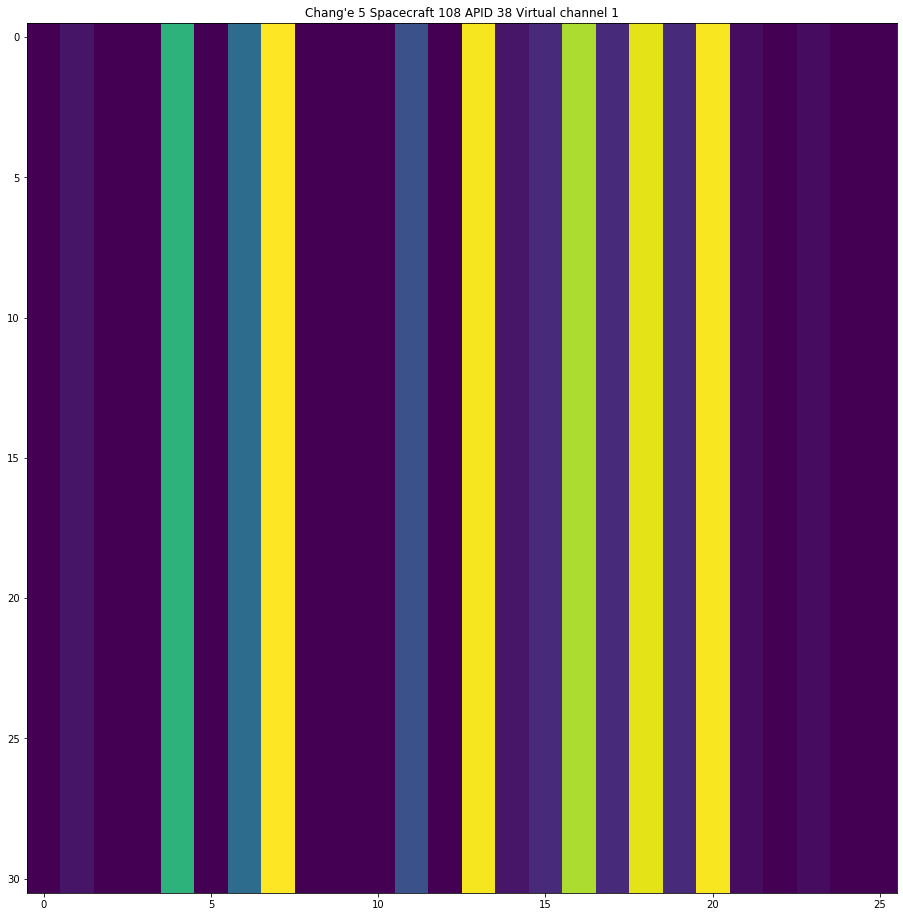

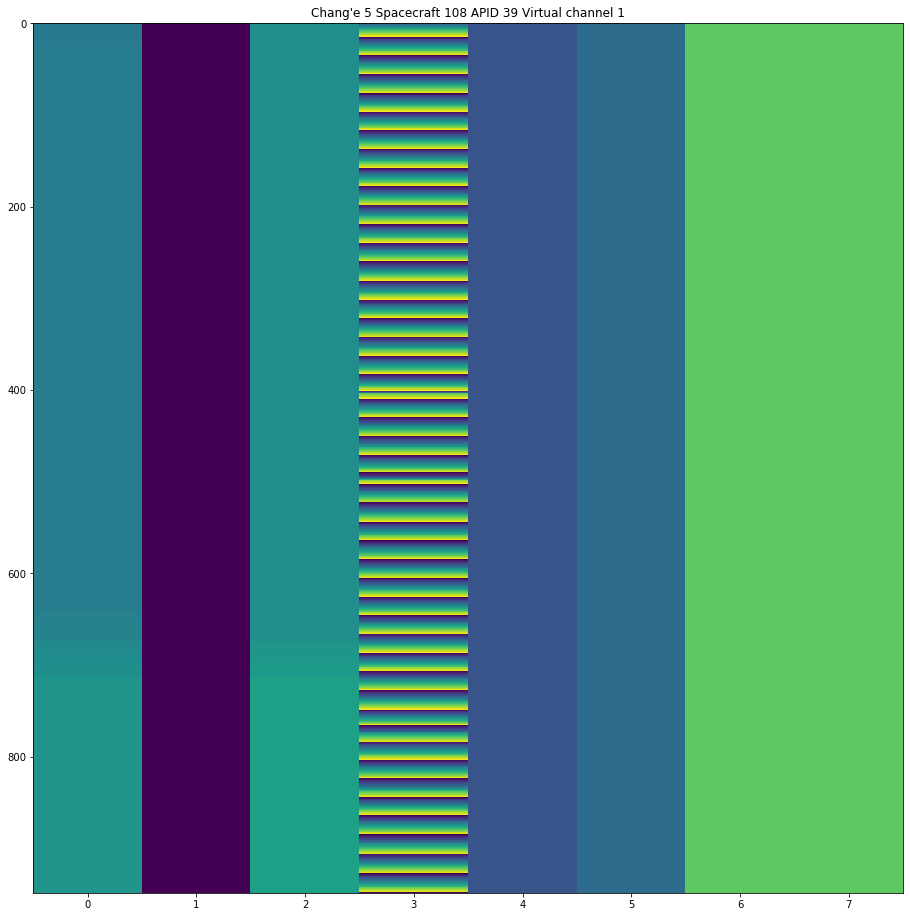

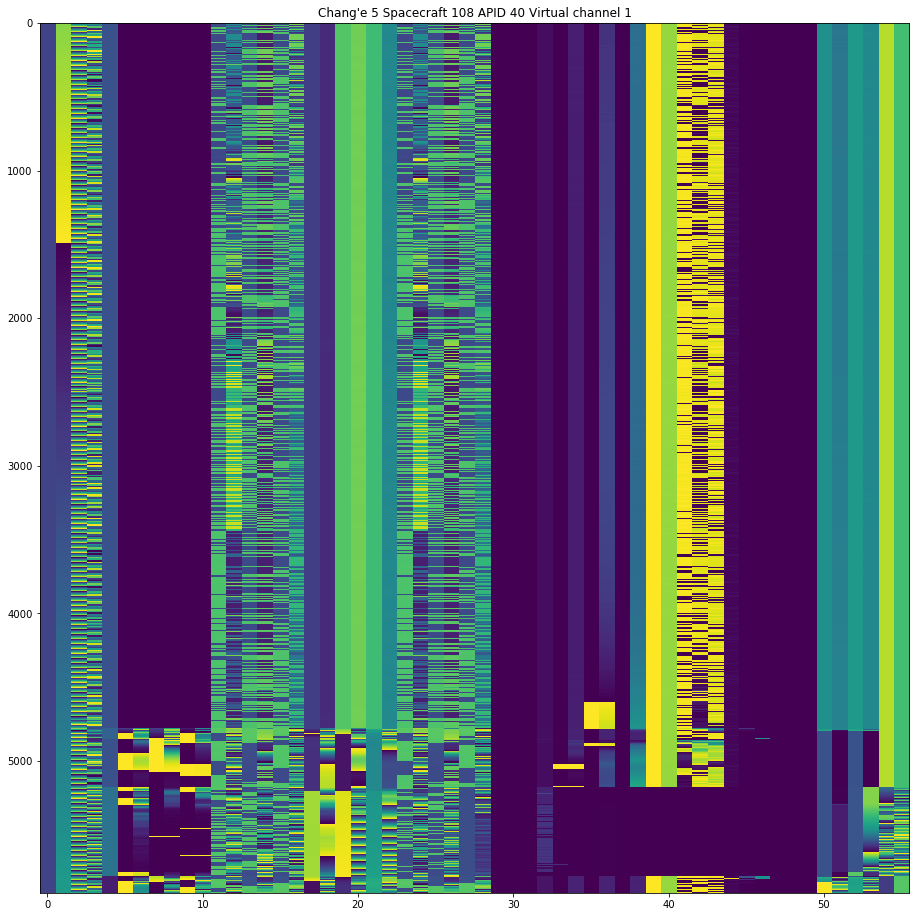

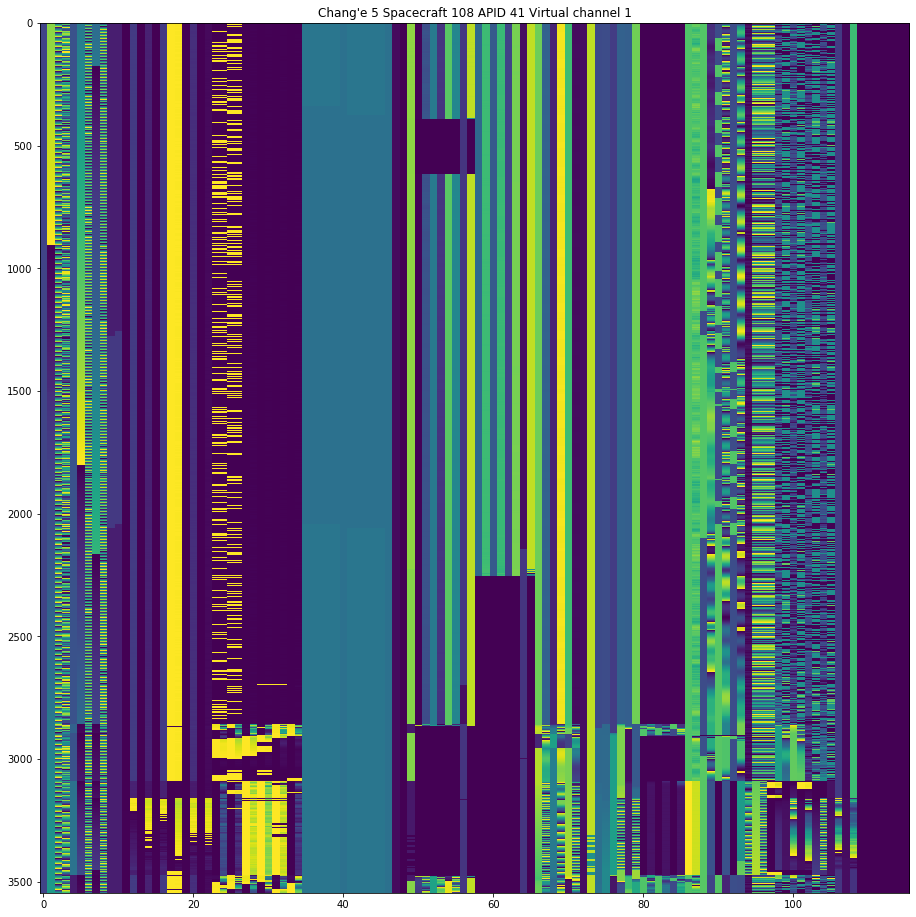

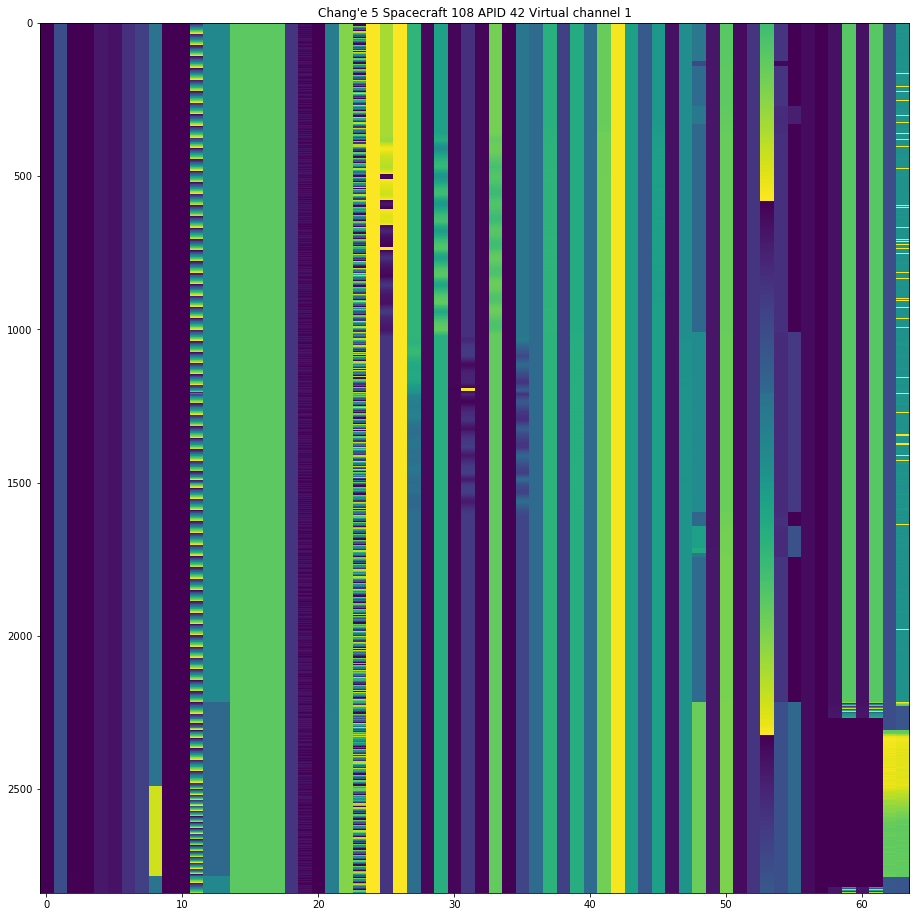

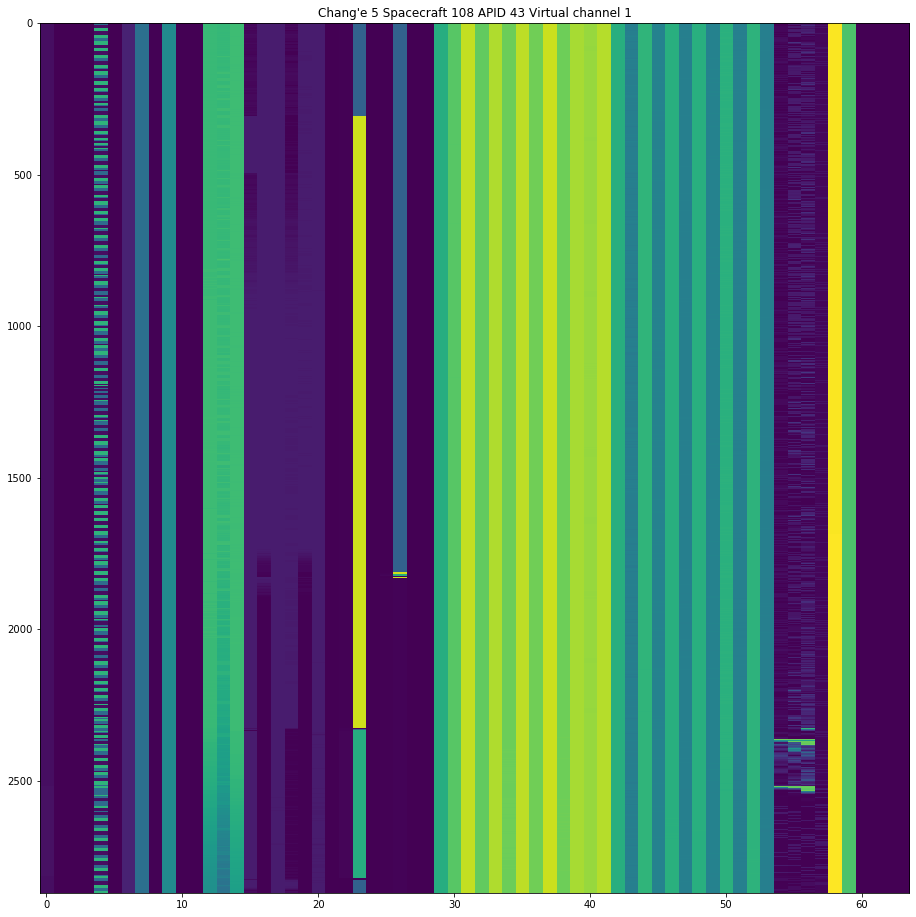

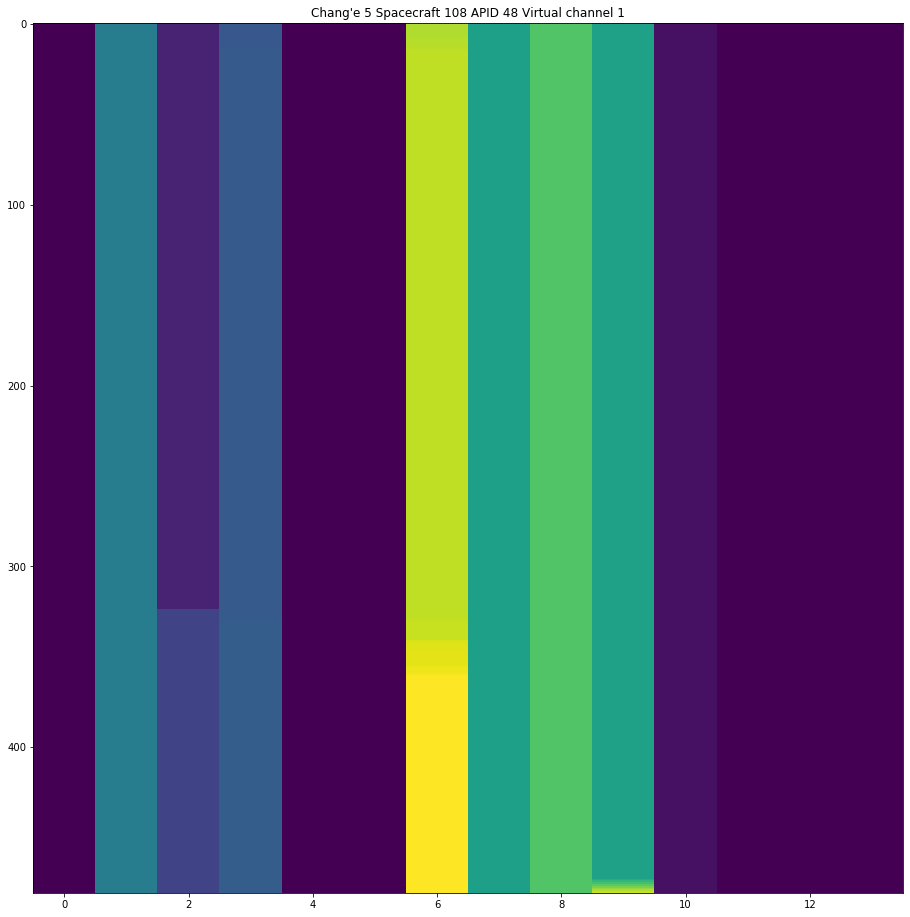

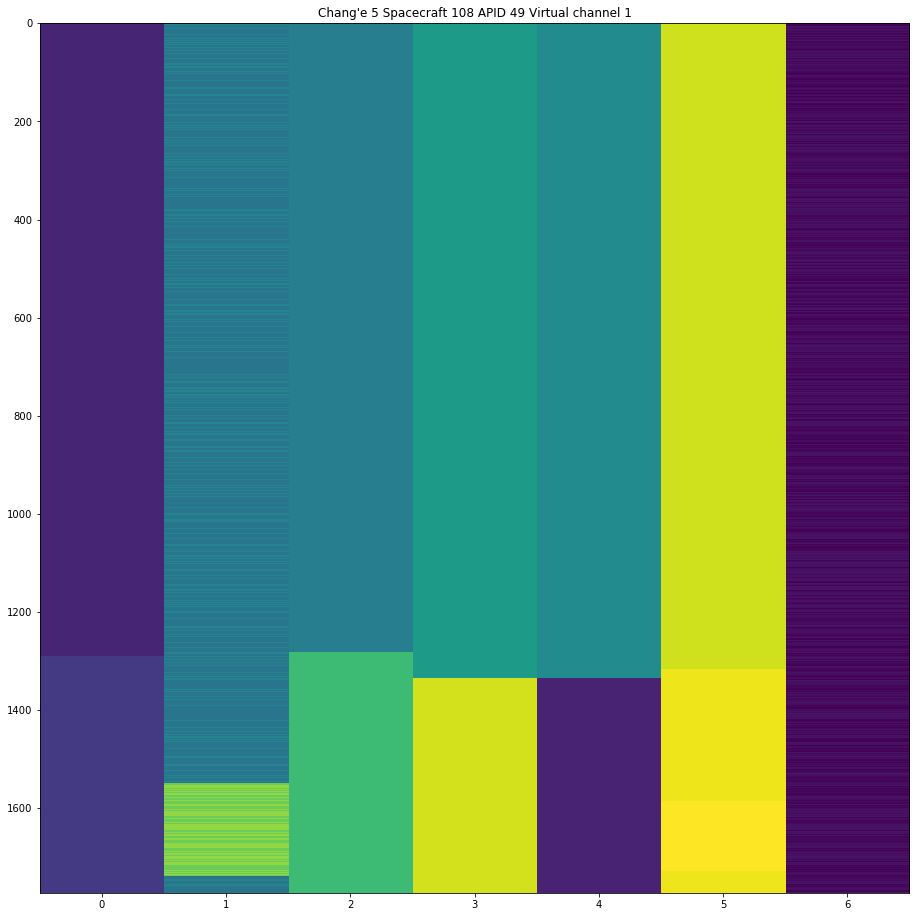

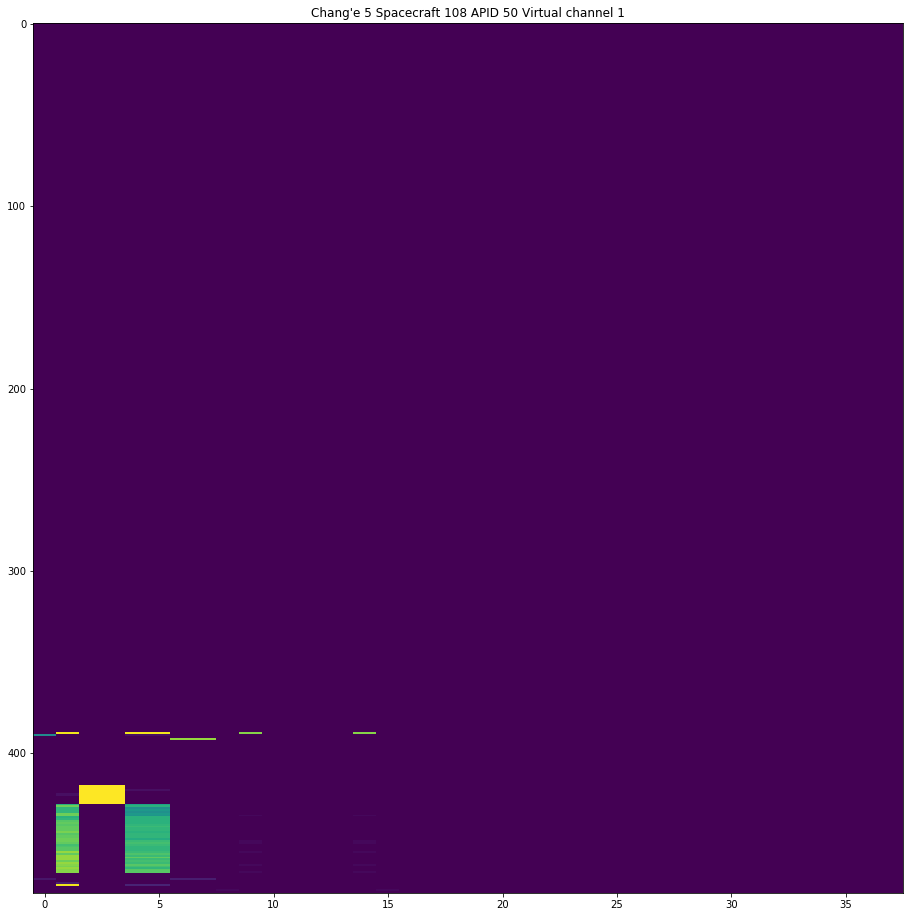

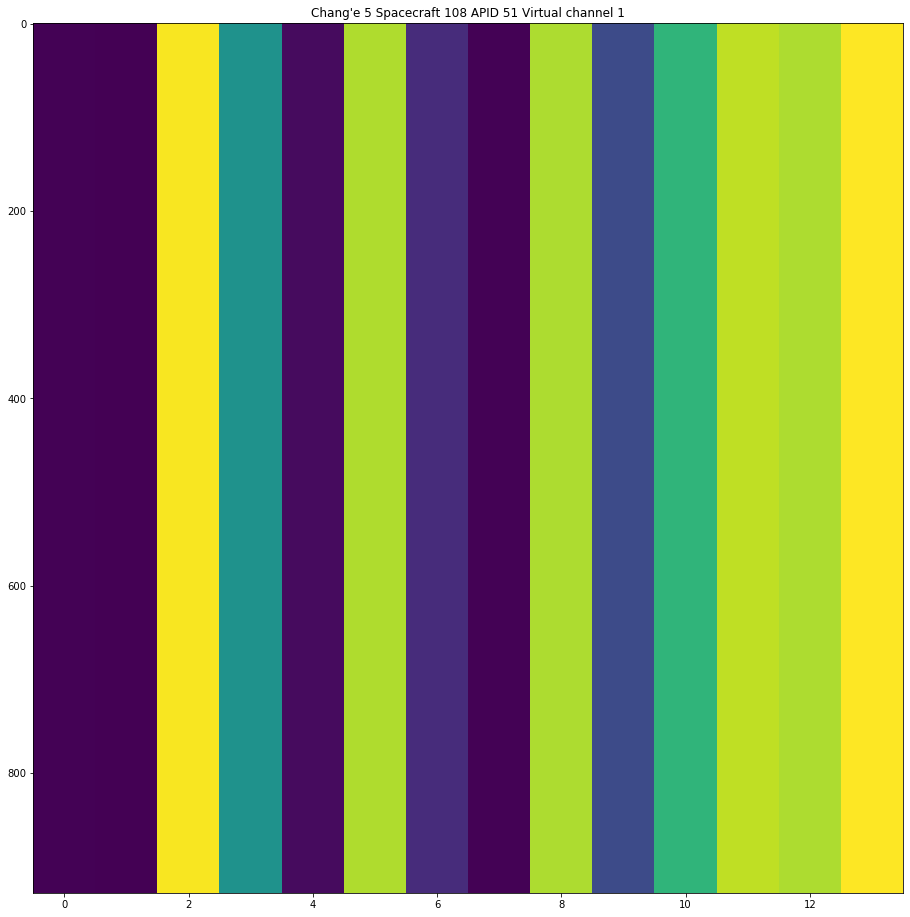

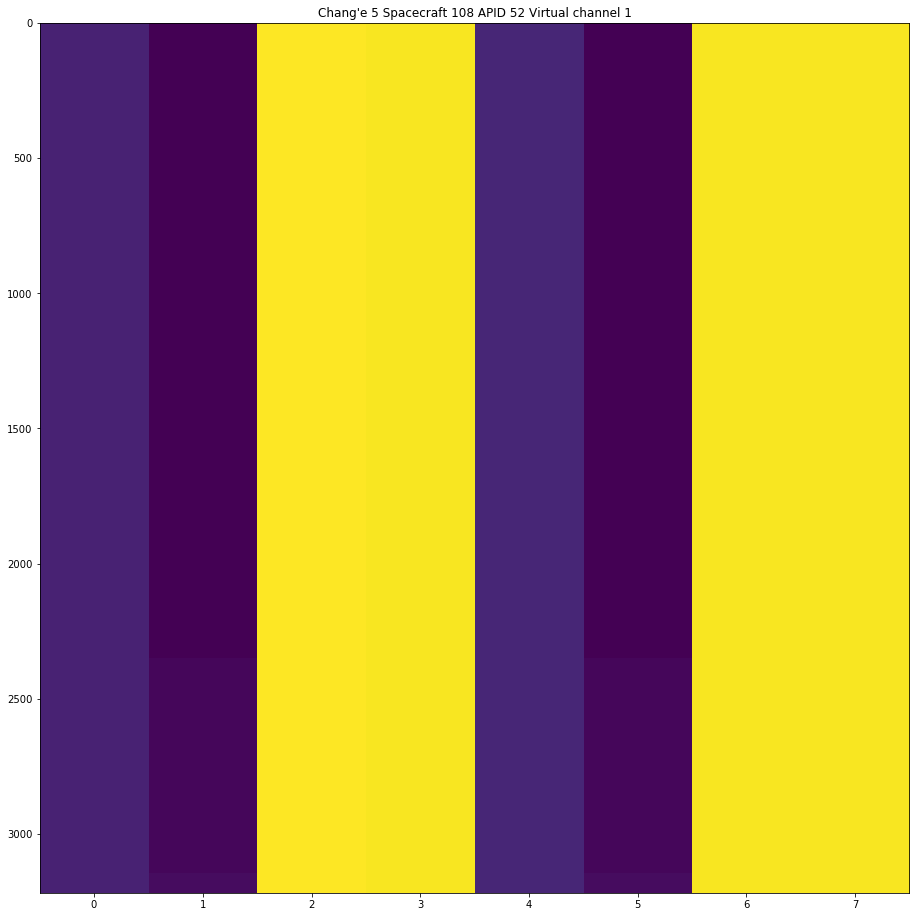

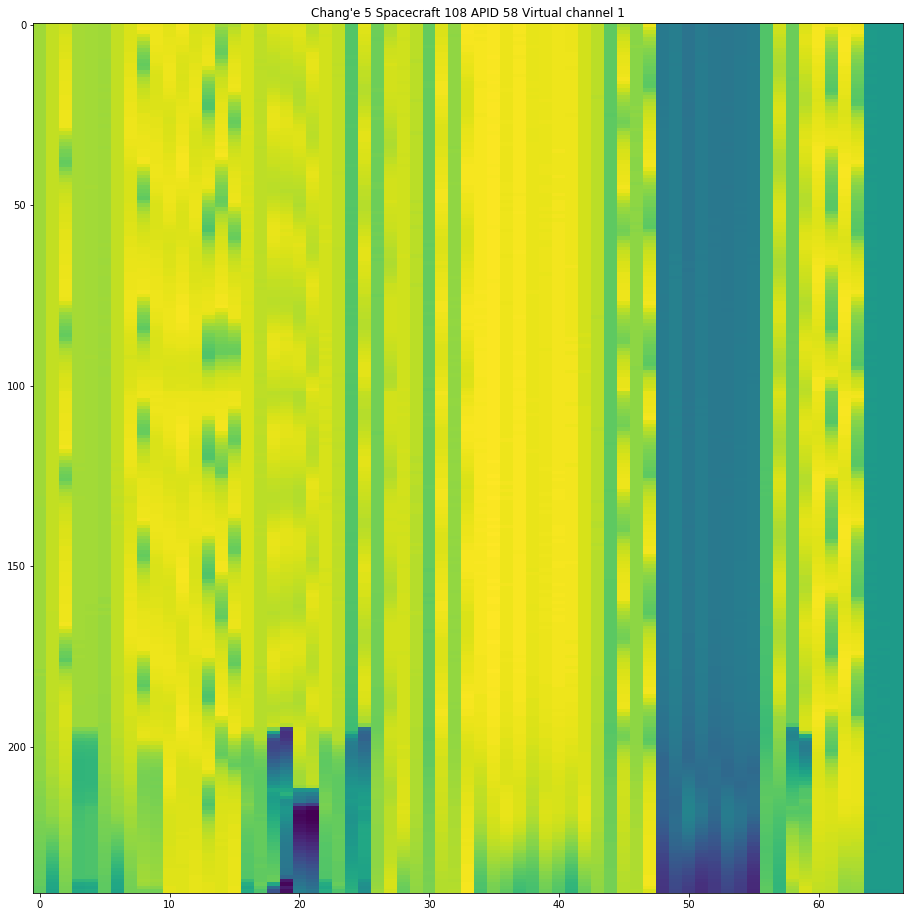

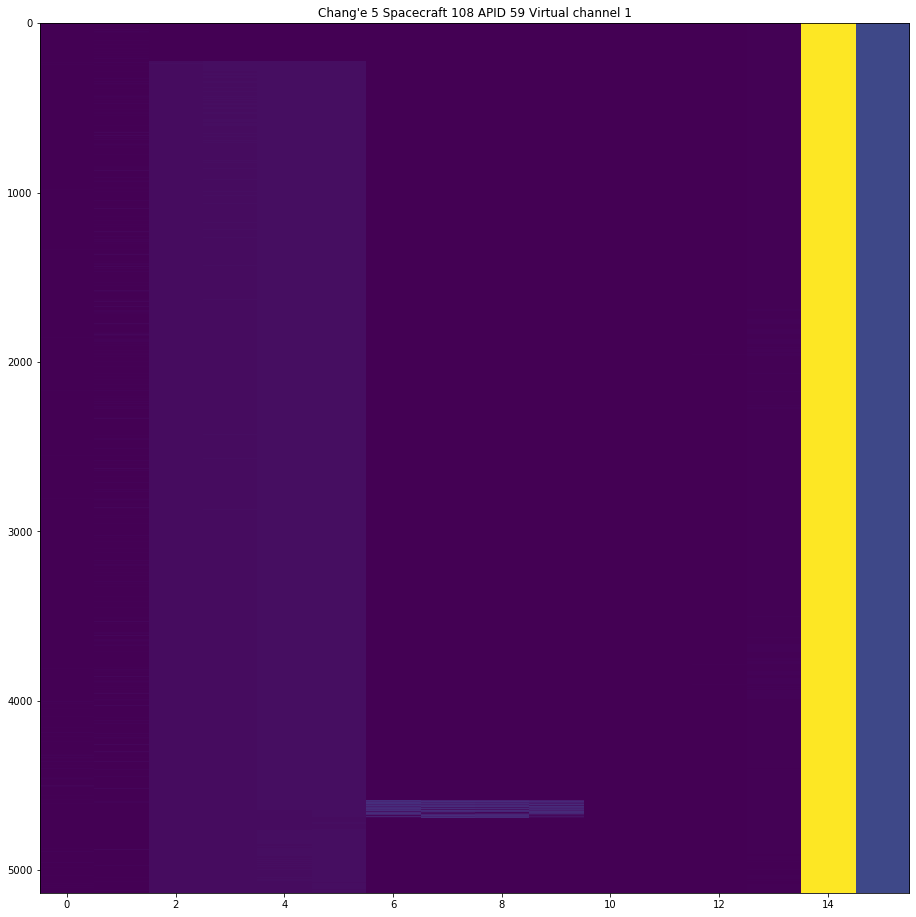

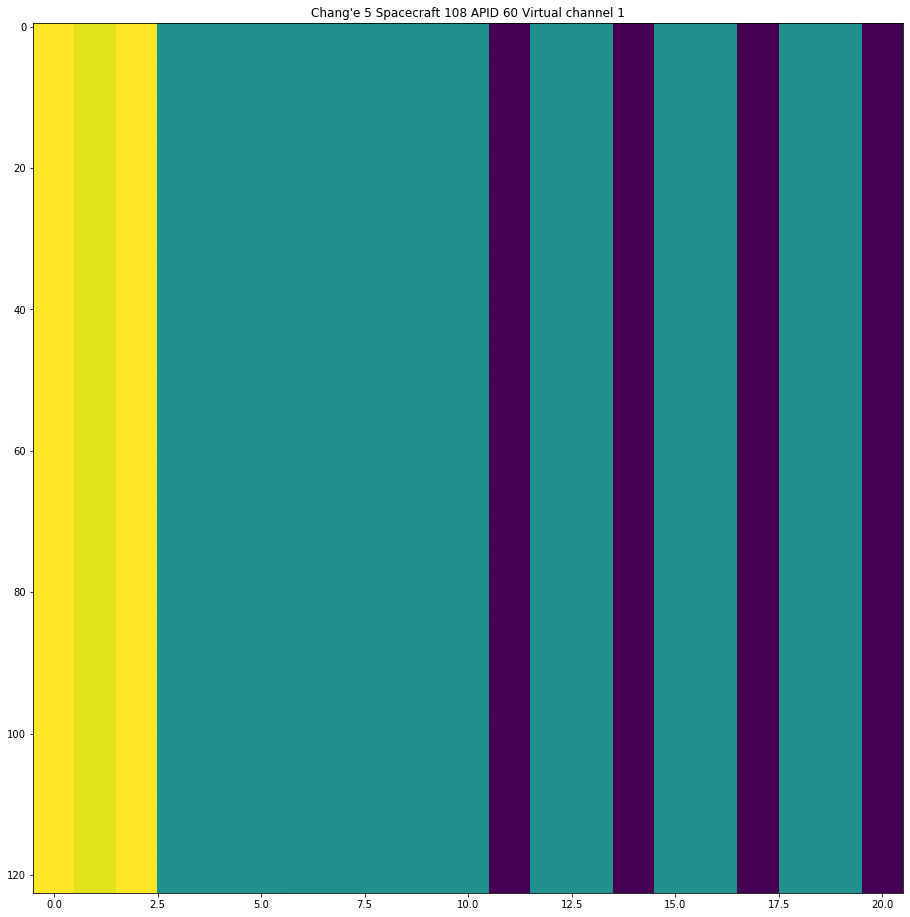

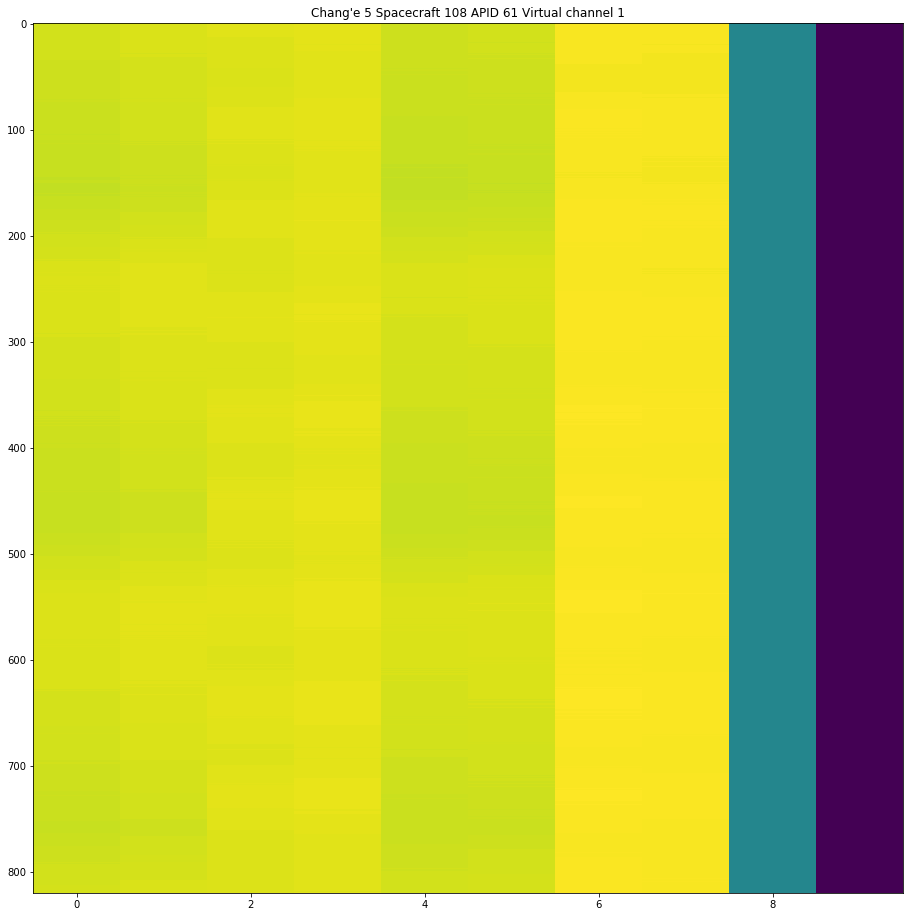

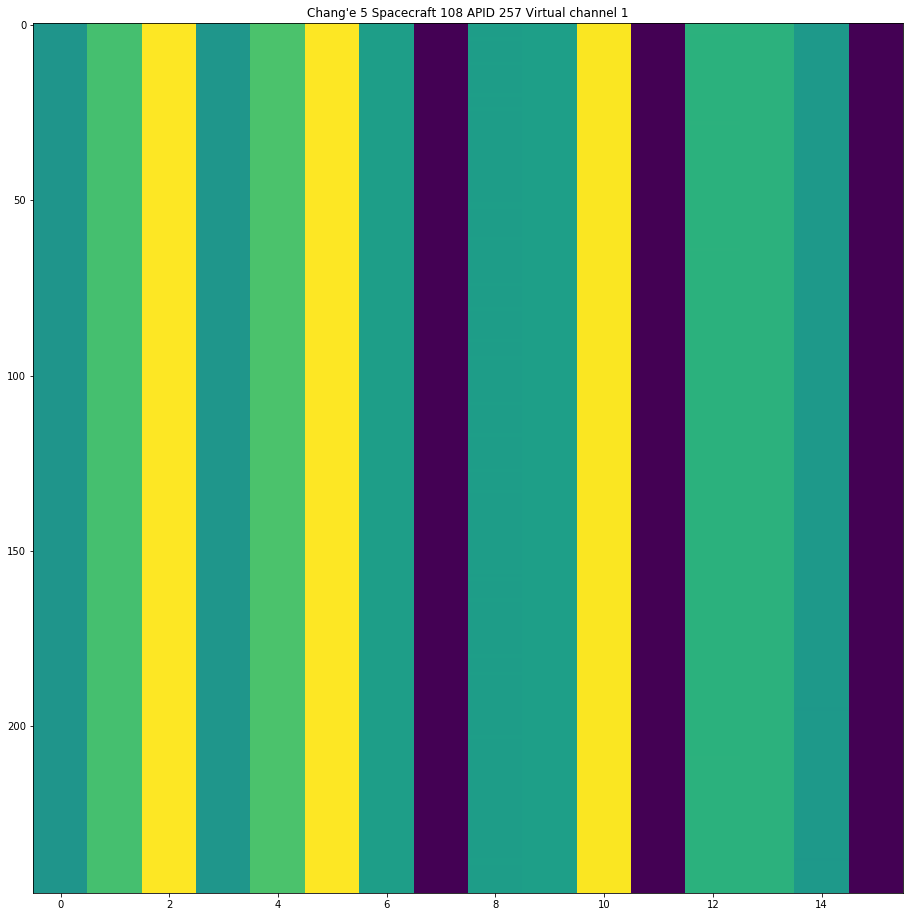

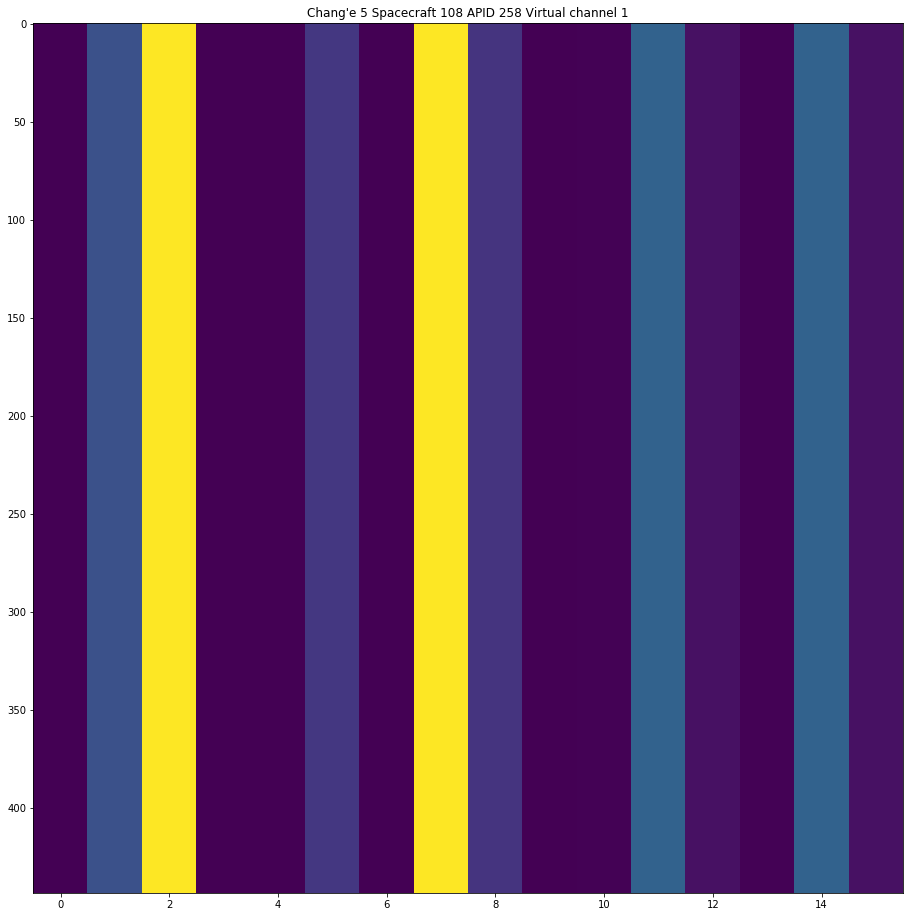

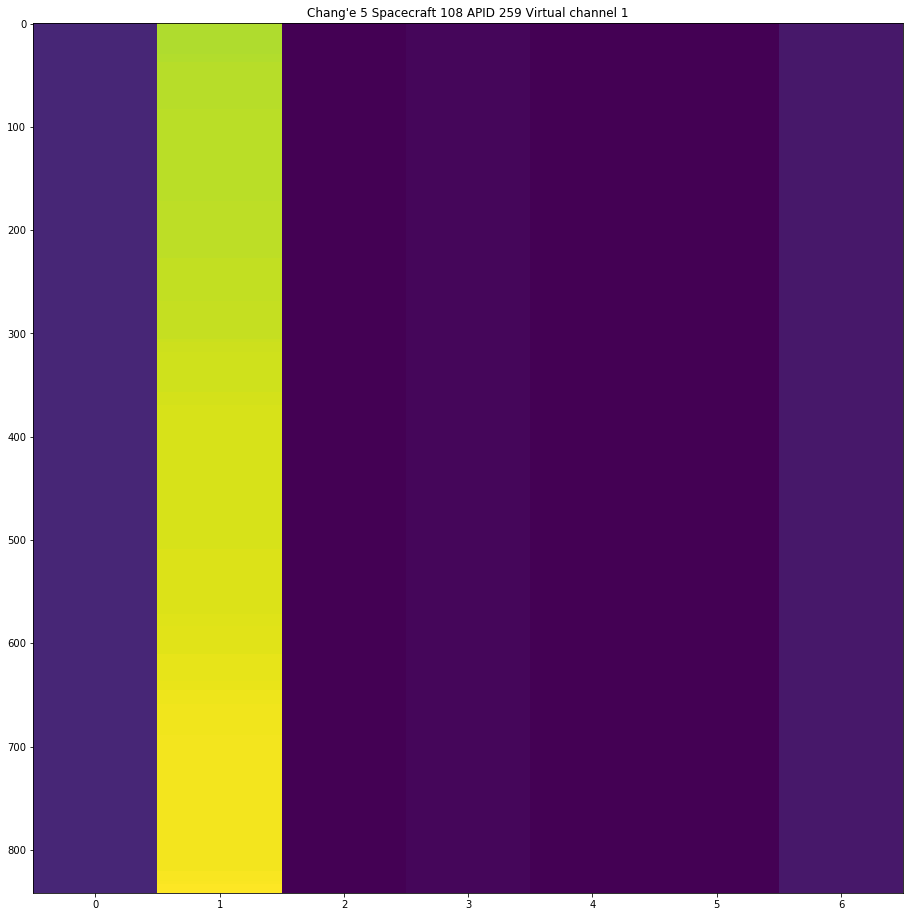

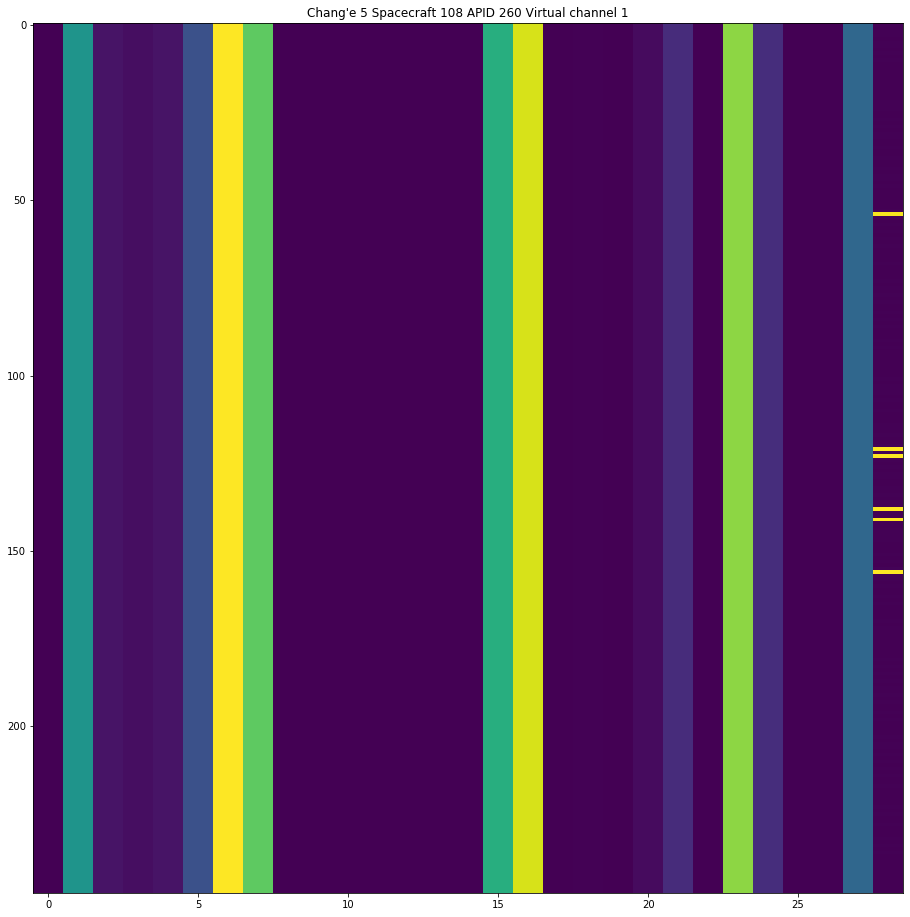

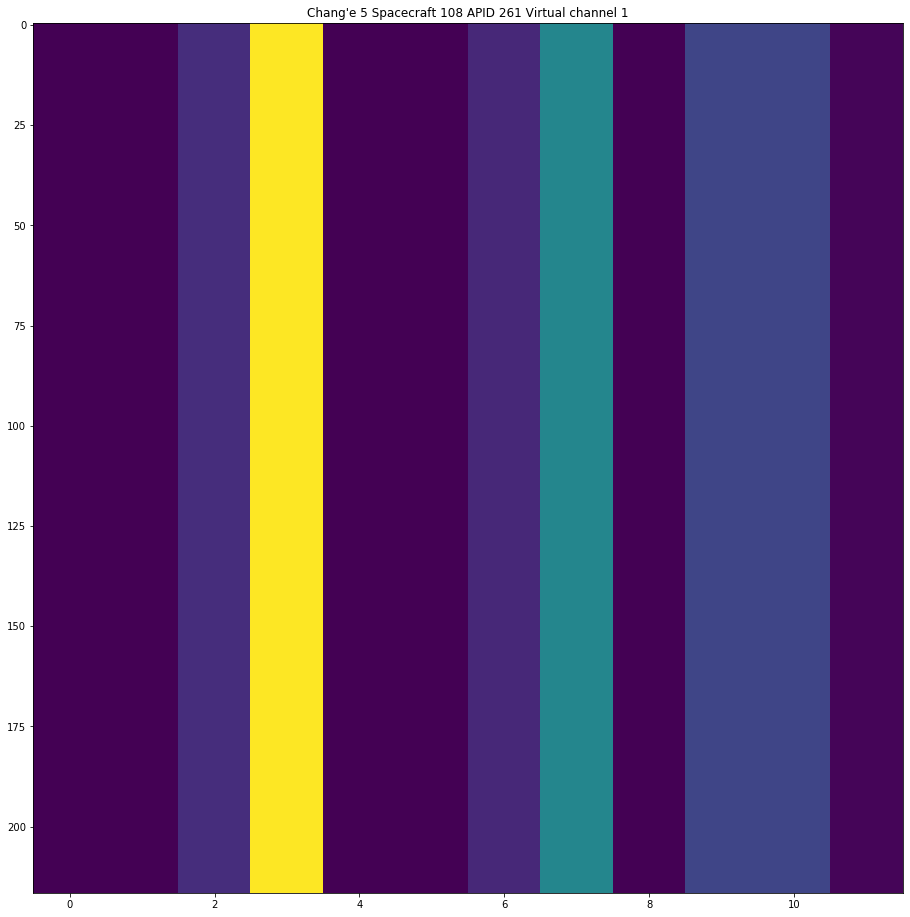

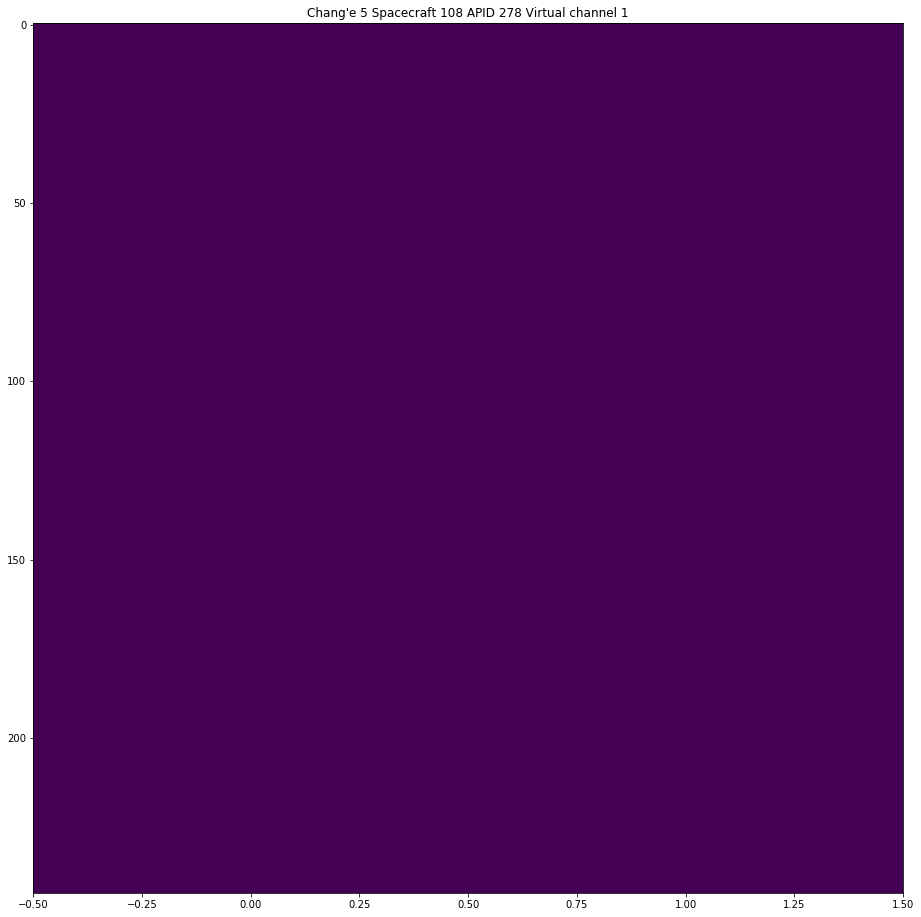

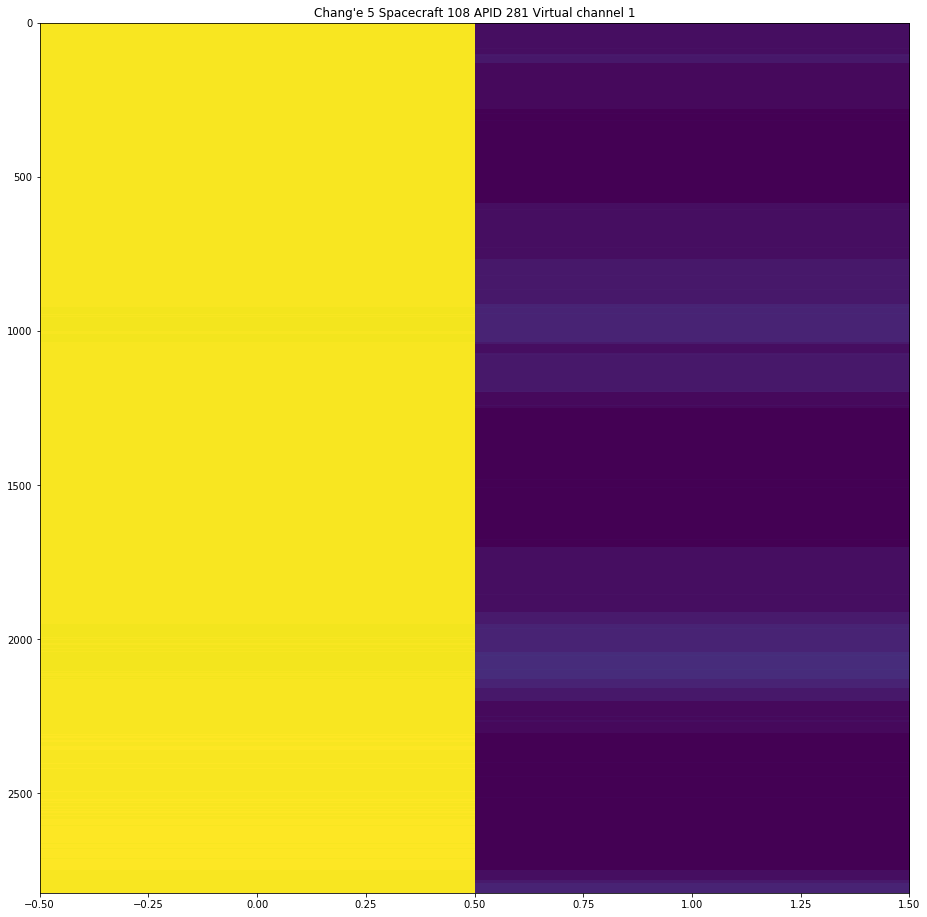

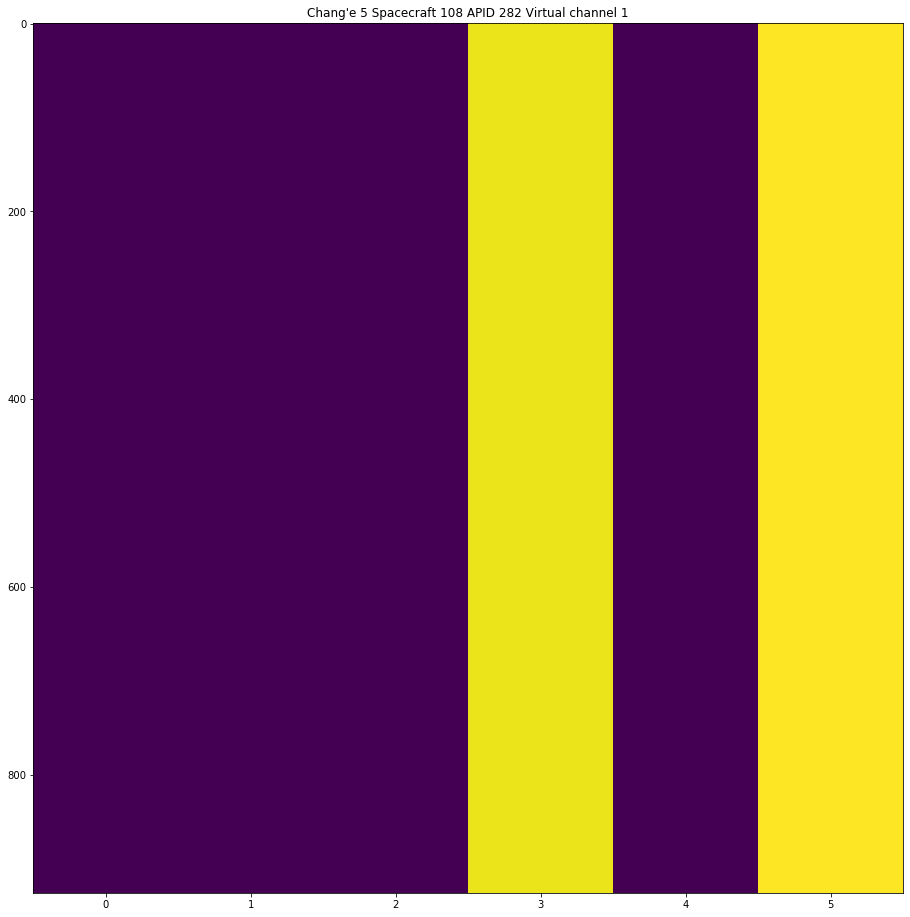

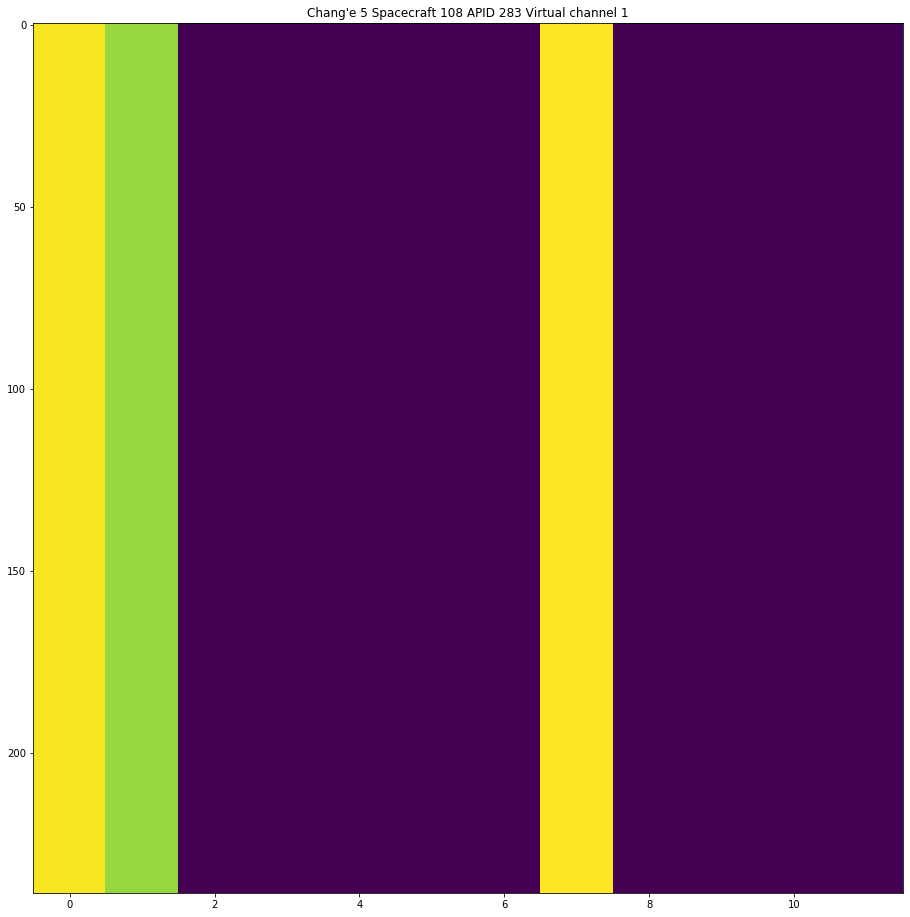

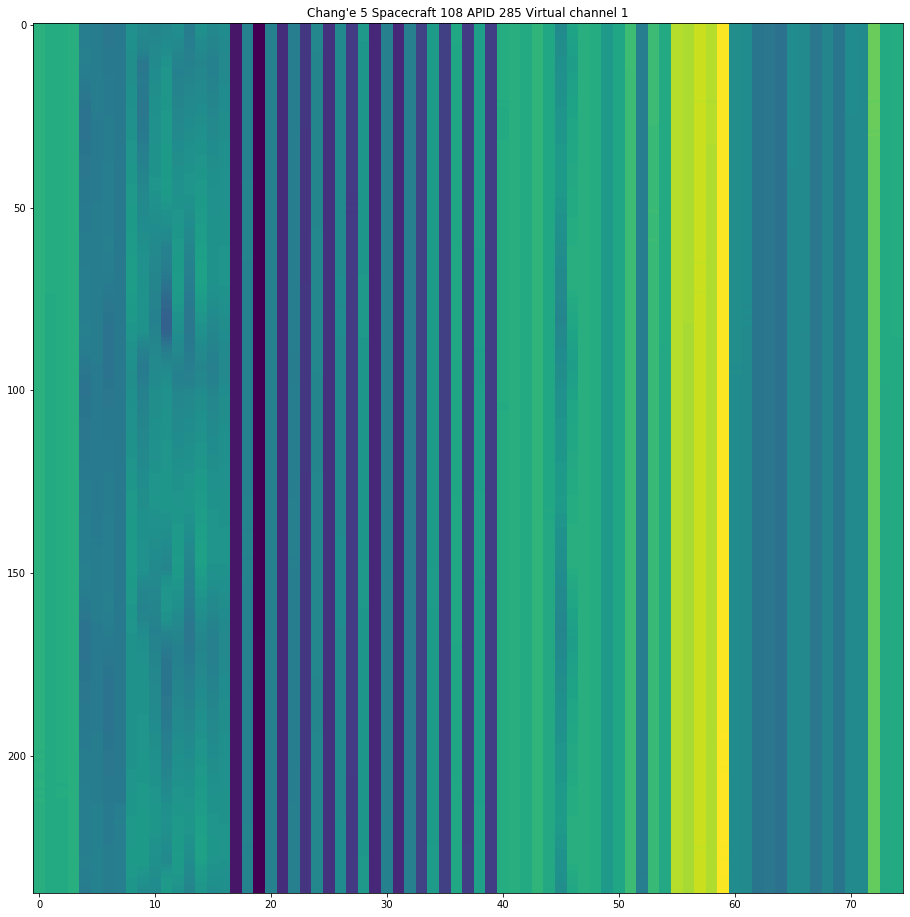

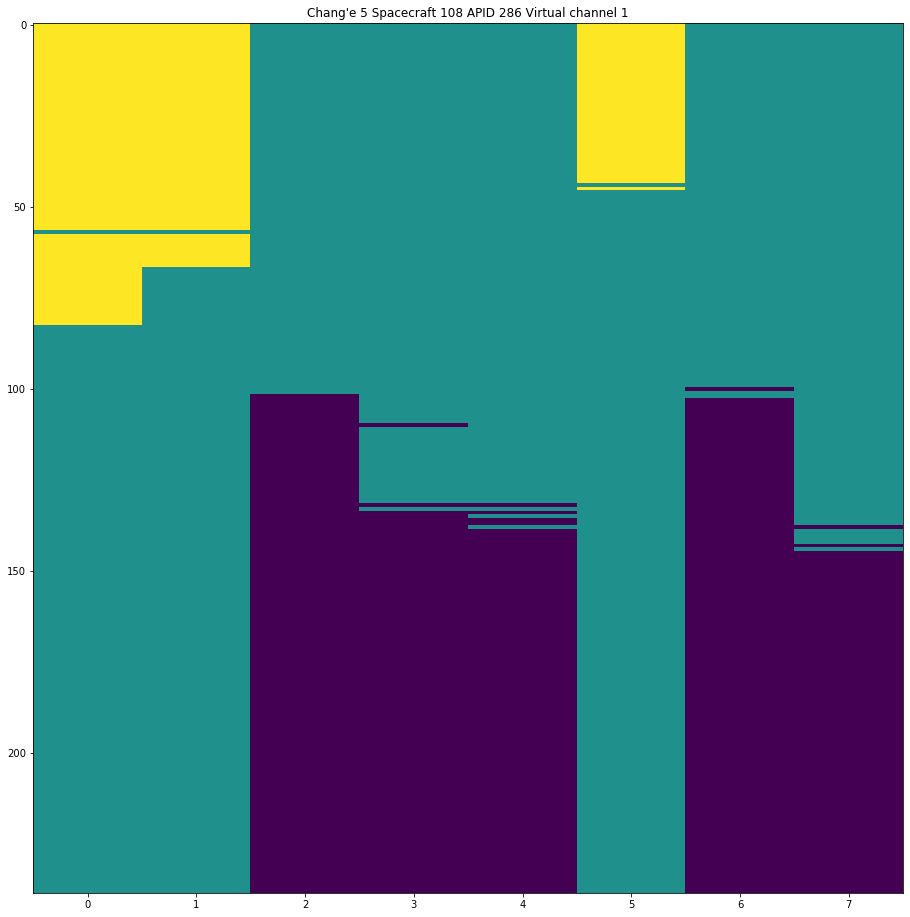

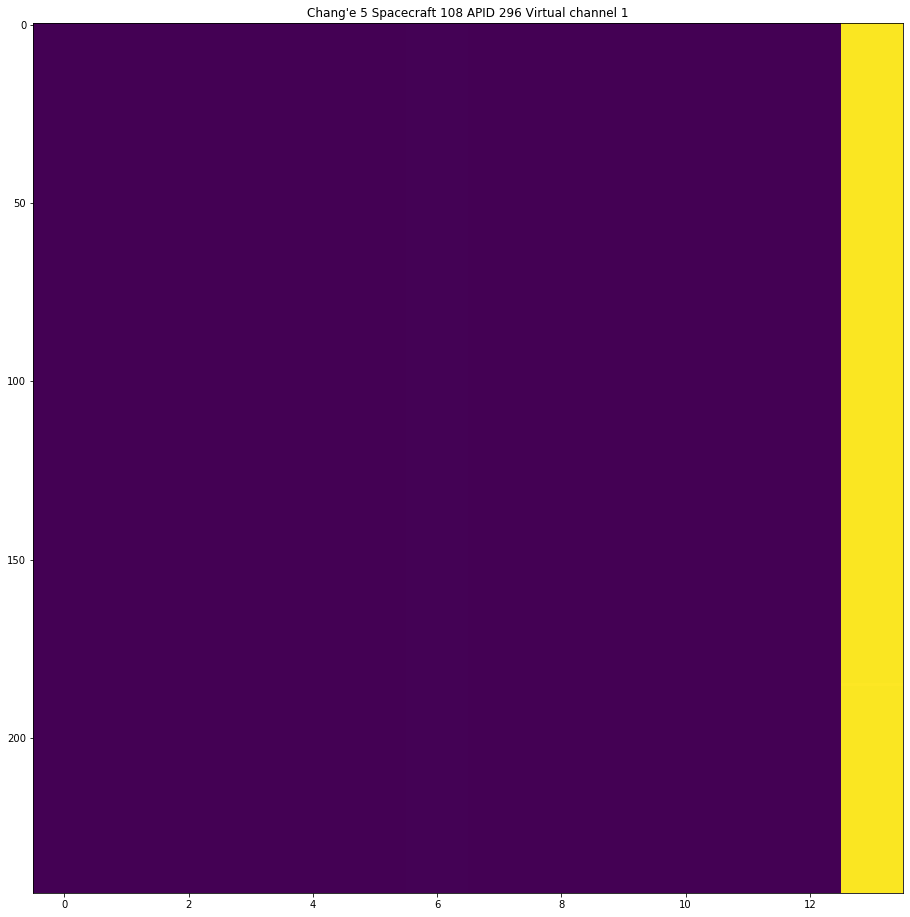

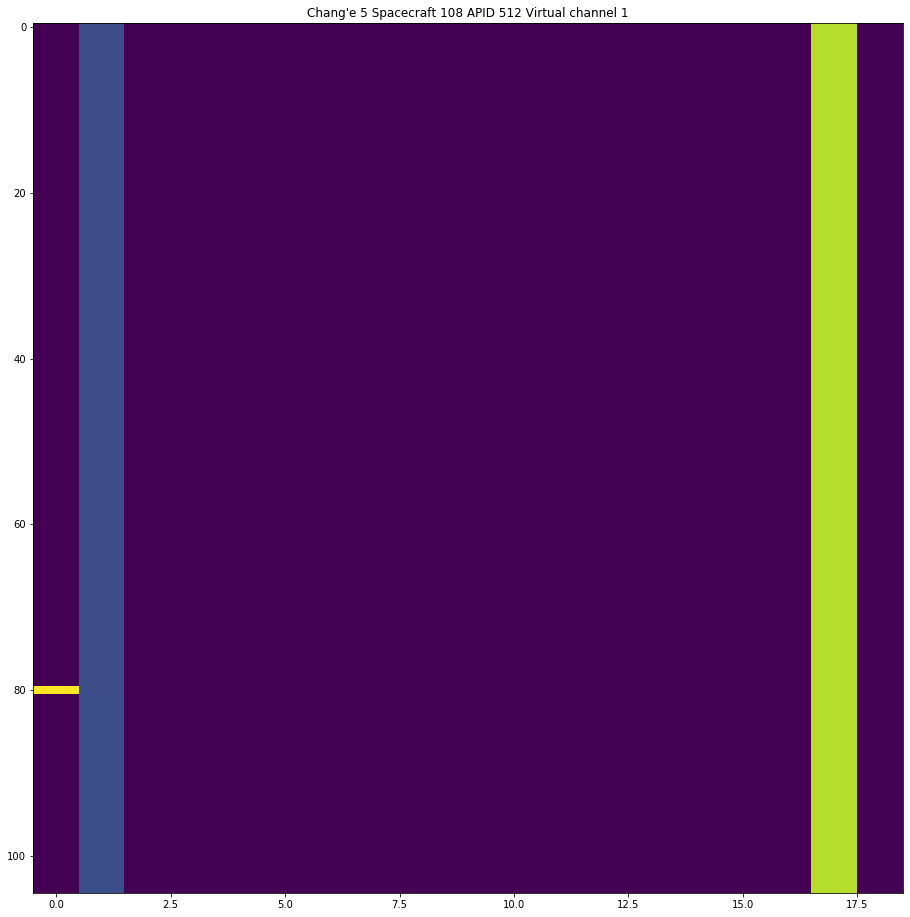

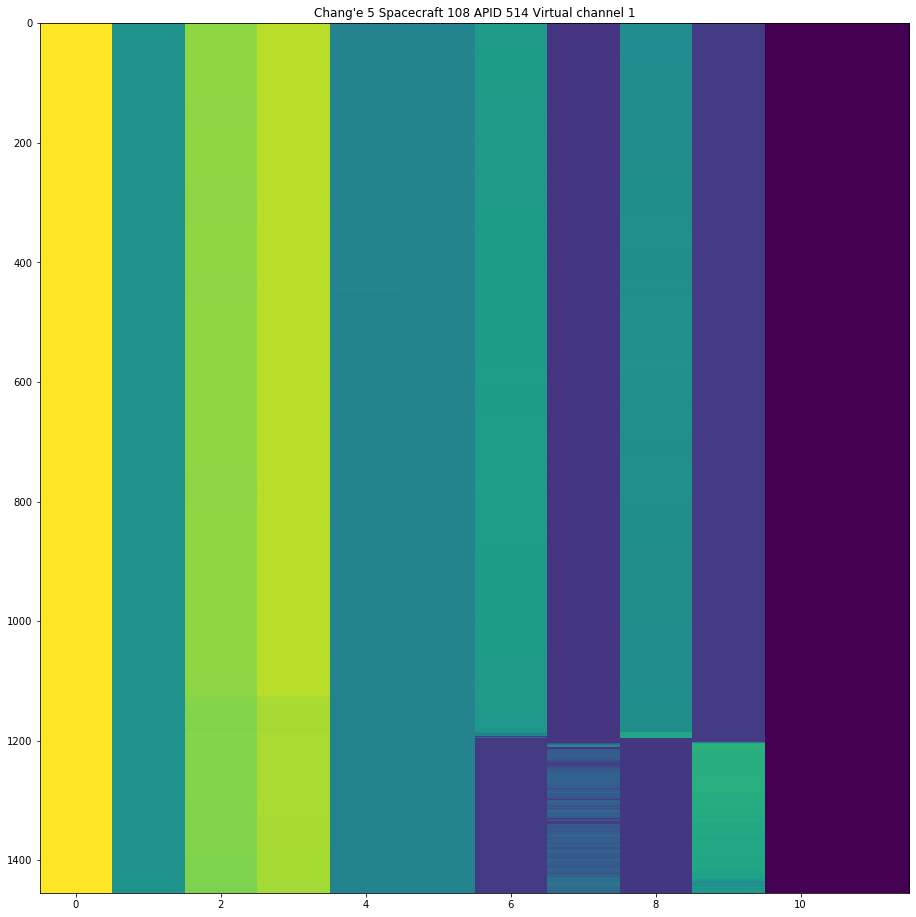

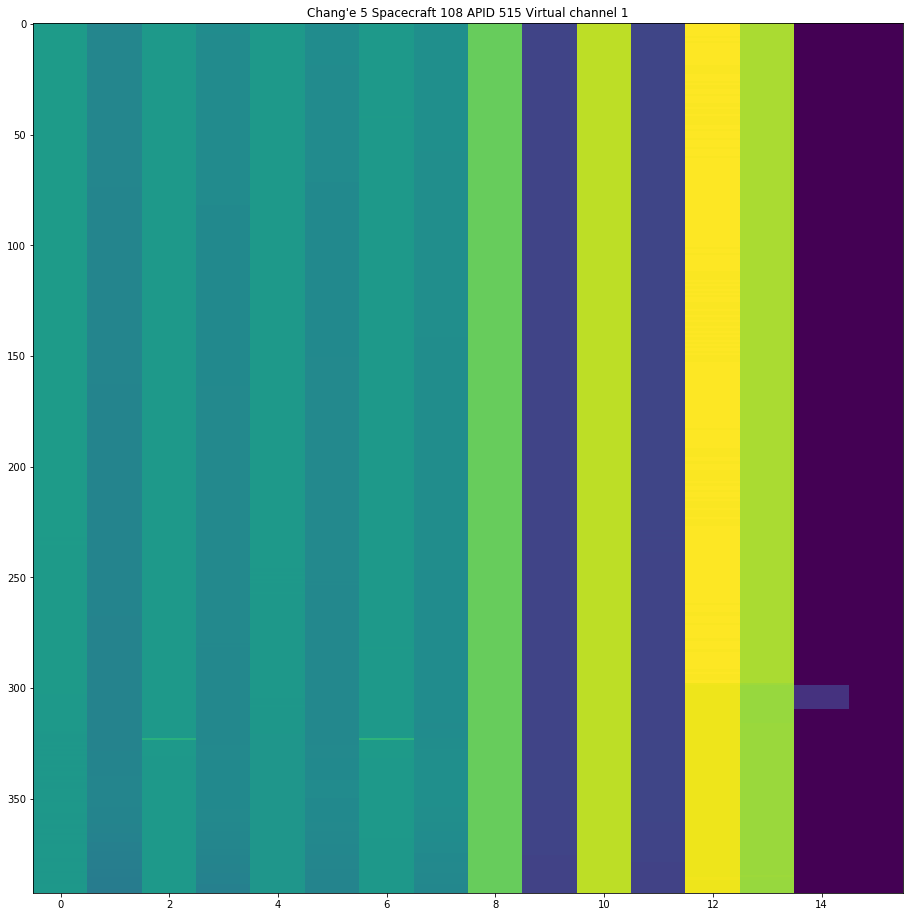

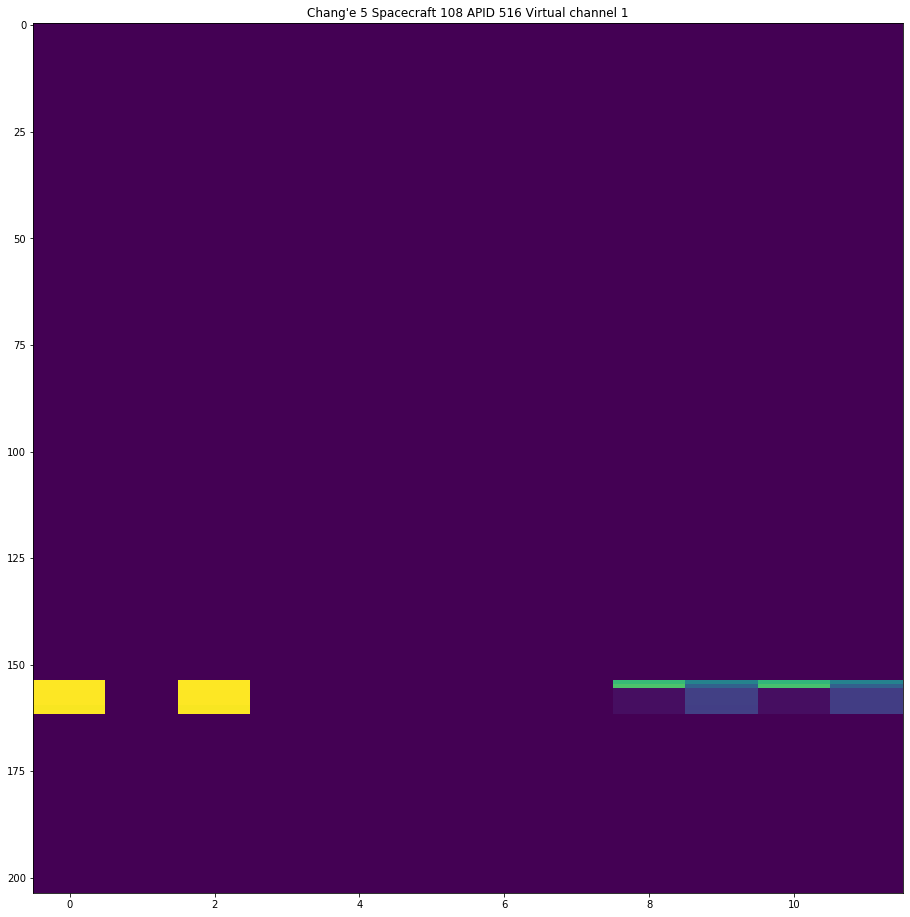

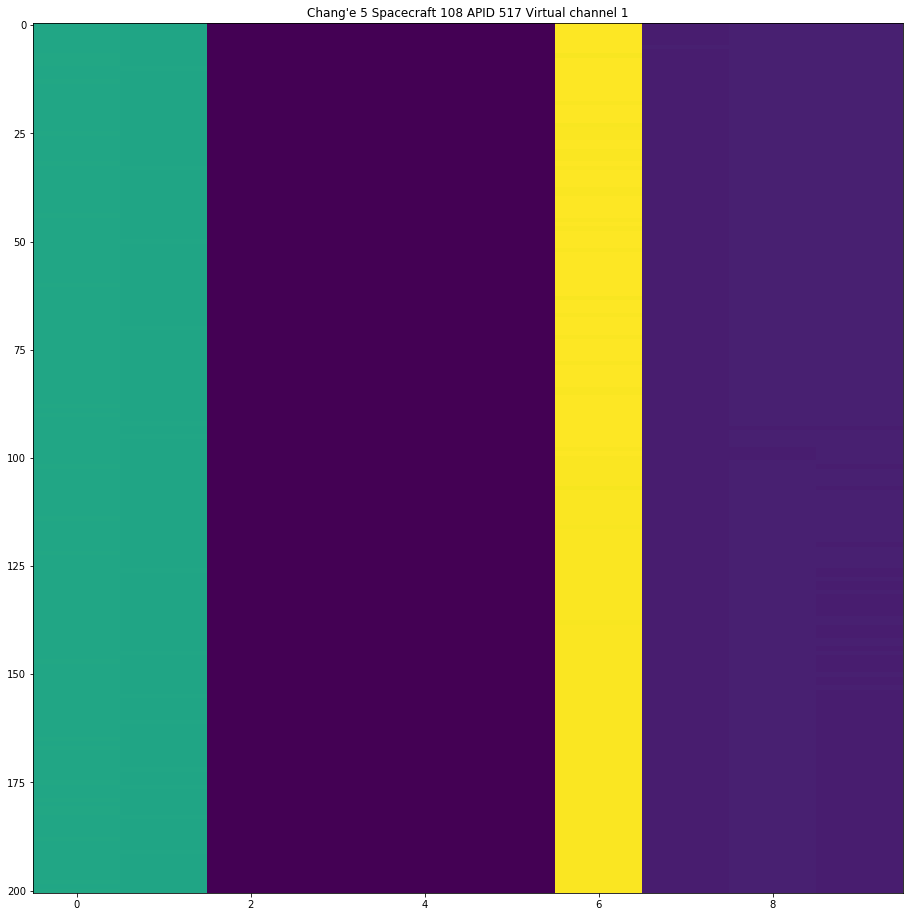

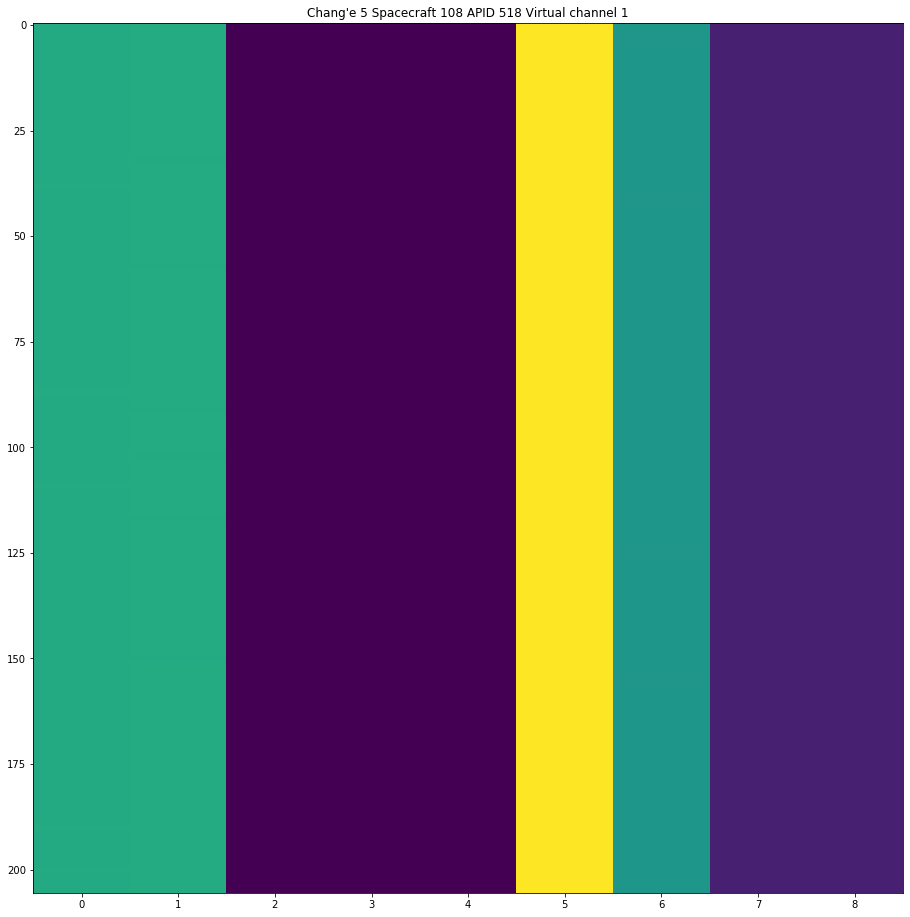

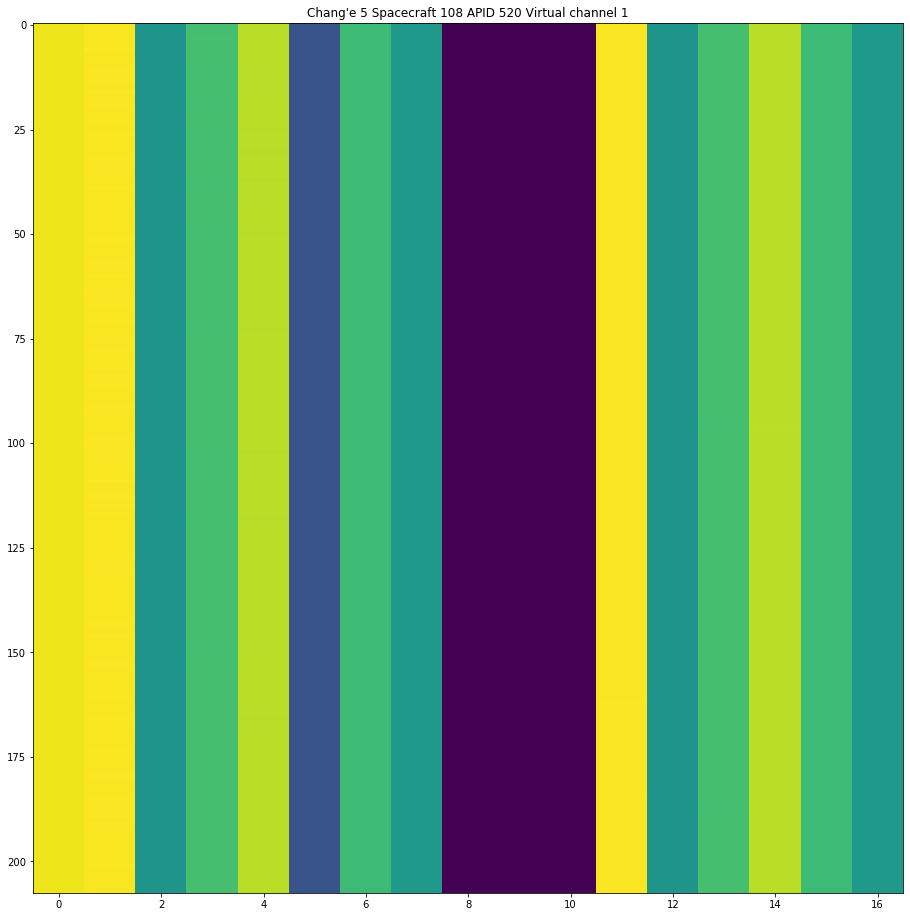

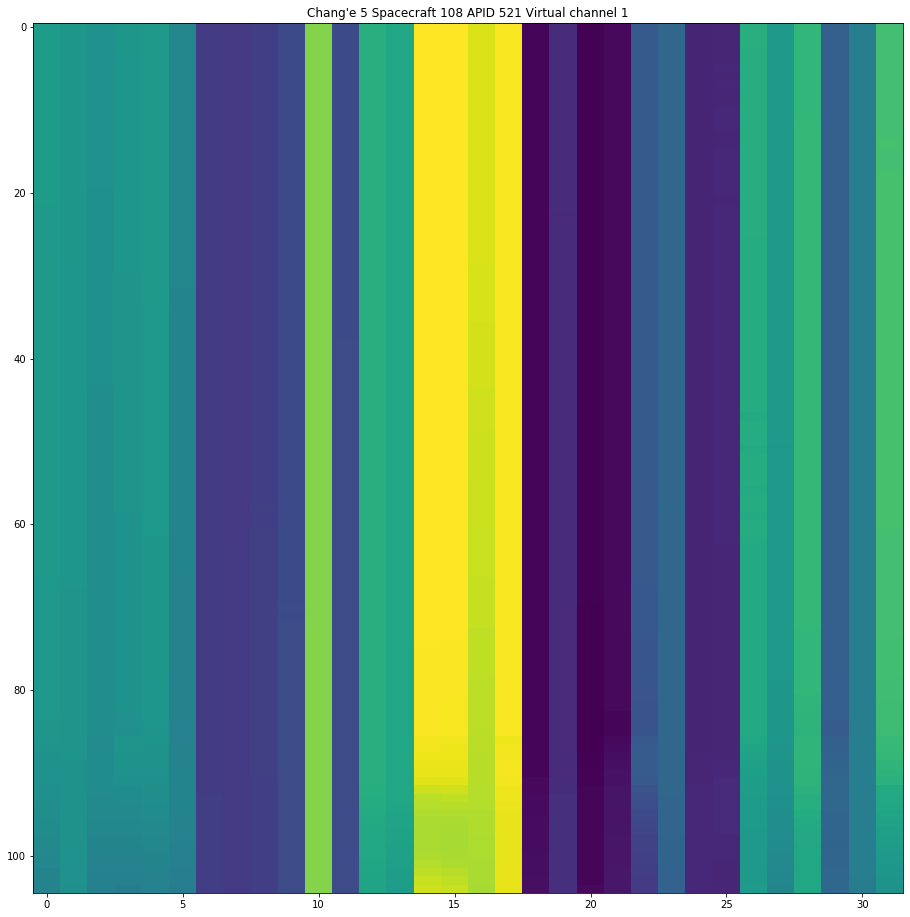

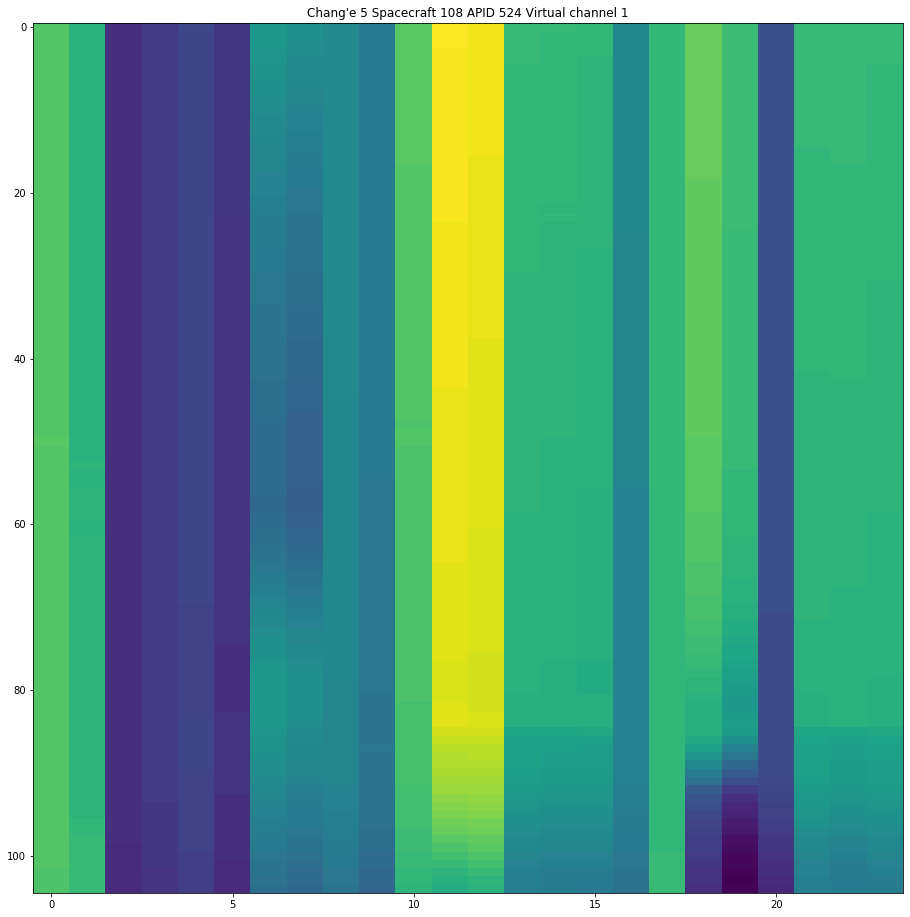

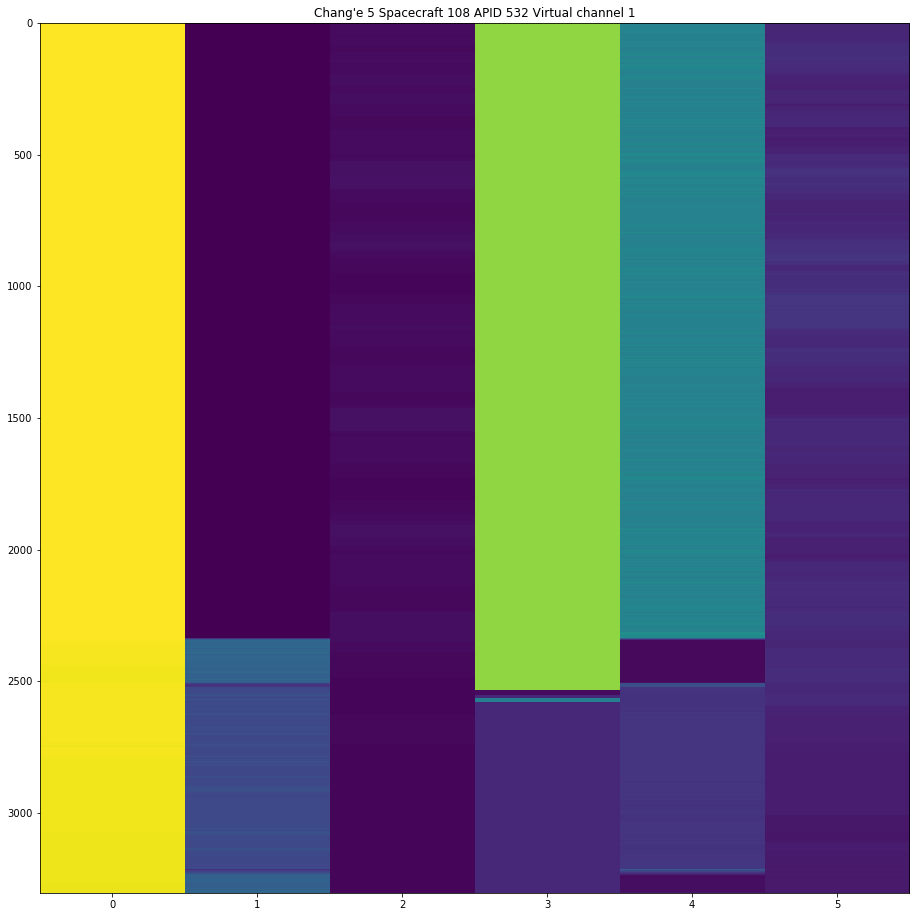

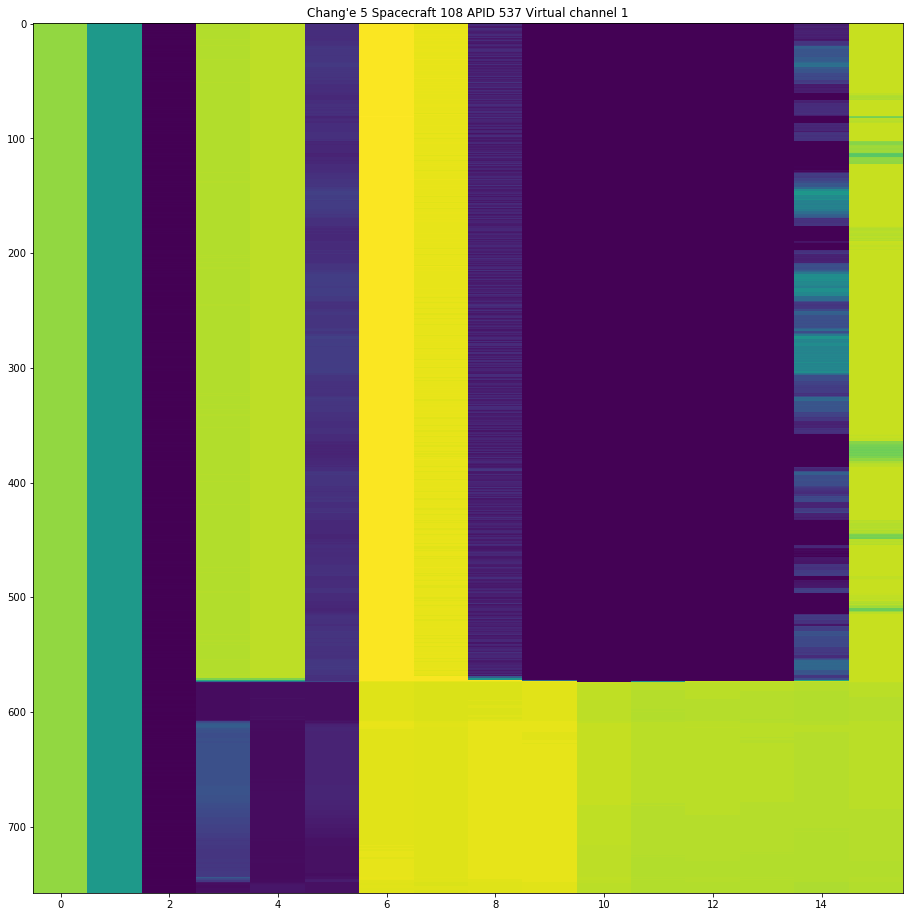

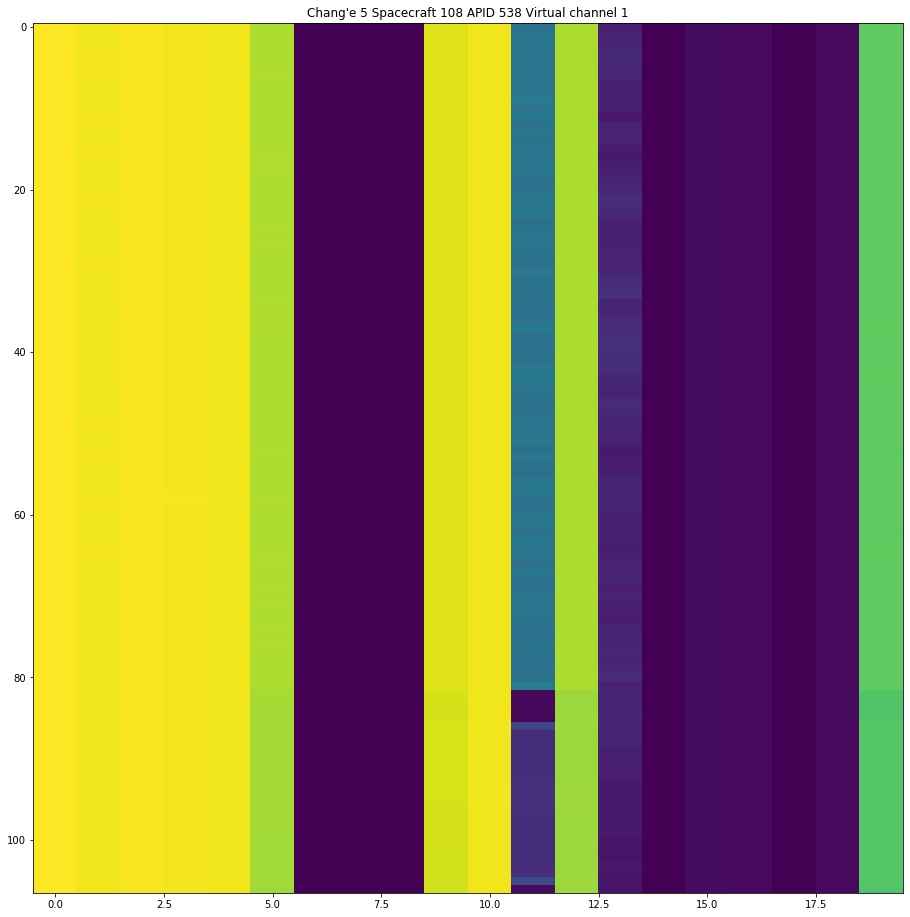

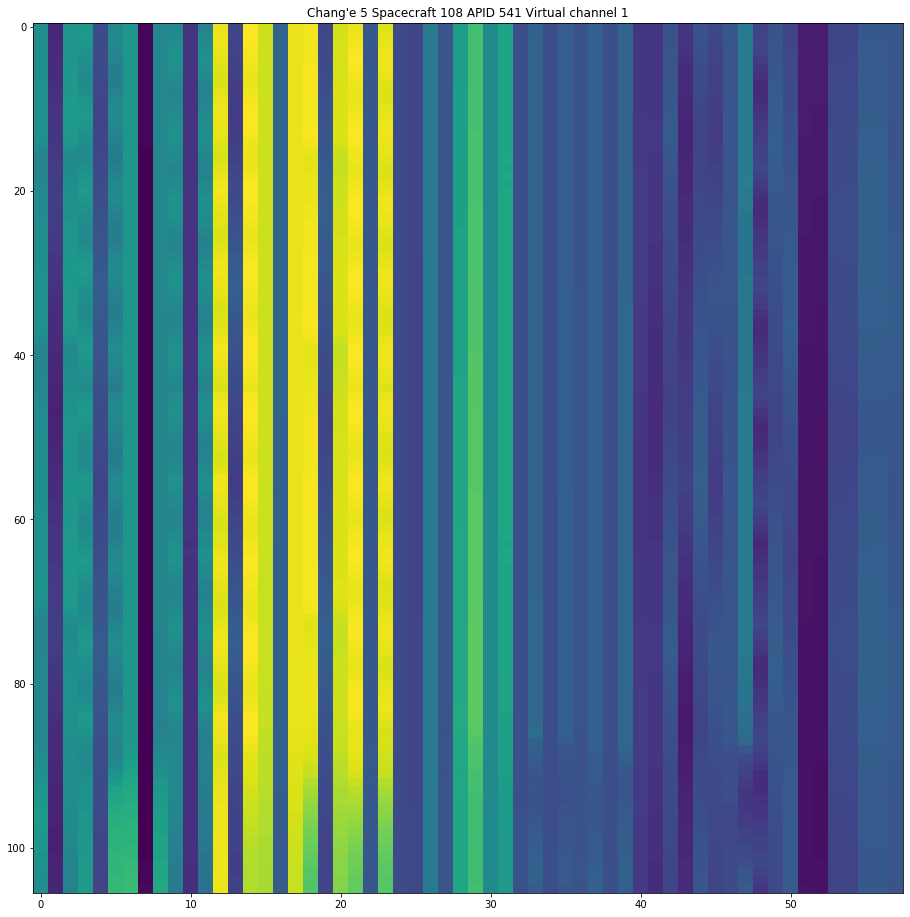

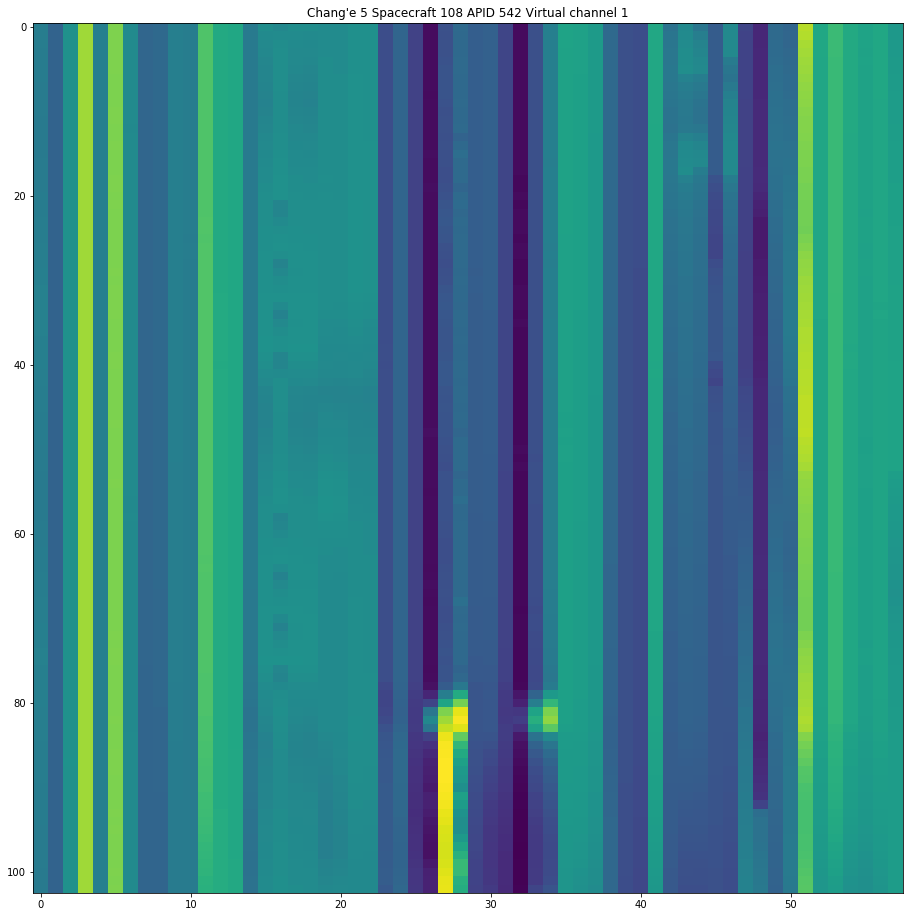

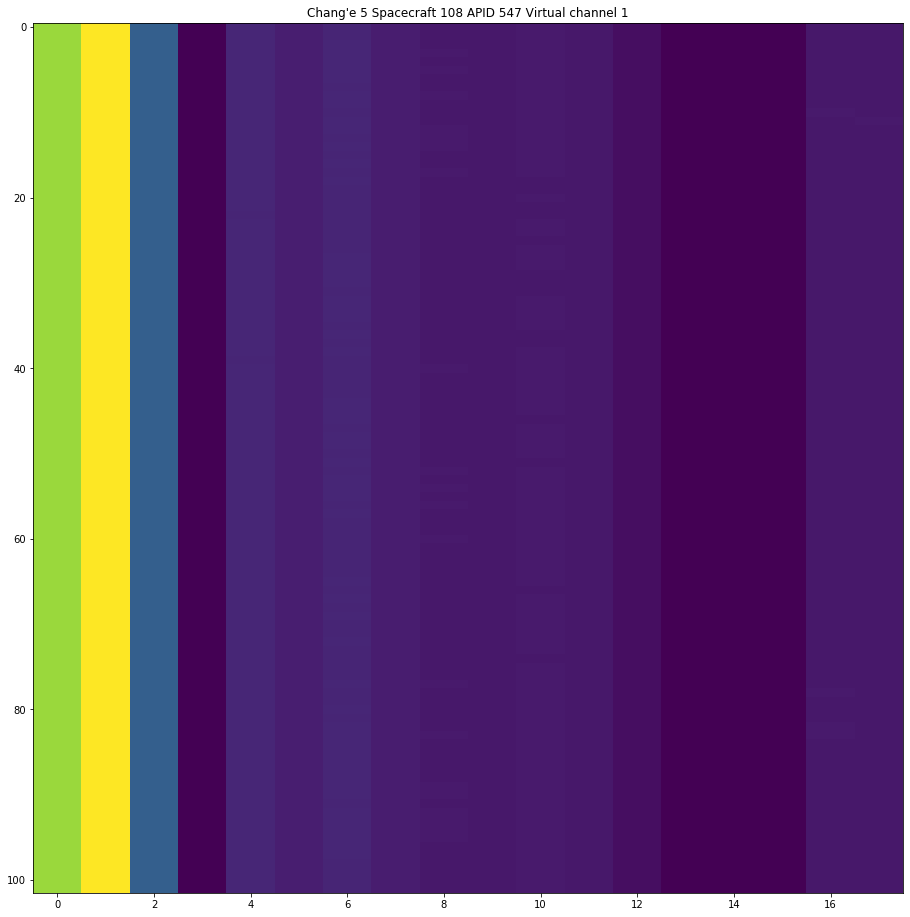

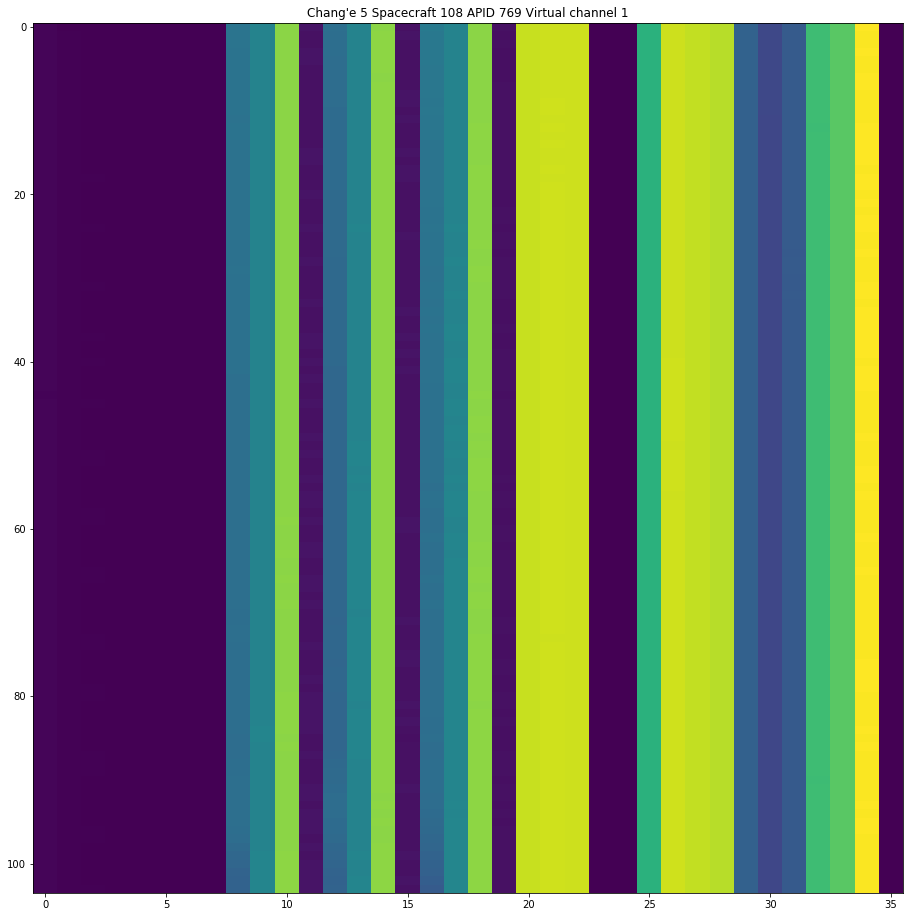

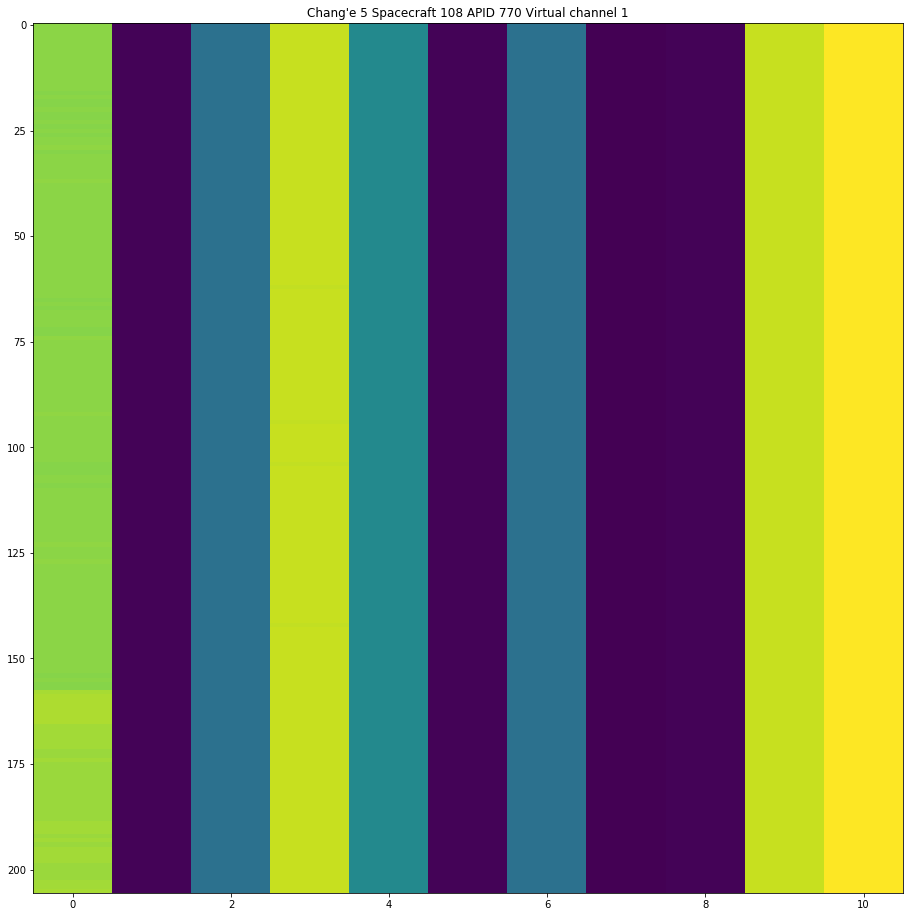

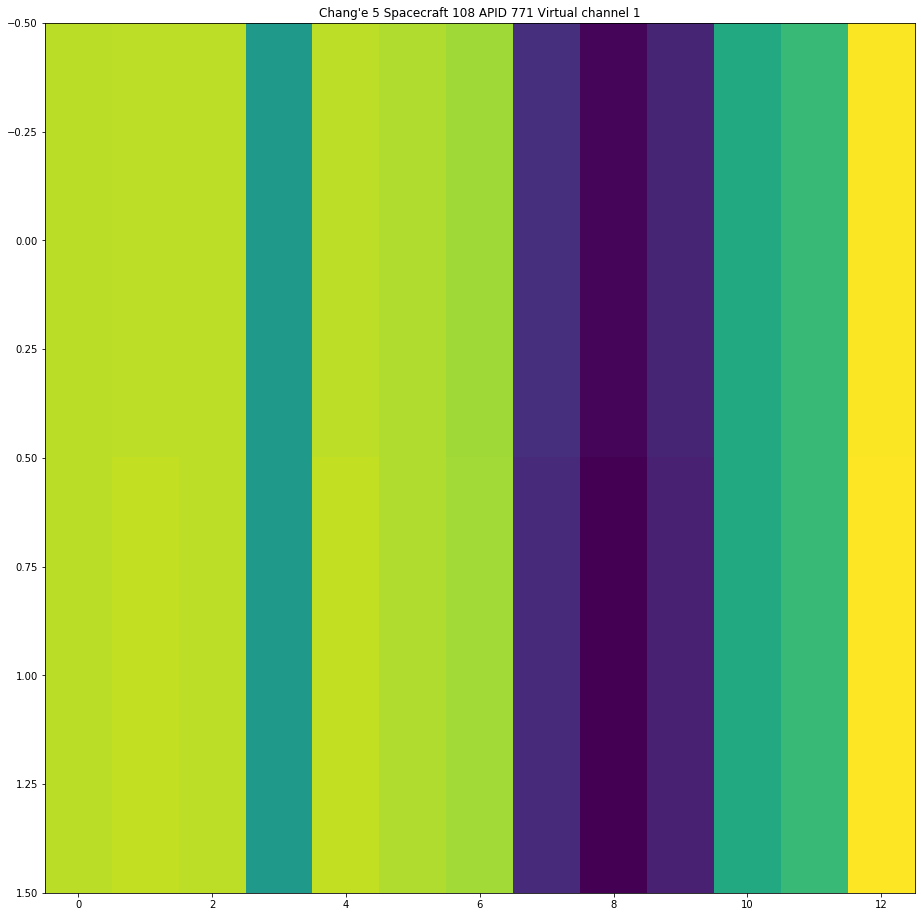

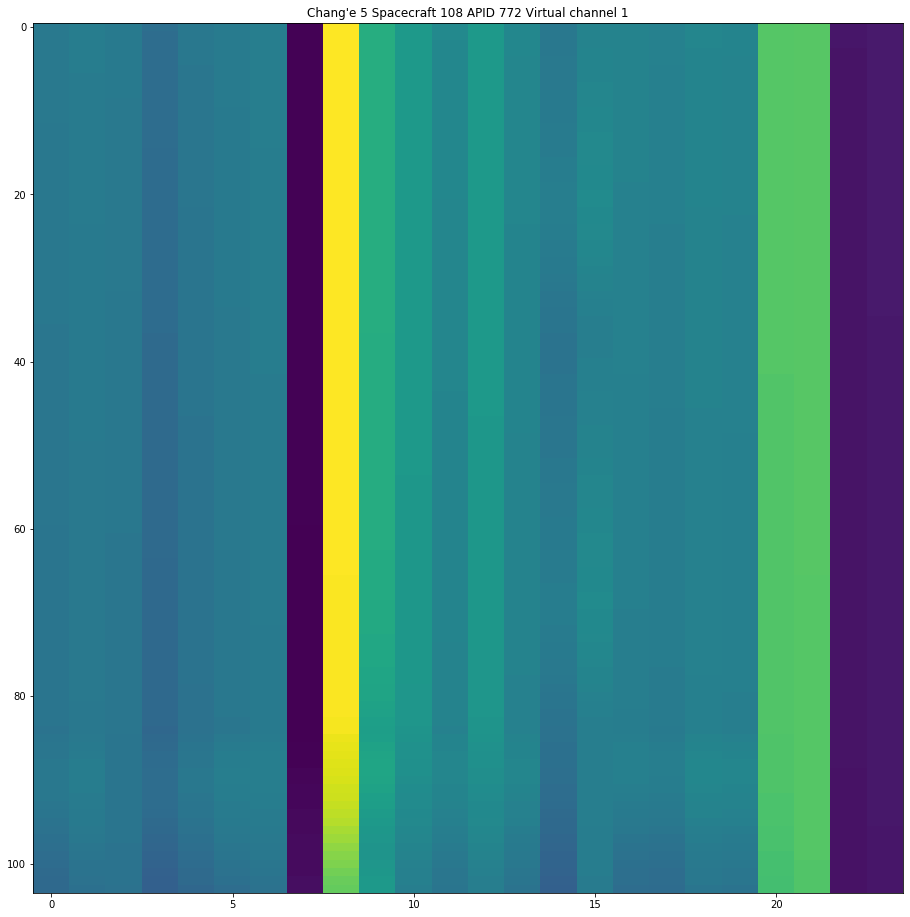

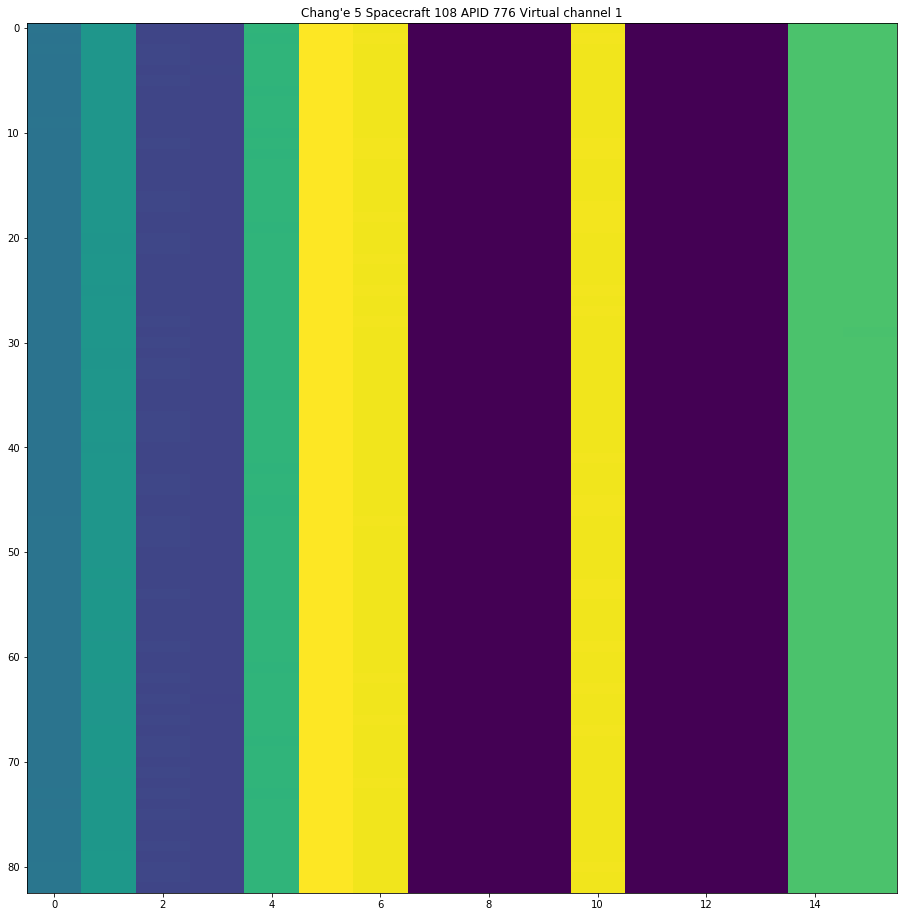

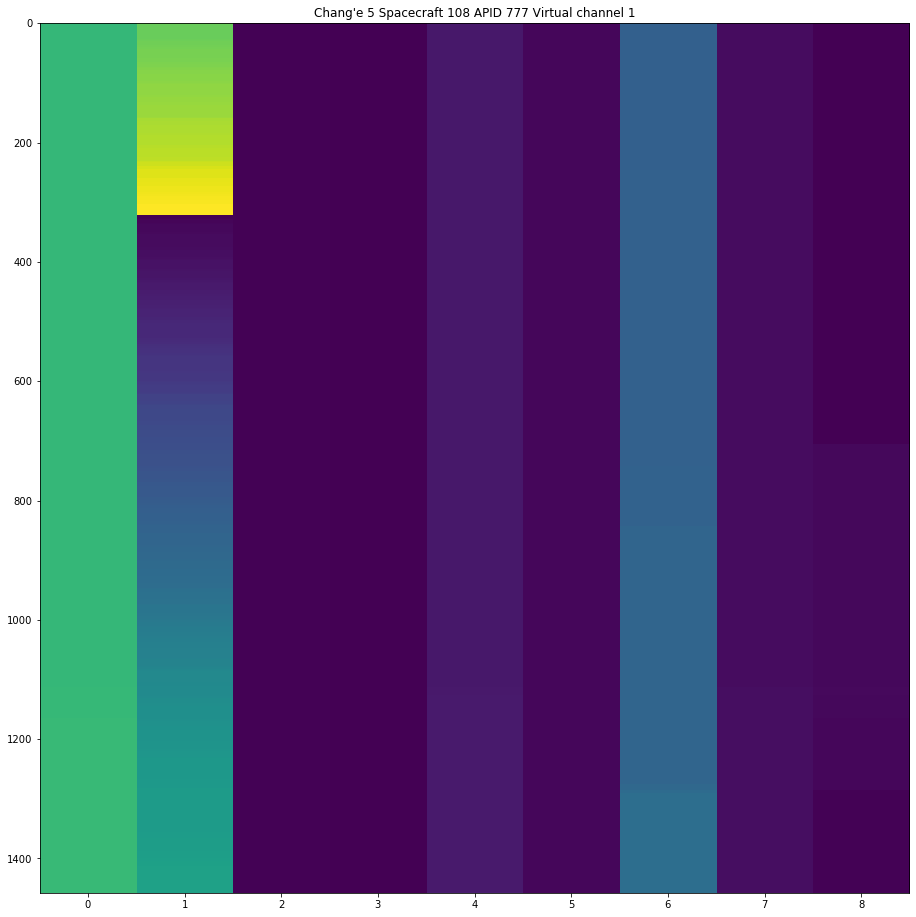

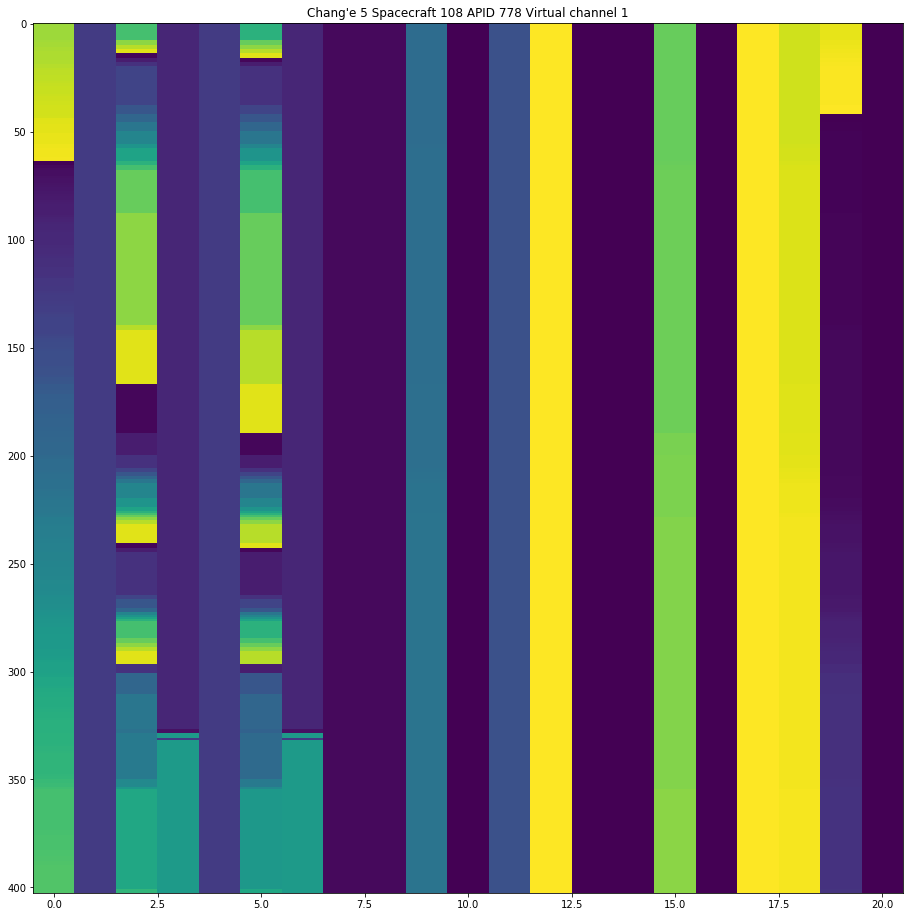

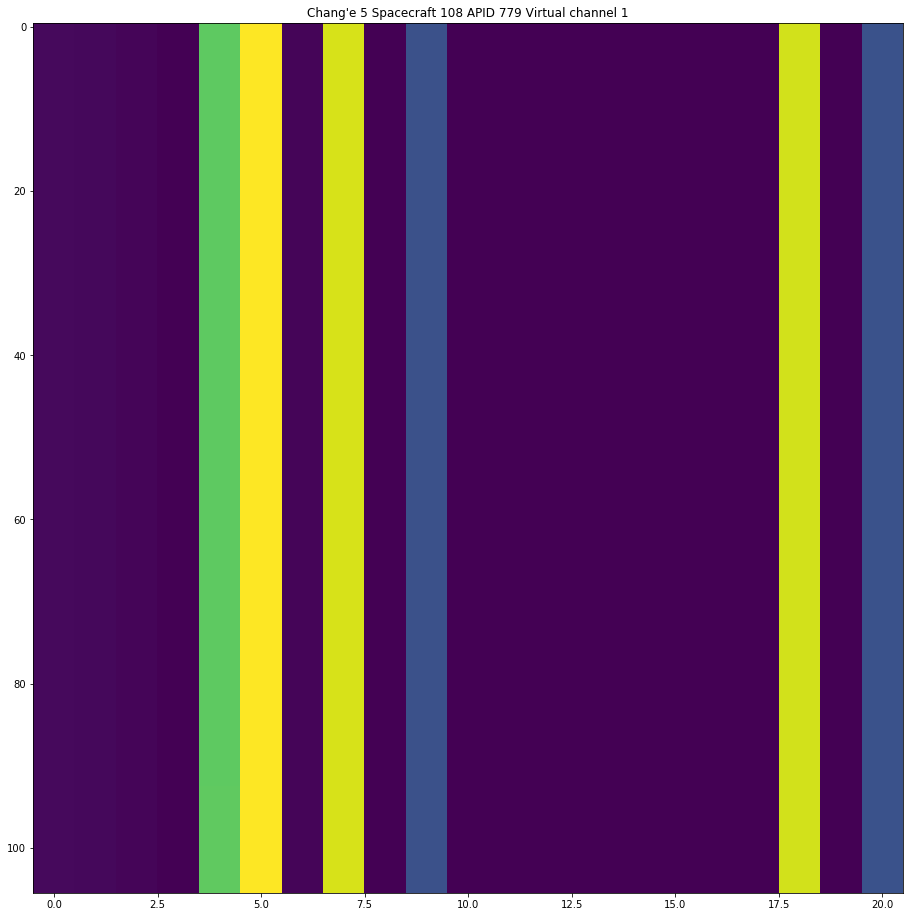

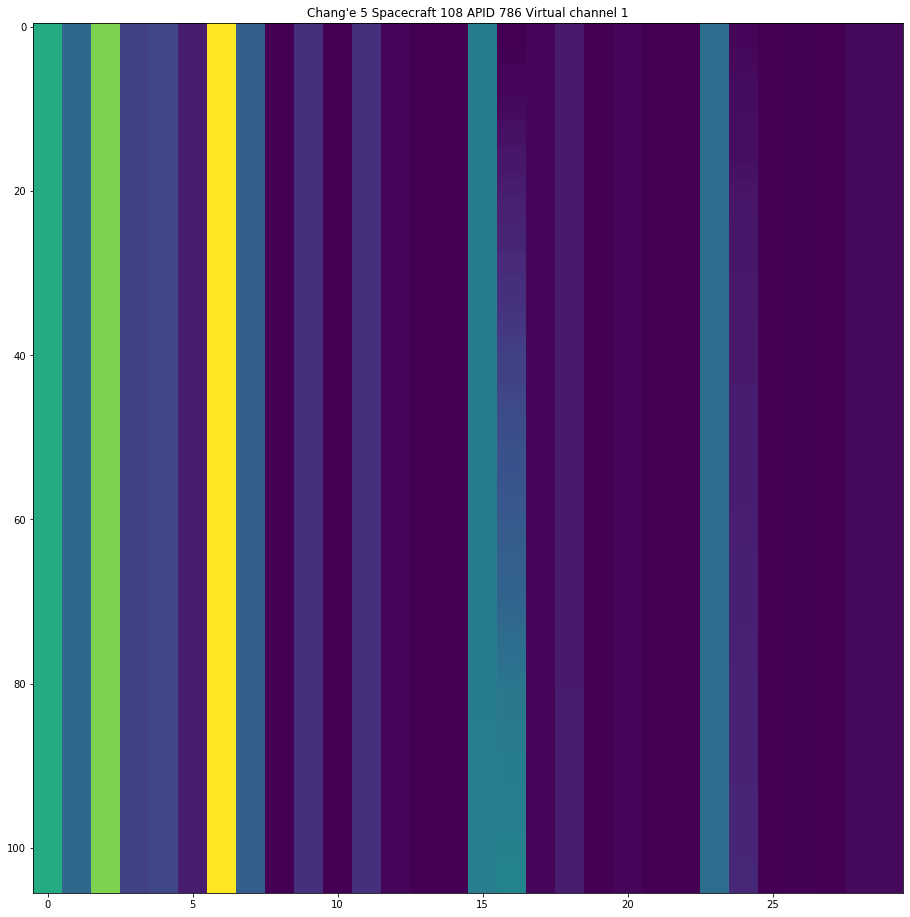

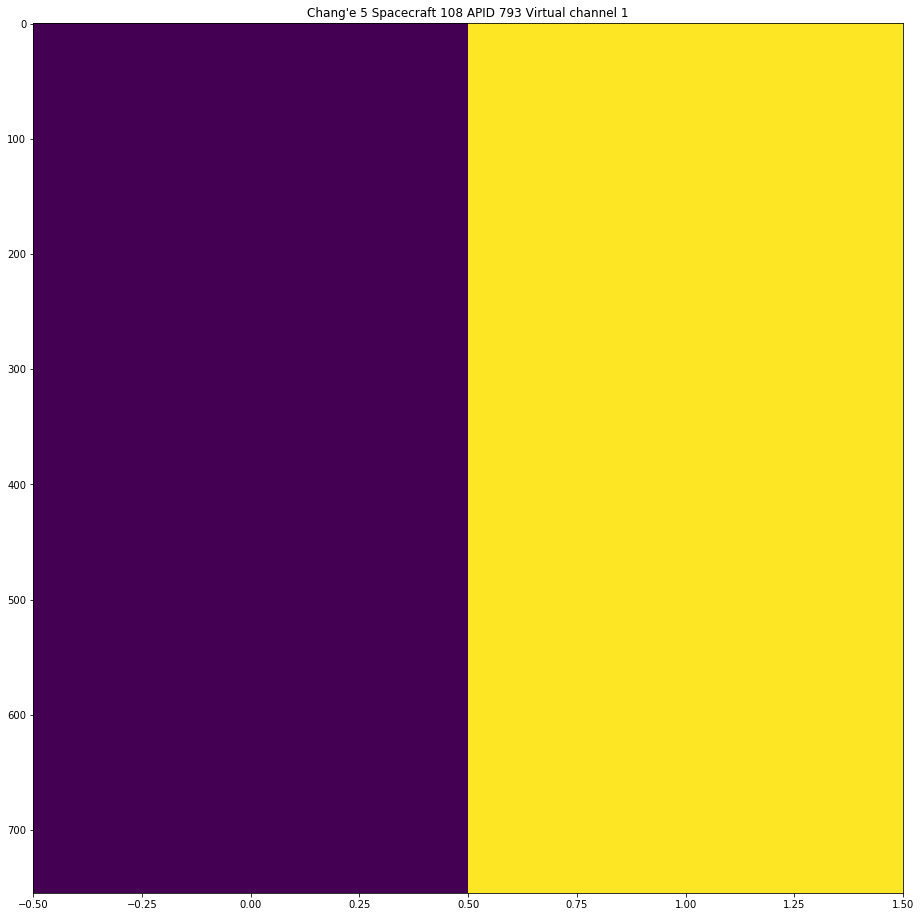

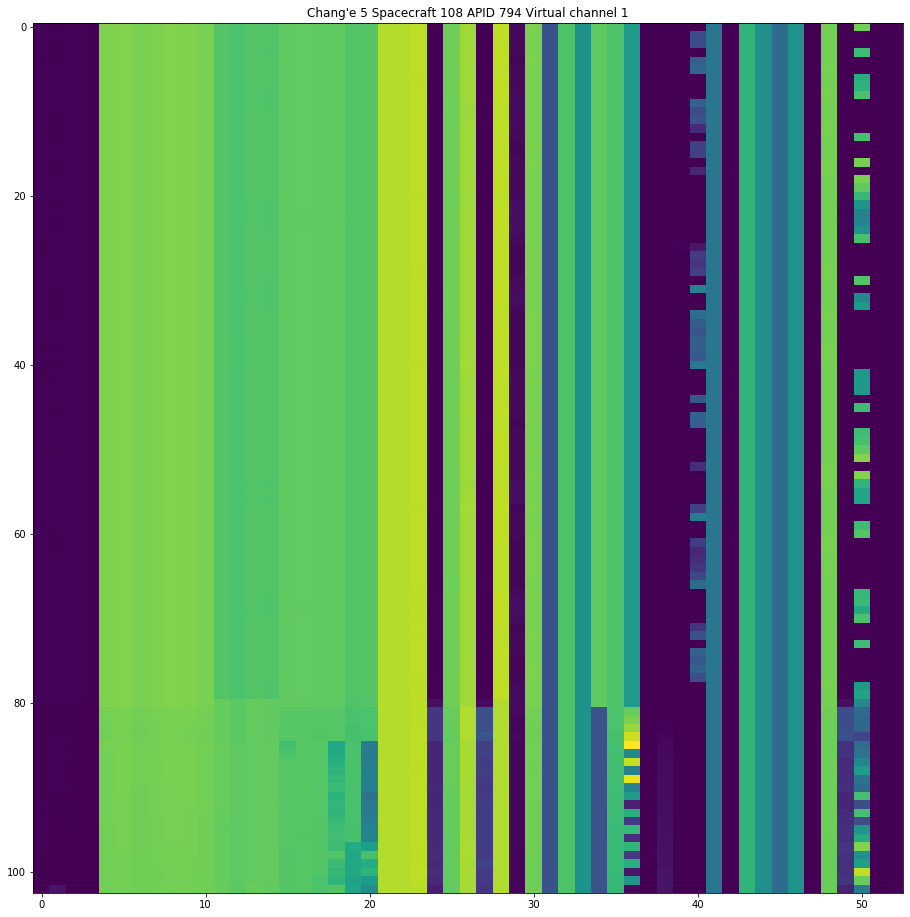

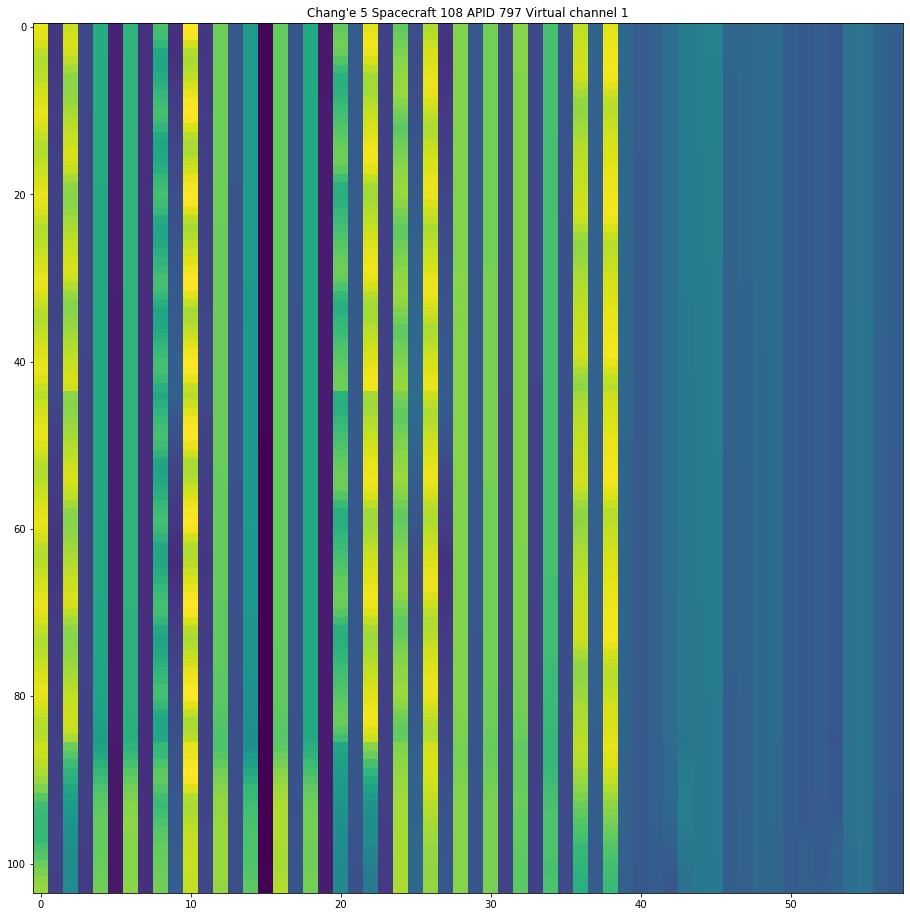

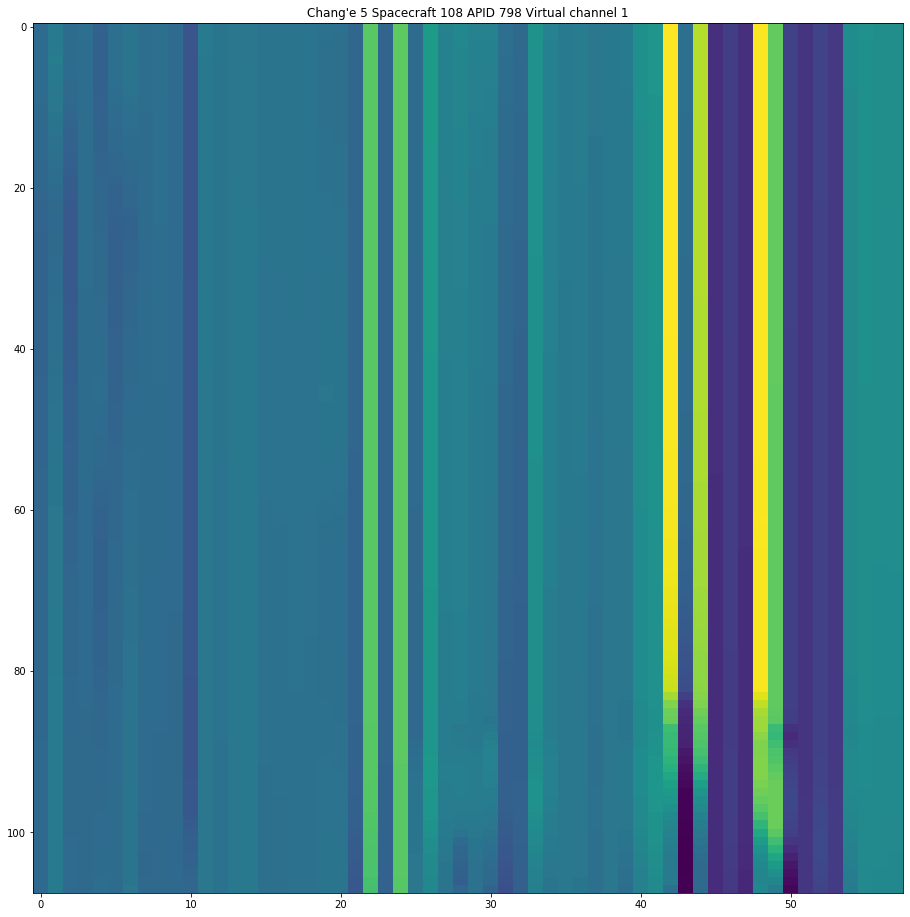

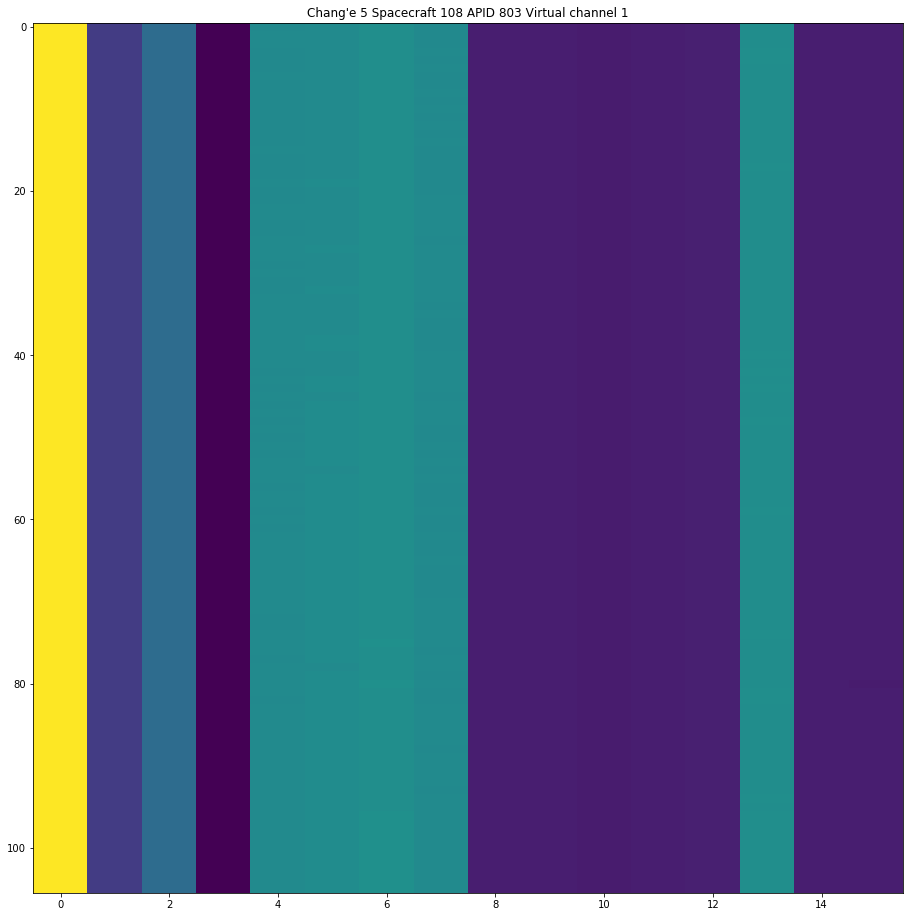

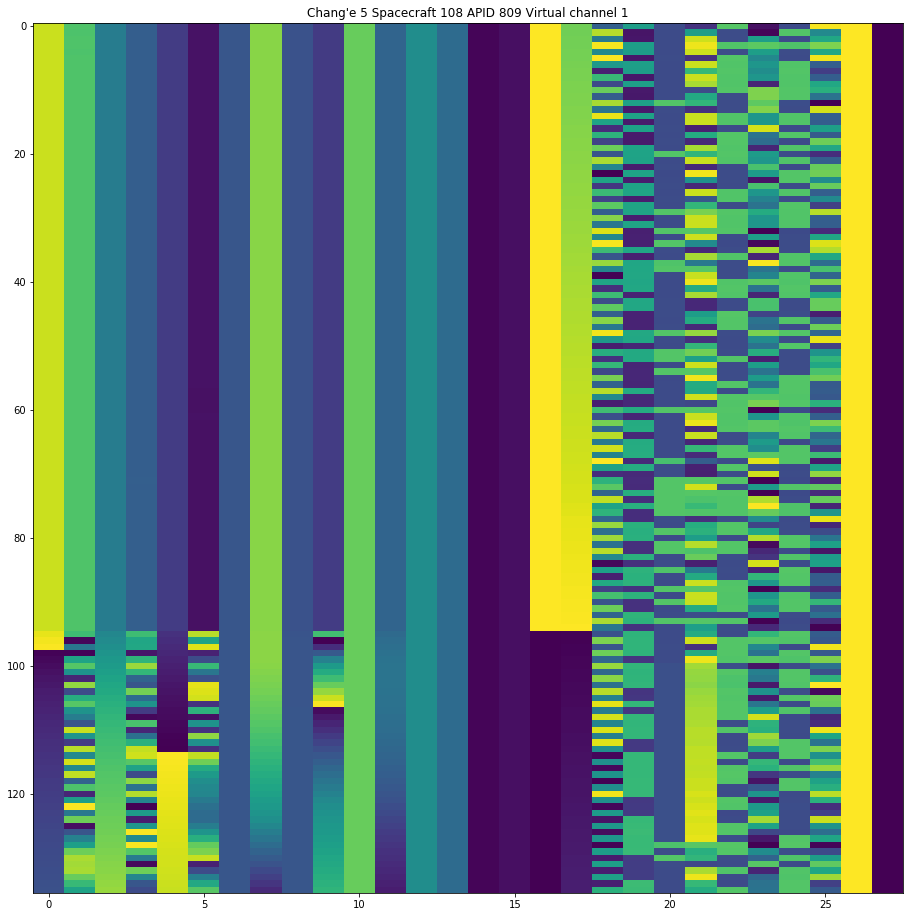

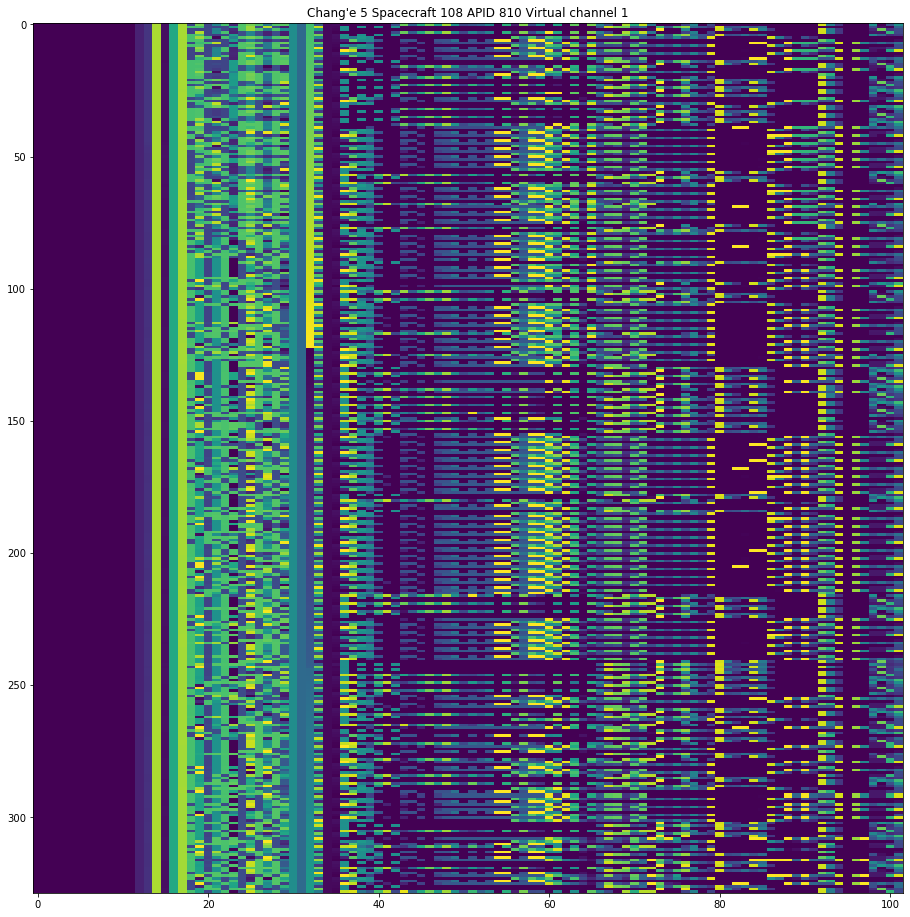

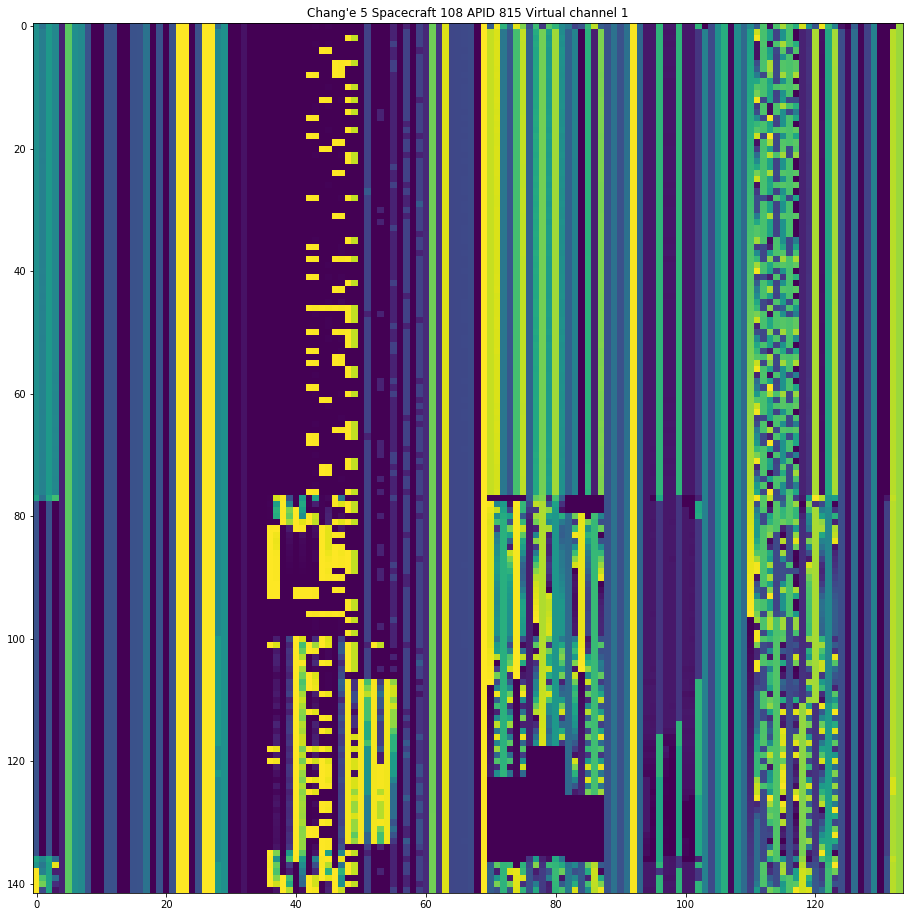

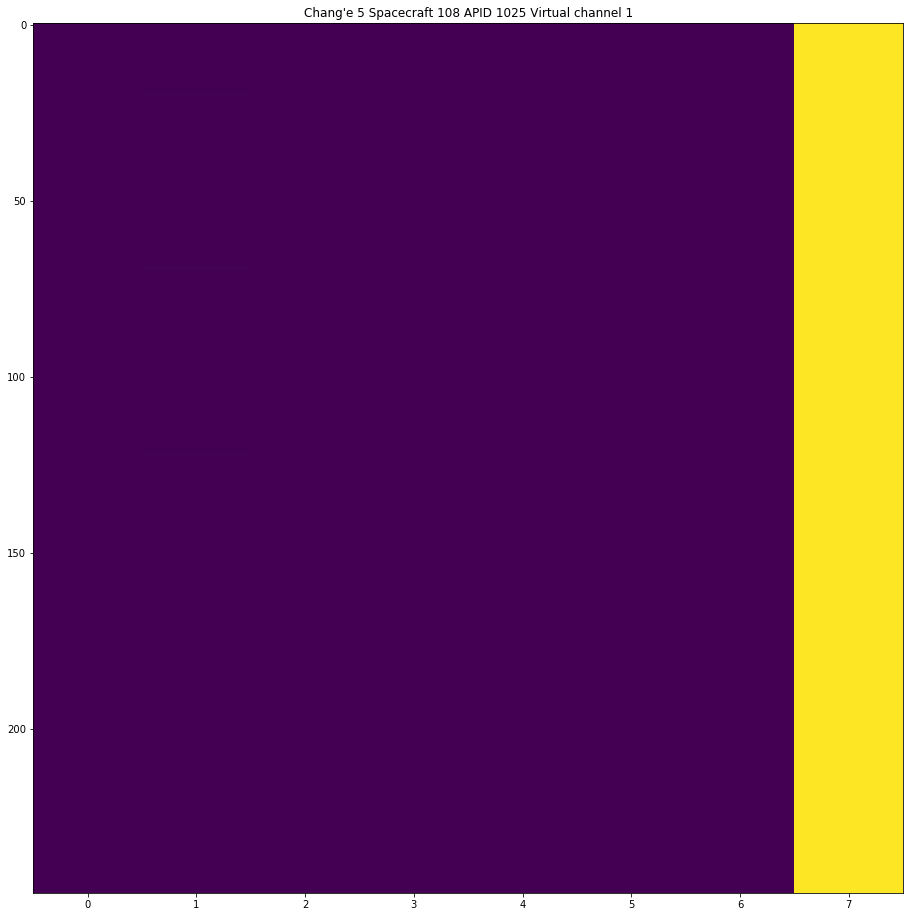

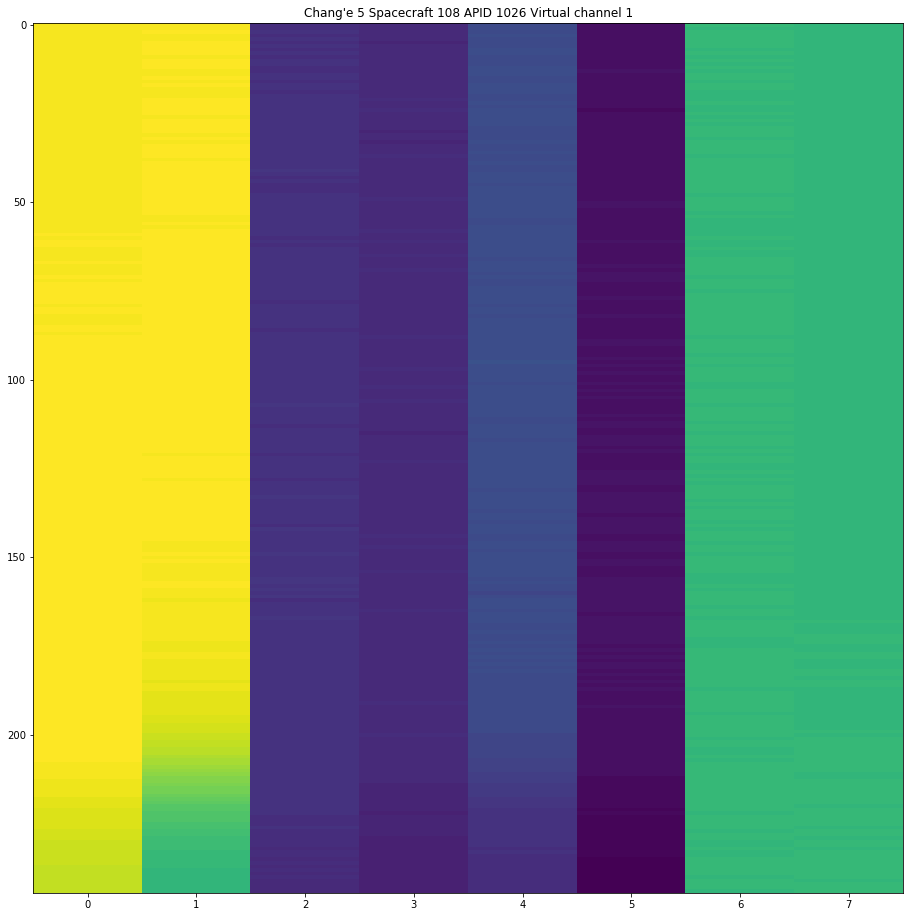

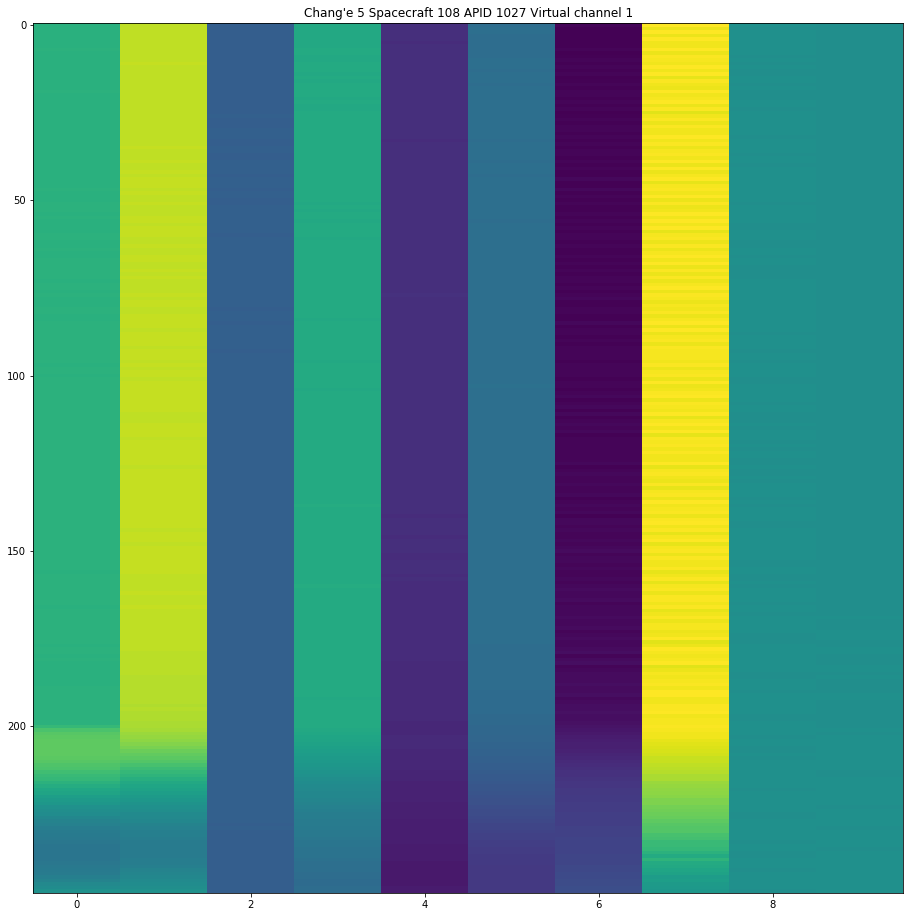

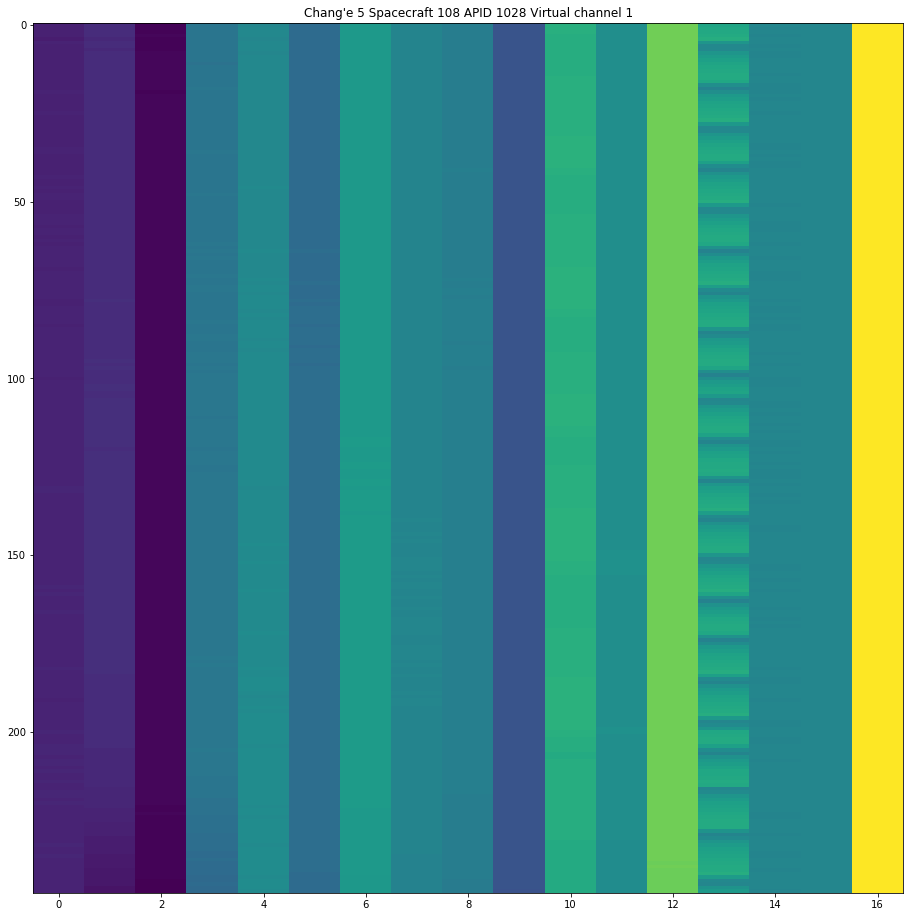

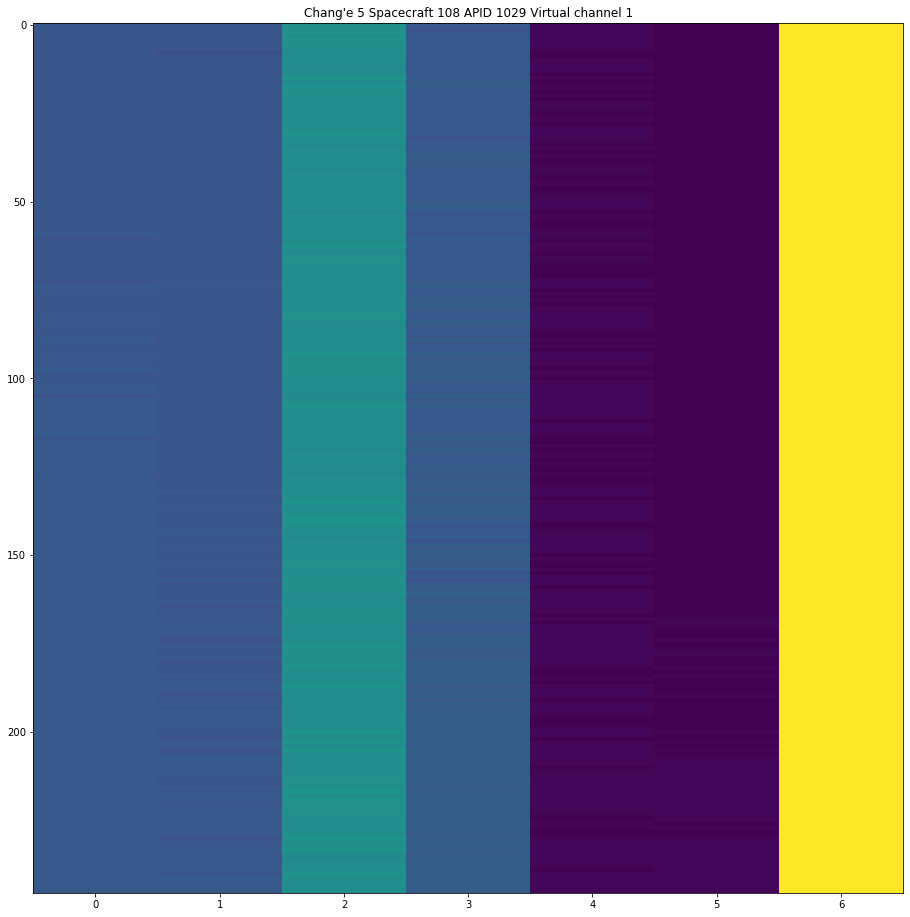

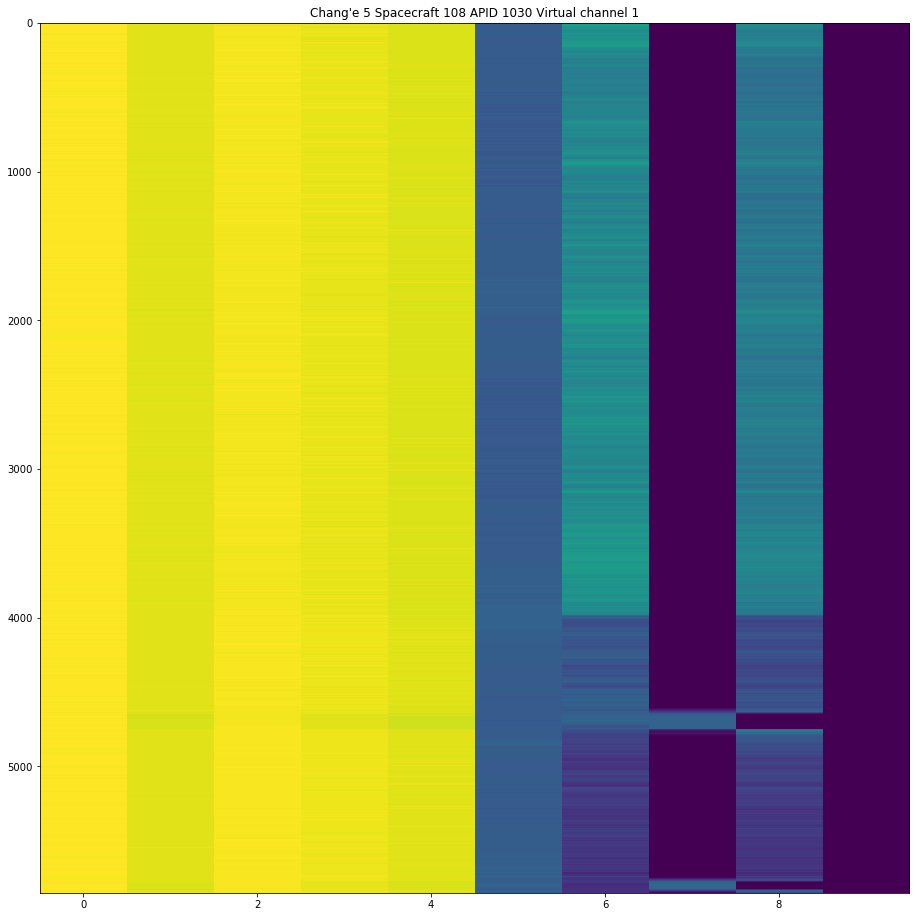

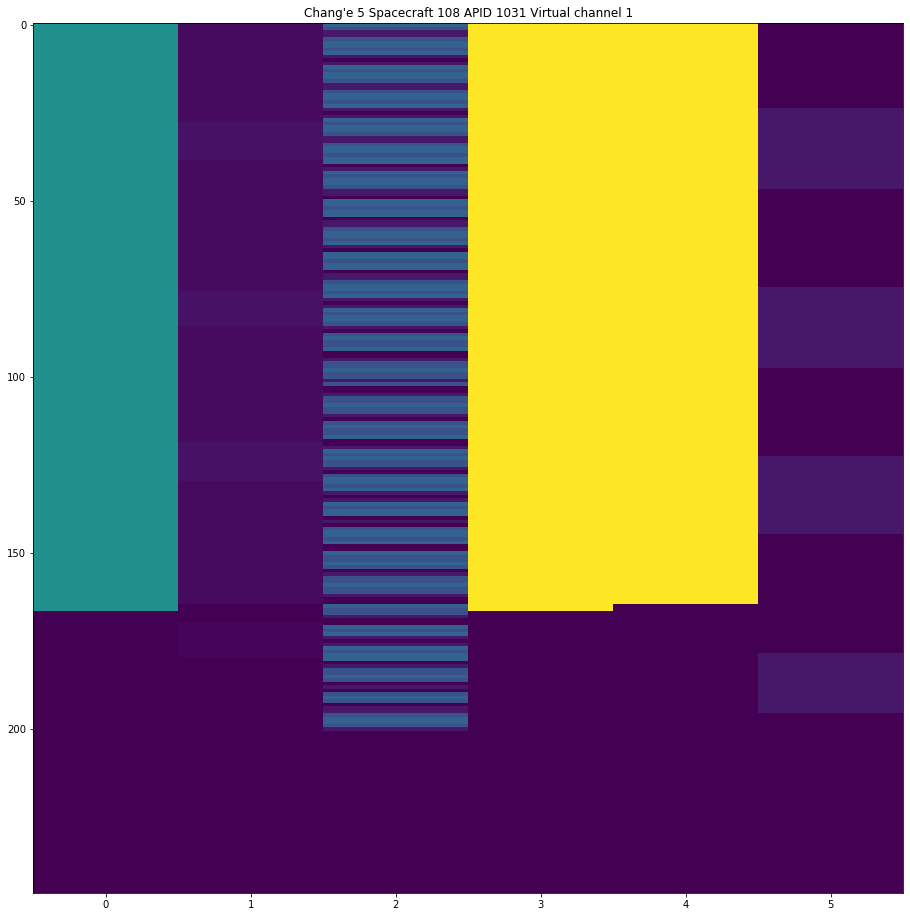

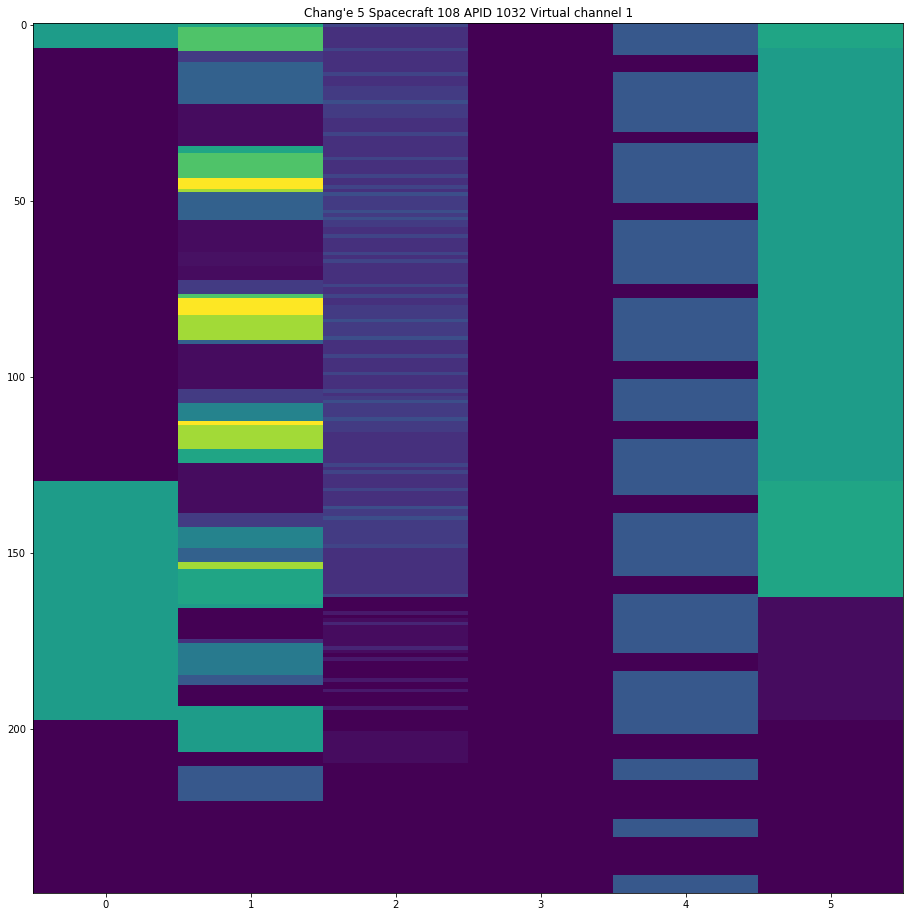

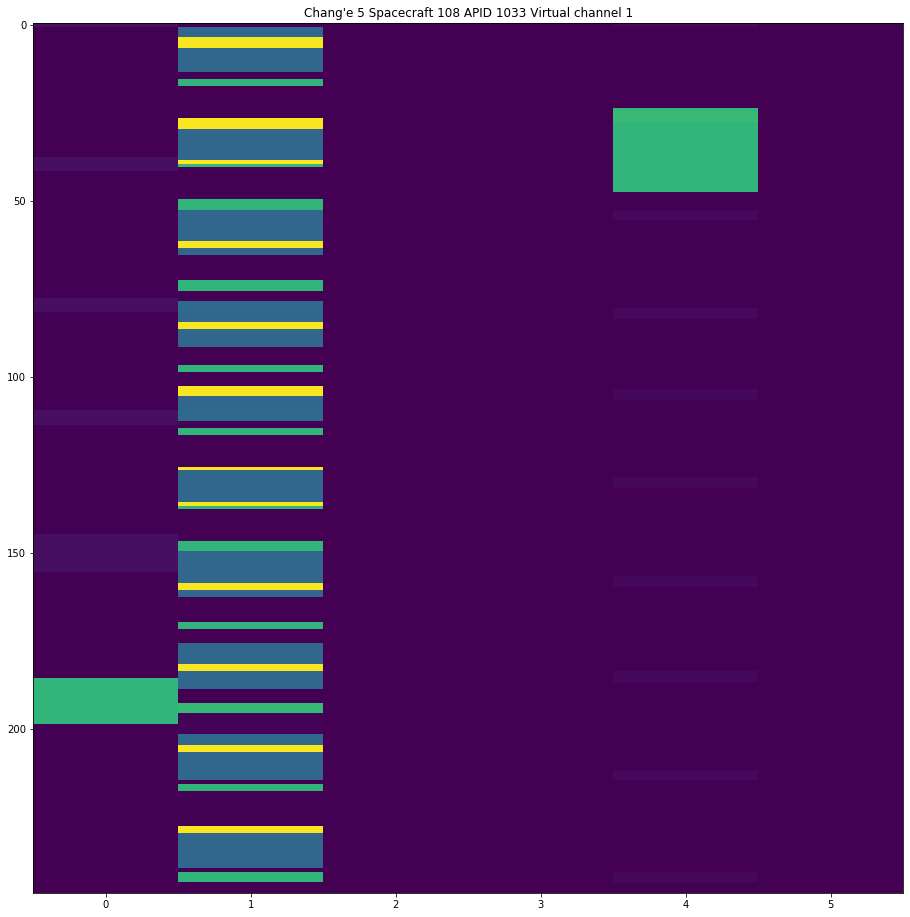

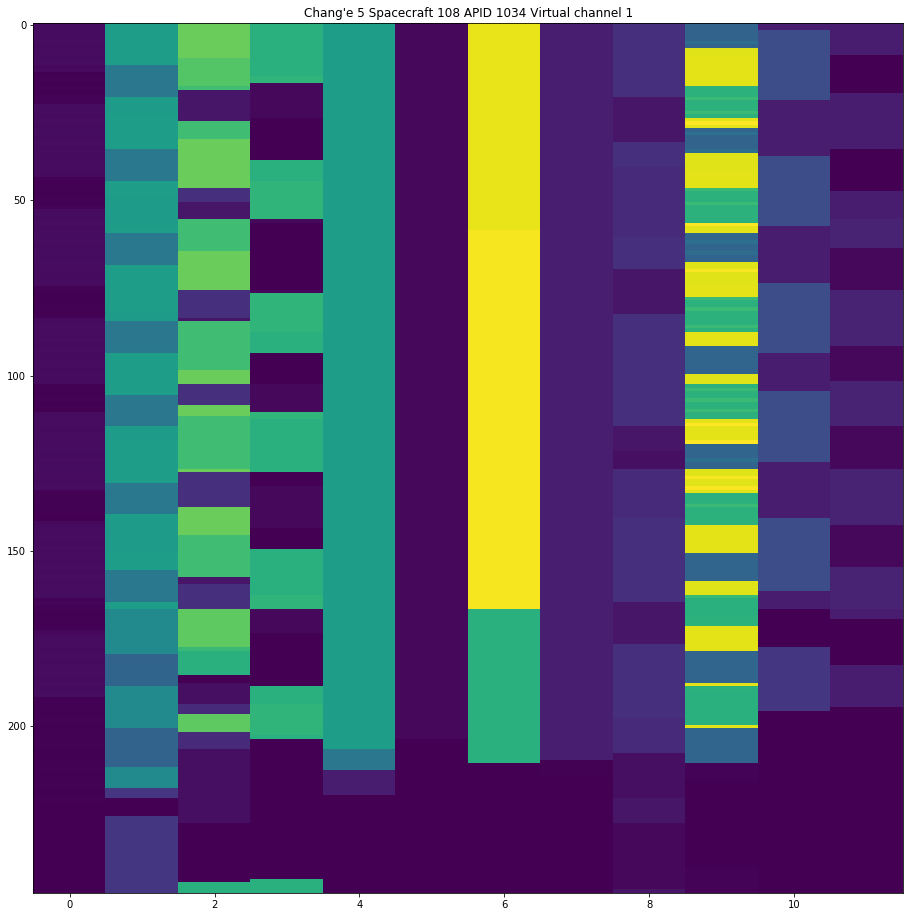

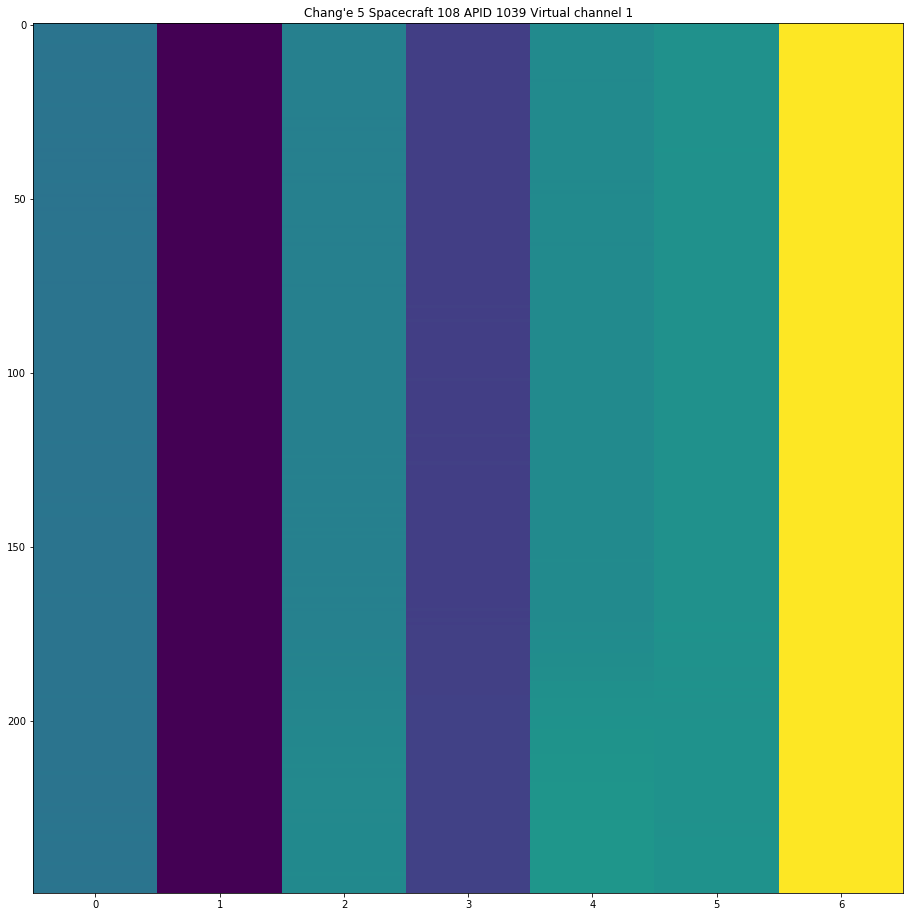

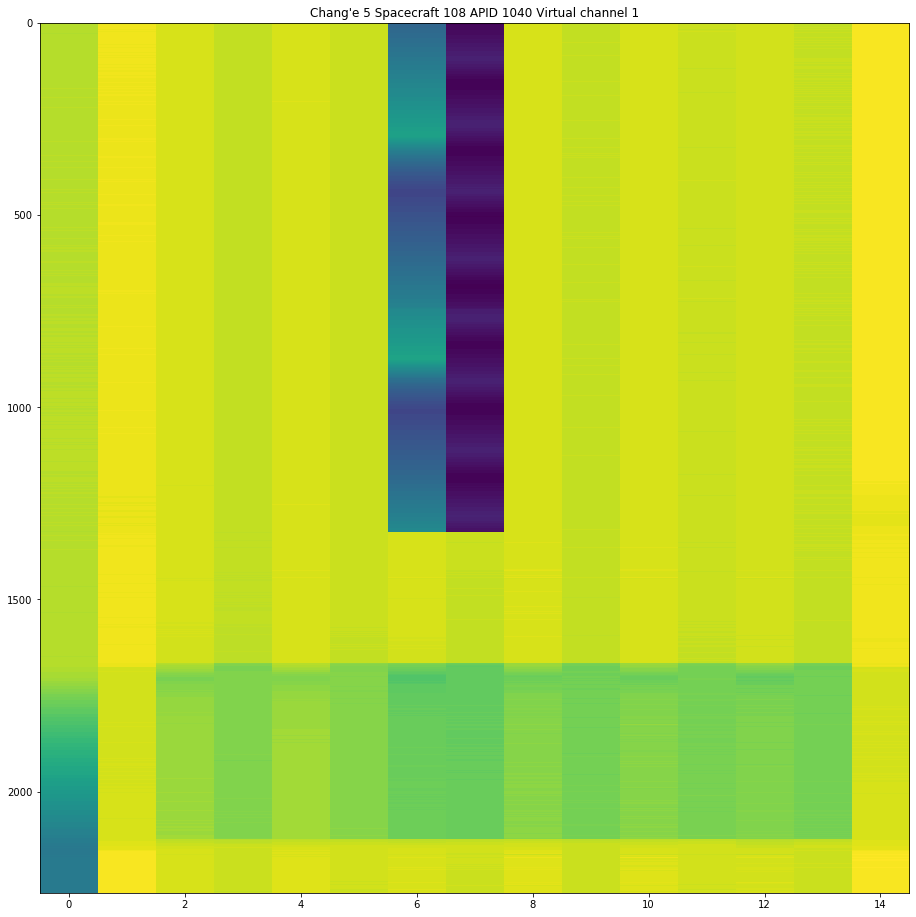

In [29]:
plot_apids(sc108_vc1_by_apid, 108, 1)

## Spacecraft 91 virtual channel 2

In [30]:
sc91_vc2 = {}
for chan in (0,2):
    sc91_vc2.update({k[1] : v for k,v in aos_by_seq[chan].items() if k[0] == 2})
    
sc91_vc2 = [x[1] for x in sorted(sc91_vc2.items(), key = lambda x: x[0])]
fc = np.array([a.primary_header.virtual_channel_frame_count for a in sc91_vc2])
t = get_timestamps([a.insert_zone.timestamp for a in sc91_vc2])

In [31]:
t

array(['2020-11-29T09:24:47', '2020-11-29T09:25:47',
       '2020-11-29T09:26:47', '2020-11-29T09:53:45',
       '2020-11-29T09:53:47', '2020-11-29T09:53:49',
       '2020-11-29T09:53:51', '2020-11-29T09:53:53',
       '2020-11-29T10:47:03', '2020-11-29T11:03:45',
       '2020-11-29T11:13:45', '2020-11-29T11:24:47',
       '2020-11-29T11:39:45', '2020-11-29T11:39:47',
       '2020-11-29T11:39:49', '2020-11-29T11:40:05',
       '2020-11-29T11:40:25', '2020-11-29T11:41:07',
       '2020-11-29T11:41:27', '2020-11-29T11:41:47'],
      dtype='datetime64[s]')

In [32]:
fc

array([1210, 1211, 1212, 1213, 1214, 1215, 1216, 1217, 1218, 1219, 1220,
       1221, 1222, 1223, 1224, 1225, 1226, 1227, 1228, 1229])

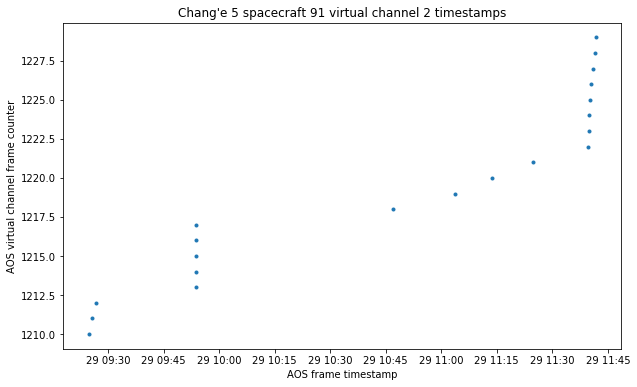

In [33]:
plt.figure(figsize = (10,6), facecolor = 'w')
plt.plot(t, fc, '.')
plt.title("Chang'e 5 spacecraft 91 virtual channel 2 timestamps")
plt.xlabel('AOS frame timestamp')
plt.ylabel('AOS virtual channel frame counter');

In [34]:
sc91_vc2_packets = list(ccsds.extract_space_packets(sc91_vc2, 91, 2, get_timestamps = True))
sc91_vc2_sp_headers = [ccsds.SpacePacketPrimaryHeader.parse(p[0]) for p in sc91_vc2_packets]
sc91_vc2_apids = collections.Counter([p.APID for p in sc91_vc2_sp_headers])

In [35]:
sc91_vc2_sp_headers

[Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=142, sequence_flags=3, packet_sequence_count_or_name=62, data_length=197),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=142, sequence_flags=3, packet_sequence_count_or_name=63, data_length=197),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=142, sequence_flags=3, packet_sequence_count_or_name=64, data_length=197),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=897, sequence_flags=3, packet_sequence_count_or_name=46, data_length=197),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=897, sequence_flags=3, packet_sequence_count_or_name=47, data_length=197),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=897, sequence_flags=3, packet_sequence_count_or_name=48, data_length=197),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=897, sequen

In [36]:
sc91_vc2_by_apid = {apid : [p for h,p in zip(sc91_vc2_sp_headers, sc91_vc2_packets)
                           if h.APID == apid] for apid in sc91_vc2_apids}

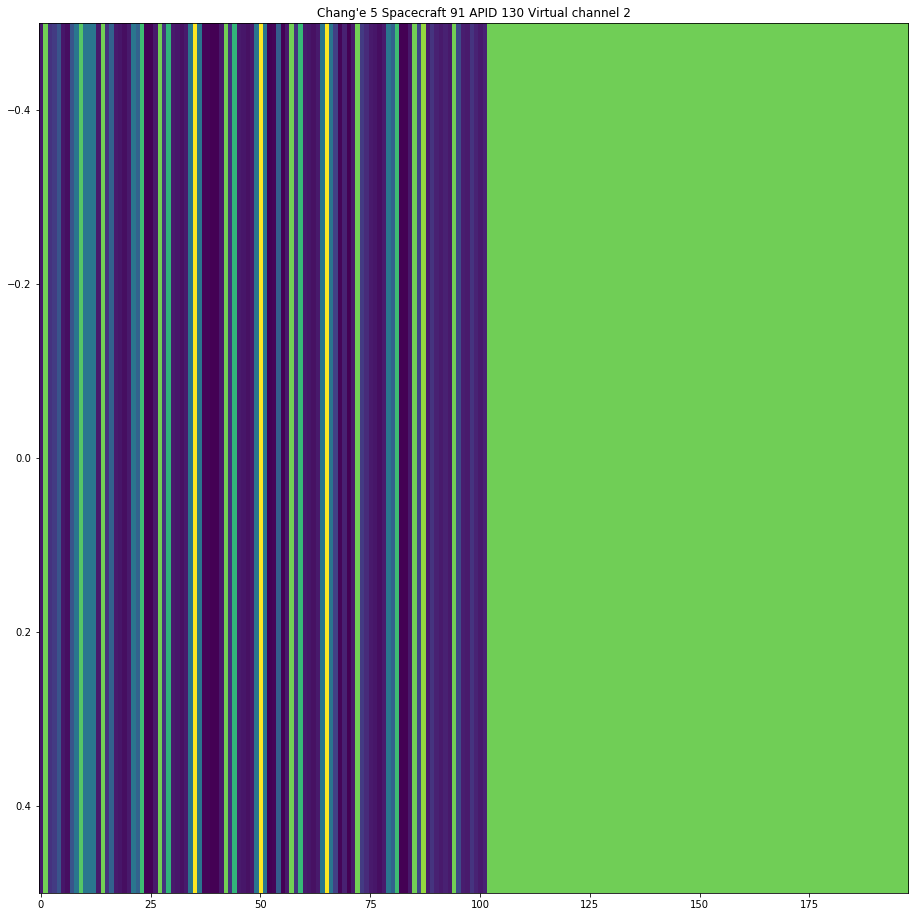

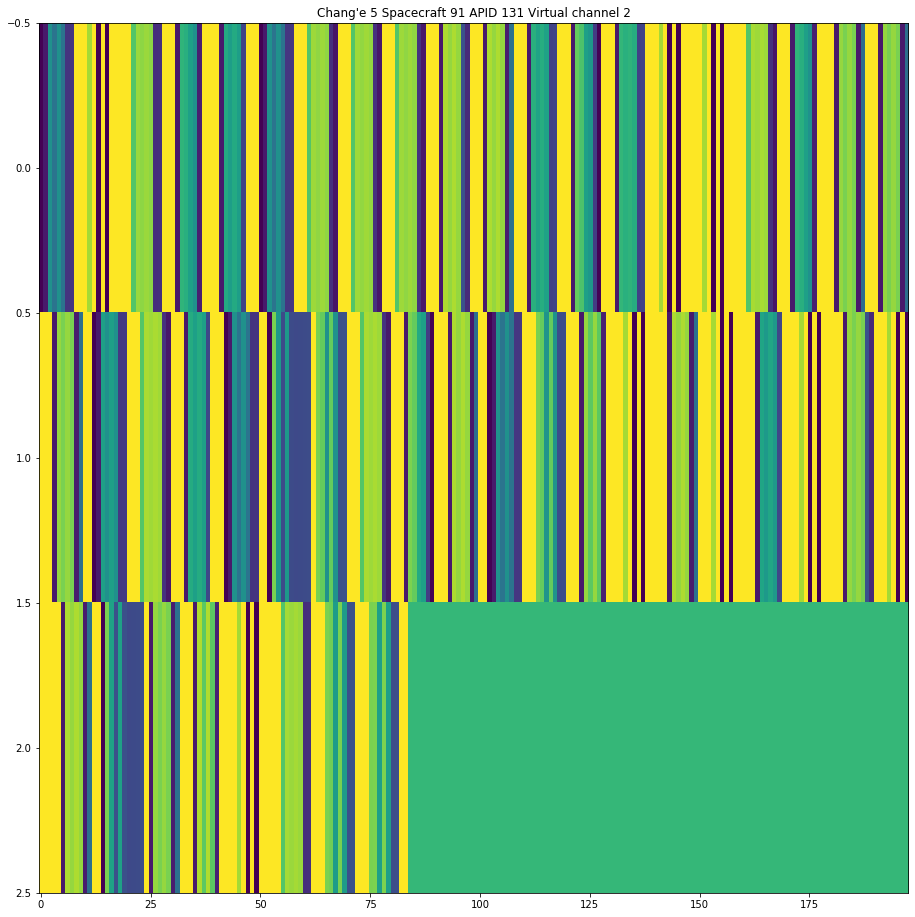

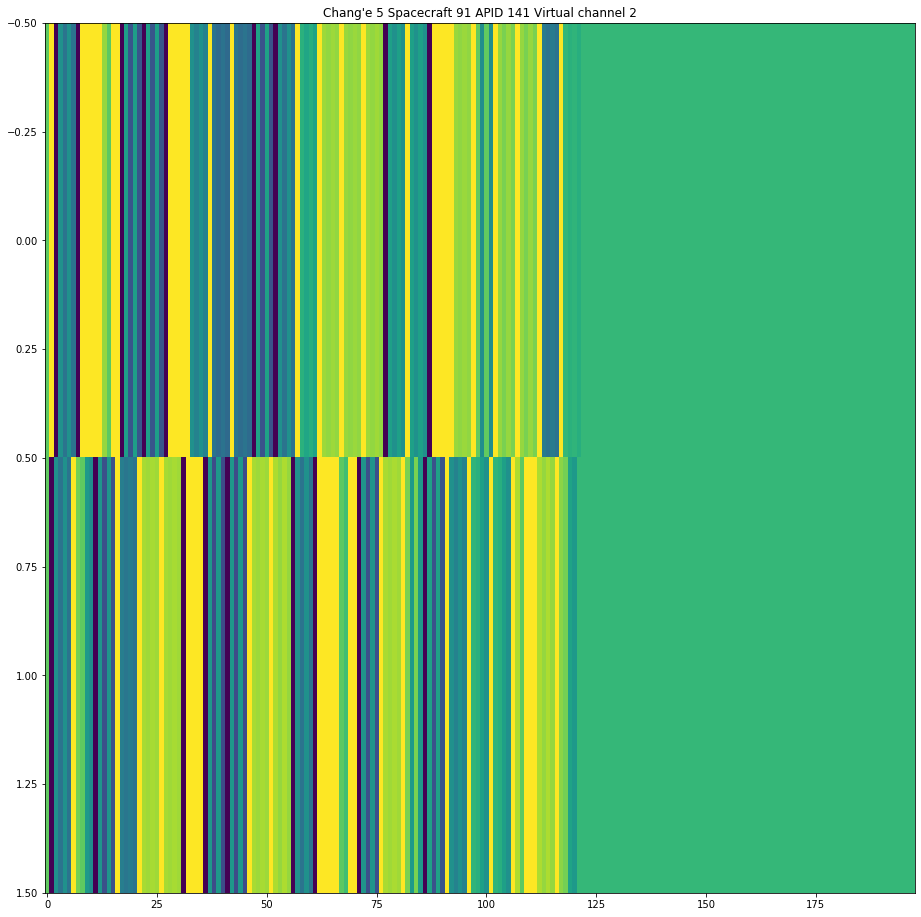

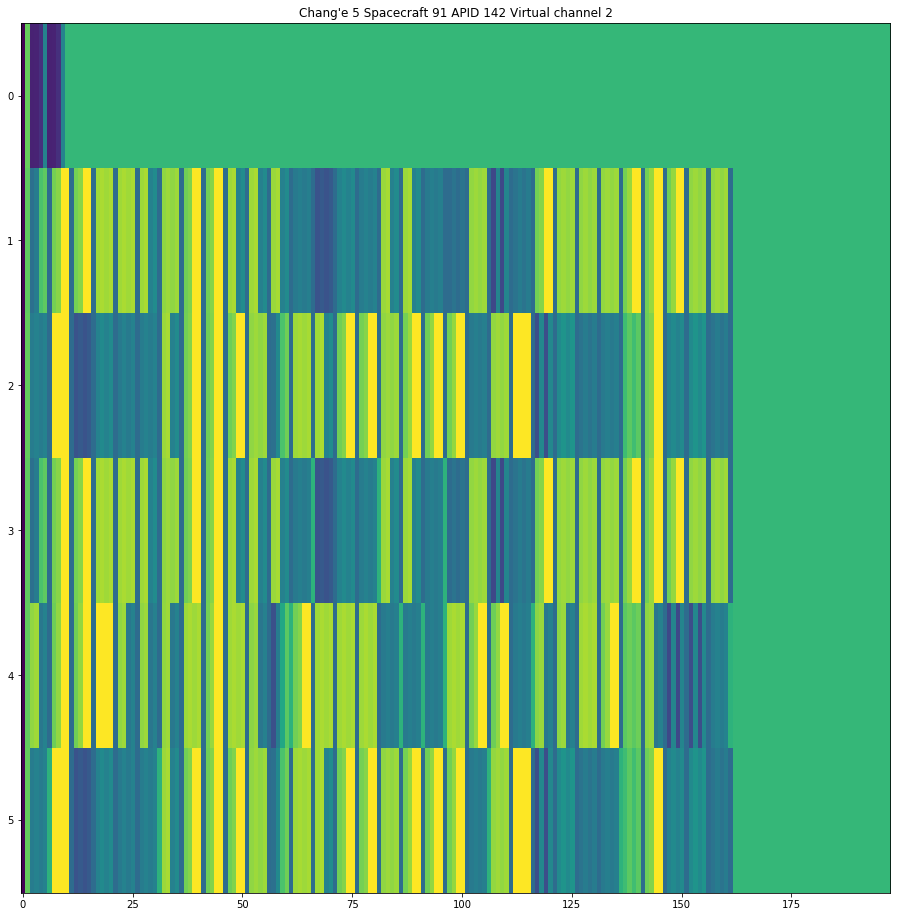

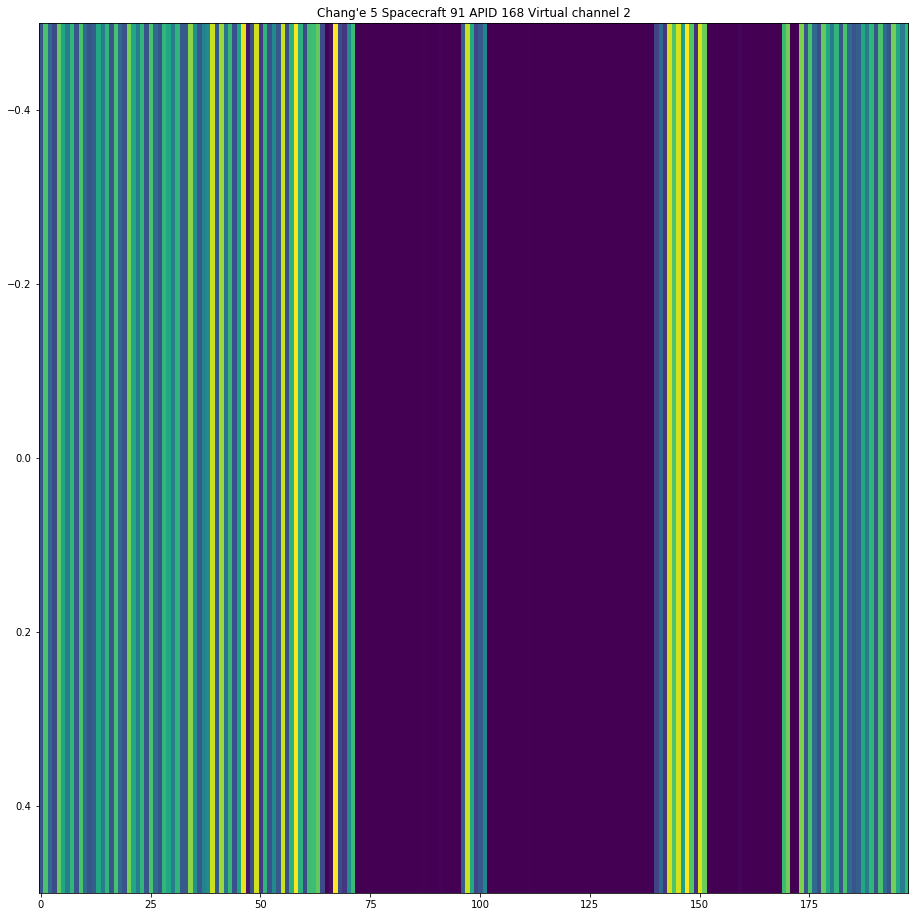

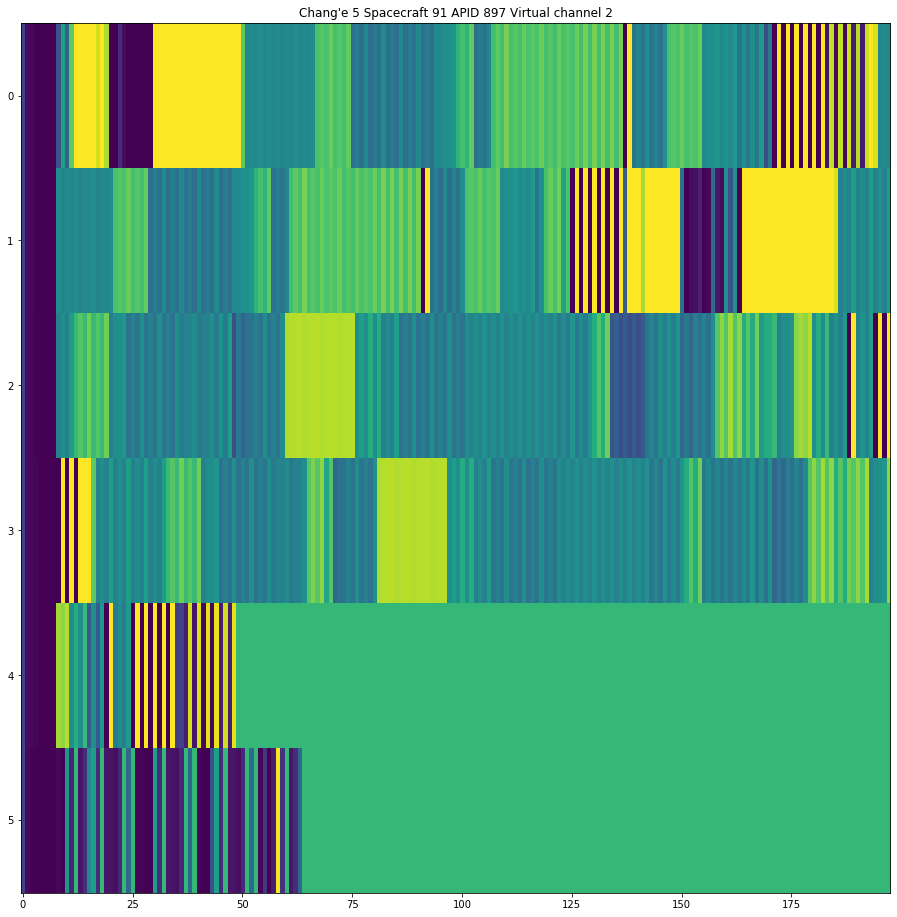

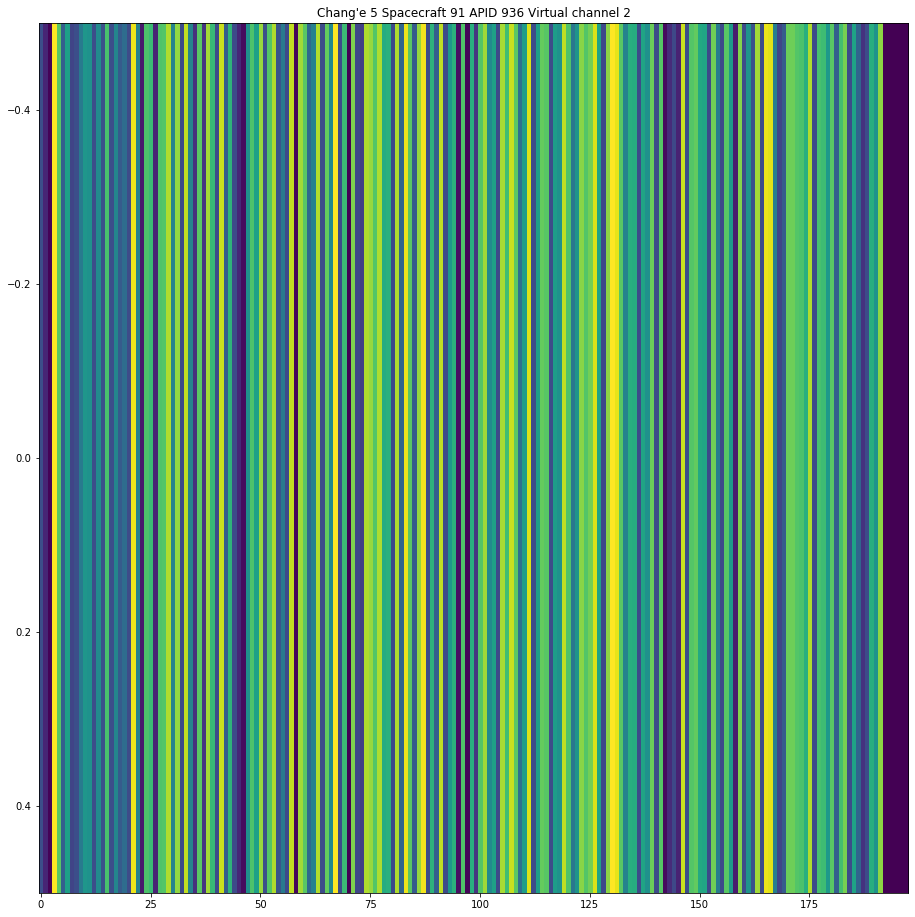

In [37]:
plot_apids(sc91_vc2_by_apid, 91, 2)

## Spacecraft 108 Virtual channel 2

In [38]:
sc108_vc2 = {}
for chan in (1,3):
    sc108_vc2.update({k[1] : v for k,v in aos_by_seq[chan].items() if k[0] == 2})
    
sc108_vc2 = [x[1] for x in sorted(sc108_vc2.items(), key = lambda x: x[0])]
fc = np.array([a.primary_header.virtual_channel_frame_count for a in sc108_vc2])
t = get_timestamps([a.insert_zone.timestamp for a in sc108_vc2])

In [39]:
t

array(['2020-11-29T09:24:49', '2020-11-29T09:25:49',
       '2020-11-29T09:26:49', '2020-11-29T09:53:49',
       '2020-11-29T09:53:51', '2020-11-29T09:53:53',
       '2020-11-29T09:53:55', '2020-11-29T09:53:57',
       '2020-11-29T11:03:49', '2020-11-29T11:13:48',
       '2020-11-29T11:24:48', '2020-11-29T11:39:48',
       '2020-11-29T11:39:49', '2020-11-29T11:39:50',
       '2020-11-29T11:40:08', '2020-11-29T11:40:28',
       '2020-11-29T11:41:08', '2020-11-29T11:41:28',
       '2020-11-29T11:41:48'], dtype='datetime64[s]')

In [40]:
fc

array([ 984,  985,  986,  987,  988,  989,  990,  991,  993,  994,  995,
        996,  997,  998,  999, 1000, 1001, 1002, 1003])

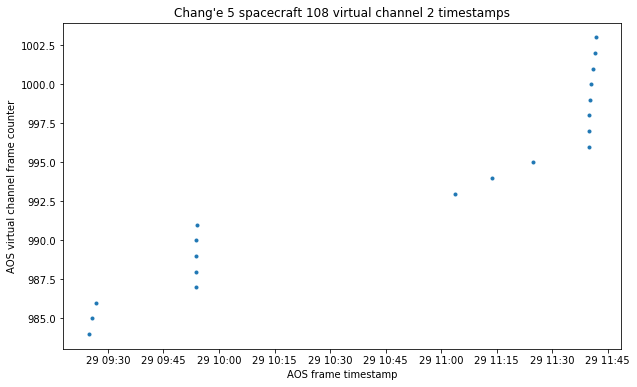

In [41]:
plt.figure(figsize = (10,6), facecolor = 'w')
plt.plot(t, fc, '.')
plt.title("Chang'e 5 spacecraft 108 virtual channel 2 timestamps")
plt.xlabel('AOS frame timestamp')
plt.ylabel('AOS virtual channel frame counter');

In [42]:
sc108_vc2_packets = list(ccsds.extract_space_packets(sc108_vc2, 108, 2, get_timestamps = True))
sc108_vc2_sp_headers = [ccsds.SpacePacketPrimaryHeader.parse(p[0]) for p in sc108_vc2_packets]
sc108_vc2_apids = collections.Counter([p.APID for p in sc108_vc2_sp_headers])

../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 108 VC 2] Broken stream. Last frame count 991, current frame count 993
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')


In [43]:
sc108_vc2_by_apid = {apid : [p for h,p in zip(sc108_vc2_sp_headers, sc108_vc2_packets)
                           if h.APID == apid] for apid in sc108_vc2_apids}

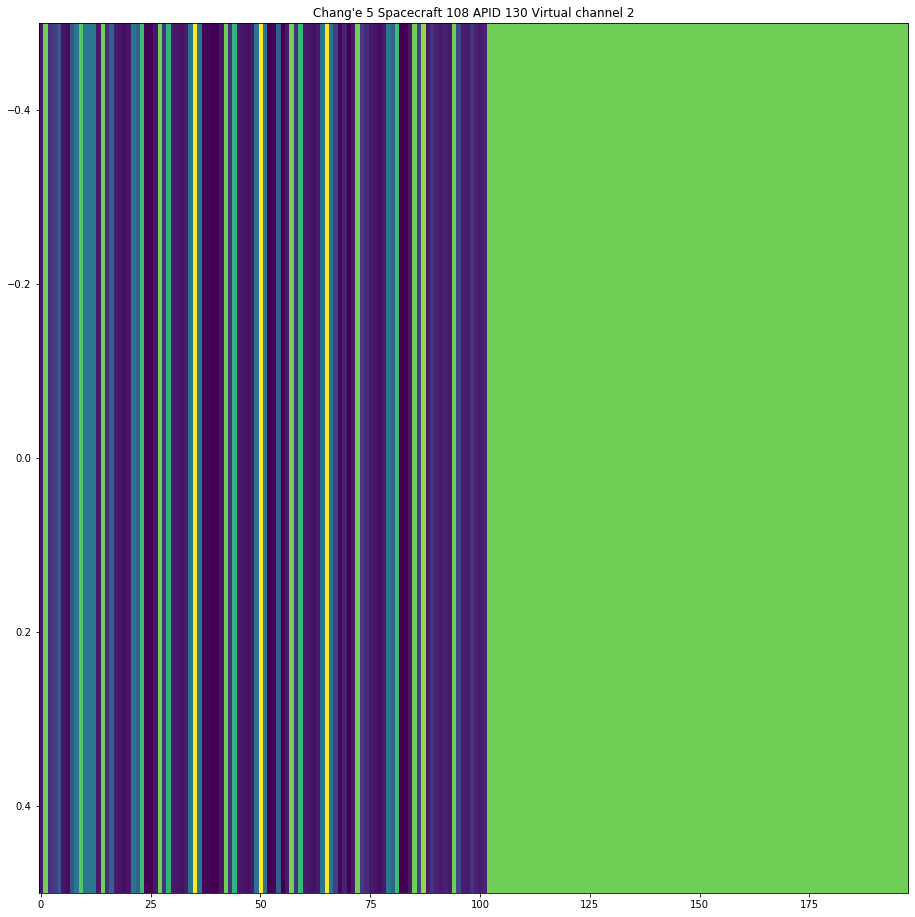

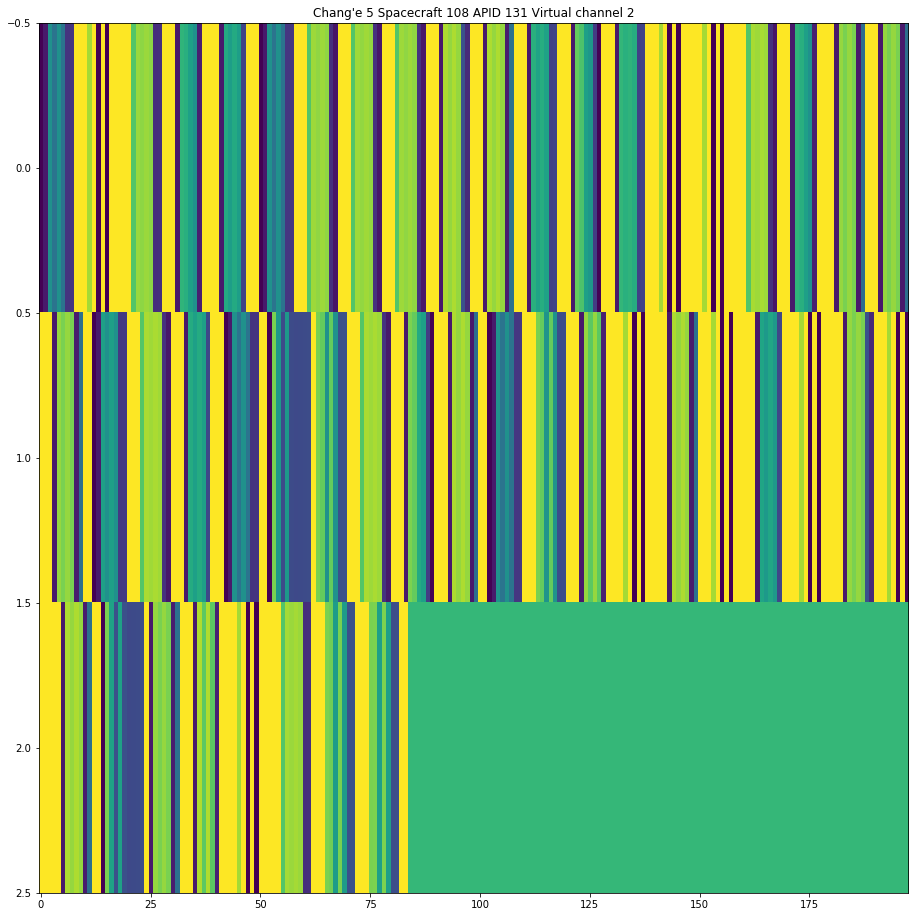

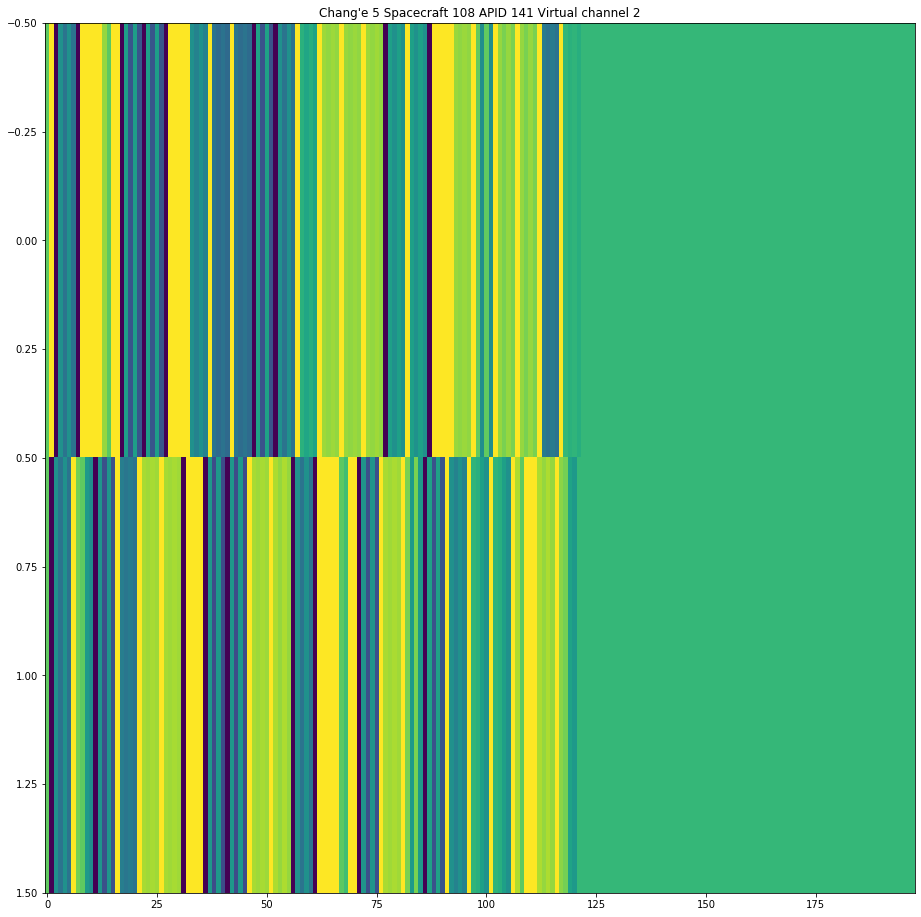

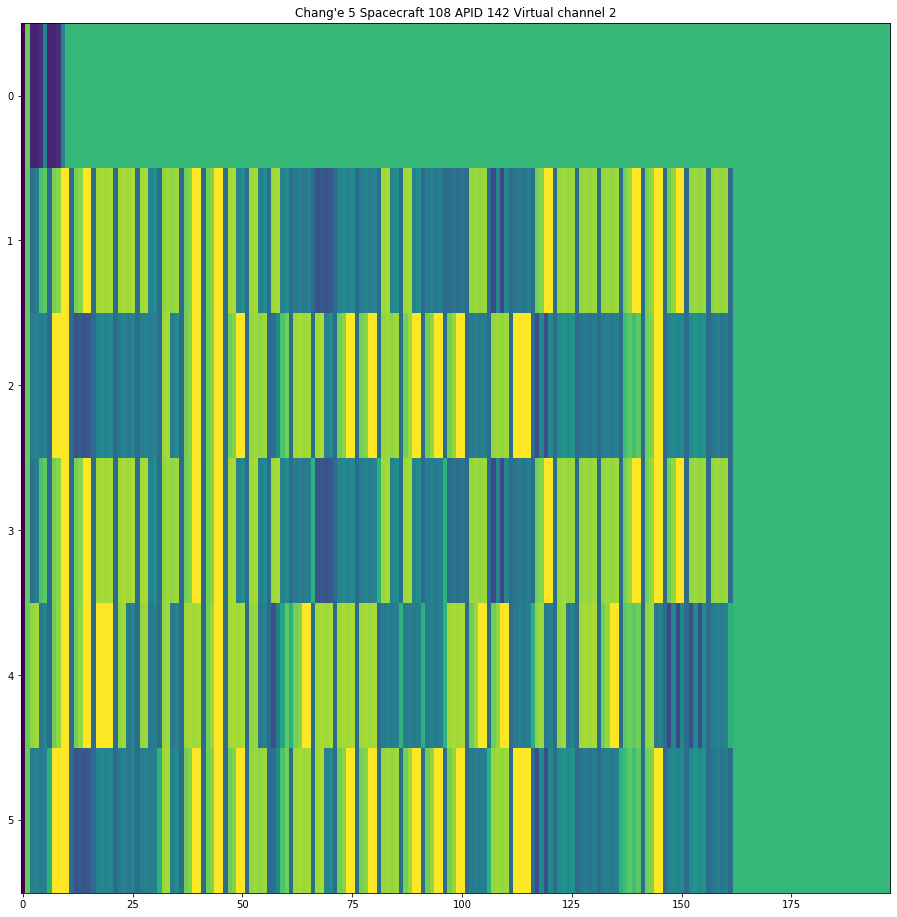

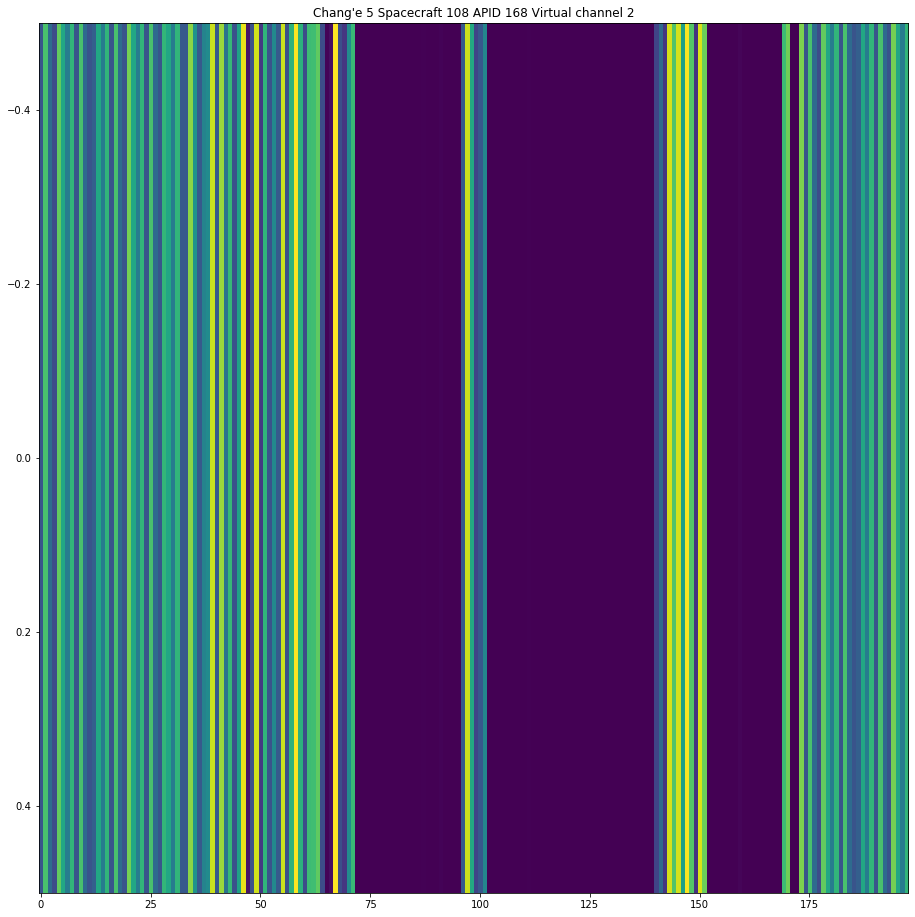

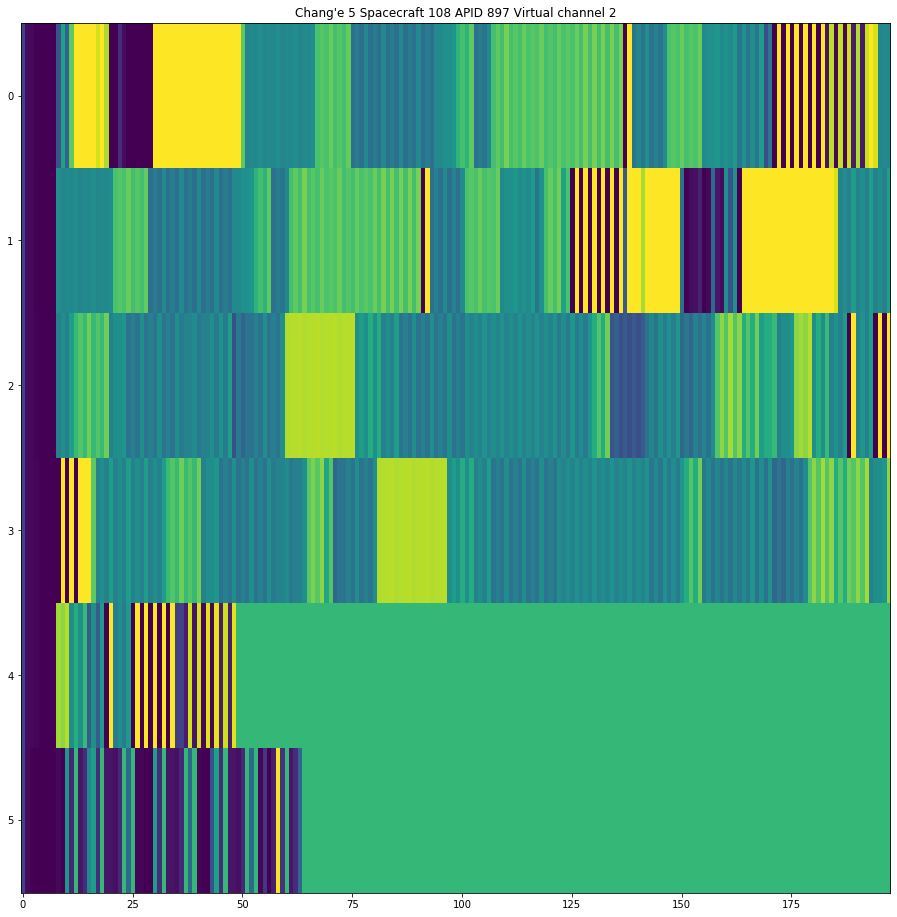

In [44]:
plot_apids(sc108_vc2_by_apid, 108, 2)

In [45]:
sc108_vc2_sp_headers

[Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=142, sequence_flags=3, packet_sequence_count_or_name=62, data_length=197),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=142, sequence_flags=3, packet_sequence_count_or_name=63, data_length=197),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=142, sequence_flags=3, packet_sequence_count_or_name=64, data_length=197),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=897, sequence_flags=3, packet_sequence_count_or_name=46, data_length=197),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=897, sequence_flags=3, packet_sequence_count_or_name=47, data_length=197),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=897, sequence_flags=3, packet_sequence_count_or_name=48, data_length=197),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=897, sequen